# 전처리

In [296]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
indata='SMA_엔진검토용.json'
with open(indata, 'r', encoding='utf-8') as f:
    data = json.load(f)
import subprocess
import math 
import os
import time
from bisect import bisect_left
from typing import List, Dict
from collections import defaultdict
import random
import networkx as nx

In [297]:
facilities = data["facilities"]
group_names = sorted(set(f["facilityGroup"] for f in facilities))
group_matrix = pd.DataFrame(0, index=group_names, columns=group_names)


for f in facilities:
    current_group = f["facilityGroup"]
    for next_group in f.get("nextFacilityGroup", []):
        group_matrix.loc[current_group, next_group] = 1

group_matrix_array=group_matrix.to_numpy()
group_matrix_array_ori=group_matrix.to_numpy()
group_matrix_array = "[" + " ".join(" ".join(map(str, row)) for row in group_matrix_array) + "]"

In [298]:
# facilities와 facilityGroups 가져오기
facilities = data["facilities"]
facility_groups = data["facilityGroups"]

# id -> (width, height) 매핑
#facility_dim_dict = {f["id"]: (f["width"], f["height"], f["minSameTypeSpacing"]['top']) for f in facilities}
facility_dim_dict = {
    f["id"]: (
        f["width"],
        f["height"],
        f.get("facilityHeightDouble"),
        f.get("facilityWeightDouble", 0),  # 없으면 0
        f.get("dry",0),
        f.get("areaMap",0),
        f.get("areaMap",0),
        f.get("areaMap",0),
        f.get("areaMap",0)
    )
    for f in facilities
}
# 각 그룹별 첫 번째 width, height만 저장
rows = []
for group in facility_groups:
    group_id = group["groupId"]
    fac_ids = group["facilities"]
    # 첫 번째 설비의 width, height
    first_id = fac_ids[0]
    width, height,facilityHeight,facilityWeight,dry, UR,UL,UB,UA = facility_dim_dict[first_id]
    rows.append((group_id ,width, height,facilityHeight,facilityWeight,dry,UR,UL,UB,UA))

# DataFrame 생성
df_facilities = pd.DataFrame(rows, columns=['설비Group', 'x', 'y','facilityHeight','facilityWeight','dry','UR','UL','UB','UA'])

In [299]:
# for c in range(len(df_facilities)):
#     try:
#         for i in range(len(df_facilities.at[c,'UL']['VARIABLE_AREA'])):
#             if -df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['x']>0 or -df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['y']>0:
#                 df_facilities.at[c,'UL']=-df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['x']
#                 df_facilities.at[c,'UB']=-df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['y']
#                 df_facilities.at[c,'UR']=df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['x']+df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['width']-df_facilities.at[c,'x']
#                 df_facilities.at[c,'UA']=df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['y']+df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['height']-df_facilities.at[c,'y']
#                 break    
#             if i==len(df_facilities.at[c,'UL']['VARIABLE_AREA'])-1:
#                 df_facilities.at[c,'UL']=0
#                 df_facilities.at[c,'UB']=0
#                 df_facilities.at[c,'UA']=0
#                 df_facilities.at[c,'UR']=0                
                
#     except:
#         df_facilities.at[c,'UL']=0
#         df_facilities.at[c,'UB']=0
#         df_facilities.at[c,'UA']=0
#         df_facilities.at[c,'UR']=0

In [300]:
for c in range(len(df_facilities)):
    
        try:
            min_UL=99999999999999
            for i in range(len(df_facilities.at[c,'UL']['VARIABLE_AREA'])):
                if -df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['x']>=0 and -df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['y']>=0:
                    if min_UL>=df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['x']:
                        min_UL=df_facilities.at[c,'UL']['VARIABLE_AREA'][i]['x']
            if min_UL==99999999999999:
                df_facilities.at[c,'UL']=0
            else:
                df_facilities.at[c,'UL']=-min_UL
        except:
            df_facilities.at[c,'UL']=0

        try:
            max_UR=-99999999999999
            for i in range(len(df_facilities.at[c,'UR']['VARIABLE_AREA'])):
                if -df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['x']>=0 and -df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['y']>=0:
                    if max_UR<=df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['x']+df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['width']:
                        
                        max_UR=df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['x']+df_facilities.at[c,'UR']['VARIABLE_AREA'][i]['width']
            if max_UR==-99999999999999:
                df_facilities.at[c,'UR']=0
            else:
                df_facilities.at[c,'UR']=max_UR-df_facilities.loc[c,'x']
        except:
            df_facilities.at[c,'UR']=0

        try:
            min_UB=99999999999999
            for i in range(len(df_facilities.at[c,'UB']['VARIABLE_AREA'])):
                if -df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['x']>=0 and -df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['y']>=0:
                    if min_UB>=df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['y']:
                        min_UB=df_facilities.at[c,'UB']['VARIABLE_AREA'][i]['y']
            if min_UB==99999999999999:
                df_facilities.at[c,'UB']=0
            else:
                df_facilities.at[c,'UB']=-min_UB
        except:
            df_facilities.at[c,'UB']=0

        try:
            max_UA=-99999999999999
            for i in range(len(df_facilities.at[c,'UA']['VARIABLE_AREA'])):
                if -df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['x']>=0 and -df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['y']>=0:
                    if max_UA<=df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['y']+df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['height']:
                        
                        max_UA=df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['y']+df_facilities.at[c,'UA']['VARIABLE_AREA'][i]['height']
            if max_UA==-99999999999999:
                df_facilities.at[c,'UA']=0
            else:
                df_facilities.at[c,'UA']=max_UA-df_facilities.loc[c,'y']
        except:
            df_facilities.at[c,'UA']=0

In [301]:
# for c in range(len(df_facilities)):
#     try:
#         df_facilities.at[c,'UL']=-df_facilities.at[c,'UL']['VARIABLE_AREA'][0]['x']
#         df_facilities.at[c,'UB']=-df_facilities.at[c,'UB']['VARIABLE_AREA'][0]['y']
#     except:
#         df_facilities.at[c,'UL']=0
#         df_facilities.at[c,'UB']=0

In [302]:
import pandas as pd

# data["facilityGroups"] 가져오기
facility_groups = data["facilityGroups"]

# groupId와 설비수량 추출
rows = []
for group in facility_groups:
    group_id = group["groupId"]
    count = len(group["facilities"])
    rows.append((group_id, count))

# DataFrame 생성
df_facility_count = pd.DataFrame(rows, columns=['설비Group', '설비수량'])
df_selected= pd.merge(df_facility_count,df_facilities, on='설비Group')

In [303]:
# # facilities와 facilityGroups 가져오기
# facilities = data["facilities"]
# facility_groups = data["facilityGroups"]

# # id -> (width, height) 매핑
# facility_dim_dict = {f["id"]: (f["type"],f.get("placeableAreaIds",0),f["processGroup"],f["entranceRelativeX"], f["entranceRelativeY"],f["exitRelativeX"],f["exitRelativeY"],f["lineCount"],f["pathWidth"]) for f in facilities}

# # 각 그룹별 첫 번째 width, height만 저장
# rows = []
# for group in facility_groups:
#     group_id = group["groupId"]
#     fac_ids = group["facilities"]
#     # 첫 번째 설비의 width, height
#     first_id = fac_ids[0]
#     ty,pl,pr,ent_X, ent_Y,exi_X,exi_Y,lineCount,pathWidth  = facility_dim_dict[first_id]
#     rows.append((group_id,ty,pl,pr, ent_X, ent_Y,exi_X,exi_Y,lineCount,pathWidth ))
# df_facility_entrance = pd.DataFrame(rows, columns=['설비Group', 'type','placeable','processGroup','ent_X', 'ent_Y','exi_X','exi_Y','lineCount','pathWidth'])

# group_order = group_matrix.index.tolist()

# df_selected = pd.merge(df_selected, df_facility_entrance, on='설비Group')

In [304]:
facilities = data["facilities"]
facility_groups = data["facilityGroups"]

facility_dim_dict = {}
for f in facilities:
    pl = f.get("placeableAreaIds", [])

    # 리스트이면 첫 번째 값만 사용
    if isinstance(pl, list):
        pl = pl[0] if len(pl) > 0 else None

    facility_dim_dict[f["id"]] = (
        f["type"],
        pl,
        f["processGroup"],
        f["entranceRelativeX"],
        f["entranceRelativeY"],
        f["exitRelativeX"],
        f["exitRelativeY"],
        f["lineCount"],
        f["pathWidth"],
    )

rows = []
for group in facility_groups:
    group_id = group["groupId"]
    fac_ids = group["facilities"]
    first_id = fac_ids[0]

    ty, pl, pr, ent_X, ent_Y, exi_X, exi_Y, lineCount, pathWidth = facility_dim_dict[first_id]
    rows.append((group_id, ty, pl, pr, ent_X, ent_Y, exi_X, exi_Y, lineCount, pathWidth))

df_facility_entrance = pd.DataFrame(
    rows,
    columns=['설비Group', 'type', 'placeable', 'processGroup',
             'ent_X', 'ent_Y', 'exi_X', 'exi_Y', 'lineCount', 'pathWidth']
)

group_order = group_matrix.index.tolist()

df_selected = pd.merge(df_selected, df_facility_entrance, on='설비Group')

In [305]:
for c in df_selected.index:
    if df_selected.loc[c,'processGroup']=='dock':
        continue
 
    if df_selected.loc[c,'type']=='storage':
        continue  
        
    if df_selected.loc[c,'ent_X']>=0.95*df_selected.loc[c,'x']:
        df_selected.loc[c,'UR']=max(df_selected.loc[c,'UR'],df_selected.loc[c,'pathWidth'])
    if df_selected.loc[c,'exi_X']>=0.95*df_selected.loc[c,'x']:
        df_selected.loc[c,'UR']=max(df_selected.loc[c,'UR'],df_selected.loc[c,'pathWidth'])

        
    if df_selected.loc[c,'ent_X']<=0.05*df_selected.loc[c,'x']:
        df_selected.loc[c,'UL']=max(df_selected.loc[c,'UL'],df_selected.loc[c,'pathWidth'])
    if df_selected.loc[c,'exi_X']<=0.05*df_selected.loc[c,'x']:
        df_selected.loc[c,'UL']=max(df_selected.loc[c,'UL'],df_selected.loc[c,'pathWidth'])

        
    if df_selected.loc[c,'ent_Y']>=0.95*df_selected.loc[c,'y']:
        df_selected.loc[c,'UA']=max(df_selected.loc[c,'UA'],df_selected.loc[c,'pathWidth'])
    if df_selected.loc[c,'exi_Y']>=0.95*df_selected.loc[c,'y']:
        df_selected.loc[c,'UA']=max(df_selected.loc[c,'UA'],df_selected.loc[c,'pathWidth'])

        
    if df_selected.loc[c,'ent_Y']<=0.05*df_selected.loc[c,'y']:
        df_selected.loc[c,'UB']=max(df_selected.loc[c,'UB'],df_selected.loc[c,'pathWidth'])
    if df_selected.loc[c,'exi_Y']<=0.05*df_selected.loc[c,'y']:
        df_selected.loc[c,'UB']=max(df_selected.loc[c,'UB'],df_selected.loc[c,'pathWidth'])


In [306]:
total_expand={}
for c in df_selected.index:
    if df_selected.loc[c,'processGroup']=='dock' or df_selected.loc[c,'type']=='storage':
        continue        
    path_x_1=0   
    path_x_2=0  
    path_y_1=0
    path_y_2=0
    
    if df_selected.loc[c,'ent_X']>=0.95*df_selected.loc[c,'x'] or df_selected.loc[c,'exi_X']>=0.95*df_selected.loc[c,'x']:
        
        path_x_1+=1
        
    if df_selected.loc[c,'ent_X']<=0.05*df_selected.loc[c,'x'] or df_selected.loc[c,'exi_X']<=0.05*df_selected.loc[c,'x']:
        path_x_2+=1
        
    if df_selected.loc[c,'ent_Y']>=0.95*df_selected.loc[c,'y'] or df_selected.loc[c,'exi_Y']>=0.95*df_selected.loc[c,'y']:
        path_y_1+=1
        
    if df_selected.loc[c,'ent_Y']<=0.05*df_selected.loc[c,'y'] or df_selected.loc[c,'exi_Y']<=0.05*df_selected.loc[c,'y']:
        path_y_2+=1
        
    if path_x_2==1:
        df_selected.loc[c,'ent_X']+=df_selected.loc[c,'pathWidth']
        df_selected.loc[c,'exi_X']+=df_selected.loc[c,'pathWidth']
    if path_y_2==1:
        df_selected.loc[c,'ent_Y']+=df_selected.loc[c,'pathWidth']
        df_selected.loc[c,'exi_Y']+=df_selected.loc[c,'pathWidth']
        985
    df_selected.loc[c,'x']+=df_selected.loc[c,'pathWidth']*(path_x_1+path_x_2)
    df_selected.loc[c,'y']+=df_selected.loc[c,'pathWidth']*(path_y_1+path_y_2)
    total_expand[c]=[path_x_1,path_x_2,path_y_1,path_y_2]
total_expand

{1: [0, 0, 1, 0],
 2: [1, 0, 0, 0],
 3: [1, 1, 0, 0],
 4: [0, 0, 1, 0],
 5: [1, 1, 0, 0],
 7: [1, 0, 0, 0]}

In [307]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,UA,type,placeable,processGroup,ent_X,ent_Y,exi_X,exi_Y,lineCount,pathWidth
0,FAC00317683512501771,1,100,100,1,0,0,0,0,0,0,dockIn,None,dock,0,50,100,50,1,400
1,FAC001176835129530078,25,4150,6882,5,3,35,0,0,0,2522,production,3,PRC004,3240,4360,2401,4360,1,2522
2,FAC001176835130024879,1,8440,14106,5,3,35,2522,500,500,500,production,1,PRC004,5918,13099,5918,1008,1,2522
3,FAC001176835130560383,1,26243,9950,5,3,35,2522,2522,500,500,production,3,PRC003,2522,1873,23721,1848,1,2522
4,FAC0011768351318869133,43,3900,5787,5,3,0,0,0,1500,2522,production,2,PRC004,1765,3265,1008,3265,1,2522
5,FAC001176835133020782,2,9801,2980,5,3,35,2522,2522,500,500,production,1,PRC004,7279,1373,2522,1490,1,2522
6,FAC00317683513359952,1,100,100,1,0,0,0,0,0,0,dockOut,None,dock,0,50,100,50,1,2522
7,FAC001176835162859881,1,8973,14106,5,3,35,2522,500,500,500,production,3,PRC004,6451,13099,6451,1008,1,2522


In [308]:
# df_facilities와 df_facility_count를 '설비Group' 기준으로 merge


# 6. 클러스터 크기 계산 (for문으로)
cluster_x_list = []
cluster_y_list = []

for i in range(len(df_selected)):
    row = df_selected.iloc[i]
    설비수량 = row['설비수량']
    x = row['x']
    y = row['y']
    

    if x >= y:
        간격 = max(row['UB'],row['UA'])
        large_dim = x
        small_dim = y * 설비수량 + 간격 * (설비수량 - 1)
        cluster_x_list.append(large_dim)
        cluster_y_list.append(small_dim)
    else:
        간격 = max(row['UL'],row['UR'])
        large_dim = y
        small_dim = x * 설비수량 + 간격 * (설비수량 - 1)

        cluster_x_list.append(small_dim)
        cluster_y_list.append(large_dim)
        
# 7. 결과 넣기
df_selected['Cluster_X'] = cluster_x_list
df_selected['Cluster_Y'] = cluster_y_list
# group_matrix의 행 인덱스를 정렬 기준으로 사용
group_order = group_matrix.index.tolist()
df_selected['설비Group'] = pd.Categorical(df_selected['설비Group'], categories=group_order, ordered=True)
df_selected = df_selected.sort_values('설비Group').reset_index(drop=True)
df_selected_copy=df_selected.copy()


In [309]:
for c in df_selected.index:
    buffer=min(1,(df_selected.loc[c,'설비수량']-1)*0.2)
    UR=df_selected.loc[c,'UR']
    UL=df_selected.loc[c,'UL']
    UB=df_selected.loc[c,'UB']
    UA=df_selected.loc[c,'UA']    
    
    if df_selected.loc[c,'x'] < df_selected.loc[c,'y']:
        df_selected.at[c,'cluster_UR']=round(buffer*UR)
        df_selected.at[c,'cluster_UL']=round(buffer*UL)
        
        df_selected.at[c,'cluster_UB']=UB
        df_selected.at[c,'cluster_UA']=UA        
    else:
        df_selected.at[c,'cluster_UR']=UR
        df_selected.at[c,'cluster_UL']=UL   
        
        df_selected.at[c,'cluster_UB']=round(buffer*UB)
        df_selected.at[c,'cluster_UA']=round(buffer*UA)   

In [310]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,...,exi_X,exi_Y,lineCount,pathWidth,Cluster_X,Cluster_Y,cluster_UR,cluster_UL,cluster_UB,cluster_UA
0,FAC001176835129530078,25,4150,6882,5,3,35,0,0,0,...,2401,4360,1,2522,103750,6882,0.0,0.0,0.0,2522.0
1,FAC001176835130024879,1,8440,14106,5,3,35,2522,500,500,...,5918,1008,1,2522,8440,14106,0.0,0.0,500.0,500.0
2,FAC001176835130560383,1,26243,9950,5,3,35,2522,2522,500,...,23721,1848,1,2522,26243,9950,2522.0,2522.0,0.0,0.0
3,FAC0011768351318869133,43,3900,5787,5,3,0,0,0,1500,...,1008,3265,1,2522,167700,5787,0.0,0.0,1500.0,2522.0
4,FAC001176835133020782,2,9801,2980,5,3,35,2522,2522,500,...,2522,1490,1,2522,9801,6460,2522.0,2522.0,100.0,100.0
5,FAC001176835162859881,1,8973,14106,5,3,35,2522,500,500,...,6451,1008,1,2522,8973,14106,0.0,0.0,500.0,500.0
6,FAC00317683512501771,1,100,100,1,0,0,0,0,0,...,100,50,1,400,100,100,0.0,0.0,0.0,0.0
7,FAC00317683513359952,1,100,100,1,0,0,0,0,0,...,100,50,1,2522,100,100,0.0,0.0,0.0,0.0


In [311]:
cluster_x_array = df_selected['Cluster_X'].astype(int).to_numpy()
cluster_y_array = df_selected['Cluster_Y'].astype(int).to_numpy()

In [312]:
facilities = data["facilities"]
group_names = sorted(set(f["facilityGroup"] for f in facilities))
group_matrix = pd.DataFrame(0, index=group_names, columns=group_names)

# 2. 각 설비에 대해 연결된 그룹 표시
for f in facilities:
    current_group = f["facilityGroup"]
    for next_group in f.get("nextFacilityGroup", []):
        group_matrix.loc[current_group, next_group] = 1
group_matrix

,FAC001176835129530078,FAC001176835130024879,FAC001176835130560383,FAC0011768351318869133,FAC001176835133020782,FAC001176835162859881,FAC00317683512501771,FAC00317683513359952
FAC001176835129530078,0,1,1,0,0,0,0,0
FAC001176835130024879,0,0,0,1,0,0,0,0
FAC001176835130560383,1,1,0,0,0,0,0,0
FAC0011768351318869133,0,0,0,0,0,1,0,0
FAC001176835133020782,0,0,0,0,0,0,0,1
FAC001176835162859881,0,0,0,0,1,0,0,0
FAC00317683512501771,0,0,1,0,0,0,0,0
FAC00317683513359952,0,0,0,0,0,0,0,0


In [313]:
dims = data["factoryDimensions"]
mezz_areas = data["areaCeilings"]
weight_areas=data["areaWeights"]
dry_areas=data["areaDry"]
restricted_areas = data["restrictedAreas"]
column_areas = data["columnAreas"]
place_areas = data["placeableAreas"]

In [314]:
def complement_ceiling_areas(dims: Dict, ceiling_areas: List[Dict]) -> List[Dict]:
    W = int(dims["width"])
    H = int(dims["height"])
    base_ch = dims["ceilingHeight"]

    # 1) 좌표 압축용 분할점 수집 & 정렬
    xs = {0, W}
    ys = {0, H}
    for r in ceiling_areas:
        x1, x2 = r["x"], r["x"] + r["width"]
        y1, y2 = r["y"], r["y"] + r["height"]
        # dims 범위를 벗어날 수 있으므로 클리핑 고려
        x1 = max(0, min(W, x1))
        x2 = max(0, min(W, x2))
        y1 = max(0, min(H, y1))
        y2 = max(0, min(H, y2))
        if x1 < x2 and y1 < y2:  # 유효한 경우만 추가
            xs.update([x1, x2])
            ys.update([y1, y2])

    xs = sorted(xs)
    ys = sorted(ys)

    # 인덱스 빠르게 찾기 위한 매핑 (분할점은 정확히 존재)
    x_index = {x: i for i, x in enumerate(xs)}
    y_index = {y: j for j, y in enumerate(ys)}

    nx = len(xs) - 1  # 셀 개수 (가로)
    ny = len(ys) - 1  # 셀 개수 (세로)

    if nx <= 0 or ny <= 0:
        return []  # degenerate

    # 2) 커버리지 그리드
    covered = [[False] * nx for _ in range(ny)]

    for r in ceiling_areas:
        x1, x2 = r["x"], r["x"] + r["width"]
        y1, y2 = r["y"], r["y"] + r["height"]
        # 클리핑
        x1 = max(0, min(W, x1)); x2 = max(0, min(W, x2))
        y1 = max(0, min(H, y1)); y2 = max(0, min(H, y2))
        if not (x1 < x2 and y1 < y2):
            continue

        i1 = x_index[x1]; i2 = x_index[x2]
        j1 = y_index[y1]; j2 = y_index[y2]

        for j in range(j1, j2):
            row = covered[j]
            for i in range(i1, i2):
                row[i] = True

    # 3) 가로 병합 + 4) 세로 병합(활성 런)
    result = []
    active = {}  # key: (x, width) -> {'start_y': y0, 'height': acc_h}

    def flush_missing(current_keys, dy, y_start_next_row):
        """현재 행에 없는 활성 런들을 결과로 확정."""
        to_delete = []
        for key, v in active.items():
            if key not in current_keys:
                x, w = key
                result.append({
                    "x": x,
                    "y": v["start_y"],
                    "width": w,
                    "height": v["height"],
                    "ceilingHeight": base_ch,
                })
                to_delete.append(key)
        for k in to_delete:
            del active[k]

    for j in range(ny):
        dy = ys[j+1] - ys[j]
        # 행 j에서 False(미커버) 연속 구간 추출
        runs = []
        i = 0
        while i < nx:
            if not covered[j][i]:
                start = i
                while i < nx and not covered[j][i]:
                    i += 1
                x0 = xs[start]
                w = xs[i] - xs[start]
                runs.append((x0, w))
            else:
                i += 1

        current_keys = set(runs)

        # 이전 활성 런 중 이번 행에 나타나지 않는 것들 확정(flush)
        flush_missing(current_keys, dy, ys[j])

        # 이번 행의 런들 업데이트(연장 or 신규 시작)
        for (x0, w) in runs:
            if (x0, w) in active:
                active[(x0, w)]["height"] += dy
            else:
                active[(x0, w)] = {"start_y": ys[j], "height": dy}

    # 마지막 행 처리 후 남은 활성 런 모두 확정
    for (x0, w), v in active.items():
        result.append({
            "x": x0,
            "y": v["start_y"],
            "width": w,
            "height": v["height"],
            "ceilingHeight": base_ch,
        })
    active.clear()

    # 보기 좋게 정렬(선택): y, x 순
    result.sort(key=lambda r: (r["y"], r["x"]))
    return result

In [315]:
holes = complement_ceiling_areas(dims, mezz_areas)
mezz_areas.extend(holes)

h_unique=[]
for i in range(len(mezz_areas)):
    h_unique.append(mezz_areas[i]['ceilingHeight'])

# h_unique =list(set(h_unique))

In [316]:
def rect_bounds(r):
    """(x1, y1, x2, y2) 반환"""
    return (r['x'], r['y'], r['x'] + r['width'], r['y'] + r['height'])

def is_overlap(a, b, touch_as_overlap=False):
    """
    두 직사각형이 겹치면 True.
    경계만 닿는 경우도 겹침으로 보려면 touch_as_overlap=True 로 설정.
    """
    ax1, ay1, ax2, ay2 = rect_bounds(a)
    bx1, by1, bx2, by2 = rect_bounds(b)
    if touch_as_overlap:
        return (ax1 <= bx2) and (ax2 >= bx1) and (ay1 <= by2) and (ay2 >= by1)
    else:
        return (ax1 < bx2) and (ax2 > bx1) and (ay1 < by2) and (ay2 > by1)

# 1) place_areas를 id별로 그룹화
places_by_id = defaultdict(list)
for p in place_areas:
    places_by_id[p['id']].append(p)

# 2) 각 place_id에 대해 겹치는 mezz 인덱스 수집
place_mezz = {}
for pid, rects in places_by_id.items():
    indices = []
    for i, m in enumerate(mezz_areas):
        # 동일 id에 속한 '어떤' 사각형과라도 겹치면 포함으로 간주
        if any(is_overlap(r, m) for r in rects):
            indices.append(i)
    # 중복 제거 + 정렬
    place_mezz[p_id := pid] = sorted(set(indices))
place_mezz

{'1': [0], '2': [0], '3': [0]}

In [317]:
st_flow={}
for c in df_selected.index:
    if df_selected.loc[c,'type']=='storage':
        name = df_selected.loc[c,'설비Group']
        cols_from_row = group_matrix.columns[group_matrix.loc[name].eq(1)].tolist()

        # 2) 열 기준: 해당 name의 열에서 값이 1인 행 이름들
        rows_from_col = group_matrix.index[group_matrix[name].eq(1)].tolist()

        # 3) 합치고 중복 제거(순서 보존), 자기 자신은 제외
        combined_unique = list(dict.fromkeys(cols_from_row + rows_from_col))
        result = [v for v in combined_unique if v != name]
        st_flow[name]=result     

In [318]:
# able=True
# while able:
#     for c in df_selected.index:
#         if df_selected.loc[c,'type']=='storage' and len(df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']])< len(place_mezz[df_selected.loc[c,'placeable']]):
#             i=c
#             row = group_matrix.iloc[[i]].copy()     # DataFrame 형태로 유지
#             group_matrix = pd.concat(
#                 [group_matrix.iloc[:i+1], row, group_matrix.iloc[i+1:]]
#             )
#                                  # 0-based에서 5번째
#             col_name = group_matrix.columns[i]

#             # 2) 5번째 열 바로 뒤(= 위치 5)에 복사본 삽입
#             group_matrix.insert(
#                 loc=i + 1,             # 5 뒤에 끼워넣기
#                 column=f"{col_name}_copy_{len(df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']].index)+1}",    # 새 열 이름
#                 value=group_matrix.iloc[:, i]
#             )

#             row = df_selected.iloc[[i]].copy()     # DataFrame 형태로 유지
#             df_selected = pd.concat(
#                 [df_selected.iloc[:i+1], row, df_selected.iloc[i+1:]],ignore_index=True
#             )
#                                  # 0-based에서 5번째
#             col_name = df_selected.columns[i]
#             break
#         if c==max(df_selected.index):
#             able=False


In [319]:
# able=True
# while able:
#     for c in df_selected.index:
#         if df_selected.loc[c,'type']=='storage' and len(df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']])< len(place_mezz[df_selected.loc[c,'placeable']]):
#             i=c
#             row = group_matrix.iloc[[i]].copy()     # DataFrame 형태로 유지
#             group_matrix = pd.concat(
#                 [group_matrix.iloc[:i+1], row, group_matrix.iloc[i+1:]]
#             )
#                                  # 0-based에서 5번째
#             col_name = group_matrix.columns[i]

#             # 2) 5번째 열 바로 뒤(= 위치 5)에 복사본 삽입
#             group_matrix.insert(
#                 loc=i + 1,             # 5 뒤에 끼워넣기
#                 column=f"{col_name}_copy_{len(df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']].index)+1}",    # 새 열 이름
#                 value=group_matrix.iloc[:, i]
#             )

#             row = df_selected.iloc[[i]].copy()     # DataFrame 형태로 유지
#             df_selected = pd.concat(
#                 [df_selected.iloc[:i+1], row, df_selected.iloc[i+1:]],ignore_index=True
#             )
#                                  # 0-based에서 5번째
#             col_name = df_selected.columns[i]
#             break
#         if c==max(df_selected.index):
#             able=False

In [320]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,...,exi_X,exi_Y,lineCount,pathWidth,Cluster_X,Cluster_Y,cluster_UR,cluster_UL,cluster_UB,cluster_UA
0,FAC001176835129530078,25,4150,6882,5,3,35,0,0,0,...,2401,4360,1,2522,103750,6882,0.0,0.0,0.0,2522.0
1,FAC001176835130024879,1,8440,14106,5,3,35,2522,500,500,...,5918,1008,1,2522,8440,14106,0.0,0.0,500.0,500.0
2,FAC001176835130560383,1,26243,9950,5,3,35,2522,2522,500,...,23721,1848,1,2522,26243,9950,2522.0,2522.0,0.0,0.0
3,FAC0011768351318869133,43,3900,5787,5,3,0,0,0,1500,...,1008,3265,1,2522,167700,5787,0.0,0.0,1500.0,2522.0
4,FAC001176835133020782,2,9801,2980,5,3,35,2522,2522,500,...,2522,1490,1,2522,9801,6460,2522.0,2522.0,100.0,100.0
5,FAC001176835162859881,1,8973,14106,5,3,35,2522,500,500,...,6451,1008,1,2522,8973,14106,0.0,0.0,500.0,500.0
6,FAC00317683512501771,1,100,100,1,0,0,0,0,0,...,100,50,1,400,100,100,0.0,0.0,0.0,0.0
7,FAC00317683513359952,1,100,100,1,0,0,0,0,0,...,100,50,1,2522,100,100,0.0,0.0,0.0,0.0


In [321]:
for c in df_selected.index:
    if df_selected.loc[c,'type']=='storage':
        a=[]
        for i in place_mezz[df_selected.loc[c,'placeable']]:
            a.append(mezz_areas[i]['ceilingHeight'])
        df_selected.at[c,'facilityHeight']=max(a)          

In [322]:
group_matrix_array=group_matrix.to_numpy()
group_matrix_array = "[" + " ".join(" ".join(map(str, row)) for row in group_matrix_array) + "]"

In [323]:
dims = data["factoryDimensions"]
mezz_areas = data["areaCeilings"]
weight_areas=data["areaWeights"]
dry_areas=data["areaDry"]
restricted_areas = data["restrictedAreas"]
column_areas = data["columnAreas"]
place_areas = data["placeableAreas"]

In [324]:
place_areas

[{'x': 0, 'y': 0, 'width': 10989, 'height': 54204, 'id': '1'},
 {'x': 10989, 'y': 0, 'width': 69011, 'height': 54204, 'id': '2'},
 {'x': 10989, 'y': 29793, 'width': 69011, 'height': 24411, 'id': '3'}]

In [325]:
ye_x_under=[[] for _ in range(len(h_unique))]
ye_x_upper=[[] for _ in range(len(h_unique))]
ye_y_under=[[] for _ in range(len(h_unique))]
ye_y_upper=[[] for _ in range(len(h_unique))]
for i in range(len(mezz_areas)):
    for j in range(len(h_unique)):
        if mezz_areas[i]['ceilingHeight']==h_unique[j]:
            ye_x_under[j].append(mezz_areas[i]['x'])
            ye_x_upper[j].append(mezz_areas[i]['x']+mezz_areas[i]['width'] )
            ye_y_under[j].append(mezz_areas[i]['y'])
            ye_y_upper[j].append(mezz_areas[i]['y']+mezz_areas[i]['height'])
            
target = max(map(len, ye_x_under))
num_ye=[]
for j in range(len(h_unique)):
    num_ye.append(len(ye_x_under[j]))
for row in ye_x_under:
    row += [0] * (target - len(row))
for row in ye_x_upper:
    row += [0] * (target - len(row))    
for row in ye_y_under:
    row += [0] * (target - len(row))
for row in ye_y_upper:
    row += [0] * (target - len(row))
ye_x_under=np.array(ye_x_under)
ye_x_upper=np.array(ye_x_upper)
ye_y_under=np.array(ye_y_under)
ye_y_upper=np.array(ye_y_upper)

In [326]:
from collections import defaultdict

def maximize_rects(place_areas):
    # 1) 모든 경계 수집
    xs = sorted({r['x'] for r in place_areas} | {r['x'] + r['width'] for r in place_areas})
    ys = sorted({r['y'] for r in place_areas} | {r['y'] + r['height'] for r in place_areas})
    x_index = {x:i for i,x in enumerate(xs)}
    y_index = {y:i for i,y in enumerate(ys)}
    W, H = len(xs)-1, len(ys)-1

    # 2) 격자 채우기: 각 셀에 차지하는 id 기록 (None = 비어있음)
    grid = [[None for _ in range(W)] for __ in range(H)]
    for r in place_areas:
        xi0 = x_index[r['x']]
        xi1 = x_index[r['x'] + r['width']]
        yi0 = y_index[r['y']]
        yi1 = y_index[r['y'] + r['height']]
        for j in range(yi0, yi1):
            for i in range(xi0, xi1):
                if grid[j][i] is None or grid[j][i] == r['id']:
                    grid[j][i] = r['id']
                else:
                    grid[j][i] = ('conflict',)  # 다른 id가 이미 있음(금지)

    def col_free(i, y0, y1, target):
        for j in range(y0, y1):
            cell = grid[j][i]
            if cell is None or cell == target:
                continue
            return False
        return True

    def row_free(j, x0, x1, target):
        for i in range(x0, x1):
            cell = grid[j][i]
            if cell is None or cell == target:
                continue
            return False
        return True

    # 3) 각 원본 사각형을 최대 확장
    results = []
    for r in place_areas:
        target = r['id']
        xi0 = x_index[r['x']]
        xi1 = x_index[r['x'] + r['width']]
        yi0 = y_index[r['y']]
        yi1 = y_index[r['y'] + r['height']]

        # 가로 확장
        L = xi0
        while L-1 >= 0 and col_free(L-1, yi0, yi1, target):
            L -= 1
        R = xi1
        while R < W and col_free(R, yi0, yi1, target):
            R += 1

        # 세로 확장
        B = yi0
        while B-1 >= 0 and row_free(B-1, L, R, target):
            B -= 1
        T = yi1
        while T < H and row_free(T, L, R, target):
            T += 1

        results.append({
            'x': xs[L],
            'y': ys[B],
            'width': xs[R] - xs[L],
            'height': ys[T] - ys[B],
            'id': target
        })
    return results
#place_areas=maximize_rects(place_areas)

In [327]:
place_unique=[]
for i in range(len(place_areas)):
    if place_areas[i]['id'] not in  place_unique:
        place_unique.append(place_areas[i]['id'])
place_unique

['1', '2', '3']

In [328]:
pl_x_under=[[] for _ in range(len(place_unique))]
pl_x_upper=[[] for _ in range(len(place_unique))]
pl_y_under=[[] for _ in range(len(place_unique))]
pl_y_upper=[[] for _ in range(len(place_unique))]
for i in range(len(place_areas)):
    for j in range(len(place_unique)):
        if place_areas[i]['id']==place_unique[j]:
            pl_x_under[j].append(place_areas[i]['x'])
            pl_x_upper[j].append(place_areas[i]['x']+place_areas[i]['width'] )
            pl_y_under[j].append(place_areas[i]['y'])
            pl_y_upper[j].append(place_areas[i]['y']+place_areas[i]['height'])
            
target = max(map(len, pl_x_under))
num_pl=[]
for j in range(len(place_unique)):
    num_pl.append(len(pl_x_under[j]))
for row in pl_x_under:
    row += [0] * (target - len(row))
for row in pl_x_upper:
    row += [0] * (target - len(row))    
for row in pl_y_under:
    row += [0] * (target - len(row))
for row in pl_y_upper:
    row += [0] * (target - len(row))
pl_x_under=np.array(pl_x_under)
pl_x_upper=np.array(pl_x_upper)
pl_y_under=np.array(pl_y_under)
pl_y_upper=np.array(pl_y_upper)

In [329]:
C_PL_in = [[] for _ in range(len(place_unique))]
num_C_PL_in=[0 for _ in range(len(place_unique))]
for i in df_selected.index:
        
    for j in range(len(place_unique)):
        if df_selected.loc[i,'placeable']!=0:
            if df_selected.loc[i,'placeable']==place_unique[j]:
                C_PL_in[j].append(i)
                num_C_PL_in[j]+=1        

for j in range(len(place_unique)):
    if len(C_PL_in[j])<max(map(len, C_PL_in)):
        for i in range(max(map(len, C_PL_in))-len(C_PL_in[j])):
            C_PL_in[j].append(0)


In [330]:
r_x_under=np.array([restricted_areas[i]['x'] for i in range(len(restricted_areas))])
r_x_upper=np.array([restricted_areas[i]['x']+restricted_areas[i]['width'] for i in range(len(restricted_areas))])
r_y_under=np.array([restricted_areas[i]['y'] for i in range(len(restricted_areas))])
r_y_upper=np.array([restricted_areas[i]['y']+restricted_areas[i]['height'] for i in range(len(restricted_areas))])

In [331]:
we_x_under=np.array([weight_areas[i]['x'] for i in range(len(weight_areas))])
we_x_upper=np.array([weight_areas[i]['x']+weight_areas[i]['width'] for i in range(len(weight_areas))])
we_y_under=np.array([weight_areas[i]['y'] for i in range(len(weight_areas))])
we_y_upper=np.array([weight_areas[i]['y']+weight_areas[i]['height'] for i in range(len(weight_areas))])

In [332]:
d_x_under=np.array([dry_areas[i]['x'] for i in range(len(dry_areas))])
d_x_upper=np.array([dry_areas[i]['x']+dry_areas[i]['width'] for i in range(len(dry_areas))])
d_y_under=np.array([dry_areas[i]['y'] for i in range(len(dry_areas))])
d_y_upper=np.array([dry_areas[i]['y']+dry_areas[i]['height'] for i in range(len(dry_areas))])

In [333]:
pre=[]
Xunder=0
Yunder=0
for r in range(len(restricted_areas)):
    if restricted_areas[r]['x']==0 and restricted_areas[r]['height']==data['factoryDimensions']['height']:
        Xunder=restricted_areas[r]['width']
    if restricted_areas[r]['y']==0 and restricted_areas[r]['width']==data['factoryDimensions']['width']:
        Yunder=restricted_areas[r]['height']
Xupper=data['factoryDimensions']["width"]
Yupper=data['factoryDimensions']["height"]

In [334]:
cluster_x_array=[]
cluster_y_array=[]
Clear=[]
Clear_R=[]
Clear_L=[]
Clear_B=[]
Clear_A=[]
for i in df_selected.index:
    cluster_x_array.append(df_selected.loc[i,'Cluster_X'])
    cluster_y_array.append(df_selected.loc[i,'Cluster_Y'])
    if df_selected.loc[i,'UL']>=0:
        Clear_R.append(df_selected.loc[i,'UL'])
        Clear_L.append(df_selected.loc[i,'UL'])
    else:
        Clear_R.append(0)
        Clear_L.append(0)        
    if df_selected.loc[i,'UB']>=0:
        Clear_B.append(df_selected.loc[i,'UB'])
        Clear_A.append(df_selected.loc[i,'UB'])
    else:
        Clear_B.append(0)
        Clear_A.append(0)        

In [335]:
dx_in=[]
dy_in=[]
dx_out=[]
dy_out=[]

for i in df_selected.index:
    if df_selected.loc[i,'type']!='extendableStocker':
        dx_in.append(df_selected.loc[i,'ent_X']-df_selected.loc[i,'x']/2)
        dx_out.append(df_selected.loc[i,'exi_X']-df_selected.loc[i,'x']/2)
        dy_in.append(df_selected.loc[i,'ent_Y']-df_selected.loc[i,'y']/2)
        dy_out.append(df_selected.loc[i,'exi_Y']-df_selected.loc[i,'y']/2)
    else:
        dx_in.append(5000)        
        dx_out.append(5000)      
        dy_in.append(0)        
        dy_out.append(0)      

In [336]:
pre_assign_fa=[]
for da in data['fixedFacilityPositions']:
    if da['facilityId'].rsplit('_', 1)[0] not in pre_assign_fa:
        pre_assign_fa.append(da['facilityId'].rsplit('_', 1)[0])

In [337]:
pre_assign=[]
pre_C=[]
pre_Ro=[]
pre_Lo=[]
pre_Bo=[]
pre_Ao=[]
pre_X=[]
pre_Y=[]

pre_assign=[i+1 for i in range(len(pre_assign_fa))]
print(pre_assign)

for i in df_selected.index:

    if df_selected.loc[i,'설비Group'] not in pre_assign_fa:
        continue
    min_x=Xupper
    max_x=Xunder
    min_y=Yupper
    max_y=Yunder 
    for da in data['fixedFacilityPositions']:
        if da['facilityId'].endswith('_0') and df_selected.loc[i,'설비Group']==da['facilityId'].rsplit('_', 1)[0]:
            pre_C.append(i)
            if da['rotation']==0:
                pre_Ro.append(1)
                pre_Bo.append(0)
                pre_Lo.append(0)
                pre_Ao.append(0)
            elif da['rotation']==90:
                pre_Ro.append(0)
                pre_Bo.append(0)
                pre_Lo.append(0)
                pre_Ao.append(1)
            elif da['rotation']==180:
                pre_Ro.append(0)
                pre_Bo.append(0)
                pre_Lo.append(1)
                pre_Ao.append(0)     
            elif da['rotation']==270:
                pre_Ro.append(0)
                pre_Bo.append(1)
                pre_Lo.append(0)
                pre_Ao.append(0)
            else:
                raise ValueError(f"[ERROR] input json 내 fixedFacility의 {da['facilityId']} rotation에 null/빈값이 있습니다.")
                                 

        if df_selected.loc[i,'설비Group']==da['facilityId'].rsplit('_', 1)[0]:
            if min_x>float(da['position']['x']):
                min_x=float(da['position']['x'])
            if max_x<float(da['position']['x']):
                max_x=float(da['position']['x'])
            if min_y>float(da['position']['y']):
                min_y=float(da['position']['y'])
            if max_y<float(da['position']['y']):
                max_y=float(da['position']['y'])

    if pre_Ro[-1]==1:
        pre_X.append((min_x+max_x+df_selected.loc[i,'x'])/2)
        pre_Y.append((min_y+max_y+df_selected.loc[i,'y'])/2)
        cluster_x_array[i]=max_x-min_x+df_selected.loc[i,'x']
        cluster_y_array[i]=max_y-min_y+df_selected.loc[i,'y']  
    elif pre_Lo[-1]==1:
        pre_X.append((min_x+max_x-df_selected.loc[i,'x'])/2)
        pre_Y.append((min_y+max_y-df_selected.loc[i,'y'])/2)
        cluster_x_array[i]=max_x-min_x+df_selected.loc[i,'x']
        cluster_y_array[i]=max_y-min_y+df_selected.loc[i,'y']  
    elif pre_Ao[-1]==1:
        #나중에 10000 삭제해!!!!!!!!!!!!
        pre_X.append((min_x+max_x-df_selected.loc[i,'y'])/2-12500)
        pre_Y.append((min_y+max_y+df_selected.loc[i,'x'])/2)
        cluster_y_array[i]=max_x-min_x+df_selected.loc[i,'y']
        cluster_x_array[i]=max_y-min_y+df_selected.loc[i,'x']  
    else:
        pre_X.append((min_x+max_x+df_selected.loc[i,'y'])/2)
        pre_Y.append((min_y+max_y-df_selected.loc[i,'x'])/2)
        cluster_y_array[i]=max_x-min_x+df_selected.loc[i,'y']
        cluster_x_array[i]=max_y-min_y+df_selected.loc[i,'x']   
    df_selected.at[i,'Cluster_X']=cluster_x_array[i]
    df_selected.at[i,'Cluster_Y']=cluster_y_array[i]

[1, 2]


In [338]:
pre_assign=np.array(pre_assign)
pre_C=np.array(pre_C)
pre_X=np.array(pre_X)
pre_Y=np.array(pre_Y)
pre_Ro=np.array(pre_Ro)
pre_Lo=np.array(pre_Lo)
pre_Bo=np.array(pre_Bo)
pre_Ao=np.array(pre_Ao)
pre_X=np.array(pre_X)
pre_Y=np.array(pre_Y)

In [339]:
pre_Ro

array([1, 1])

In [340]:
Cluster=[]
Cluster_=[]
for i in df_selected.index:
    if df_selected.loc[i,'processGroup']!='dock':
        Cluster.append(i)
    Cluster_.append(i)
    

In [341]:
C_p=[]
C_s=[]
C_e=[]
for i in df_selected.index:
    if df_selected.loc[i,'processGroup']!='dock':
        if df_selected.loc[i,'type']=='storage':
            C_s.append(i)
        elif df_selected.loc[i,'type']=='extendableStocker':
            C_e.append(i)
        else:
            C_p.append(i)

In [342]:
shuttleInport = [f for f in data.get('facilities', []) if f.get('type') == 'shuttleInport']
shuttleOutport = [f for f in data.get('facilities', []) if f.get('type') == 'shuttleOutport']

In [343]:
place_mezz

{'1': [0], '2': [0], '3': [0]}

In [344]:
h_unique

[5]

In [345]:
C_Y = [[] for _ in range(len(h_unique))]
num_C_Y=[0 for _ in range(len(h_unique))]
for i in df_selected.index:
    
    if df_selected.loc[i,'type']!='extendableStocker':
        for j in range(len(h_unique)):
            if df_selected.loc[i,'facilityHeight']>h_unique[j]:
                C_Y[j].append(i)
                num_C_Y[j]+=1
    else:
        for j in range(len(h_unique)):
            C_Y[j].append(i)
            num_C_Y[j]+=1          


In [346]:
C_f=[]
for c in df_selected.index:
    if df_selected.loc[c,'type']!='storage':
        C_f.append(c)

In [347]:
s_flow=[]

In [348]:
mobile_storage = [f for f in data.get('facilities', []) if f.get('type') == 'storage']
for c in C_f:
    s_flow_c=[]
    for i in mobile_storage:
        if df_selected.loc[c,'설비Group'] in st_flow[i['facilityGroup']]:
            s_flow_c.append(1)
        else:
            s_flow_c.append(0)
    s_flow.append(s_flow_c)

In [349]:
s_flow

[[], [], [], [], [], [], [], []]

In [350]:
a_s=[]
b_s=[]
c_s=[]
d_s=[]
f_s=[]
s_w_under=[]
s_w_upper=[]
s_h_under=[]
s_h_upper=[]
s_stack=[]
s_un=[]
s_up=[]
s_cell=[]
s_cell_na={}
s_cell_real_na={}
s_he=[]
s_he_na={}
mobile_storage = [f for f in data.get('facilities', []) if f.get('type') == 'storage']



for c in mobile_storage:
    s_un.append(min(df_selected[df_selected['설비Group']==c['facilityGroup']].index))
    s_up.append(max(df_selected[df_selected['설비Group']==c['facilityGroup']].index))
    s_cell.append(math.ceil(c['maxCellCapa']/c['unitCellCapa']))
    s_cell_real_na[c['facilityGroup']]=math.ceil(c['maxCellCapa']/c['unitCellCapa'])
    s_cell_na[c['facilityGroup']]=math.ceil(1.1*c['maxCellCapa']/c['unitCellCapa'])
    for i in range(len(df_selected[df_selected['설비Group']==c['facilityGroup']].index)):

        mezz_index=place_mezz[df_selected[df_selected['설비Group']==c['facilityGroup']]['placeable'].iloc[0]][i]
#         C_Y[mezz_index].remove(df_selected[df_selected['설비Group']==c['facilityGroup']].index[i])
#         num_C_Y[mezz_index]-=1  
        ex_max=math.ceil(c['maxCellCapa']/c['unitCellCapa']/math.floor((h_unique[mezz_index]-(c['legLength']+c['topMargin'])/1000)/c['facilityHeightDouble']))
        s_stack.append(math.floor((h_unique[mezz_index]-(c['legLength']+c['topMargin'])/1000)/c['facilityHeightDouble']))
        s_he.append(math.floor((h_unique[mezz_index]-(c['legLength']+c['topMargin'])/1000)/c['facilityHeightDouble']))
        s_he_na[df_selected[df_selected['설비Group']==c['facilityGroup']].index[i]]=math.floor((df_selected.loc[df_selected[df_selected['설비Group']==c['facilityGroup']].index[i],'facilityHeight']-(c['legLength']+c['topMargin'])/1000)/c['facilityHeightDouble'])
        b_s.append(c['areaMap']['FACILITY'][0]['width'])
        c_s.append(c['areaMap']['FACILITY'][0]['height']+c['areaMap']['REQUIRED_PASSAGE'][0]['height'])
        for j in shuttleInport:
            if j['facilityGroup']==c['facilityGroup']:
                a_s.append(c['areaMap']['VARIABLE_PASSAGE'][0]['width']*2+j['width']*2)
                d_s.append(c['areaMap']['REQUIRED_PASSAGE'][0]['height']+j['width']*2)
                break
        f_s.append(ex_max)
        s_w_under.append(math.ceil(ex_max/10))
        s_w_upper.append(math.ceil(ex_max/2))    
        s_h_under.append(2)
        s_h_upper.append(10)


In [351]:
for i in range(len(C_s)):
    c=C_s[i]
    df_selected.at[c,'cluster_UR']=b_s[i]/2
    df_selected.at[c,'cluster_UL']=b_s[i]/2
    df_selected.at[c,'cluster_UB']=c_s[i]/2
    df_selected.at[c,'cluster_UA']=c_s[i]/2

In [352]:
for j in range(len(h_unique)):
    if len(C_Y[j])<max(map(len, C_Y)):
        for i in range(max(map(len, C_Y))-len(C_Y[j])):
            C_Y[j].append(0)

In [353]:
a_e=[]
b_e=[]
c_e=[]
d_e=[]
f_e=[]
e_w_under=[]
e_w_upper=[]
e_h_under=[]
e_h_upper=[]
stack=[]
e_cell=[]
e_cell_real=[]
e_he=[]
extendables = [f for f in data.get('facilities', []) if f.get('type') == 'extendableStocker']
for c in range(len(extendables)):

    e_cell.append(math.ceil((1.1)*extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']))
    e_cell_real.append(math.ceil(extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']))
    if df_selected[df_selected['설비Group']==extendables[c]['facilityGroup']].index[0] in C_PL_in[2]:
        ex_max=math.ceil(extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']/math.floor((h_unique[1]-(extendables[c]['legLength']+extendables[c]['topMargin'])/1000)/extendables[c]['facilityHeightDouble']))
        stack.append(math.floor((h_unique[1]-(extendables[c]['legLength']+extendables[c]['topMargin'])/1000)/extendables[c]['facilityHeightDouble']))
    else:
        ex_max=math.ceil(extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']/math.floor((h_unique[0]-(extendables[c]['legLength']+extendables[c]['topMargin'])/1000)/extendables[c]['facilityHeightDouble']))
        stack.append(math.floor((h_unique[0]-(extendables[c]['legLength']+extendables[c]['topMargin'])/1000)/extendables[c]['facilityHeightDouble']))
    e_he.append(math.ceil((df_selected.loc[c,'facilityHeight']-(extendables[c]['legLength']+extendables[c]['topMargin'])/1000)/extendables[c]['facilityHeightDouble']))
    a_e.append(extendables[c]['areaMap']['REPAIR_AREA'][0]['width']*2)
    b_e.append(extendables[c]['areaMap']['STORAGE_AREA'][0]['width'])
    c_e.append(extendables[c]['areaMap']['REPAIR_AREA'][0]['height']+df_selected.loc[C_e[c],'UB'])
    d_e.append(df_selected.loc[C_e[c],'UB'])

    e_w_under.append(math.ceil((extendables[c]['minExtendableWidth']-extendables[c]['areaMap']['REPAIR_AREA'][0]['width']*2)/extendables[c]['areaMap']['STORAGE_AREA'][0]['width']))
    e_w_upper.append(math.ceil((extendables[c]['maxExtendableWidth']-extendables[c]['areaMap']['REPAIR_AREA'][0]['width']*2)/extendables[c]['areaMap']['STORAGE_AREA'][0]['width']))
    e_h_under.append(math.ceil(math.ceil(extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']/3)/math.ceil((extendables[c]['maxExtendableWidth']-extendables[c]['areaMap']['REPAIR_AREA'][0]['width']*2)/extendables[c]['areaMap']['STORAGE_AREA'][0]['width'])))
    e_h_upper.append(math.ceil(math.ceil(extendables[c]['maxCellCapa']/extendables[c]['unitCellCapa']/3)/math.ceil((extendables[c]['minExtendableWidth']-extendables[c]['areaMap']['REPAIR_AREA'][0]['width']*2)/extendables[c]['areaMap']['STORAGE_AREA'][0]['width'])))

In [354]:
a_e_dic={}
b_e_dic={}
c_e_dic={}
d_e_dic={}
e_cell_na={}
e_cell_real_na={}
e_he_na={}

for i in range(len(C_e)):
    a_e_dic[C_e[i]]=a_e[i]
    b_e_dic[C_e[i]]=b_e[i]
    c_e_dic[C_e[i]]=c_e[i]
    d_e_dic[C_e[i]]=d_e[i]
    e_cell_na[C_e[i]]=e_cell[i]
    e_cell_real_na[C_e[i]]=e_cell_real[i]
    e_he_na[C_e[i]]=e_he[i]



In [355]:
print("a_e_dic: ",a_e_dic)
print("b_e_dic: ",b_e_dic)
print("c_e_dic: ",c_e_dic)
print("d_e_dic: ",d_e_dic)
print("e_cell_na: ", e_cell_na)
print("e_cell_real_na: ", e_cell_real_na)
print("e_he_na: ", e_he_na)

a_e_dic:  {}
b_e_dic:  {}
c_e_dic:  {}
d_e_dic:  {}
e_cell_na:  {}
e_cell_real_na:  {}
e_he_na:  {}


In [356]:
C_D=[]
C_D_in=[]
C_W_in=[]
for c in df_selected.index:
    for i in range(len(dry_areas)):
        if df_selected.loc[c,'dry']<=dry_areas[i]['value'] and df_selected.loc[c,'processGroup']!='dock':
            C_D_in.append(c)
        else:
            C_D.append(c)

    if df_selected.loc[c,'facilityWeight']>data['factoryDimensions']['weight']:
        C_W_in.append(c)


In [357]:
np.set_printoptions(suppress=True) 
print(f"Cluster:{len(cluster_x_array)-2}")
print(f"pre_assign:{pre_assign}")
print(f"pre_C:{pre_C}")
print(f"pre_X:{pre_X}")
print(f"pre_Y:{pre_Y}")
print(f"pre_Ro:{pre_Ro}")
print(f"pre_Lo:{pre_Lo}")
print(f"pre_Bo:{pre_Bo}")
print(f"pre_Ao:{pre_Ao}")
print(f"C:{np.array(Cluster)}")
print(f"C_Y:{np.array([])}")
print(f"C_p:{np.array(C_p)}")
print(f"C_s:{np.array(C_s)}")
print(f"C_D:{np.array([])}")
print(f"C_W_in:{np.array([])}")
print(f"C_:{np.array(Cluster_)}")
print(f"R:{np.array([i+1 for i in range(len(restricted_areas))])}")
print(f"E:{np.array([i+1 for i in range(len(mezz_areas))])}")
print(f"Weight:{np.array([i+1 for i in range(len(weight_areas))])}")
print(f"Dry:{np.array([i+1 for i in range(len(dry_areas))])}")
print(f"Xunder:{[Xunder]}")
print(f"Yunder:{[Yunder]}")
print(f"Xupper:{[Xupper]}")
print(f"Yupper:{[Yupper]}")
print(f"W0:{np.array(cluster_x_array)}")
# print(f"W0_s:{np.array(cluster_x_array_s)}")
# print(f"W0_m:{np.array(cluster_x_array_m)}")
print(f"H0:{np.array(cluster_y_array)}")
# print(f"H0_s:{np.array(cluster_y_array_s)}")
# print(f"H0_m:{np.array(cluster_y_array_m)}")
print(f"Flow:{group_matrix_array}")
print(f"r_x_under:{r_x_under}")
print(f"r_x_upper:{r_x_upper}")
print(f"r_y_under:{r_y_under}")
print(f"r_y_upper:{r_y_upper}")
print(f"ye_va:{len(ye_x_under)}")
print(f"ye_max:{max(map(len, ye_x_under))}")
print(f"ye_num:{np.array(num_ye)}")
print(f"ye_x_under:[{' '.join(map(str, ye_x_under.ravel()))}]")
print(f"ye_x_upper:[{' '.join(map(str, ye_x_upper.ravel()))}]")
print(f"ye_y_under:[{' '.join(map(str, ye_y_under.ravel()))}]")
print(f"ye_y_upper:[{' '.join(map(str, ye_y_upper.ravel()))}]")
print(f"we_x_under:{we_x_under}")
print(f"we_x_upper:{we_x_upper}")
print(f"we_y_under:{we_y_under}")
print(f"we_y_upper:{we_y_upper}")
print(f"we_x_under:{d_x_under}")
print(f"we_x_upper:{d_x_upper}")
print(f"we_y_under:{d_y_under}")
print(f"we_y_upper:{d_y_upper}")
print(f"dx_in:{np.array(dx_in)}")
print(f"dx_out:{np.array(dx_out)}")
print(f"dy_in:{np.array(dy_in)}")
print(f"dy_out:{np.array(dy_out)}")
print(f"Clear_R:{np.array(Clear_R)}")
print(f"Clear_L:{np.array(Clear_L)}")
print(f"Clear_B:{np.array(Clear_B)}")
print(f"Clear_A:{np.array(Clear_A)}")
print(f"M:{np.array([Xupper+100000 for _ in range(6)])}")

print(f"C_e:{np.array(C_e)}")
print(f"a_e:{np.array(a_e)}")
print(f"b_e:{np.array(b_e)}")
print(f"c_e:{np.array(c_e)}")
print(f"d_e:{np.array(d_e)}")
print(f"f_e:{np.array(f_e)}")
print(f"e_w_under:{np.array(e_w_under)}")
print(f"e_w_upper:{np.array(e_w_upper)}")
print(f"e_h_under:{np.array(e_h_under)}")
print(f"e_h_upper:{np.array(e_h_upper)}")

Cluster:6
pre_assign:[1 2]
pre_C:[6 7]
pre_X:[51. 51.]
pre_Y:[48050. 23050.]
pre_Ro:[1 1]
pre_Lo:[0 0]
pre_Bo:[0 0]
pre_Ao:[0 0]
C:[0 1 2 3 4 5]
C_Y:[]
C_p:[0 1 2 3 4 5]
C_s:[]
C_D:[]
C_W_in:[]
C_:[0 1 2 3 4 5 6 7]
R:[]
E:[1]
Weight:[]
Dry:[]
Xunder:[0]
Yunder:[0]
Xupper:[80000]
Yupper:[54204]
W0:[103750.   8440.  26243. 167700.   9801.   8973.    100.    100.]
H0:[ 6882. 14106.  9950.  5787.  6460. 14106.   100.   100.]
Flow:[0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
r_x_under:[]
r_x_upper:[]
r_y_under:[]
r_y_upper:[]
ye_va:1
ye_max:1
ye_num:[1]
ye_x_under:[0]
ye_x_upper:[80000]
ye_y_under:[0]
ye_y_upper:[54204]
we_x_under:[]
we_x_upper:[]
we_y_under:[]
we_y_upper:[]
we_x_under:[]
we_x_upper:[]
we_y_under:[]
we_y_upper:[]
dx_in:[  1165.    1698.  -10599.5   -185.    2378.5   1964.5    -50.     -50. ]
dx_out:[  326.   1698.  10599.5  -942.  -2378.5  1964.5    50.     50. ]
dy_in:[  919.   6046.  -310

In [358]:
if max(map(len, C_Y))==0:
    max_C_Y=1
else:
    max_C_Y=max(map(len, C_Y))

In [359]:
def make_txt():
    output_lines = []
    output_lines.append(f"Cluster:{len(cluster_x_array)-2}")
    output_lines.append(f"pre_assign:{pre_assign}")
    output_lines.append(f"pre_C:{pre_C}")
    output_lines.append(f"pre_X:{pre_X}")
    output_lines.append(f"pre_Y:{pre_Y}")
    output_lines.append(f"pre_Ro:{pre_Ro}")
    output_lines.append(f"pre_Lo:{pre_Lo}")
    output_lines.append(f"pre_Bo:{pre_Bo}")
    output_lines.append(f"pre_Ao:{pre_Ao}")
    output_lines.append(f"C:{np.array(Cluster)}")
    output_lines.append(f"C_p:{np.array(C_p)}")
    output_lines.append(f"C_f:{np.array(C_f)}")
    output_lines.append(f"C_D:{np.array(C_D)}")
    output_lines.append(f"C_D_in:{np.array(C_D_in)}")
    output_lines.append(f"C_W_in:{np.array(C_W_in)}")
    output_lines.append(f"C_:{np.array(Cluster_)}")
    output_lines.append(f"R:{np.array([i+1 for i in range(len(restricted_areas))])}")
    output_lines.append(f"Weight:{np.array([i+1 for i in range(len(weight_areas))])}")
    output_lines.append(f"Dry:{np.array([i+1 for i in range(len(dry_areas))])}")
    output_lines.append(f"Xunder:{[Xunder]}")
    output_lines.append(f"Yunder:{[Yunder]}")
    output_lines.append(f"Xupper:{[Xupper]}")
    output_lines.append(f"Yupper:{[Yupper]}")
    output_lines.append(f"W0:{np.array(cluster_x_array)}")
#     output_lines.append(f"W0_s:{np.array(cluster_x_array_s)}")
#     output_lines.append(f"W0_m:{np.array(cluster_x_array_m)}")
    output_lines.append(f"H0:{np.array(cluster_y_array)}")
#     output_lines.append(f"H0_s:{np.array(cluster_y_array_s)}")
#     output_lines.append(f"H0_m:{np.array(cluster_y_array_m)}")
    output_lines.append(f"Flow:{group_matrix_array}")
    output_lines.append(f"Clear:{np.array([0 for _ in range(len(cluster_x_array))])}")
    output_lines.append(f"r_x_under:{r_x_under}")
    output_lines.append(f"r_x_upper:{r_x_upper}")
    output_lines.append(f"r_y_under:{r_y_under}")
    output_lines.append(f"r_y_upper:{r_y_upper}")
    output_lines.append(f"we_x_under:{we_x_under}")
    output_lines.append(f"we_x_upper:{we_x_upper}")
    output_lines.append(f"we_y_under:{we_y_under}")
    output_lines.append(f"we_y_upper:{we_y_upper}")
    output_lines.append(f"d_x_under:{d_x_under}")
    output_lines.append(f"d_x_upper:{d_x_upper}")
    output_lines.append(f"d_y_under:{d_y_under}")
    output_lines.append(f"d_y_upper:{d_y_upper}")
    output_lines.append(f"dx_in:{np.array(dx_in)}")
    output_lines.append(f"dx_out:{np.array(dx_out)}")
    output_lines.append(f"dy_in:{np.array(dy_in)}")
    output_lines.append(f"dy_out:{np.array(dy_out)}")
    output_lines.append(f"Clear_R:{np.array(Clear_R)}")
    output_lines.append(f"Clear_L:{np.array(Clear_L)}")
    output_lines.append(f"Clear_B:{np.array(Clear_B)}")
    output_lines.append(f"Clear_A:{np.array(Clear_A)}")
    output_lines.append(f"M:{np.array([Xupper+100000 for _ in range(6)])}")
    output_lines.append(f"C_e:{np.array(C_e)}")
    output_lines.append(f"a_e:{np.array(a_e)}")
    output_lines.append(f"b_e:{np.array(b_e)}")
    output_lines.append(f"c_e:{np.array(c_e)}")
    output_lines.append(f"d_e:{np.array(d_e)}")
    output_lines.append(f"f_e:{np.array(f_e)}")
    output_lines.append(f"e_w_under:{np.array(e_w_under)}")
    output_lines.append(f"e_w_upper:{np.array(e_w_upper)}")
    output_lines.append(f"e_h_under:{np.array(e_h_under)}")
    output_lines.append(f"e_h_upper:{np.array(e_h_upper)}")
    output_lines_copy=output_lines.copy()
    output_lines.append(f"add_con:{np.array(add_con)}")
    output_lines.append(f"max_add:{max_add}")
    output_lines.append(f"x_o:[{' '.join(map(str, np.array(x_o).ravel()))}]")
    output_lines.append(f"num_Y:{len(ye_x_under)}")
    output_lines.append(f"num_C_Y:{np.array(num_C_Y)}")
    output_lines.append(f"max_E:{max(map(len, ye_x_under))}")    
    output_lines.append(f"max_C_Y:{max_C_Y}")
    output_lines.append(f"C_Y:[{' '.join(map(str, np.array(C_Y).ravel()))}]")
    output_lines.append(f"E:{np.array(num_ye)}") 
    output_lines.append(f"ye_x_under:[{' '.join(map(str, ye_x_under.ravel()))}]")
    output_lines.append(f"ye_x_upper:[{' '.join(map(str, ye_x_upper.ravel()))}]")
    output_lines.append(f"ye_y_under:[{' '.join(map(str, ye_y_under.ravel()))}]")
    output_lines.append(f"ye_y_upper:[{' '.join(map(str, ye_y_upper.ravel()))}]")
    output_lines.append(f"num_PL:{len(pl_x_under)}")
    output_lines.append(f"num_C_PL_in:{np.array(num_C_PL_in)}")
    output_lines.append(f"max_PL:{max(map(len, pl_x_under))}")    
    output_lines.append(f"max_C_PL_in:{max(map(len, C_PL_in))}")
    output_lines.append(f"C_PL_in:[{' '.join(map(str, np.array(C_PL_in).ravel()))}]")
    output_lines.append(f"PL:{np.array(num_pl)}") 
    output_lines.append(f"pl_x_under:[{' '.join(map(str, pl_x_under.ravel()))}]")
    output_lines.append(f"pl_x_upper:[{' '.join(map(str, pl_x_upper.ravel()))}]")
    output_lines.append(f"pl_y_under:[{' '.join(map(str, pl_y_under.ravel()))}]")
    output_lines.append(f"pl_y_upper:[{' '.join(map(str, pl_y_upper.ravel()))}]")
    #mobile shuttle
    output_lines.append(f"C_s:{np.array(C_s)}")
    output_lines.append(f"a_s:{np.array(a_s)}")
    output_lines.append(f"b_s:{np.array(b_s)}")
    output_lines.append(f"c_s:{np.array(c_s)}")
    output_lines.append(f"d_s:{np.array(d_s)}")
    output_lines.append(f"f_s:{np.array(f_s)}")
    output_lines.append(f"s_w_under:{np.array(s_w_under)}")
    output_lines.append(f"s_w_upper:{np.array(s_w_upper)}")
    output_lines.append(f"s_h_under:{np.array(s_h_under)}")
    output_lines.append(f"s_h_upper:{np.array(s_h_upper)}")
    output_lines_copy=output_lines.copy()
    output_lines.append(f"s_add_con:{np.array(s_add_con)}")
    output_lines.append(f"s_max_add:{s_max_add}")
    output_lines.append(f"s_x_o:[{' '.join(map(str, np.array(s_x_o).ravel()))}]")
    output_lines.append(f"s_un:{np.array(s_un)}")
    output_lines.append(f"s_up:{np.array(s_up)}")
    output_lines.append(f"s_cell:{np.array(s_cell)}")
    output_lines.append(f"s_he:{np.array(s_he)}")
    
    output_lines.append(f"s_flow:[{' '.join(map(str, np.array(s_flow).ravel()))}]")
    # 줄바꿈으로 합쳐서 저장
    output_text = "\n".join(output_lines)

    with open("result_output_2.txt", "w", encoding="utf-8") as f:
        f.write(output_text)

    print("result_output.txt 저장 완료")

In [360]:
dy_in

[np.float64(919.0),
 np.float64(6046.0),
 np.float64(-3102.0),
 np.float64(371.5),
 np.float64(-117.0),
 np.float64(6046.0),
 np.float64(0.0),
 np.float64(0.0)]

In [361]:
# C_Y = [[] for _ in range(len(h_unique))]
# num_C_Y=[0 for _ in range(len(h_unique))]
# for i in df_selected.index:
        
    
#     if df_selected.loc[i,'type']!='extendableStocker' and df_selected.loc[i,'type']!='storage':
#         for j in range(len(h_unique)):
#             if df_selected.loc[i,'facilityHeight']>h_unique[j]:
#                 C_Y[j].append(i)
#                 num_C_Y[j]+=1
#     else:
#         if i in C_PL_in[0]:
#             C_Y[1].append(i)
#             num_C_Y[1]+=1 
#         else:
#             C_Y[0].append(i)
#             num_C_Y[0]+=1             
# print(C_Y)
# for j in range(len(h_unique)):
#     if len(C_Y[j])<max(map(len, C_Y)):
#         for i in range(max(map(len, C_Y))-len(C_Y[j])):
#             C_Y[j].append(0)
# print(num_C_Y)
# print(C_Y)

In [362]:

f_e_=[round(i*1.05) for i in f_e]
f_e=f_e_.copy()
f_e

[]

In [363]:
def line_y(K,x_o,x):
    value=K/x_o-K/(x_o*x_o)*(x-x_o)
    return value

In [364]:

add_con=[]
x_o=[[] for _ in range(len(extendables))]
for c in range(len(extendables)):
    time.sleep(1)
    for i in range(e_w_under[c],e_w_upper[c]+1):
        if i==e_w_under[c]:
            la_i=i
            x_o[c].append(i)
        else:
            val_1= math.floor(line_y(f_e[c],la_i,i))
            val_2= math.floor(line_y(f_e[c],i,i))
            if val_2-val_1>=1 :
                print(val_1," : ",val_2)
                la_i=i
                x_o[c].append(i)
    add_con.append(len(x_o[c]))
if add_con==[]:
    max_add=1
else:
    max_add=max(add_con)
    
for c in range(len(extendables)):
    if len(x_o[c])<max_add:
        for i in range(max_add-len(x_o[c])):
            x_o[c].append(0)

s_add_con=[]
s_x_o=[[] for _ in range(len(mobile_storage))]
for c in range(len(mobile_storage)):
    time.sleep(1)
    for i in range(s_w_under[c],s_w_upper[c]+1):
        if i==s_w_under[c]:
            la_i=i
            s_x_o[c].append(i)
        else:
            val_1= math.floor(line_y(f_s[c],la_i,i))
            val_2= math.floor(line_y(f_s[c],i,i))
            if val_2-val_1>=1 :
                print(val_1," : ",val_2)
                la_i=i
                s_x_o[c].append(i)
    s_add_con.append(len(s_x_o[c]))

if s_add_con==[]:
    s_max_add=1
else:
    s_max_add=max(s_add_con)

for c in range(len(mobile_storage)):
    if len(s_x_o[c])<s_max_add:
        for i in range(s_max_add-len(s_x_o[c])):
            s_x_o[c].append(0)            

make_txt()


result_output.txt 저장 완료


In [365]:
def plt_map():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    place_areas=data['placeableAreas']
    fig, ax = plt.subplots(figsize=(14, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        

        
#     for area in weight_areas:
#         weight_rect = plt.Rectangle(
#             (area["x"], area["y"]),
#             area["width"],
#             area["height"],
#             linewidth=1,
#             edgecolor='blue',
#             facecolor='blue',
#             alpha=0.4
#         )
#         ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    for area in place_areas:
        pl_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=2,
            edgecolor='gray',
            facecolor='none',
            alpha=1.0
        )
        ax.add_patch(pl_rect)
    # 축 범위
    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)


    plt.show()

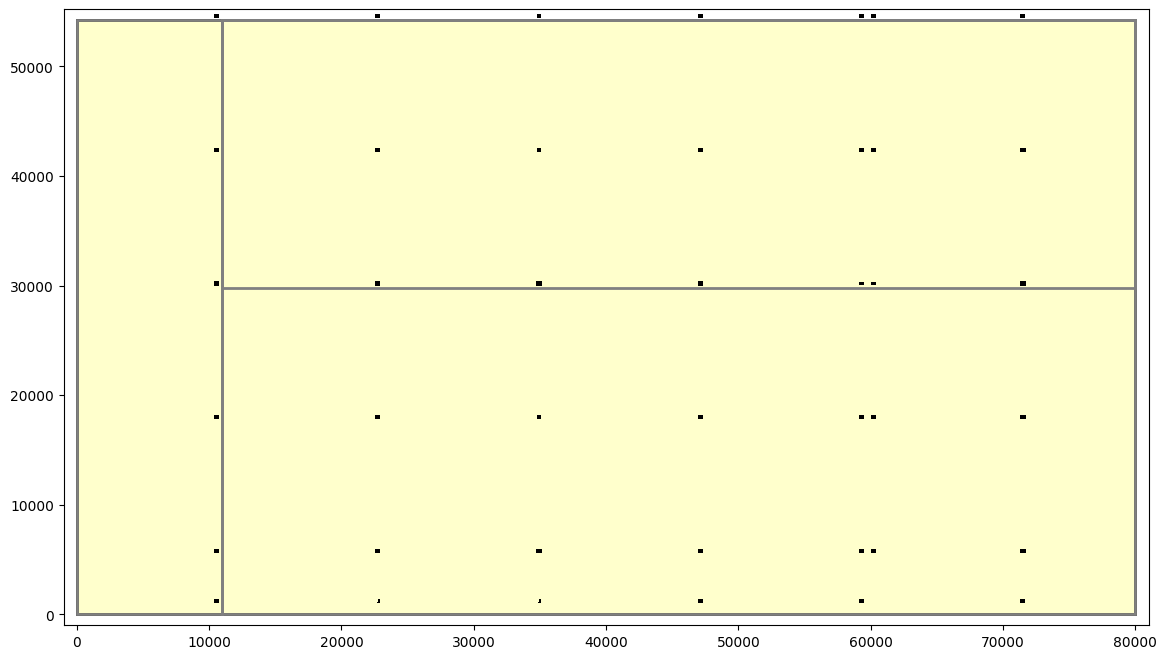

In [366]:
plt_map()

In [367]:
def plt_lay_cluster():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    place_areas=data['placeableAreas']
    fig, ax = plt.subplots(figsize=((Xupper/Xupper)*20, round((Yupper/Xupper)*20,2)))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        

        
#     for area in weight_areas:
#         weight_rect = plt.Rectangle(
#             (area["x"], area["y"]),
#             area["width"],
#             area["height"],
#             linewidth=1,
#             edgecolor='blue',
#             facecolor='blue',
#             alpha=0.4
#         )
#         ax.add_patch(weight_rect)


        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    for area in place_areas:
        pl_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=2,
            edgecolor='gray',
            facecolor='none',
            alpha=1.0
        )     
        ax.add_patch(pl_rect)
    dims_ = {}
    for c in lay_clusters:
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated
        else:
            dims_[c] = (W0[c], H0[c])  # original 

    for c in lay_clusters:
        w, h = dims_[c]
        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

        if df_selected.loc[c,'type']==1:
            if k[c]+o[c]!=1:
                llx = X[c] - w/2
                lly = Y[c] - (h/2)/3
                rect = patches.Rectangle((llx, lly), w, h/3, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)
            else:
                llx = X[c] - (w/2)/3
                lly = Y[c] - h/2
                rect = patches.Rectangle((llx, lly), w/3, h, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

    # 축 범위
    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)


    plt.show()

In [368]:
def plt_lay_cluster_2():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    place_areas=data['placeableAreas']
    fig, ax = plt.subplots(figsize=(12, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        

        
#     for area in weight_areas:
#         weight_rect = plt.Rectangle(
#             (area["x"], area["y"]),
#             area["width"],
#             area["height"],
#             linewidth=1,
#             edgecolor='blue',
#             facecolor='blue',
#             alpha=0.4
#         )
#         ax.add_patch(weight_rect)


        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    for area in place_areas:
        pl_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=2,
            edgecolor='gray',
            facecolor='none',
            alpha=1.0
        )     
        ax.add_patch(pl_rect)
    dims_ = {}
    for c in lay_clusters:
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated
        else:
            dims_[c] = (W0[c], H0[c])  # original 

    for c in lay_clusters:
        if c in pre_C:
            continue
        w, h = dims_[c]
        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

        if df_selected.loc[c,'type']==1:
            if k[c]+o[c]!=1:
                llx = X[c] - w/2
                lly = Y[c] - (h/2)/3
                rect = patches.Rectangle((llx, lly), w, h/3, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)
            else:
                llx = X[c] - (w/2)/3
                lly = Y[c] - h/2
                rect = patches.Rectangle((llx, lly), w/3, h, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

    dims_ = {}
    for c in df_pre.index:


        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            dims_[c] = (df_pre.loc[c,'y'],df_pre.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_pre.loc[c,'x'], df_pre.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_pre.loc[c,'center_X'] - w/2
        lly = df_pre.loc[c,'center_Y'] - h/2
        if "L" in df_pre.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if df_pre.loc[c,'type']==1:
            fs=2
            if w>=h:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,color='blue')
            else:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90,color='blue')
        else:
            fs=2
            if w>=h:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
            else:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)

            
    # 축 범위
    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)


    plt.show()

In [369]:
def plt_bigpath():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    place_areas=data['placeableAreas']
    fig, ax = plt.subplots(figsize=(14, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        

        
#     for area in weight_areas:
#         weight_rect = plt.Rectangle(
#             (area["x"], area["y"]),
#             area["width"],
#             area["height"],
#             linewidth=1,
#             edgecolor='blue',
#             facecolor='blue',
#             alpha=0.4
#         )
#         ax.add_patch(weight_rect)


        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    for area in place_areas:
        pl_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=2,
            edgecolor='gray',
            facecolor='none',
            alpha=1.0
        )     
        ax.add_patch(pl_rect)
    # 축 범위
    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)

    import matplotlib as mpl
    cmap = mpl.colormaps.get_cmap("tab10").resampled(len(big_path))

    for pi, path in enumerate(big_path):
        color = cmap(pi)
        for si, seg in enumerate(path):
            (x1, y1), (x2, y2) = seg
            ax.plot([x1, x2], [y1, y2], linewidth=5, color=color)
            
    RECT_W, RECT_H = 5000, 5000
    half_w, half_h = RECT_W / 2, RECT_H / 2

    for eq_id, (cx, cy) in expected_position.items():
        llx, lly = cx - half_w, cy - half_h  # lower-left
        rect = patches.Rectangle(
            (llx, lly),
            RECT_W,
            RECT_H,
            fill=False,
            linewidth=2,
            edgecolor='black',
            alpha=0.9
        )
        ax.add_patch(rect)

        # (선택) 설비 번호 라벨
        ax.text(cx, cy, str(eq_id), ha='center', va='center', fontsize=12, color='black')
    # ==== big_path 시각화 추가 끝 ====
    plt.show()

In [370]:
place_areas=data['placeableAreas']
place_areas

[{'x': 0, 'y': 0, 'width': 10989, 'height': 54204, 'id': '1'},
 {'x': 10989, 'y': 0, 'width': 69011, 'height': 54204, 'id': '2'},
 {'x': 10989, 'y': 29793, 'width': 69011, 'height': 24411, 'id': '3'}]

In [371]:
place_areas

[{'x': 0, 'y': 0, 'width': 10989, 'height': 54204, 'id': '1'},
 {'x': 10989, 'y': 0, 'width': 69011, 'height': 54204, 'id': '2'},
 {'x': 10989, 'y': 29793, 'width': 69011, 'height': 24411, 'id': '3'}]

In [372]:
place_mezz

{'1': [0], '2': [0], '3': [0]}

In [373]:
place_mezz_height={}
for key,value in place_mezz.items():
    place_mezz_height[key]=[]
    for i in value:
        place_mezz_height[key].append(mezz_areas[i]['ceilingHeight'])

In [374]:
place_mezz_height

{'1': [5], '2': [5], '3': [5]}

In [375]:
mezz_areas

[{'x': 0, 'y': 0, 'width': 80000, 'height': 54204, 'ceilingHeight': 5}]

In [376]:
data['fixedFacilityPositions']

[{'facilityId': 'FAC00317683512501771_0',
  'position': {'x': 1, 'y': 48000},
  'rotation': 0},
 {'facilityId': 'FAC00317683513359952_0',
  'position': {'x': 1, 'y': 23000},
  'rotation': 0}]

In [377]:
pre_X

array([51., 51.])

In [378]:
pre_Ro

array([1, 1])

In [379]:
pre_C

array([6, 7])

In [380]:
total_expand

{1: [0, 0, 1, 0],
 2: [1, 0, 0, 0],
 3: [1, 1, 0, 0],
 4: [0, 0, 1, 0],
 5: [1, 1, 0, 0],
 7: [1, 0, 0, 0]}

In [381]:
df_selected.loc[0,'pathWidth']

np.int64(2522)

In [382]:
lay_clusters=[]
o={}
di={}
X={}
Y={}
for i in range(len(pre_C)):
    
    if pre_Ro[i]==1:
        o[pre_C[i]]=0
        di[pre_C[i]]=0
    elif pre_Bo[i]==1:
        o[pre_C[i]]=1
        di[pre_C[i]]=0
    elif pre_Lo[i]==1:
        o[pre_C[i]]=0
        di[pre_C[i]]=1
    else:
        o[pre_C[i]]=1
        di[pre_C[i]]=1
    if (df_selected.loc[pre_C[i],'type']=='production') and (df_selected.loc[pre_C[i],'processGroup']!='dock'):
        if total_expand[pre_C[i]][1]==0:
            X[pre_C[i]]=pre_X[i]
        else:
            X[pre_C[i]]=pre_X[i]-df_selected.loc[pre_C[i],'pathWidth']
            
        if total_expand[pre_C[i]][3]==0:
            Y[pre_C[i]]=pre_Y[i]
        else:
            Y[pre_C[i]]=pre_Y[i]-df_selected.loc[pre_C[i],'pathWidth']      
    else:
        X[pre_C[i]]=pre_X[i]
        Y[pre_C[i]]=pre_Y[i]
    lay_clusters.append(pre_C[i])

In [383]:
pre_C

array([6, 7])

In [384]:
pre_Ro

array([1, 1])

In [385]:
W0 = {i: float(val) for i, val in enumerate(cluster_x_array)}
H0 = {i: float(val) for i, val in enumerate(cluster_y_array)}

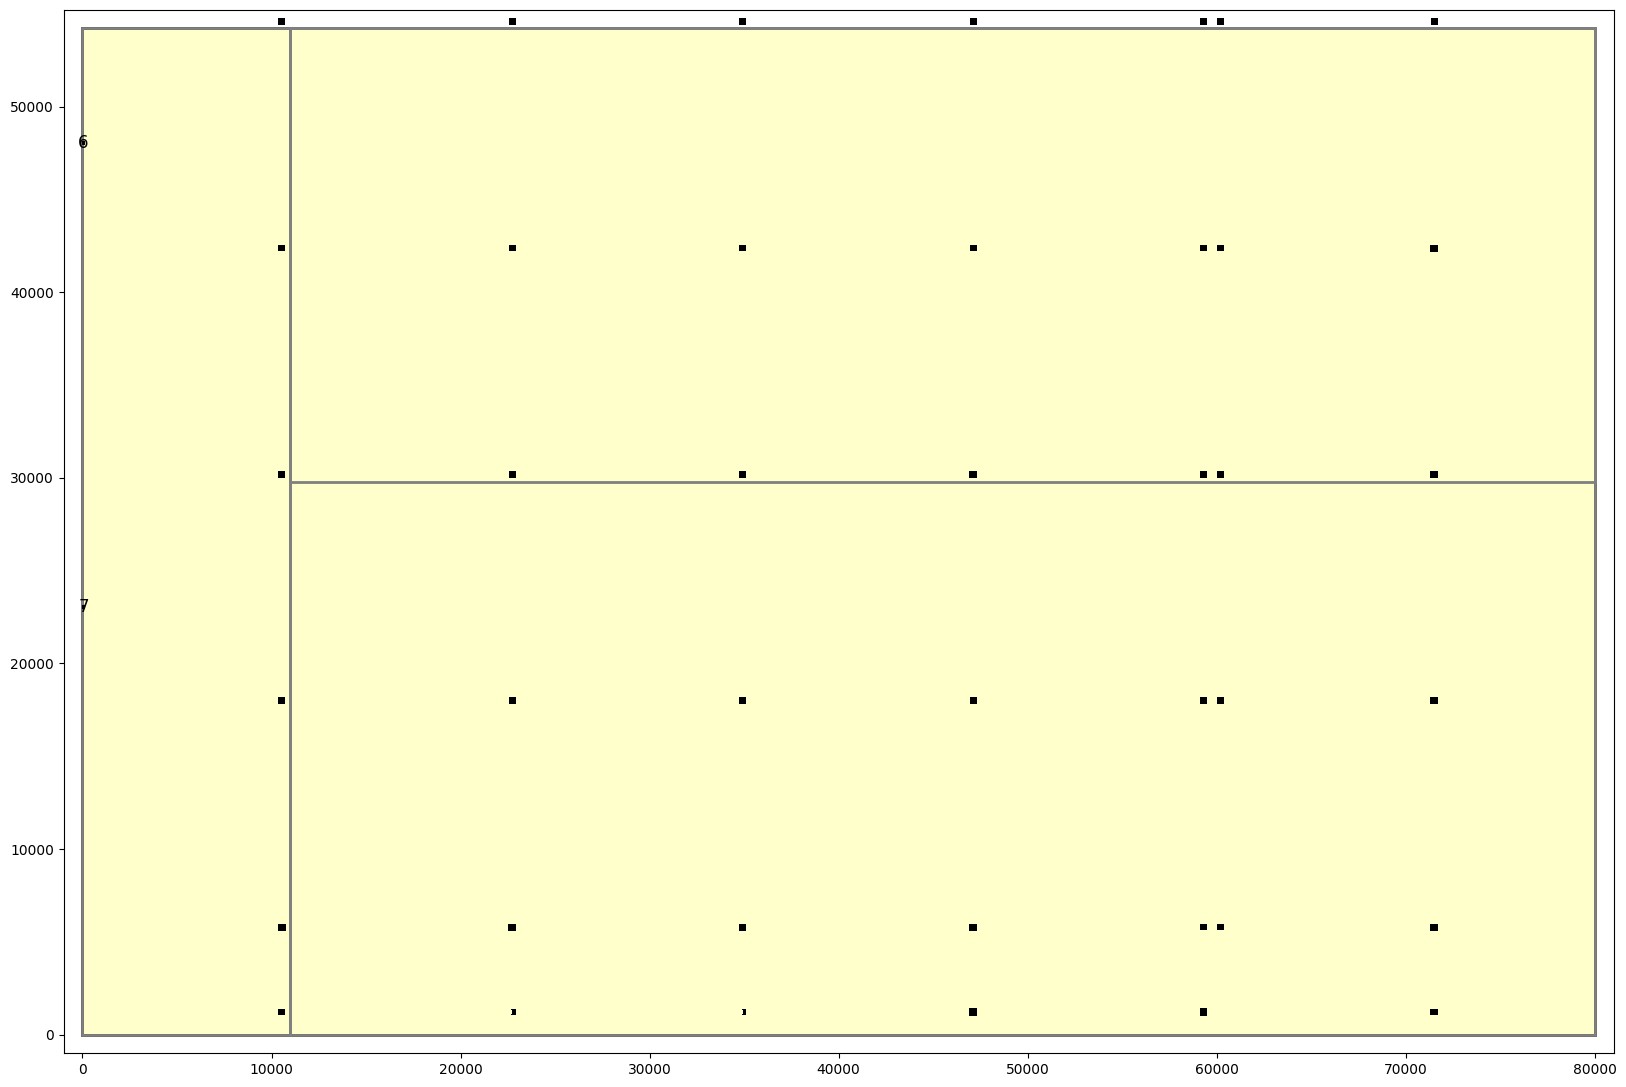

In [386]:
plt_lay_cluster()

In [387]:
def cluster_feasibility(c,X_ck,Y_ck,ro_ck,cl_ck,x_ck,y_ck):

    #red_zon feasibility 검사
    for r in range(len(restricted_areas)):
        feasible=False
        
        x_uni=(restricted_areas[r]["x"],restricted_areas[r]["x"]+restricted_areas[r]["width"])
        y_uni=(restricted_areas[r]["y"],restricted_areas[r]["y"]+restricted_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]+1500<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]-1500>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]+1500<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]-1500>max(y_uni):
            feasible=True


        if feasible==False:
            return feasible
        
    for r in range(len(mezz_areas)):
        
        if df_selected.loc[c,'facilityHeight']<=mezz_areas[r]['ceilingHeight']:
            continue
            
        feasible=False
        
        x_uni=(mezz_areas[r]["x"],mezz_areas[r]["x"]+mezz_areas[r]["width"])
        y_uni=(mezz_areas[r]["y"],mezz_areas[r]["y"]+mezz_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            return feasible 
    place_areas_cluster=[item for item in place_areas if item['id'] == df_selected.loc[c,'placeable']]
   
    for r in range(len(place_areas_cluster)):
        if r==0:
            feasible=True
        else:
            if feasible==True:
                break
            else:
                feasible=True
            
        x_uni=(place_areas_cluster[r]["x"],place_areas_cluster[r]["x"]+place_areas_cluster[r]["width"])
        y_uni=(place_areas_cluster[r]["y"],place_areas_cluster[r]["y"]+place_areas_cluster[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False
            


    if feasible==False:
        return feasible 
    
    for r in range(len(weight_areas)):
        
        if df_selected.loc[c,'facilityWeight']<=data['factoryDimensions']['weight']:
            continue
            
        feasible=True
        
        x_uni=(weight_areas[r]["x"],weight_areas[r]["x"]+weight_areas[r]["width"])
        y_uni=(weight_areas[r]["y"],weight_areas[r]["y"]+weight_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            return feasible             

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            return feasible           


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            return feasible             


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False
            return feasible 
    #dry 설비 dry존 내에 배치
    for r in range(len(dry_areas)):
        
        if df_selected.loc[c,'dry']>dry_areas[r]['value']:
            continue
            
        feasible=True
        
        x_uni=(weight_areas[r]["x"],weight_areas[r]["x"]+weight_areas[r]["width"])
        y_uni=(weight_areas[r]["y"],weight_areas[r]["y"]+weight_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            return feasible             

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            return feasible           


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            return feasible             


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False
            return feasible 
        
    #dry 설비가 아닌 경우 dry존 밖에 배치
    for r in range(len(dry_areas)):
        
        if df_selected.loc[c,'dry']<=dry_areas[r]['value']:
            continue
            
        feasible=False
        
        x_uni=(dry_areas[r]["x"],dry_areas[r]["x"]+dry_areas[r]["width"])
        y_uni=(dry_areas[r]["y"],dry_areas[r]["y"]+dry_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            return feasible         
        
        
    for c_p,x_p in X_ck.items():
        x_uni=[x_p-ro_ck[c_p][0]/2-cl_ck[c_p][0],x_p+ro_ck[c_p][0]/2+cl_ck[c_p][2]]
        y_uni=[Y_ck[c_p]-ro_ck[c_p][1]/2-cl_ck[c_p][1],Y_ck[c_p]+ro_ck[c_p][1]/2+cl_ck[c_p][3]]
        feasible=False

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible
        
        
        
    return feasible

In [388]:
def direction(rotate,di,width_O,height_O,df_selected):
    dims = {}
    cl_ck={}
    for c in rotate.keys():
        if rotate[c] == 1:
            dims[c] = (height_O[c], width_O[c])  # rotated
        else:
            dims[c] = (width_O[c], height_O[c])  # original
            
    for c in rotate.keys():
        if rotate[c] == 0 and di[c]==0:
            cl_ck[c] = (df_selected.loc[c,'cluster_UR'], df_selected.loc[c,'cluster_UB'],df_selected.loc[c,'cluster_UL'],df_selected.loc[c,'cluster_UA'])  # rotated
        elif rotate[c] == 1 and di[c]==1:
            cl_ck[c] = ( df_selected.loc[c,'cluster_UB'],df_selected.loc[c,'cluster_UL'],df_selected.loc[c,'cluster_UA'],df_selected.loc[c,'cluster_UR'])  # rotated
        elif rotate[c] == 0 and di[c]==1:
            cl_ck[c] = ( df_selected.loc[c,'cluster_UL'],df_selected.loc[c,'cluster_UA'],df_selected.loc[c,'cluster_UR'],df_selected.loc[c,'cluster_UB'])  # rotated
        else:
            cl_ck[c] = ( df_selected.loc[c,'cluster_UA'],df_selected.loc[c,'cluster_UR'],df_selected.loc[c,'cluster_UB'],df_selected.loc[c,'cluster_UL'])  # rotated
    return dims,cl_ck


# c=10
# x_ck=5050.0
# y_ck=99050.0
# ro_ck,cl_ck=direction(o,W0,H0)
# fe=cluster_feasibility(c,X,Y,ro_ck,cl_ck,x_ck,y_ck)
# fe

In [389]:
k={}
for c in df_selected.index:
    if c not in total_expand.keys():
        if df_selected.loc[c,'x']<=df_selected.loc[c,'y']:
            k[c]=0
        else:
            k[c]=1
    else:
        if (total_expand[c][0]+total_expand[c][1]>=1):
            k[c]=1
        else:
            k[c]=0

In [390]:
k_cluster={}
for c in df_selected.index:
    k_cluster[c]={}
    if k[c]==0:
        k_cluster[c]['x']=df_selected.loc[c,'설비수량']
        k_cluster[c]['y']=1
    else:
        k_cluster[c]['y']=df_selected.loc[c,'설비수량']
        k_cluster[c]['x']=1    

In [391]:
a_s_dic={}
b_s_dic={}
c_s_dic={}
d_s_dic={}
f_s_dic={}
for i in range(len(C_s)):
    a_s_dic[C_s[i]]=a_s[i]
    b_s_dic[C_s[i]]=b_s[i]
    c_s_dic[C_s[i]]=c_s[i]
    d_s_dic[C_s[i]]=d_s[i]
    f_s_dic[C_s[i]]=f_s[i]

In [392]:
s_he_na

{}

In [393]:
pl_di={}
for p in range(len(place_areas)):
    print(place_areas[p])
    left_x_pl=-9999999999
    right_x_pl=9999999999
    bottom_y_pl=-9999999999
    upper_y_pl=9999999999
    pl_d=[0,0,0,0]
    for p_2 in range(len(place_areas)):
        if p_2 == p:
            continue
        if place_areas[p_2]['x']>left_x_pl:
            left_x_pl=place_areas[p_2]['x']
        if place_areas[p_2]['x']+place_areas[p_2]['width']<right_x_pl:
            right_x_pl=place_areas[p_2]['x']+place_areas[p_2]['width']
        if place_areas[p_2]['y']>bottom_y_pl:
            bottom_y_pl=place_areas[p_2]['y']
        if place_areas[p_2]['y']+place_areas[p_2]['height']<upper_y_pl:
            upper_y_pl=place_areas[p_2]['y']+place_areas[p_2]['height']
    if right_x_pl-place_areas[p]['x']<=(place_areas[p]['x']+place_areas[p]['width'])-left_x_pl:
        pl_d[0]=1
    else:
        pl_d[1]=1
        
    if upper_y_pl-place_areas[p]['y']<=(place_areas[p]['y']+place_areas[p]['height'])-bottom_y_pl:
        pl_d[2]=1
    else:
        pl_d[3]=1
    pl_di[place_areas[p]['id']]=pl_d

pl_di[None]=[1,0,1,0]



{'x': 0, 'y': 0, 'width': 10989, 'height': 54204, 'id': '1'}
{'x': 10989, 'y': 0, 'width': 69011, 'height': 54204, 'id': '2'}
{'x': 10989, 'y': 29793, 'width': 69011, 'height': 24411, 'id': '3'}


In [394]:
s_x_t={}
s_y_t={}
for key,value in place_mezz.items():
    lay=[]
    lay_2=[]
    lay_s=[]
    if len(df_selected[(df_selected['placeable']==key) &(df_selected['type']=='storage')])!=0:
        lay_s=df_selected[(df_selected['placeable']==key) &(df_selected['type']=='storage')].index    
    if len(df_selected[(df_selected['placeable']==key) &(df_selected['facilityHeight']<=min(place_mezz_height[key]))&(df_selected['type']!='storage')])!=0:
        lay_2=df_selected[(df_selected['placeable']==key) &(df_selected['facilityHeight']<=min(place_mezz_height[key]))&(df_selected['type']!='storage')].index
    if len(df_selected[(df_selected['placeable']==key) &(df_selected['facilityHeight']>min(place_mezz_height[key]))&(df_selected['type']!='storage')])!=0:
        lay=df_selected[(df_selected['placeable']==key) &(df_selected['facilityHeight']>min(place_mezz_height[key]))&(df_selected['type']!='storage')].index
        


In [395]:
prior_lay_en=[]
prior_lay_ex=[]
for ke,va in X.items():
    for i in group_matrix[group_matrix.iloc[ke]==1].index:
        for j in df_selected[df_selected['설비Group']==i].index:
            prior_lay_en.append(j)

    for i in group_matrix[group_matrix.iloc[:,ke]==1].index:
        for j in df_selected[df_selected['설비Group']==i].index:
            prior_lay_ex.append(j)
print(prior_lay_en)
print(prior_lay_ex)


[2]
[4]


In [396]:
def cal_enex(X):
    enex={}
    for ke,va in X.items():
        enex[ke]={}
        ori_en_x=df_selected.loc[ke,'ent_X']-df_selected.loc[ke,'x']/2
        ori_en_y=df_selected.loc[ke,'ent_Y']-df_selected.loc[ke,'y']/2
        ori_ex_x=df_selected.loc[ke,'exi_X']-df_selected.loc[ke,'x']/2
        ori_ex_y=df_selected.loc[ke,'exi_Y']-df_selected.loc[ke,'y']/2
        if o[ke] ==1:
            w=W0[ke]
            h=H0[ke]
        else:
            w=H0[ke]
            h=W0[ke]
        if o[ke]==0 and di[ke]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y

        elif o[ke]==1 and di[ke]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 

        elif o[ke]==0 and di[ke]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y

        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x     
        enex[ke]['en_x']=X[ke]+en_x
        enex[ke]['en_y']=Y[ke]+en_y
        enex[ke]['ex_x']=X[ke]+ex_x
        enex[ke]['ex_y']=Y[ke]+ex_y
    return enex



In [397]:
def cal_S_en(totalSol):
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    enex={}
    for ke,va in X.items():
        enex[ke]={}
        ori_en_x=df_selected.loc[ke,'ent_X']-df_selected.loc[ke,'x']/2
        ori_en_y=df_selected.loc[ke,'ent_Y']-df_selected.loc[ke,'y']/2
        ori_ex_x=df_selected.loc[ke,'exi_X']-df_selected.loc[ke,'x']/2
        ori_ex_y=df_selected.loc[ke,'exi_Y']-df_selected.loc[ke,'y']/2
        if o[ke] ==1:
            w=W0[ke]
            h=H0[ke]
        else:
            w=H0[ke]
            h=W0[ke]
        if o[ke]==0 and di[ke]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y

        elif o[ke]==1 and di[ke]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 

        elif o[ke]==0 and di[ke]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y

        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x     
        enex[ke]['en_x']=X[ke]+en_x
        enex[ke]['en_y']=Y[ke]+en_y
        enex[ke]['ex_x']=X[ke]+ex_x
        enex[ke]['ex_y']=Y[ke]+ex_y
    return enex

In [398]:
def cal_obj(totalSol):
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    enex=cal_S_en(totalSol)
    distance_k=0
    ro,cl_ck=direction(o,di,W0,H0,df_selected)
    max_x_=-99999999
    min_x_=99999999
    max_y_=-99999999
    min_y_=99999999
    for c in X.keys():
        
        for d in X.keys():
            
            g1 = df_selected.loc[c, '설비Group']
            g2 = df_selected.loc[d, '설비Group']

            val = group_matrix.loc[g1, g2]

            # 🧩 val이 Series나 DataFrame인 경우 첫 값만 사용
            if isinstance(val, pd.Series):
                val = val.iloc[0]
            elif isinstance(val, pd.DataFrame):
                val = val.iloc[0, 0]

            # 이제 val은 스칼라(int)라서 안전하게 비교 가능
            if val == 1:
                if (df_selected.loc[c,'type']!='storage')&(df_selected.loc[d,'type']!='storage'):
                    distance_k+=abs(enex[c]['ex_x']-enex[d]['en_x'])+abs(enex[c]['ex_y']-enex[d]['en_y'])
                else:
                    if (df_selected.loc[c,'type']=='storage')&(df_selected.loc[d,'type']=='storage'):
                        max_dx=max(abs(X[c]-ro[c][0]/2-(X[d]+ro[d][0]/2)),abs(X[c]+ro[c][0]/2-(X[d]-ro[d][0]/2)))
                        max_dy=max(abs(Y[c]-ro[c][1]/2-(Y[d]+ro[d][1]/2)),abs(Y[c]+ro[c][1]/2-(Y[d]-ro[d][1]/2)))
                        distance_k+=max(max_dx-(ro[c][0]+ro[c][0]),0)+max(max_dy-(ro[c][1]+ro[c][1]),0)
                    else:
                        if (df_selected.loc[c,'type']!='storage'):
                            max_dx=max(abs(enex[c]['ex_x']-(X[d]+ro[d][0]/2)),abs(enex[c]['ex_x']-(X[d]-ro[d][0]/2)))
                            max_dy=max(abs(enex[c]['ex_y']-(Y[d]+ro[d][1]/2)),abs(enex[c]['ex_y']-(Y[d]-ro[d][1]/2)))
                            distance_k+=max(max_dx-(ro[d][0]),0)+max(max_dy-(ro[d][1]),0)    

                        else:
                            max_dx=max(abs(X[c]-ro[c][0]/2-(enex[d]['en_x'])),abs(X[c]+ro[c][0]/2-(enex[d]['en_x'])))
                            max_dy=max(abs(Y[c]-ro[c][1]/2-(enex[d]['en_y'])),abs(Y[c]+ro[c][1]/2-(enex[d]['en_y'])))
                            distance_k+=max(max_dx-(ro[c][0]),0)+max(max_dy-(ro[c][1]),0)    
        if df_selected.loc[c,'processGroup']!='dock':
            if X[c]-ro[c][0]/2<min_x_:
                min_x_=X[c]-ro[c][0]/2
            if Y[c]-ro[c][1]/2<min_y_:
                min_y_=Y[c]-ro[c][1]/2      
            if X[c]+ro[c][0]/2>max_x_:
                max_x_=X[c]+ro[c][0]/2
            if Y[c]+ro[c][1]/2>max_y_:
                max_y_=Y[c]+ro[c][1]/2     
    total_obj=distance_k+0.5*(max_x_-min_x_+max_y_-min_y_)
    #total_obj=distance_k
    return total_obj

In [399]:

def cal_distance(s,c):
    X,Y,o,di=s

 
    distance_k=0
    PENALTWEIGHT=5
    for d,va in X.items():
        position_penalty=0
        if df_selected.loc[c,'설비Group'] in group_matrix.columns[group_matrix.iloc[d]==1]:

            if (df_selected.loc[c,'type']!='storage')&(df_selected.loc[d,'type']!='storage'):
                distance_k+=abs(enex[c]['en_x']-enex[d]['ex_x'])+abs(enex[c]['en_y']-enex[d]['ex_y'])
            else:

                if (df_selected.loc[c,'type']=='storage')&(df_selected.loc[d,'type']=='storage'):
                    max_dx=max(abs(X[c]-ro[c][0]/2-(X[d]+ro[d][0]/2)),abs(X[c]+ro[c][0]/2-(X[d]-ro[d][0]/2)))
                    max_dy=max(abs(Y[c]-ro[c][1]/2-(Y[d]+ro[d][1]/2)),abs(Y[c]+ro[c][1]/2-(Y[d]-ro[d][1]/2)))
                    distance_k+=max(max_dx-(ro[c][0]+ro[d][0]),0)+max(max_dy-(ro[c][1]+ro[d][1]),0)
                else:
                    if (df_selected.loc[c,'type']!='storage'):
                        max_dx=max(abs(enex[c]['en_x']-(X[d]+ro[d][0]/2)),abs(enex[c]['en_x']-(X[d]-ro[d][0]/2)))
                        max_dy=max(abs(enex[c]['en_y']-(Y[d]+ro[d][1]/2)),abs(enex[c]['en_y']-(Y[d]-ro[d][1]/2)))
                        distance_k+=max(max_dx-(ro[d][0]),0)+max(max_dy-(ro[d][1]),0)    

                    else:
                        max_dx=max(abs(X[c]-ro[c][0]/2-(enex[d]['ex_x'])),abs(X[c]+ro[c][0]/2-(enex[d]['ex_x'])))
                        max_dy=max(abs(Y[c]-ro[c][1]/2-(enex[d]['ex_y'])),abs(Y[c]+ro[c][1]/2-(enex[d]['ex_y'])))
                        distance_k+=max(max_dx-(ro[c][0]),0)+max(max_dy-(ro[c][1]),0)   
        if df_selected.loc[c,'설비Group'] in group_matrix[group_matrix.iloc[:,d]==1].index:
            position_penalty=0
            if d in enex.keys():
                if (df_selected.loc[c,'type']!='storage')&(df_selected.loc[d,'type']!='storage'):
                    if direc[c]==1:
                        position_penalty=max(enex[d]['en_x']-enex[c]['ex_x'],0)*PENALTWEIGHT
                    elif direc[c]==2:  
                        position_penalty=max(enex[c]['ex_x']-enex[d]['en_x'],0)*PENALTWEIGHT
                    elif direc[c]==3:
                        position_penalty=max(enex[d]['en_y']-enex[c]['ex_y'],0)*PENALTWEIGHT
                    else:
                        position_penalty=max(enex[c]['ex_x']-enex[d]['en_y'],0)*PENALTWEIGHT
                else:
                    if (df_selected.loc[c,'type']=='storage')&(df_selected.loc[d,'type']=='storage'):
                        if direc[c]==1:
                            position_penalty=max(-(X[c]+ro[c][0]/2-(X[d]-ro[d][0]/2)),0)*PENALTWEIGHT
                        elif direc[c]==2:  
                            position_penalty=max((X[c]+ro[c][0]/2-(X[d]-ro[d][0]/2)),0)*PENALTWEIGHT
                        elif direc[c]==3:
                            position_penalty=max(-(Y[c]+ro[c][1]/2-(Y[d]-ro[d][1]/2)),0)*PENALTWEIGHT
                        else:
                            position_penalty=max((Y[c]+ro[c][1]/2-(Y[d]-ro[d][1]/2)),0)*PENALTWEIGHT
                    else:
                        if (df_selected.loc[c,'type']!='storage'):  
                            if direc[c]==1:
                                position_penalty=max(-(X[c]+ro[c][0]/2-(enex[d]['en_x'])),0)*PENALTWEIGHT
                            elif direc[c]==2:  
                                position_penalty=max((X[c]+ro[c][0]/2-(enex[d]['en_x'])),0)*PENALTWEIGHT
                            elif direc[c]==3:
                                position_penalty=max(-(Y[c]+ro[c][1]/2-(enex[d]['en_y'])),0)*PENALTWEIGHT
                            else:
                                position_penalty=max((Y[c]+ro[c][1]/2-(enex[d]['en_y'])),0)*PENALTWEIGHT                            
                        else:
                            if direc[c]==1:
                                position_penalty=max(-(enex[c]['ex_x']-(X[d]-ro[d][0]/2)),0)*PENALTWEIGHT
                            elif direc[c]==2:  
                                position_penalty=max((enex[c]['ex_x']-(X[d]-ro[d][0]/2)),0)*PENALTWEIGHT
                            elif direc[c]==3:
                                position_penalty=max(-(enex[c]['ex_y']-(Y[d]-ro[d][1]/2)),0)*PENALTWEIGHT
                            else:
                                position_penalty=max((enex[c]['ex_y']-(Y[d]-ro[d][1]/2)),0)*PENALTWEIGHT                            
                distance_k+=position_penalty
                
    if direc[c]==1:
        penalty=max(expected_position[c][0]-X[c],0)*PENALTWEIGHT
    elif direc[c]==2:
        penalty=max(X[c]-expected_position[c][0],0)*PENALTWEIGHT
    elif direc[c]==3:
        penalty=max(expected_position[c][1]-Y[c],0)*PENALTWEIGHT
    else:
        penalty=max(Y[c]-expected_position[c][1],0)*PENALTWEIGHT

    distance_k+=penalty
    
    return distance_k

# enex=cal_enex(X)
# distance_k=cal_distance(c,o,di,x,y)

# distance_k

In [400]:
# X[9]=55000
# Y[9]=20000
# c=9
# distance_k=cal_distance(s,c)

# distance_k

In [401]:
def manhattan_avoid_rects_simple(c,o,di,x,y,return_path=False):
    
    ro_ck,cl_ck=direction(o,di,W0,H0,df_selected)
    
    ori_en_x=df_selected.loc[c,'ent_X']-df_selected.loc[c,'x']/2
    ori_en_y=df_selected.loc[c,'ent_Y']-df_selected.loc[c,'y']/2
    ori_ex_x=df_selected.loc[c,'exi_X']-df_selected.loc[c,'x']/2
    ori_ex_y=df_selected.loc[c,'exi_Y']-df_selected.loc[c,'y']/2
    if o[c] ==1:
        w=W0[c]
        h=H0[c]
    else:
        w=H0[c]
        h=W0[c]
    if o[c]==0 and di[c]==0:
        en_x=ori_en_x
        en_y=ori_en_y
        ex_x=ori_ex_x
        ex_y=ori_ex_y

    elif o[c]==1 and di[c]==0:
        en_x=ori_en_y
        en_y=-ori_en_x
        ex_x=ori_ex_y
        ex_y=-ori_ex_x 

    elif o[c]==0 and di[c]==1:
        en_x=-ori_en_x
        en_y=-ori_en_y
        ex_x=-ori_ex_x
        ex_y=-ori_ex_y

    else:
        en_x=-ori_en_y
        en_y=ori_en_x
        ex_x=-ori_ex_y
        ex_y=ori_ex_x  
    start=(x+en_x,y+en_y)
    goal=None
    for ke,va in X.items():
        if df_selected.loc[c,'설비Group'] in group_matrix.columns[group_matrix.iloc[ke]==1]:
            goal=(enex[ke]['ex_x'],enex[ke]['ex_y'])
            break
    if goal==None:
        return 0
    
        
    rects = []
    for k, (w, h) in ro_ck.items():
        cx, cy = X[k], Y[k]
        rects.append((cx - w/2, cx + w/2, cy - h/2, cy + h/2))

    # 2) 후보 노드: start, goal, 모든 코너
    nodes = [start, goal]
    for xmin, xmax, ymin, ymax in rects:
        nodes += [(xmin, ymin), (xmin, ymax), (xmax, ymin), (xmax, ymax)]

    # 중복 제거
    nodes = list(dict.fromkeys(nodes))
    n = len(nodes)

    def open_overlap(a1, a2, b1, b2):
        lo = max(min(a1, a2), min(b1, b2))
        hi = min(max(a1, a2), max(b1, b2))
        return lo < hi  # "열린 구간" 겹침(경계만 닿는 건 False)

    # p->q(수평/수직) 직선이 장애물 "내부"를 관통하면 막힘. 경계는 허용.
    def blocked(p, q):
        x1, y1 = p
        x2, y2 = q
        if x1 == x2:  # vertical
            x = x1
            for xmin, xmax, ymin, ymax in rects:
                if xmin < x < xmax and open_overlap(y1, y2, ymin, ymax):
                    return True
            return False
        if y1 == y2:  # horizontal
            y = y1
            for xmin, xmax, ymin, ymax in rects:
                if ymin < y < ymax and open_overlap(x1, x2, xmin, xmax):
                    return True
            return False
        raise ValueError("이 함수는 수평/수직 구간만 처리")

    # 3) 같은 x / 같은 y에서 인접한 점만 연결 (빠름)
    adj = [[] for _ in range(n)]

    x_groups, y_groups = {}, {}
    for i, (x, y) in enumerate(nodes):
        x_groups.setdefault(x, []).append(i)
        y_groups.setdefault(y, []).append(i)

    def connect(a, b):
        p, q = nodes[a], nodes[b]
        if blocked(p, q): 
            return
        w = abs(p[0]-q[0]) + abs(p[1]-q[1])
        adj[a].append((b, w))
        adj[b].append((a, w))

    for x, idxs in x_groups.items():
        idxs.sort(key=lambda i: nodes[i][1])
        for a, b in zip(idxs, idxs[1:]):
            connect(a, b)

    for y, idxs in y_groups.items():
        idxs.sort(key=lambda i: nodes[i][0])
        for a, b in zip(idxs, idxs[1:]):
            connect(a, b)

    # 4) 다익스트라
    s, t = 0, 1
    dist = [inf]*n
    prev = [-1]*n
    dist[s] = 0
    pq = [(0, s)]

    while pq:
        d, u = heappop(pq)
        if d != dist[u]:
            continue
        if u == t:
            break
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heappush(pq, (nd, v))

    if not return_path:
        return dist[t]

    if dist[t] == inf:
        return inf, None

    path = []
    cur = t
    while cur != -1:
        path.append(nodes[cur])
        cur = prev[cur]
    path.reverse()
    return dist[t], path

In [402]:
pa_bound={}
for key,value in place_mezz.items():
    pa_bound[key]={}
    pa_bound[key]['minX']=9999999999999
    pa_bound[key]['maxX']=-9999999999999
    pa_bound[key]['minY']=9999999999999
    pa_bound[key]['maxY']=-9999999999999
    for pa in place_areas:
        if pa['id']==key:
            if pa['x']<=pa_bound[key]['minX']:
                pa_bound[key]['minX']=pa['x']
            if pa['x']+pa['width']>=pa_bound[key]['maxX']:
                pa_bound[key]['maxX']=pa['x']+pa['width']               
            if pa['y']<=pa_bound[key]['minY']:
                pa_bound[key]['minY']=pa['y']
            if pa['y']+pa['height']>=pa_bound[key]['maxY']:
                pa_bound[key]['maxY']=pa['y']+pa['height']  
pa_bound[None]={}
pa_bound[None]['minX']=Xunder
pa_bound[None]['maxX']=Xupper
pa_bound[None]['minY']=Yunder
pa_bound[None]['maxY']=Yupper


In [403]:
def is_feasible(totalSol,c):
    X_ck,Y_ck,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)

    x_ck=X_ck[c]
    y_ck=Y_ck[c]
    ro_ck,cl_ck=direction(o,di,W0,H0,df_selected)
    


            
    feasible=True


    if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>Xupper:
        feasible=False
        return feasible,None            

    if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<Xunder:
        feasible=False
        return feasible,None           


    if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>Yupper:
        feasible=False
        return feasible,None            


    if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<Yunder:
        feasible=False

        return feasible,None
    
    #red_zon feasibility 검사
    for r in range(len(restricted_areas)):
        feasible=False
        
        x_uni=(restricted_areas[r]["x"],restricted_areas[r]["x"]+restricted_areas[r]["width"])
        y_uni=(restricted_areas[r]["y"],restricted_areas[r]["y"]+restricted_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
        
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            
            return feasible,None
    
    for r in range(len(mezz_areas)):
        

        if df_selected.loc[c,'facilityHeight']<=mezz_areas[r]['ceilingHeight']:
            continue

        feasible=False
        
        x_uni=(mezz_areas[r]["x"],mezz_areas[r]["x"]+mezz_areas[r]["width"])
        y_uni=(mezz_areas[r]["y"],mezz_areas[r]["y"]+mezz_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            return feasible,None
    place_areas_cluster=[item for item in place_areas if item['id'] == df_selected.loc[c,'placeable']]
    
    for r in range(len(place_areas_cluster)):
        if r==0:
            feasible=True
        else:
            if feasible==True:
                break
            else:
                feasible=True
            
        x_uni=(place_areas_cluster[r]["x"],place_areas_cluster[r]["x"]+place_areas_cluster[r]["width"])
        y_uni=(place_areas_cluster[r]["y"],place_areas_cluster[r]["y"]+place_areas_cluster[r]["height"])

#         if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
#             feasible=False
            

#         if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
#             feasible=False
            


#         if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
#             feasible=False
            


#         if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
#             feasible=False
            
        if x_ck+ro_ck[c][0]/2>max(x_uni):
            feasible=False
            

        if x_ck-ro_ck[c][0]/2<min(x_uni):
            feasible=False
            


        if y_ck+ro_ck[c][1]/2>max(y_uni):
            feasible=False
            


        if y_ck-ro_ck[c][1]/2<min(y_uni):
            feasible=False            


    if feasible==False:
        return feasible,None
    
    for r in range(len(weight_areas)):
        
        if df_selected.loc[c,'facilityWeight']<=data['factoryDimensions']['weight']:
            continue
            
        feasible=True
        
        x_uni=(weight_areas[r]["x"],weight_areas[r]["x"]+weight_areas[r]["width"])
        y_uni=(weight_areas[r]["y"],weight_areas[r]["y"]+weight_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            return feasible,None            

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            return feasible,None           


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            return feasible,None            


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False

            return feasible,None
            
    
    #dry 설비 dry존 내에 배치
    for r in range(len(dry_areas)):
        
        if df_selected.loc[c,'dry']>dry_areas[r]['value']:
            
            continue
            
        feasible=True
        
        x_uni=(dry_areas[r]["x"],dry_areas[r]["x"]+dry_areas[r]["width"])
        y_uni=(dry_areas[r]["y"],dry_areas[r]["y"]+dry_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            
            return feasible,None            

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            
            return feasible,None          


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            
            return feasible,None             


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False
            return feasible,None
        
    #dry 설비가 아닌 경우 dry존 밖에 배치
    for r in range(len(dry_areas)):
        
        if df_selected.loc[c,'dry']<=dry_areas[r]['value']:
            
            continue
            
        feasible=False
        
        x_uni=(dry_areas[r]["x"],dry_areas[r]["x"]+dry_areas[r]["width"])
        y_uni=(dry_areas[r]["y"],dry_areas[r]["y"]+dry_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            
            return feasible,None     
        
    
    for c_p,x_p in X_ck.items():
        if c_p==c:
            continue
            
        x_uni=[x_p-ro_ck[c_p][0]/2,x_p+ro_ck[c_p][0]/2]
        y_uni=[Y_ck[c_p]-ro_ck[c_p][1]/2,Y_ck[c_p]+ro_ck[c_p][1]/2]
        feasible=False

        if x_ck+ro_ck[c][0]/2+max(cl_ck[c][0],cl_ck[c_p][2])<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-max(cl_ck[c][2],cl_ck[c_p][0])>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+max(cl_ck[c][3],cl_ck[c_p][1])<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-max(cl_ck[c][1],cl_ck[c_p][3])>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible,c_p
        
        
        
    return feasible,None

In [404]:
# c=9
# o[c]=0
# W0[c]=25920 
# H0[c]=30720
# X[c]=242000
# Y[c]=83000
# s=(X,Y,o,di)
# fe,_=is_feasible(s,c)
# dis=cal_distance(s,c)
# print(fe)
# print(dis)

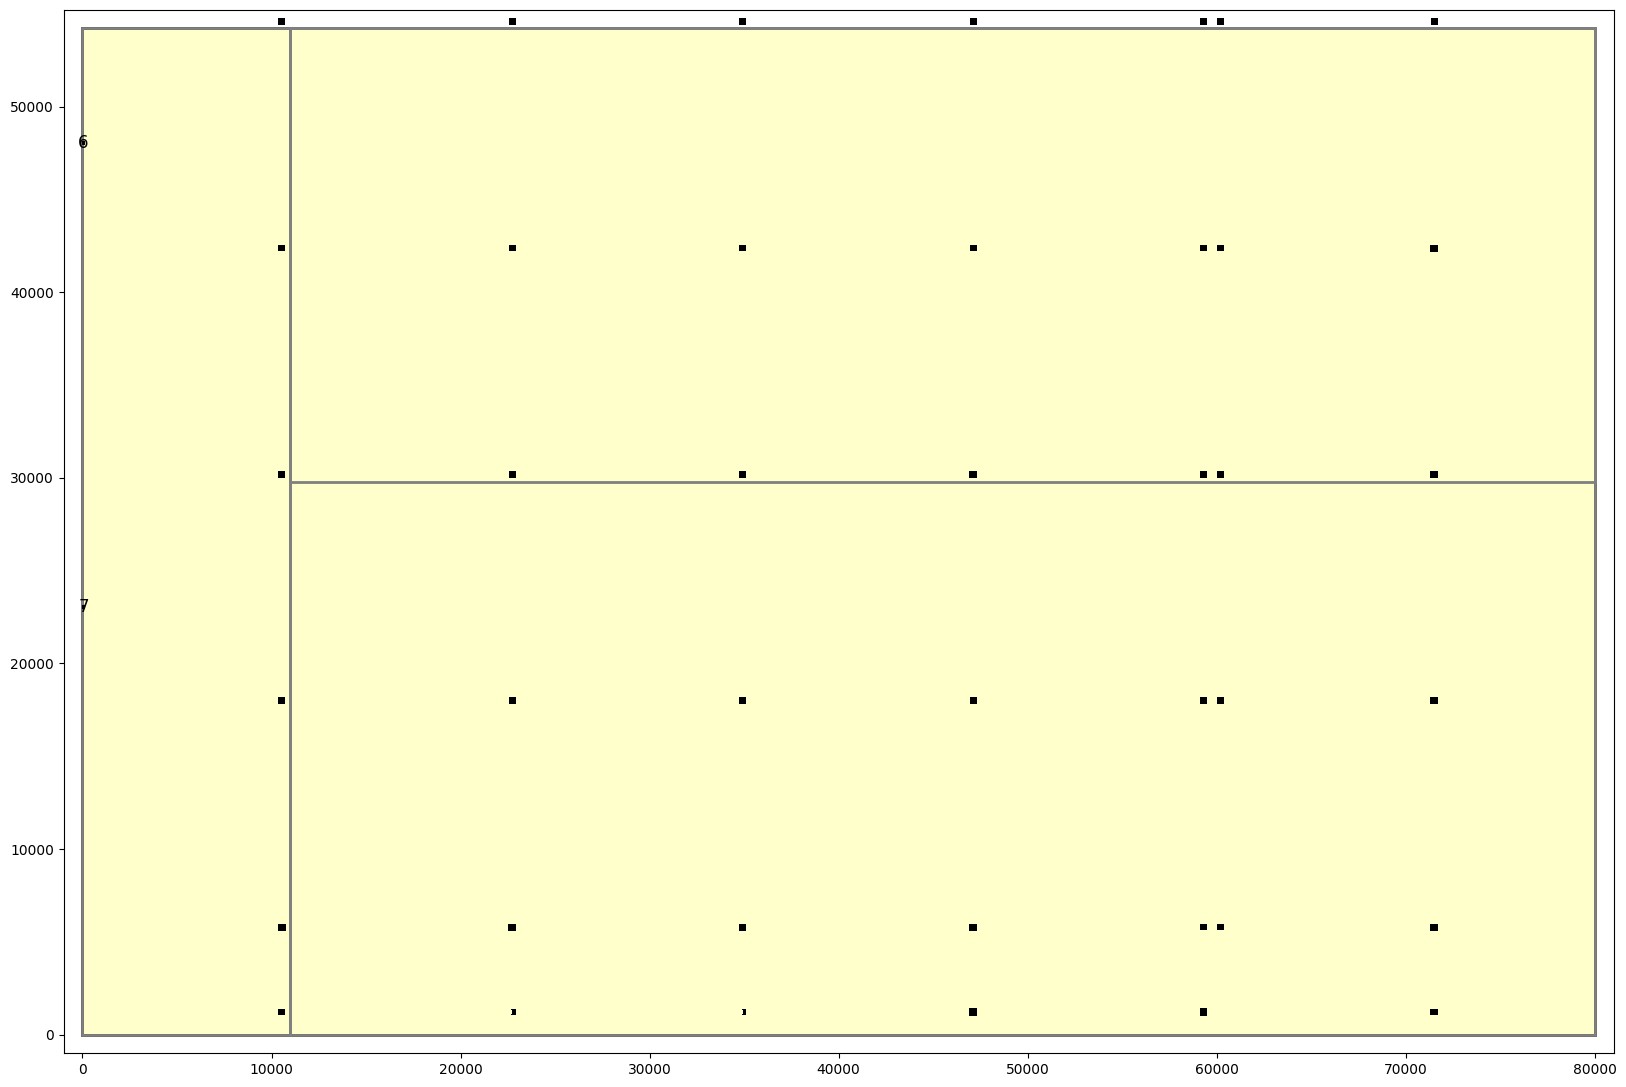

In [405]:
plt_lay_cluster()

# CNS제안 초기 path

In [406]:
exit=[]
entrance=[]

for i in group_matrix.index[(group_matrix == 0).all(axis=1)]:
    if df_selected[df_selected['설비Group']==i]['processGroup'].iloc[0]=='dock':
        exit.append(df_selected[df_selected['설비Group']==i].index[0])
        
for i in group_matrix.index[(group_matrix == 0).all(axis=0)]:
    if df_selected[df_selected['설비Group']==i]['processGroup'].iloc[0]=='dock':
        entrance.append(df_selected[df_selected['설비Group']==i].index[0])

In [407]:
big_path=[]
for i in entrance:
    for j in exit:
        big_path.append([[(X[i],Y[i]),(X[i],Y[j])],[(X[i],Y[j]),(X[j],Y[j])]])

In [408]:
# 흐름 확인
path_flow={}

for c in df_selected.index:
    path_flow[c]={}
    for i in group_matrix[group_matrix.iloc[c] == 1].index:
        for j in df_selected[df_selected["설비Group"]==i.split('_')[0]].index:
            try:
                path_flow[c]['post'].append(j)
            except:
                path_flow[c]['post']=[]
                path_flow[c]['post'].append(j)
            
    for i in group_matrix[group_matrix.iloc[:,c] == 1].index:
        for j in df_selected[df_selected["설비Group"]==i.split('_')[0]].index:
            try:
                path_flow[c]['pre'].append(j)
            except:
                path_flow[c]['pre']=[]
                path_flow[c]['pre'].append(j)
        

In [409]:
# #  big_path 생성 1219, #1221
# # dock가 몰리는 경우 고려
# # step 1 : 
# da = data["fixedFacilityPositions"]
# big_path=[]
# place_ent=0
# place_ex=0
# for i in entrance:
#     nxt = path_flow[i].get('post')
#     for en in range(len(place_areas)):
#         for n in nxt:
#             if place_areas[en]["id"] == str(df_selected.loc[n, "placeable"]):
#                 place_ent = en    
#     for j in exit:
#         route = []
#         pre = path_flow[j].get('pre')
#         for ex in range(len(place_areas)):
#             for r in pre:
#                 if place_areas[ex]['id'] == str(df_selected.loc[r, "placeable"]):
#                     place_ex = ex
#         # i = entrance, j = exit
#         start_x, start_y = X[i], Y[i]
#         end_x, end_y = X[j], Y[j]
#         x_i = 0
#         y_i = 0
#         x_j = 0
#         y_j = 0
#         for item in da:
#             if item["facilityId"].split('_')[0] == df_selected.loc[i,"설비Group"]:
#                 x_i = float(item["position"].get("x"))
#                 y_i = float(item["position"].get("y"))
#             elif item["facilityId"].split('_')[0] == df_selected.loc[j,"설비Group"]:
#                 x_j = float(item["position"].get("x"))
#                 y_j = float(item["position"].get("y"))
        
#         print(x_j, y_j)
#         # 초기 path 방향
#         left_x   = 0
#         right_x  = 0
#         top_y    = 0
#         bottom_y = 0

#         # place_areas 와 거리 계산
#         x_place_left = float(place_areas[place_ent]['x'])
#         x_place_right = float(place_areas[place_ent]['x']) + float(place_areas[place_ent]['width'])
#         y_place_top = float(place_areas[place_ent]['y']) + float(place_areas[place_ent]['height'])
#         y_place_bottom = float(place_areas[place_ent]['y'])
#         X_di_L = abs(x_place_left - x_i)
#         X_di_R = abs(x_place_right - x_i)
#         Y_di_U = abs(y_place_top - y_i)
#         Y_di_B = abs(y_place_bottom - y_i)
        
#         # 출구 인근 place_areas 와 거리 계산
#         x_exit_left = float(place_areas[place_ex]['x'])
#         x_exit_right = float(place_areas[place_ex]['x']) + float(place_areas[place_ex]['width'])
#         y_exit_top = float(place_areas[place_ex]['y']) + float(place_areas[place_ex]['height'])
#         y_exit_bottom = float(place_areas[place_ex]['y'])
#         print(place_areas[place_ex])
#         # dock와 벽 거리
#         limit = 2000
#         init_len = 0
        
#         # 일반적인 dock 위치

#         if X_di_L < limit:
#             right_x = 1
#             init_len = float(place_areas[place_ent]['width'])/3
#         elif X_di_R < limit:
#             left_x = 1
#             init_len = float(place_areas[place_ent]['width'])/3
#         elif Y_di_U < limit:
#             bottom_y = 1
#             init_len = float(place_areas[place_ent]['height'])/3
#         elif Y_di_B < limit:
#             top_y = 1
#             init_len = float(place_areas[place_ent]['height'])/3
            
        
        
#         # dock가 한쪽에 몰릴 경우
#         if (x_i - x_j) < limit and (x_i or x_j) < limit:
#             init_len = abs(x_place_right - x_place_left)/3
            
#         elif (y_i - y_j) < limit and (y_i or y_j) < limit:
#             init_len = abs(y_place_top - y_place_bottom)/3
            
#         # 경로 1 : 정해진 방향으로 place area의 영역 3분의 1만큼 그리기                
#         if right_x == 1:
#             cand_x = start_x + init_len
#             cand_y = start_y
#         elif left_x == 1:
#             cand_x = start_x - init_len
#             cand_y = start_y
#         elif top_y == 1:
#             cand_x = start_x
#             cand_y = start_y + init_len
#         elif bottom_y == 1:
#             cand_x = start_x
#             cand_y = start_y - init_len

#         route.append([(start_x, start_y),(cand_x, cand_y)])
        
#         #2 : dockout 바라보는 방향으로 꺾기
#         # 동일선상인 경우 그대로 그리기

#         x_d = x_j - cand_x # 양수면 오른쪽으로 음수면 왼쪽으로
#         y_d = y_j - cand_y # 양수면 위로 음수면 아래로
#         print(x_d, y_d)
#         if right_x == 1 or left_x == 1:
#             right_x = 0
#             left_x = 0
#             next_x = cand_x
#             if y_d > 0:
#                 top_y = 1
#                 next_y = cand_y + y_d
#             elif y_d < 0:
#                 bottom_y = 1
#                 next_y = cand_y - y_d
#         elif top_y == 1 or bottom_y == 1:
#             top_y = 0
#             bottom_y = 0
#             next_y = cand_y
#             if x_d > 0:
#                 right_x = 1
#                 next_x = cand_x + x_d
#             elif x_d < 0:
#                 left_x = 1
#                 next_x = cand_x - x_d    
        
#         #3 : next 좌표가 제한구역일 경우 패스 연장
#         X_ex_L = abs(x_exit_left - next_x)
#         X_ex_R = abs(x_exit_right - next_x)
#         Y_ex_U = abs(y_exit_top - next_y)
#         Y_ex_B = abs(y_exit_bottom - next_y) 
        
#         # 출구가 속한 place area 계산
#         extend_x = float(place_areas[place_ex]['width'])
#         extend_y = float(place_areas[place_ex]['height'])
#         print(extend_x, extend_y)
#         if next_x < x_place_left and next_x - extend_x/3 > Xunder:
#             right_x, left_x, top_y, bottom_y = 0,0,0,0
#             next_x = next_x - extend_x/3 
#             left_x = 1
#         elif end_x > x_place_right and next_x + extend_x/3 < Xupper:
#             right_x, left_x, top_y, bottom_y = 0,0,0,0
#             next_x = next_x + extend_x/3 
#             right_x = 1
#         elif end_y > y_place_top and next_y + extend_y/3 > Yupper:
#             right_x, left_x, top_y, bottom_y = 0,0,0,0
#             next_y = next_y + extend_y/3
#             top_y = 1
#         elif end_y < y_place_bottom and next_y - extend_y/3 < Yunder:
#             right_x, left_x, top_y, bottom_y = 0,0,0,0
#             next_y = next_y - extend_y/3    
#             bottom_y = 1
#         route.append([(cand_x, cand_y), (next_x, next_y)])
        
#         # 4 출구와 다른 경우 출구까지 연장
#         last_x = next_x
#         last_y = next_y    
#         if next_x != end_x and next_y != end_y:
#             if right_x == 1 or left_x == 1:
#                 last_x = next_x
#                 last_y = end_y
#             elif top_y == 1 or bottom_y == 1:
#                 last_x = end_x
#                 last_y = next_y
#         if next_x != last_x or next_y != last_y:
#             route.append([(next_x, next_y),
#                         (last_x, last_y)])
                    

#         route.append([(last_x, last_y),
#                     (end_x, end_y)])
#     big_path.append(route)
                                    
# big_path


In [410]:
#  big_path 패스생성 1223
# dock가 몰리는 경우 고려

da = data["fixedFacilityPositions"]
big_path=[]
place_ent=0
place_ex=0
x_uni = {}
y_uni = {}
for r in range(len(restricted_areas)):
    x_uni[r] = (restricted_areas[r]["x"],restricted_areas[r]["x"]+restricted_areas[r]["width"])
    y_uni[r] = (restricted_areas[r]["y"],restricted_areas[r]["y"]+restricted_areas[r]["height"])
print(x_uni)
print(y_uni)


for i in entrance:
    nxt = path_flow[i].get('post')
    for en in range(len(place_areas)):
        for n in nxt:
            if place_areas[en]["id"] == str(df_selected.loc[n, "placeable"]):
                place_ent = en    
    for j in exit:
        route = []
        pre = path_flow[j].get('pre')
        for ex in range(len(place_areas)):
            for r in pre:
                if place_areas[ex]['id'] == str(df_selected.loc[r, "placeable"]):
                    place_ex = ex

        # i = entrance, j = exit
        start_x = 0
        start_y = 0
        end_x = 0
        end_y = 0
        for item in da:
            if item["facilityId"].split('_')[0] == df_selected.loc[i,"설비Group"]:
                start_x = float(item["position"].get("x"))
                start_y = float(item["position"].get("y"))
            elif item["facilityId"].split('_')[0] == df_selected.loc[j,"설비Group"]:
                end_x = float(item["position"].get("x"))
                end_y = float(item["position"].get("y"))
        
        # 초기 path 방향
        left_x   = 0
        right_x  = 0
        top_y    = 0
        bottom_y = 0
        need_pass = 0
        # 입구가 있는 place_areas 와 거리 계산
        x_place_left = float(place_areas[place_ent]['x'])
        x_place_right = float(place_areas[place_ent]['x']) + float(place_areas[place_ent]['width'])
        y_place_top = float(place_areas[place_ent]['y']) + float(place_areas[place_ent]['height'])
        y_place_bottom = float(place_areas[place_ent]['y'])
        
        X_di_L = abs(x_place_left - start_x)
        X_di_R = abs(x_place_right - start_x)
        Y_di_U = abs(y_place_top - start_y)
        Y_di_B = abs(y_place_bottom - start_y)
        
        # 출구가 있는 place_areas 와 거리 계산
        x_exit_left = float(place_areas[place_ex]['x'])
        x_exit_right = float(place_areas[place_ex]['x']) + float(place_areas[place_ex]['width'])
        y_exit_top = float(place_areas[place_ex]['y']) + float(place_areas[place_ex]['height'])
        y_exit_bottom = float(place_areas[place_ex]['y'])


        need_pass = 1 if place_ent != place_ex else 0
        pass_area = []
        pass_exit = 0
        
        #
        if need_pass == 1:
            target_x = 0 # 진행방향이 x, 검사할 좌표 y
            target_y = 0 # 진행방향이 y, 검사할 좌표 x
            if x_place_left < x_exit_left:
                target_x = 1
                target = x_exit_left
            elif x_place_left > x_exit_left:
                target_x = 1
                target = x_place_left
            elif y_place_bottom < y_exit_bottom:
                target_y = 1
                target = y_exit_bottom
            elif y_place_bottom > y_exit_bottom:
                target_y = 1
                target = y_place_bottom

            if target_x == 1:                    
                keys = [kk for kk, (x1,x2) in x_uni.items() if x1 == target or x2 == target]
                intervals = []
                for kk in keys:
                    lo, up = y_uni[kk]
                    lb = lo if lo <= up else up
                    ub = up if lo <= up else lo
                    intervals.append((lb, ub))

                
            elif target_y == 1:
                keys = [kk for kk, (y1,y2) in y_uni.items() if y1 == target or y2 == target]
                intervals = []
                for kk in keys:
                    lo, up = x_uni[kk]
                    lb = lo if lo <= up else up
                    ub = up if lo <= up else lo
                    intervals.append((lb, ub))

            
            intervals.sort(key=lambda t: t[0])
            
            merged = []
            for lb, ub in intervals:
                if not merged:
                    merged.append([lb, ub])
                else:
                    if lb <= merged[-1][1]:
                        if ub > merged[-1][1]:
                            merged[-1][1] = ub
                    else:
                        merged.append([lb, ub])
                        

            for i in range(len(merged) - 1):
                a = merged[i][1]
                b = merged[i + 1][0]
                if a < b:
                    pass_area.append((a,b))

            if not pass_area:
                print("pass_area 없음")
                need_pass = 0
               
        # dock와 벽 거리 (임의 설정)
        limit = 2000
        init_len = 0
        
        # 일반적인 dock 위치

        # placeable area 길이 변수로 저장
        X_p = float(place_areas[place_ent]['width'])
        Y_p = float(place_areas[place_ent]['height'])

        # 1. 절반 뻗기
        if X_di_L < limit:
            right_x = 1
            if abs(start_x - end_x) > X_p:
                init_len = X_p/2
            else:
                init_len = abs(start_x - end_x)
        elif X_di_R < limit:
            left_x = 1
            if abs(start_x - end_x) > X_p:
                init_len = X_p/2
            else:
                init_len = abs(start_x - end_x)
        elif Y_di_U < limit:
            bottom_y = 1
            if abs(start_y - end_y) > Y_p:
                init_len = Y_p/2
            else:
                init_len = abs(start_y - end_y)
        elif Y_di_B < limit:
            top_y = 1
            if abs(start_y - end_y) > Y_p:
                init_len = Y_p/2
            else:
                init_len = abs(start_y - end_y)
            
    
        # 1-1. dock가 한쪽에 몰릴 경우
        if (start_x - end_x) < limit and (start_x or end_x) < limit:
            init_len = abs(x_place_right - x_place_left)/3
            if start_x < limit:
                right_x = 1
            elif abs(start_x - x_place_right) < limit:
                left_x = 1
            elif start_y < limit:
                top_y = 1
            elif abs(start_y - y_place_top) < limit:
                bottom_y = 1
            
            
        elif (start_y - end_y) < limit and (start_y or end_y) < limit:
            init_len = abs(y_place_top - y_place_bottom)/3
            
        # 경로 1 : 정해진 방향으로 place area의 영역 3분의 1만큼 그리기                
        if right_x == 1:
            cand_x = start_x + init_len
            cand_y = start_y
        elif left_x == 1:
            cand_x = start_x - init_len
            cand_y = start_y
        elif top_y == 1:
            cand_x = start_x
            cand_y = start_y + init_len
        elif bottom_y == 1:
            cand_x = start_x
            cand_y = start_y - init_len

        # 통로 사용 시
        if need_pass and pass_area:
            if target_x == 1:
                lb, ub = lb, ub in pass_area
                if (lb <= end_y <= ub for lb, ub in pass_area):
                    pass_exit = end_y
                else:
                    pass_exit = 0
                    if pass_exit != 0:
                        cand_x = cand_x
                        cand_y = pass_exit
                    else:
                        cand_x = cand_x
                        cand_y = (lb + ub) / 2
            elif target_y == 1:
                if (lb <= end_x <= ub for lb, ub in pass_area):
                    pass_exit = end_x
                else:
                    pass_exit = 0
                    if pass_exit != 0:
                        cand_x = pass_exit
                        cand_y = cand_y
                    else:
                        cand_x = (lb + ub) / 2
                        cand_y = cand_y
        # 통로 안쓰면 좌표 유지
        else:
            cand_x = cand_x
            cand_y = cand_y
        
        # 좌표 1 추가    
        route.append([(start_x, start_y),(cand_x, cand_y)])
        
        #2 : dockout 바라보는 방향으로 꺾기
        # 동일선상인 경우 그대로 그리기

        x_d = end_x - cand_x # 양수면 오른쪽으로 음수면 왼쪽으로
        y_d = end_y - cand_y # 양수면 위로 음수면 아래로

        # 통로 사용 시 좌표
        if need_pass:
            print("통로 사용")
            # 출구 공간 중점으로
            if target_x:
                next_x = (x_exit_left + x_exit_right) /2
                next_y = cand_y 
            elif target_y:
                next_x = cand_x
                next_y = (y_exit_bottom + y_exit_top) /2
        # 통로를 못 쓴 경우 탈출
        else:
            if right_x == 1 or left_x == 1:
                right_x = 0
                left_x = 0
                next_x = cand_x
                if y_d >= 0:
                    top_y = 1
                    next_y = cand_y + y_d
                elif y_d < 0:
                    bottom_y = 1
                    next_y = cand_y + y_d
            elif top_y == 1 or bottom_y == 1:
                top_y = 0
                bottom_y = 0
                next_y = cand_y
                if x_d >= 0:
                    right_x = 1
                    next_x = cand_x + x_d
                elif x_d < 0:
                    left_x = 1
                    next_x = cand_x + x_d    


        # 벽에 딱 붙은 경우 패스 연장
        extend_x = abs(float(place_areas[place_ex]['width']))
        extend_y = abs(float(place_areas[place_ex]['height']))
        print(next_x, x_place_left)
        if next_x == end_x and next_y == end_y:
            break
        if next_x <= x_place_left and next_x - extend_x/3 > Xunder:
            right_x, left_x, top_y, bottom_y = 0,0,0,0
            next_x = next_x - extend_x/3
            left_x = 1
        elif end_x >= x_place_right and next_x + extend_x/3 < Xupper:
            right_x, left_x, top_y, bottom_y = 0,0,0,0
            next_x = next_x + extend_x/3
            right_x = 1
        elif end_y >= y_place_top and next_y + extend_y/3 > Yupper:
            right_x, left_x, top_y, bottom_y = 0,0,0,0
            next_y = next_y + extend_y/3
            top_y = 1
        elif end_y <= y_place_bottom and next_y - extend_y/3 < Yunder:
            right_x, left_x, top_y, bottom_y = 0,0,0,0
            next_y = next_y - extend_y/3    
            bottom_y = 1
        route.append([(cand_x, cand_y), (next_x, next_y)])
        
        # 4 출구와 다른 경우 출구까지 연장
        last_x = next_x
        last_y = next_y    
        if next_x != end_x and next_y != end_y:
            if right_x == 1 or left_x == 1:
                last_x = next_x
                last_y = end_y
            elif top_y == 1 or bottom_y == 1:
                last_x = end_x
                last_y = next_y
        if next_x != last_x or next_y != last_y:
            route.append([(next_x, next_y),
                        (last_x, last_y)])
                    

        route.append([(last_x, last_y),
                    (end_x, end_y)])
    big_path.append(route)
                                    
big_path


{}
{}
pass_area 없음
23004.666666666668 10989.0


[[[(1.0, 48000.0), (23004.666666666668, 48000.0)],
  [(23004.666666666668, 48000.0), (23004.666666666668, 23000.0)],
  [(23004.666666666668, 23000.0), (1.0, 23000.0)]]]

In [411]:
total_next_fac=[]
# 배치 순서 생성
start = []
next_fac = {}

for i, j in path_flow.items():
    if 'pre' not in j:
        start.append(i)
    if 'post' in j:
        next_fac[i] = j['post']

# total_next_fac.append(next_fac)
# total_next_fac

In [412]:
def build_paths(starts):
    paths = []

    def dfs(node, path, visiting):
        # 사이클 방지(혹시 순환이 있으면)
        if node in visiting:
            raise ValueError(f"Cycle detected at node {node}. Current path: {path}")

        # 다음 노드가 없으면 여기서 경로 종료
        nxts = next_fac.get(node, [])
        if not nxts:
            paths.append(path)
            return

        visiting.add(node)
        for nxt in nxts:
            dfs(nxt, path + [nxt], visiting)
        visiting.remove(node)

    for s in starts:
        dfs(s, [s], set())

    return paths

In [413]:
big_path

[[[(1.0, 48000.0), (23004.666666666668, 48000.0)],
  [(23004.666666666668, 48000.0), (23004.666666666668, 23000.0)],
  [(23004.666666666668, 23000.0), (1.0, 23000.0)]]]

In [414]:
# #3 설비도 하나의 path에 통합
# def build_traces_scc_first(starts, path_flow, exits=None, key="post", max_depth=100000):
#     """
#     starts: 시작 노드 리스트
#     path_flow: {node: {'post': [...], 'pre': [...]}, ...}
#     exits: 마지막에 오게 하고 싶은 노드 리스트 (예: [13])
#     key: 'post' 기준(설비 -> 후공정)
#     return: traces (start마다 trace 리스트)
#     """
#     exits = exits or []

#     # --- 1) 그래프(인접리스트) 만들기: 순서 보존 ---
#     adj = {}
#     all_nodes = set(path_flow.keys())
#     for u, info in path_flow.items():
#         nbrs = list(info.get(key, []))
#         adj[u] = nbrs
#         for v in nbrs:
#             all_nodes.add(v)

#     for n in all_nodes:
#         adj.setdefault(n, [])

#     # --- 2) Tarjan SCC ---
#     index = 0
#     stack = []
#     onstack = set()
#     idx = {}
#     low = {}
#     sccs = []

#     def strongconnect(v):
#         nonlocal index
#         idx[v] = index
#         low[v] = index
#         index += 1
#         stack.append(v)
#         onstack.add(v)

#         for w in adj[v]:
#             if w not in idx:
#                 strongconnect(w)
#                 low[v] = min(low[v], low[w])
#             elif w in onstack:
#                 low[v] = min(low[v], idx[w])

#         # root of SCC
#         if low[v] == idx[v]:
#             comp = []
#             while True:
#                 w = stack.pop()
#                 onstack.remove(w)
#                 comp.append(w)
#                 if w == v:
#                     break
#             sccs.append(comp)

#     for v in all_nodes:
#         if v not in idx:
#             strongconnect(v)

#     node2scc = {}
#     for cid, comp in enumerate(sccs):
#         for n in comp:
#             node2scc[n] = cid

#     # --- 3) SCC 기준으로 DFS trace 만들기 (같은 SCC 이웃 먼저, 다른 SCC 이웃 나중) ---
#     traces = []

#     for s in starts:
#         visited = set()
#         trace = []

#         if s not in all_nodes:
#             traces.append([s])
#             continue

#         # iterative DFS: (node, next_neighbor_index, ordered_neighbors)
#         def ordered_neighbors(u):
#             nbrs = adj[u]
#             cu = node2scc[u]
#             same = [v for v in nbrs if node2scc.get(v, -1) == cu]
#             diff = [v for v in nbrs if node2scc.get(v, -1) != cu]
#             return same + diff  # 순서 보존

#         visited.add(s)
#         trace.append(s)
#         stack2 = [(s, 0, ordered_neighbors(s))]
#         steps = 0

#         while stack2:
#             steps += 1
#             if steps > max_depth:
#                 break

#             u, i, nbrs = stack2[-1]
#             if i >= len(nbrs):
#                 stack2.pop()
#                 continue

#             v = nbrs[i]
#             stack2[-1] = (u, i + 1, nbrs)

#             if v in visited:
#                 continue

#             visited.add(v)
#             trace.append(v)
#             stack2.append((v, 0, ordered_neighbors(v)))

#         # --- 4) exits는 항상 마지막으로 보내기(있으면) ---
#         for e in exits:
#             if e in trace:
#                 trace = [x for x in trace if x != e] + [e]

#         traces.append(trace)

#     return traces


# # 사용 예시
# paths = build_traces_scc_first(start, path_flow, exits=exit, key="post")
# paths

In [415]:
def build_paths_scc_first(starts, path_flow, exits=None, key="post", max_depth=200):
    exits = set(exits or [])

    # --- adjacency 만들기 (순서 보존) ---
    adj = {}
    all_nodes = set(path_flow.keys())
    for u, info in path_flow.items():
        nbrs = list(info.get(key, []))
        adj[u] = nbrs
        for v in nbrs:
            all_nodes.add(v)
    for n in all_nodes:
        adj.setdefault(n, [])

    # --- Tarjan SCC ---
    index = 0
    stack = []
    onstack = set()
    idx = {}
    low = {}
    sccs = []

    def strongconnect(v):
        nonlocal index
        idx[v] = index
        low[v] = index
        index += 1
        stack.append(v)
        onstack.add(v)

        for w in adj[v]:
            if w not in idx:
                strongconnect(w)
                low[v] = min(low[v], low[w])
            elif w in onstack:
                low[v] = min(low[v], idx[w])

        if low[v] == idx[v]:
            comp = []
            while True:
                w = stack.pop()
                onstack.remove(w)
                comp.append(w)
                if w == v:
                    break
            sccs.append(comp)

    for v in all_nodes:
        if v not in idx:
            strongconnect(v)

    node2scc = {}
    for cid, comp in enumerate(sccs):
        for n in comp:
            node2scc[n] = cid

    def ordered_neighbors(u):
        nbrs = adj.get(u, [])
        cu = node2scc.get(u, -1)
        same = [v for v in nbrs if node2scc.get(v, -2) == cu]
        diff = [v for v in nbrs if node2scc.get(v, -2) != cu]
        return same + diff  # 원래 순서 유지 + SCC우선

    # --- root->leaf paths 생성 ---
    paths = []

    def dfs(u, path, visiting, depth):
        if depth >= max_depth:
            paths.append(path + ["<MAX_DEPTH>"])
            return

        nxts = ordered_neighbors(u)

        # ✅ post가 없으면(exit이 아니어도) leaf로 보고 종료
        if (not nxts) or (u in exits):
            paths.append(path)
            return

        for v in nxts:
            if v in visiting:
                # 사이클이면 여기서 끊고 저장(엄밀X)
                paths.append(path + [v, "<CYCLE>"])
                continue
            visiting.add(v)
            dfs(v, path + [v], visiting, depth + 1)
            visiting.remove(v)

    for s in starts:
        dfs(s, [s], set([s]), 0)

    return paths
paths = build_paths_scc_first(start, path_flow, exits=exit, key="post")
print(paths)

[[6, 2, 0, 2, '<CYCLE>'], [6, 2, 0, 1, 3, 5, 4, 7], [6, 2, 1, 3, 5, 4, 7]]


In [416]:
CYCLE_TAG = "<CYCLE>" 

remove_list=[]
for i in range(len(paths)-1,-1,-1):
    if paths[i][-1] != CYCLE_TAG:
        if paths[i][-1] not in exit:
            paths.remove(paths[i])
            
paths

[[6, 2, 0, 2, '<CYCLE>'], [6, 2, 0, 1, 3, 5, 4, 7], [6, 2, 1, 3, 5, 4, 7]]

In [417]:
from itertools import permutations, product

CYCLE_TAG = "<CYCLE>"  # 너 데이터가 '<CYCLE>'면 '<CYCLE>'로 바꿔

# ---------- 유틸 ----------
def is_subseq(a, b):
    """a가 b에 순서 유지(subsequence)로 포함되면 True"""
    it = iter(b)
    for x in a:
        for y in it:
            if y == x:
                break
        else:
            return False
    return True

def filter_included_segments(segs):
    """포함관계면(짧은 seg가 긴 seg에 포함) 짧은 seg 제거"""
    uniq = []
    for s in segs:
        if s not in uniq:
            uniq.append(s)

    keep = []
    for s in uniq:
        if any(s != t and len(s) <= len(t) and is_subseq(s, t) for t in uniq):
            continue
        keep.append(s)
    return keep

def cycle_node_and_segment(cycle_path):
    """
    node = '<CYCLE>' 바로 앞 숫자
    seg  = node 첫 등장 다음부터, 마지막 node 직전까지
    예) [10,0,9,7,3,6,7,'<CYCLE>'] -> node=7, seg=[3,6]
    """
    node = cycle_path[-2]
    first = cycle_path.index(node)
    seg = cycle_path[first + 1 : -2]
    return node, seg

def flatten_unique(segments_in_order):
    """여러 seg를 순서대로 붙이되, seg들 사이 중복 노드는 1번만"""
    out, seen = [], set()
    for seg in segments_in_order:
        for x in seg:
            if x not in seen:
                out.append(x)
                seen.add(x)
    return out

# ---------- 핵심: (node, next_base_node) 사이 "끝"에 붙이기 ----------
def insert_between_lock(path, node, next_node, seq):
    """
    node와 next_node 사이(= next_node 바로 앞)에 seq를 삽입.
    node~next_node 사이에 이미 뭐가 끼어있으면 그 뒤에 붙어서,
    결과적으로 '2 뒤에 붙는다' 같은 동작이 됨.
    """
    if node not in path or not seq:
        return path[:]

    i_node = path.index(node)

    # next_node가 없거나(path 끝) / 못 찾으면 맨 끝에 붙임
    if next_node is None:
        i_next = len(path)
    else:
        i_next = next((j for j in range(i_node + 1, len(path)) if path[j] == next_node), len(path))

    prefix = path[:i_next]        # 여기까지는 고정(이미 끼어있는 것 포함)
    suffix = path[i_next:]        # next_node부터 뒤

    # prefix에 이미 있는 노드는 seq/suffix에서 제거(중복 제거, prefix 우선)
    seen = set(prefix)
    out_suffix = []
    for x in (seq + suffix):
        if x not in seen:
            out_suffix.append(x)
            seen.add(x)

    return prefix + out_suffix

# ---------- start별 후보 ----------
def candidates_for_start(base_path, cycle_paths):
    # 1) node별 seg 모으기
    groups = {}
    for cp in cycle_paths:
        node, seg = cycle_node_and_segment(cp)
        groups.setdefault(node, []).append(seg)

    # 2) base에서의 "다음 노드" 맵 (삽입 위치 결정용)
    next_in_base = {base_path[i]: base_path[i+1] for i in range(len(base_path)-1)}

    # 3) 처리 순서 = base_path에서 node가 등장하는 순서(9 먼저, 그 다음 7)
    order = []
    seen = set()
    for x in base_path:
        if x in groups and x not in seen:
            order.append(x)
            seen.add(x)

    # 4) 순서대로 후보 확장
    cand = [base_path[:]]
    for node in order:
        next_node = next_in_base.get(node, None)

        new_cand = []
        for cur in cand:
            if node not in cur:
                new_cand.append(cur)
                continue

            # (중요) "넣어도 안 변하는" seg는 제외 (0번 같은 케이스 자동 탈락)
            eff = []
            for seg in groups[node]:
                if insert_between_lock(cur, node, next_node, seg) != cur:
                    eff.append(seg)

            # 포함관계 정리 (예: [3]는 [3,6]에 포함이면 제거)
            eff = filter_included_segments(eff)

            if not eff:
                new_cand.append(cur)
                continue

            # 남은 eff들의 순열만큼 후보 생성
            for perm in permutations(eff):
                seq = flatten_unique(perm)
                new_cand.append(insert_between_lock(cur, node, next_node, seq))

        # 후보 중복 제거
        uniq = []
        for p in new_cand:
            if p not in uniq:
                uniq.append(p)
        cand = uniq

    return cand

# ---------- 전체 candPath ----------
def build_candPath(paths):
    base = {}
    start_order = []
    cycles_by_start = {}

    # base(비-cycle) / cycle 분리
    for p in paths:
        start = p[0]
        if p[-1] == CYCLE_TAG:
            cycles_by_start.setdefault(start, []).append(p)
        else:
            if start not in base:
                base[start] = p[:]
                start_order.append(start)

    per_start = [
        candidates_for_start(base[s], cycles_by_start.get(s, []))
        for s in start_order
    ]

    candPath = {}
    for i, combo in enumerate(product(*per_start)):
        candPath[i] = [list(x) for x in combo]
    return candPath


# ---------- 사용 예 ----------
candPath = build_candPath(paths)
candPath


{0: [[6, 2, 0, 1, 3, 5, 4, 7]]}

In [418]:
# def dedup_keep_order(seq):
#     seen = set()
#     out = []
#     for x in seq:
#         if x not in seen:
#             out.append(x)
#             seen.add(x)
#     return out

# def merge_cycle_paths(paths):
#     # 1) cycle 없는 경로(베이스) 수집: 시작 설비별로 1개만 사용(처음 등장한 것)
#     base = {}
#     start_order = []
#     cycles_by_start = {}

#     for p in paths:
#         start = p[0]
#         if p and p[-1] == "<CYCLE>":
#             cycles_by_start.setdefault(start, []).append(p)
#         else:
#             if start not in base:
#                 base[start] = p[:]          # copy
#                 start_order.append(start)

#     # 2) 같은 start의 cycle들을 베이스에 합치기
#     merged_paths = []
#     for start in start_order:
#         cur = base[start][:]

#         # cycle_node(= '<CYCLE>' 바로 앞 숫자)별로 "끼워넣을 구간" 모으기
#         groups = {}  # {cycle_node: [segment1, segment2, ...]}
#         for cp in cycles_by_start.get(start, []):
#             cycle_node = cp[-2]
#             first_idx = cp.index(cycle_node)     # cycle_node의 첫 등장 위치
#             segment = cp[first_idx + 1 : -2]     # cycle_node ~ (닫히기 직전) 구간
#             groups.setdefault(cycle_node, []).append(segment)

#         # cycle_node 큰 것부터 처리 (예: 9 먼저, 그다음 7)
#         for cycle_node in sorted(groups.keys(), reverse=True):
#             if cycle_node not in cur:
#                 continue

#             # 같은 cycle_node 안에서는 입력 순서대로 붙이고, 그 안에서 중복 제거
#             to_add = []
#             for seg in groups[cycle_node]:
#                 for x in seg:
#                     if x not in to_add:
#                         to_add.append(x)

#             if not to_add:
#                 continue

#             pos = cur.index(cycle_node)
#             cur = dedup_keep_order(cur[:pos+1] + to_add + cur[pos+1:])

#         merged_paths.append(cur)

#     return merged_paths


# print(merge_cycle_paths(paths))

In [419]:
# from collections import defaultdict

# def merge_cycle_paths_one_start(paths, cycle_token="<CYCLE>"):
#     # token 제거한 경로들
#     stripped = [[x for x in p if x != cycle_token] for p in paths]

#     # 메인 경로: cycle 없는 것 중 가장 긴 것 (없으면 전체 중 가장 긴 것)
#     noncycle = [p for p in paths if cycle_token not in p]
#     main = max(noncycle, key=len) if noncycle else max(stripped, key=len)
#     main = [x for x in main if x != cycle_token]

#     # 공통 prefix
#     def common_prefix(lists):
#         if not lists:
#             return []
#         pref = lists[0][:]
#         for lst in lists[1:]:
#             k = 0
#             while k < min(len(pref), len(lst)) and pref[k] == lst[k]:
#                 k += 1
#             pref = pref[:k]
#             if not pref:
#                 break
#         return pref

#     prefix = common_prefix(stripped)

#     merged, seen = [], set()

#     # prefix 먼저
#     for x in prefix:
#         if x not in seen:
#             merged.append(x); seen.add(x)

#     # cycle 경로들의 "prefix 이후 ~ 복귀 직전" segment를 중복 없이 붙이기
#     for p in stripped:
#         if p == main:
#             continue

#         start = len(prefix)
#         end = len(p)

#         # 마지막 노드가 prefix(또는 이미 merged)에 있으면 복귀로 보고 직전까지만
#         if end > 0 and (p[-1] in prefix or p[-1] in seen):
#             end -= 1

#         for x in p[start:end]:
#             if x not in seen:
#                 merged.append(x); seen.add(x)

#     # 마지막에 main tail 붙이기
#     for x in main[len(prefix):]:
#         if x not in seen:
#             merged.append(x); seen.add(x)

#     return merged


# def merge_cycle_paths_by_start(all_paths, cycle_token="<CYCLE>"):
#     groups = defaultdict(list)
#     for p in all_paths:
#         if not p:
#             continue
#         groups[p[0]].append(p)

#     merged_by_start = []
#     for s, ps in groups.items():
#         merged_by_start.append(merge_cycle_paths_one_start(ps, cycle_token=cycle_token)) 

#     return merged_by_start
# merged_dict = merge_cycle_paths_by_start(paths)
# paths=merged_dict

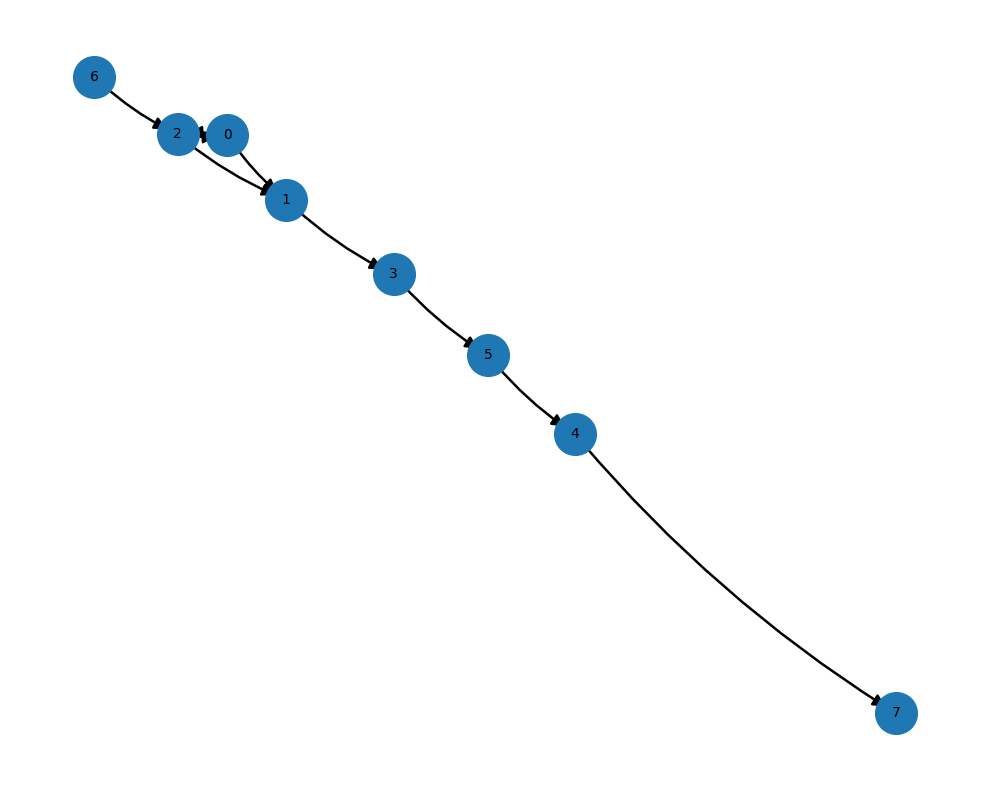

In [420]:


def plot_flow_graph(path_flow, pos=None, use_post=True, figsize=(10, 8)):
    """
    path_flow: {node: {'pre': [...], 'post': [...]}, ...}
    pos: (선택) {node: (x,y)} 형태 좌표 dict (예: expected_position)
    use_post=True면 post로 edge 만들고, False면 pre로 edge 만듦
    """
    G = nx.DiGraph()

    # 노드 추가
    nodes = set(path_flow.keys())
    for u, info in path_flow.items():
        if use_post:
            for v in info.get("post", []):
                nodes.add(v)
                G.add_edge(u, v)
        else:
            for v in info.get("pre", []):
                nodes.add(v)
                G.add_edge(v, u)

    G.add_nodes_from(nodes)

    # 레이아웃(좌표 없으면 자동)
    if pos is None:
        pos = nx.spring_layout(G, seed=42, k=1.2 / max(len(G.nodes), 1))

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_size=900)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True, arrowstyle='-|>', arrowsize=18,
        width=1.8,
        connectionstyle="arc3,rad=0.08"  # 서로 겹치는 간선 약간 휘게
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()


# 사용 예시
plot_flow_graph(path_flow)  # post 기준(설비 -> 후공정)
# plot_flow_graph(path_flow, use_post=False)  # pre 기준(이전설비 -> 설비)


In [421]:
# # 배치 순서 생성
# start = []
# next_fac = {}

# for i, j in path_flow.items():
#     if 'pre' not in j:
#         start.append(i)
#     if 'post' in j:
#         next_fac[i] = j['post'][0]

# paths = []
# used = set()

# for s in start:
#     path = [s]
#     done = {s}
#     used.add(s)
#     while path[-1] in next_fac:
#         nxt = next_fac[path[-1]]
#         if nxt in done:
#             break
#         path.append(nxt)
#         done.add(nxt)
#         used.add(nxt)
#     paths.append(path)

In [422]:
# 각 순서별 면적 비율 계산
EA_area = {}

for c in df_selected.index:
    EA_area[c]={}
    if df_selected.loc[c,"processGroup"] == "dock":
        continue
    else:
        x = df_selected.loc[c,"Cluster_X"]
        y = df_selected.loc[c,"Cluster_Y"]
        area = x*y
        EA_area[c] = float(area)



In [423]:
# path 별 길이
big_path_length = []

for first in big_path:
    path_length = []
    print(first)
    for second in first:
        dist = 0
        for i in range(len(second)-1):
            x1, y1 = second[i]
            x2, y2 = second[i+1]
            dist += abs((x2-x1) + (y2-y1))
        path_length.append(float(dist))
    big_path_length.append(path_length)

print(big_path_length)

length = []
sum = 0
for i in big_path_length:
    for a in i:
        sum += a
    length.append(sum)
    sum=0

[[(1.0, 48000.0), (23004.666666666668, 48000.0)], [(23004.666666666668, 48000.0), (23004.666666666668, 23000.0)], [(23004.666666666668, 23000.0), (1.0, 23000.0)]]
[[23003.666666666668, 25000.0, 23003.666666666668]]


In [424]:
#1221 주석처리 -> 하단 코드로 변경

# expected_position={}
# direc={}
# fixed = data["fixedFacilityPositions"]
# for path_idx in range(len(paths)):
#     expected_position={}
#     start_x, start_y = 0, 0
#     for item in fixed:
#         if item["facilityId"].split("_")[0] == df_selected.loc[entrance[path_idx],"설비Group"]:
#             start_x, start_y = float(item["position"].get("x")), float(item["position"].get("y"))
#             break

#     total = length[path_idx]
#     point = big_path_length[path_idx][0]
#     prop = area_ratio[path_idx]
#     prop_cum = 0.0
#     cum_now = 0.0
#     for c, p in zip(paths[path_idx][1:-1], prop):
#         prop = float(p)  # 현재 확률
#         now =  total*(prop_cum + prop/2) # 현재 확률의 절반 더하기
#         prop_cum += prop # 누적 확률
#         cum_now += prop_cum
#         if now <= point:
#             expected_position[c]=[start_x,start_y - now]
#         else:
#             expected_position[c]=[start_x - (now - point),start_y - point]
#     plt_bigpath()


In [425]:
def cal_Direc(paths):
    area_ratio=[]
    for path in paths:
        sum_area = 0
        for i in path[1:-1]:
            sum_area += EA_area.get(i, 0.0)
            ratio = []
            for i in path[1:-1]:
                if sum_area == 0:
                    continue
                else:
                    ratio.append(EA_area.get(i, 0.0) / sum_area)
        area_ratio.append(ratio)
        
    expected_position={}
    direc={}
    fixed = data["fixedFacilityPositions"]
    for path_idx in range(len(paths)):
        expected_position={}
        start_x, start_y = 0, 0
        for item in fixed:
            if item["facilityId"].split("_")[0] == df_selected.loc[entrance[path_idx],"설비Group"]:
                start_x, start_y = float(item["position"].get("x")), float(item["position"].get("y"))
                break

        total = float(length[path_idx])
        prop = area_ratio[path_idx]
        prop_cum = 0.0
        cum_now = 0.0

        # 세그먼트 리스트
        segs = big_path[path_idx]

        # 세그먼트 길이(Manhattan)와 누적 point 계산
        seg_lens = []
        points = []
        s = 0.0
        for (a, b) in segs:
            x0, y0 = float(a[0]), float(a[1])
            x1, y1 = float(b[0]), float(b[1])

            # 수평/수직 강제
            if x0 != x1 and y0 != y1:
                raise ValueError(f"Non-orthogonal segment: ({x0},{y0})->({x1},{y1})")

            L = abs(x1 - x0) + abs(y1 - y0)   # 항상 수평/수직이므로 이게 길이
            seg_lens.append(L)
            s += L
            points.append(s)

        # 고객/노드 할당은 기존과 동일하게 paths에서 zip
        for c, p in zip(paths[path_idx][1:-1], prop):
            p = float(p)
            now = total * (prop_cum + p / 2.0)
            prop_cum += p
            cum_now += prop_cum

            # now가 속한 세그먼트 찾기 (if now<=point를 일반화)
            seg_idx = 0
            while seg_idx < len(points) and now > points[seg_idx]:
                seg_idx += 1
            if seg_idx >= len(seg_lens):
                seg_idx = len(seg_lens) - 1

            prev_point = 0.0 if seg_idx == 0 else points[seg_idx - 1]
            t = now - prev_point  # 현재 세그먼트 내부 이동거리

            # 해당 세그먼트의 시작/끝
            (a, b) = segs[seg_idx]
            x0, y0 = float(a[0]), float(a[1])
            x1, y1 = float(b[0]), float(b[1])

            # 방향(부호) 자동 추론: x 또는 y 중 하나만 변함
            if x0 == x1:
                # 수직
                step = 1.0 if (y1 > y0) else -1.0
                x = x0
                y = y0 + step * t
            else:
                # 수평
                step = 1.0 if (x1 > x0) else -1.0
                x = x0 + step * t
                y = y0

            expected_position[c] = [x, y]
        for c in entrance:
            expected_position[c]=[X[c],Y[c]]
        for c in exit:
            expected_position[c]=[X[c],Y[c]]
        for c in paths[path_idx]:
            if df_selected.loc[c,'processGroup']=='dock':
                continue
            try:
                path_flow[c]['post'][0] 
            except:
                continue
            clusterXDiffer=expected_position[c][0]-expected_position[path_flow[c]['post'][0]][0]
            clusterYDiffer=expected_position[c][1]-expected_position[path_flow[c]['post'][0]][1]
            xDiffer=expected_position[paths[path_idx][0]][0]- expected_position[paths[path_idx][-1]][0]
            yDiffer=expected_position[paths[path_idx][0]][1]- expected_position[paths[path_idx][-1]][1]
            if abs(clusterXDiffer)>abs(clusterYDiffer):
                if xDiffer>=0:
                    direc[c]=1
                else:
                    direc[c]=2
            else:
                if yDiffer>=0:
                    direc[c]=3
                else:
                    direc[c]=4                
    return direc

In [426]:
#1221 주석처리 -> 하단 코드로 변경
def cal_exPosition(paths):
    area_ratio=[]
    expected_position={}
    for path in paths:
        sum_area = 0
        for i in path[1:-1]:
            sum_area += EA_area.get(i, 0.0)
            ratio = []
            for i in path[1:-1]:
                if sum_area == 0:
                    continue
                else:
                    ratio.append(EA_area.get(i, 0.0) / sum_area)
        area_ratio.append(ratio)    
    fixed = data["fixedFacilityPositions"]
    for path_idx in range(len(paths)):

        start_x, start_y = 0, 0
        for item in fixed:
            if item["facilityId"].split("_")[0] == df_selected.loc[entrance[path_idx],"설비Group"]:
                start_x, start_y = float(item["position"].get("x")), float(item["position"].get("y"))
                break

        total = float(length[path_idx])
        prop = area_ratio[path_idx]
        prop_cum = 0.0
        cum_now = 0.0

        # 세그먼트 리스트
        segs = big_path[path_idx]

        # 세그먼트 길이(Manhattan)와 누적 point 계산
        seg_lens = []
        points = []
        s = 0.0
        for (a, b) in segs:
            x0, y0 = float(a[0]), float(a[1])
            x1, y1 = float(b[0]), float(b[1])

            # 수평/수직 강제
            if x0 != x1 and y0 != y1:
                raise ValueError(f"Non-orthogonal segment: ({x0},{y0})->({x1},{y1})")

            L = abs(x1 - x0) + abs(y1 - y0)   # 항상 수평/수직이므로 이게 길이
            seg_lens.append(L)
            s += L
            points.append(s)

        # 고객/노드 할당은 기존과 동일하게 paths에서 zip
        for c, p in zip(paths[path_idx][1:-1], prop):
            p = float(p)
            now = total * (prop_cum + p / 2.0)
            prop_cum += p
            cum_now += prop_cum

            # now가 속한 세그먼트 찾기 (if now<=point를 일반화)
            seg_idx = 0
            while seg_idx < len(points) and now > points[seg_idx]:
                seg_idx += 1
            if seg_idx >= len(seg_lens):
                seg_idx = len(seg_lens) - 1

            prev_point = 0.0 if seg_idx == 0 else points[seg_idx - 1]
            t = now - prev_point  # 현재 세그먼트 내부 이동거리

            # 해당 세그먼트의 시작/끝
            (a, b) = segs[seg_idx]
            x0, y0 = float(a[0]), float(a[1])
            x1, y1 = float(b[0]), float(b[1])

            # 방향(부호) 자동 추론: x 또는 y 중 하나만 변함
            if x0 == x1:
                # 수직
                step = 1.0 if (y1 > y0) else -1.0
                x = x0
                y = y0 + step * t
            else:
                # 수평
                step = 1.0 if (x1 > x0) else -1.0
                x = x0 + step * t
                y = y0

            expected_position[c] = [x, y]



    return expected_position

In [427]:
# #1221 패스 위 설비 위치 

# # area_ratio 비율, 2개리스트
# # big_path 시작점 찾기
# # length 목표 길이
# # big_path_length 꺾는점 확인
# expected_position={}
# fixed = data["fixedFacilityPositions"]

# # path = 0, 1
# for path_idx in range(len(paths)):
    
#     start_x, start_y = 0, 0
#     for item in fixed:
#         if item["facilityId"].split("_")[0] == df_selected.loc[entrance[path_idx],"설비Group"]:
#             start_x, start_y = float(item["position"].get("x")), float(item["position"].get("y"))
#             break

#     total = float(length[path_idx])
#     prop = area_ratio[path_idx]
#     prop_cum = 0.0
#     cum_now = 0.0

#     # 세그먼트 리스트
#     segs = big_path[path_idx]

#     # 세그먼트 길이(Manhattan)와 누적 point 계산
#     seg_lens = []
#     points = []
#     s = 0.0
#     for (a, b) in segs:
#         x0, y0 = float(a[0]), float(a[1])
#         x1, y1 = float(b[0]), float(b[1])

#         # 수평/수직 강제
#         if x0 != x1 and y0 != y1:
#             raise ValueError(f"Non-orthogonal segment: ({x0},{y0})->({x1},{y1})")

#         L = abs(x1 - x0) + abs(y1 - y0)   # 항상 수평/수직이므로 이게 길이
#         seg_lens.append(L)
#         s += L
#         points.append(s)

#     # 고객/노드 할당은 기존과 동일하게 paths에서 zip
#     for c, p in zip(paths[path_idx][1:-1], prop):
#         p = float(p)
#         now = total * (prop_cum + p / 2.0)
#         prop_cum += p
#         cum_now += prop_cum

#         # now가 속한 세그먼트 찾기 (if now<=point를 일반화)
#         seg_idx = 0
#         while seg_idx < len(points) and now > points[seg_idx]:
#             seg_idx += 1
#         if seg_idx >= len(seg_lens):
#             seg_idx = len(seg_lens) - 1

#         prev_point = 0.0 if seg_idx == 0 else points[seg_idx - 1]
#         t = now - prev_point  # 현재 세그먼트 내부 이동거리

#         # 해당 세그먼트의 시작/끝
#         (a, b) = segs[seg_idx]
#         x0, y0 = float(a[0]), float(a[1])
#         x1, y1 = float(b[0]), float(b[1])

#         # 방향(부호) 자동 추론: x 또는 y 중 하나만 변함
#         if x0 == x1:
#             # 수직
#             step = 1.0 if (y1 > y0) else -1.0
#             x = x0
#             y = y0 + step * t
#         else:
#             # 수평
#             step = 1.0 if (x1 > x0) else -1.0
#             x = x0 + step * t
#             y = y0

#         expected_position[c] = [x, y]

#     plt_bigpath()

# CNS 제안 초기 path 기반 설비 배치

In [428]:
def merge_paths_before_first_overlap(paths):
    if not paths:
        return []

    ro = list(paths[0])
    print(ro)
    for p in paths[1:]:
        # p에서 ro와 처음 겹치는 원소 찾기
        overlap_j = None
        overlap_val = None
        for j, v in enumerate(p):
            if v in ro:
                overlap_j = j
                overlap_val = v
                break

        if overlap_j is None:
            # 겹치는 게 없으면 뒤에 (중복 빼고) 붙이기
            for v in p:
                if v not in ro:
                    ro.append(v)
        else:
            # 겹치는 원소 위치(ro에서) 찾고, 그 앞에 prefix 삽입 (중복 빼고)
            insert_pos = ro.index(overlap_val)
            prefix = [v for v in p[:overlap_j] if v not in ro]
            ro[insert_pos:insert_pos] = prefix

    return ro

In [429]:
def sol_decomposition(totalSol):
    s,Storage,df_selected,lay_clusters=copy.deepcopy(totalSol)
    X,Y,o,di=copy.deepcopy(s)
    s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0=copy.deepcopy(Storage)
    return X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters
def selectDestroyCycle(paths):
    if [p for p in paths if p and p[-1] == '<CYCLE>']==[]:
        return []
    randomCyclePath=random.choice([p for p in paths if p and p[-1] == '<CYCLE>'])[:-1]
    end = randomCyclePath[-1] 
    startIndex=len(randomCyclePath) - 2 - randomCyclePath[-2::-1].index(end) #사이클 시작 인덱스
    destroyFacility=randomCyclePath[startIndex:-1]
    return destroyFacility

In [430]:
paths

[[6, 2, 0, 2, '<CYCLE>'], [6, 2, 0, 1, 3, 5, 4, 7], [6, 2, 1, 3, 5, 4, 7]]

In [431]:
ro_path=merge_paths_before_first_overlap(paths)
ro_path

[6, 2, 0, 2, '<CYCLE>']


[6, 2, 0, 2, '<CYCLE>']

In [432]:
# X[5]=21610.5
# Y[5]=48268.0
# o[5]=0
# di[5]=0

In [433]:
# c=0
# s_x_t={}
# s_y_t={}
# sfc_to={}
# sfc_from={}
# sol=(X,Y,o,di)
# sol


In [434]:
# initial_sol(c)

In [435]:
import copy
s_x_t={}
s_y_t={}
sfc_to={}
sfc_from={}
iniSol=copy.deepcopy((X,Y,o,di))
iniStorage=copy.deepcopy((s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0))
candSol={}
candStorage={}
cand_df_selected={}
cand_lay_clusters={}
cand_obj={}
ini_df_selected=copy.deepcopy(df_selected)
ini_lay_clusters=copy.deepcopy(lay_clusters)

In [436]:
df_selected['type']

0    production
1    production
2    production
3    production
4    production
5    production
6        dockIn
7       dockOut
Name: type, dtype: object

[6, 2, 0, 1, 3, 5, 4, 7]
우선배치:  2
{np.int64(6): (100.0, 100.0), np.int64(7): (100.0, 100.0), 2: (np.int64(26243), np.int64(9950))}


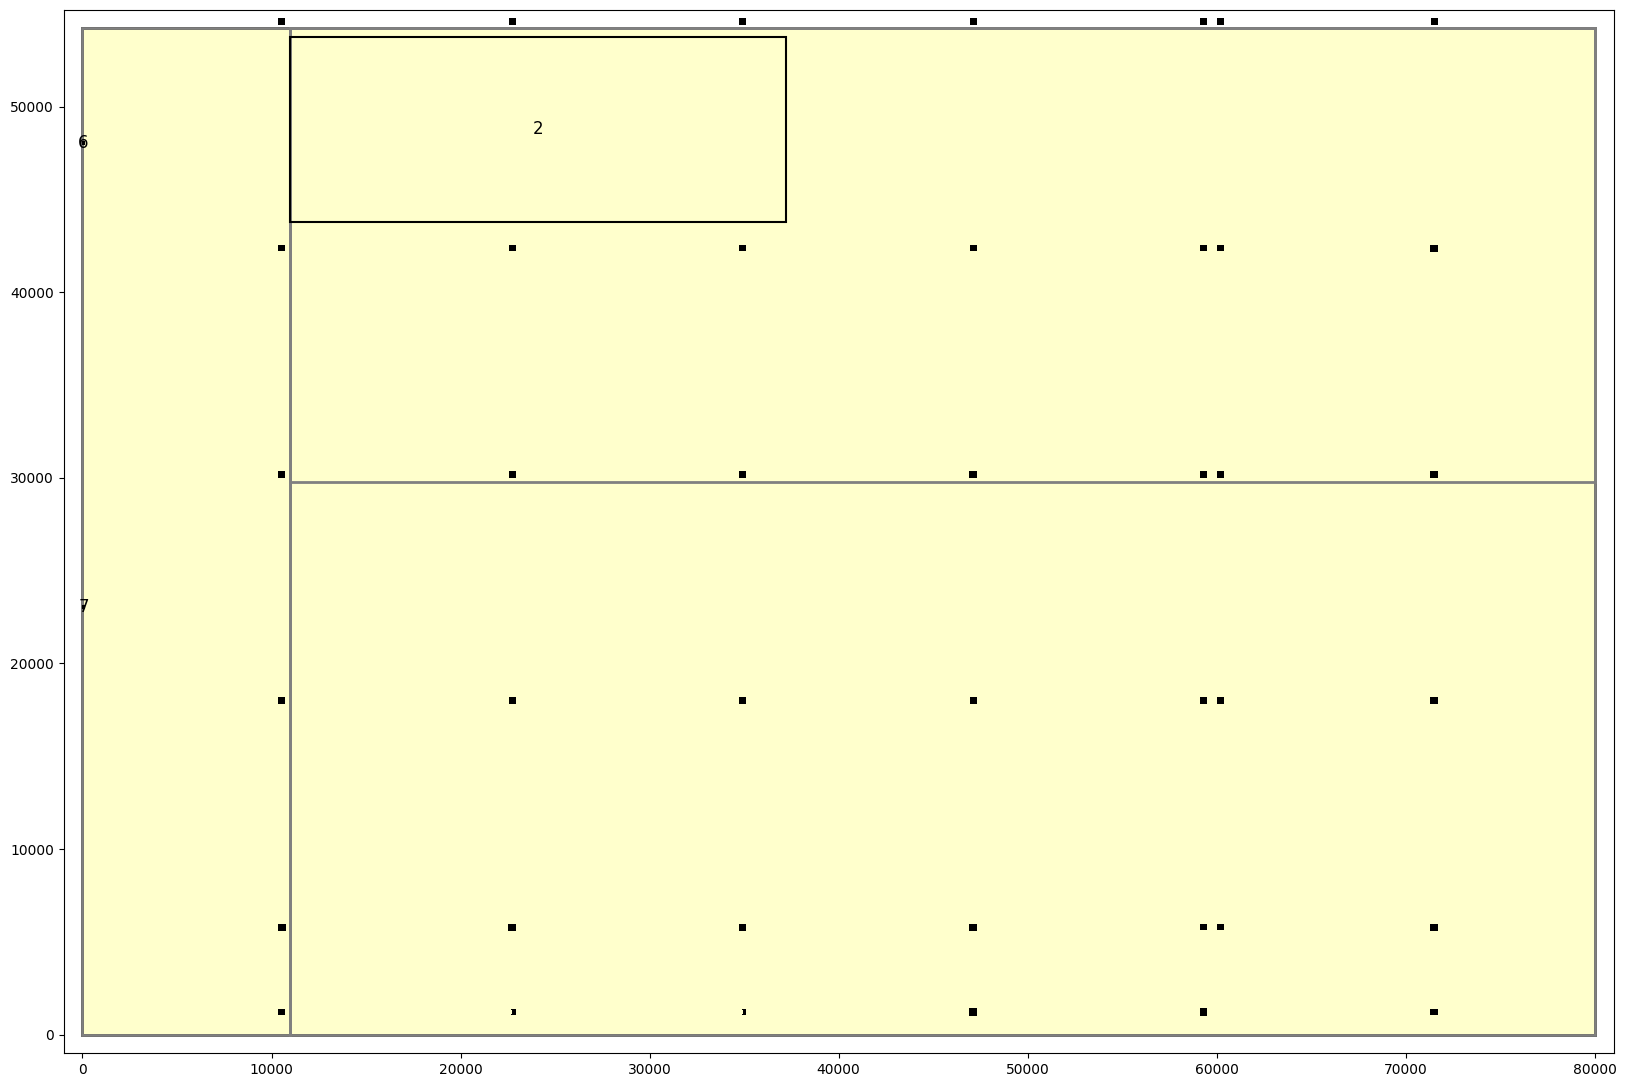

우선배치:  0
{np.int64(6): (100.0, 100.0), np.int64(7): (100.0, 100.0), 2: (np.int64(26243), np.int64(9950)), 0: (np.int64(103750), np.int64(6882))}
{np.int64(6): (100.0, 100.0), np.int64(7): (100.0, 100.0), 2: (np.int64(26243), np.int64(9950)), 0: (np.int64(103750), np.int64(6882))}
{np.int64(6): (100.0, 100.0), np.int64(7): (100.0, 100.0), 2: (np.int64(26243), np.int64(9950)), 0: (np.int64(6882), np.int64(103750))}
{np.int64(6): (100.0, 100.0), np.int64(7): (100.0, 100.0), 2: (np.int64(26243), np.int64(9950)), 0: (np.int64(6882), np.int64(103750))}


KeyError: 0

In [ ]:
STEPSIZE=1000
for pathKey,pathVal in candPath.items():
    direc=cal_Direc(candPath[pathKey])
    expected_position=cal_exPosition(candPath[pathKey])
    ro_path=merge_paths_before_first_overlap(pathVal)
    X,Y,o,di=copy.deepcopy(iniSol)
    s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0=copy.deepcopy(iniStorage)
    df_selected=copy.deepcopy(ini_df_selected)
    lay_clusters=copy.deepcopy(ini_lay_clusters)
    for c in ro_path:

        if c in pre_C:
            continue
        if c in X:
            continue
        if df_selected.loc[c,'type']=='production':

            print("우선배치: ",c)
            o[c]=0
            di[c]=0 
            fe_2=True
            re=0


            while fe_2:
                if re!=0:

                    o[c]=0

                    if k[c]==0:

                        k_cluster[c]['y']+=1
                        k_x_real=df_selected.loc[c,'설비수량']/k_cluster[c]['y']
                        k_cluster[c]['x']=math.ceil(df_selected.loc[c,'설비수량']/k_cluster[c]['y'])
                        if k_x_real<1:
                            raise("!!!!")
                        if k_cluster[c]['y']>20:
                            raise("!!!!")
                        df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                        if (total_expand[c][0]+total_expand[c][1]==2) or (total_expand[c][2]+total_expand[c][3]==2):
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)    
                        elif total_expand[c][2]==1:
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UA']*(k_cluster[c]['y']//2)
                            if k_cluster[c]['y']%2==1:
                                df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UA']
                            else:
                                df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UB']
                        else:
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UB']*(k_cluster[c]['y']//2)
                            if k_cluster[c]['y']%2==1:
                                df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UB']
                            else:
                                df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UA']                        
                    else:

                        k_cluster[c]['x']+=1
                        k_cluster[c]['y']=math.ceil(df_selected.loc[c,'설비수량']/k_cluster[c]['x'])
                        if df_selected.loc[c,'설비수량']/k_cluster[c]['x']<1:
                            raise("!!!!")
                        df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                        if (total_expand[c][0]+total_expand[c][1]==2) or (total_expand[c][2]+total_expand[c][3]==2):
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)
                        elif total_expand[c][2]==1:
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UA']*(k_cluster[c]['y']//2)
                            if k_cluster[c]['y']%2==1:
                                df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UA']
                            else:
                                df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UB']
                        else:
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UB']*(k_cluster[c]['y']//2)
                            if k_cluster[c]['y']%2==1:
                                df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UB']
                            else:
                                df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UA']     

                W0[c]=df_selected.loc[c,'Cluster_X']
                H0[c]=df_selected.loc[c,'Cluster_Y']
                key=df_selected.at[c,'placeable']
                for _ in range(4):
                    best_distance_k=999999999999999999999
                    best_x=-9999
                    best_y=-9999
                    ro,cl_ck=direction(o,di,W0,H0,df_selected)
                    print(ro)
                    if pl_di[key][0]==1:
                        
                        x_start=pa_bound[key]['minX']+ro[c][0]/2
                    else:
                        x_start=pa_bound[key]['maxX']-(ro[c][0]/2)

                    if pl_di[key][2]==1:
                        y_start=pa_bound[key]['minY']+ro[c][1]/2
                    else:
                        y_start=pa_bound[key]['maxY']-(ro[c][1]/2) 
                    x=x_start
                    y=y_start
                    fe_3=False
                    for _ in range(100000):

                        X[c]=x
                        Y[c]=y

                        totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                        fe,pr_c=is_feasible(totalSolCurrent,c)

                        del X[c]
                        del Y[c]
                        if fe==True:

                            X[c]=x
                            Y[c]=y
                            s=(X,Y,o,di)
                            enex=cal_enex(X)
                            distance_k=cal_distance(s,c)
                            del X[c]
                            del Y[c]
                            fe_3=True
                            if distance_k<best_distance_k:
                                best_x=x
                                best_y=y
                                best_o=o[c]
                                best_di=di[c] 
                                best_distance_k=distance_k


                        if pl_di[key][0]==1:
                            if x+ro[c][0]/2<pa_bound[key]['maxX']:
                                if pr_c==None:
                                    x+=STEPSIZE
                                else:
                                    x=X[pr_c]+ro[pr_c][0]/2+ro[c][0]/2+max(cl_ck[pr_c][0],cl_ck[c][2])
                            else:
                                if pl_di[key][2]==1:
                                    if pr_c==None:
                                        y+=STEPSIZE
                                    else:
                                        y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                                    if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                        break
                                    x=x_start
                                else:
                                    if pr_c==None:
                                        y-=STEPSIZE
                                    else:
                                        y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                    if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                        break
                                    x=x_start
                        else:
                            if x-ro[c][0]/2>pa_bound[key]['minX']:
                                if pr_c==None:
                                    x-=STEPSIZE
                                else:
                                    x=X[pr_c]-ro[pr_c][0]/2-ro[c][0]/2-max(cl_ck[pr_c][2],cl_ck[c][0])
                            else:
                                if pl_di[key][2]==1:
                                    if pr_c==None:
                                        y+=STEPSIZE
                                    else:
                                        y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                                    if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                        break
                                    x=x_start
                                else:
                                    if pr_c==None:
                                        y-=STEPSIZE
                                    else:
                                        y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                    if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                        break
                                    x=x_start                            

                    if fe_3==True:
                        fe_2=False
                        break
                    else:
                        if (o[c]==0) and (di[c]==0):
                            di[c]=1
                        elif (o[c]==0) and (di[c]==1):
                            if (re!=0) and ((total_expand[c][0]+total_expand[c][1]==1) or (total_expand[c][2]+total_expand[c][3]==1)):                       
                                re+=1
                                break
                            else:
                                o[c]=1
                                di[c]=0
                        elif (o[c]==1) and (di[c]==0):
                            di[c]=1
                        else:
                            if c==4:
                                print("fe_2: ",fe_2)
                            re+=1
                if best_distance_k!=999999999999999999999:
                    fe_4=True
                    X[c]=best_x
                    Y[c]=best_y
                    o[c]=best_o
                    di[c]=best_di
                    lay_clusters.append(c)
                    plt_lay_cluster()
                    best_d=best_distance_k
        else:

            key=df_selected.at[c,'placeable']
            if df_selected.loc[c,'type']=='extendableStocker':
                k_cluster[c]['y']=1
                k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
                df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*k_cluster[c]['x']
                df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*k_cluster[c]['y']

                print("우선배치: ",c)
                o[c]=0
                di[c]=0 
                fe_2=True
                re=0

            elif df_selected.loc[c,'type']=='storage':
                k_cluster[c]['y']=3
                k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
                df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*k_cluster[c]['x']
                df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*k_cluster[c]['y']

                print("우선배치: ",c)
                o[c]=0
                di[c]=0 
                fe_2=True
                re=0
            else:
                raise "$$$$"

            best_best_distance_k=999999999999999999999
            while fe_2:
                if re!=0:
                    o[c]=0
                    if df_selected.loc[c,'type']=='extendableStocker':


                        if k[c]==0:
                            while True:
                                k_cluster[c]['y']+=1
                                k_cluster[c]['x']=df_selected.loc[c,'설비수량']/k_cluster[c]['y']
                                if df_selected.loc[c,'설비수량']/(k_cluster[c]['y']+1)<1:
                                    fe_2=False
                                if k_cluster[c]['x']==round(k_cluster[c]['x']):
                                    break
                            df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)    
                        else:
                            while True:
                                k_cluster[c]['x']+=1
                                k_cluster[c]['y']=df_selected.loc[c,'설비수량']/k_cluster[c]['x']
                                if df_selected.loc[c,'설비수량']/(k_cluster[c]['x']+1)<1:
                                    fe_2=False
                                if k_cluster[c]['y']==round(k_cluster[c]['y']):
                                    break
                            df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                            df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)
                    elif df_selected.loc[c,'type']=='storage':
                        k_cluster[c]['y']+=1
                        k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
                        if (s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*(k_cluster[c]['y']+1)))<1:
                            print("1@#$#$: ",c)
                            fe_2=False
                        if k_cluster[c]['y']>=10:
                            a=[]
                            for i in place_mezz[df_selected.loc[c,'placeable']]:
                                a.append(mezz_areas[i]['ceilingHeight'])
                            
                            if best_best_distance_k!=999999999999999999999:
                                fe_2=False
                            else:
                                if df_selected.at[c,'facilityHeight']==min(a):
                                    fe_2=False
                                else:
                                    df_selected.at[c,'facilityHeight']=min(a)   
                                    for mobile in mobile_storage:
                                        if df_selected[df_selected['설비Group']==mobile['facilityGroup']].index ==c:
                                            s_he_na[c]=math.floor((df_selected.loc[c,'facilityHeight']-(mobile['legLength']+mobile['topMargin'])/1000)/mobile['facilityHeightDouble'])
                                    k_cluster[c]['y']=3
                                    k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
                        df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*k_cluster[c]['x']

                        df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*k_cluster[c]['y']
                    else:
                        raise "!!!!"
                W0[c]=df_selected.loc[c,'Cluster_X']
                H0[c]=df_selected.loc[c,'Cluster_Y']

                for _ in range(2):
                    best_distance_k=999999999999999999999
                    best_x=-9999
                    best_y=-9999
                    ro,cl_ck=direction(o,di,W0,H0,df_selected)
                    print(ro)
                    if pl_di[key][0]==1:
                        x_start=pa_bound[key]['minX']+ro[c][0]/2+cl_ck[c][2]
                    else:
                        x_start=pa_bound[key]['maxX']-(ro[c][0]/2+cl_ck[c][2])

                    if pl_di[key][2]==1:
                        y_start=pa_bound[key]['minY']+ro[c][1]/2+cl_ck[c][1]
                    else:
                        y_start=pa_bound[key]['maxY']-(ro[c][1]/2+cl_ck[c][1]) 
                    x=x_start
                    y=y_start
                    fe_3=False
                    for _ in range(100000):
                        X[c]=x
                        Y[c]=y
                        totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                        fe,pr_c=is_feasible(totalSolCurrent,c)
                        del X[c]
                        del Y[c]
                        if fe==True:

                            enex=cal_enex(X)
                            X[c]=x
                            Y[c]=y
                            s=(X,Y,o,di)
                            enex=cal_enex(X)
                            distance_k=cal_distance(s,c)
                            del X[c]
                            del Y[c]
                            fe_3=True
                            if distance_k<best_distance_k:
                                best_x=x
                                best_y=y
                                best_o=o[c]
                                best_di=di[c] 
                                best_distance_k=distance_k

                        if pl_di[key][0]==1:
                            if x+ro[c][0]/2<pa_bound[key]['maxX']:
                                if pr_c==None:
                                    x+=STEPSIZE
                                else:
                                    x=X[pr_c]+ro[pr_c][0]/2+ro[c][0]/2+max(cl_ck[pr_c][0],cl_ck[c][2])
                            else:
                                x=x_start
                                X[c]=x
                                Y[c]=y
                                totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                                fe,pr_c=is_feasible(totalSolCurrent,c)
                                del X[c]
                                del Y[c]                        

                                if pl_di[key][2]==1:
                                    if pr_c==None:
                                        y+=STEPSIZE
                                    else:
                                        jump_y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])

                                        if abs(jump_y-y)<STEPSIZE:
                                            y=jump_y
                                            if c==7:
                                                print("x_start: ",x_start)
                                                print("y: ",y)
                                        else:
                                            y+=STEPSIZE
                                    if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                        break

                                else:
                                    if pr_c==None:
                                        y-=STEPSIZE
                                    else:
                                        jump_y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                        if abs(jump_y-y)<STEPSIZE:
                                            y=jump_y
                                        else:
                                            y-=STEPSIZE                                
                                    if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                        break

                        else:
                            if x-ro[c][0]/2>pa_bound[key]['minX']:
                                if pr_c==None:
                                    x-=STEPSIZE
                                else:
                                    x=X[pr_c]-ro[pr_c][0]/2-ro[c][0]/2-max(cl_ck[pr_c][2],cl_ck[c][0])
                            else:
                                x=x_start
                                X[c]=x
                                Y[c]=y
                                totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                                fe,pr_c=is_feasible(totalSolCurrent,c)
                                del X[c]
                                del Y[c]    
                                if pl_di[key][2]==1:

                                    if pr_c==None:
                                        y+=STEPSIZE
                                    else:
                                        jump_y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                                        if abs(jump_y-y)<STEPSIZE:
                                            y=jump_y

                                        else:
                                            y+=STEPSIZE

                                    if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                        break
                                    x=x_start
                                else:
                                    if pr_c==None:
                                        y-=STEPSIZE
                                    else:
                                        jump_y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                        if abs(jump_y-y)<STEPSIZE:
                                            y=jump_y
                                        else:
                                            y-=STEPSIZE
                                    if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                        break


                    if fe_3==True:
                        if best_distance_k<best_best_distance_k:
                            best_best_x=best_x
                            best_best_y=best_y
                            best_best_o=best_o
                            best_best_di=best_di
                            best_best_k_cluster_x=k_cluster[c]['x']
                            best_best_k_cluster_y=k_cluster[c]['y']
                            best_best_distance_k=best_distance_k

                    if o[c]==1:
                        print("!!!!!!!!!!!!!!!")
                        print(c)
                        re+=1
                    o[c]=1                                

            if best_best_distance_k!=999999999999999999999:
                df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*best_best_k_cluster_x
                df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*best_best_k_cluster_y
                W0[c]=df_selected.loc[c,'Cluster_X']
                H0[c]=df_selected.loc[c,'Cluster_Y']
                k_cluster[c]['x']=best_best_k_cluster_x
                k_cluster[c]['y']=best_best_k_cluster_y
                X[c]=best_best_x
                Y[c]=best_best_y
                o[c]=best_best_o
                di[c]=best_best_di
                best_d=best_best_distance_k   
                sfc_to[c]=[]
                sfc_from[c]=[]
                for idx_2 in range(len(group_matrix)):
                    if group_matrix.iloc[idx_2,c]==1:
                        sfc_to[c].append(df_selected.loc[idx_2,'설비Group'])
                    if group_matrix.iloc[c,idx_2]==1:
                        sfc_from[c].append(df_selected.loc[idx_2,'설비Group'])
                lay_clusters.append(c)
            else:
                raise("!!!!!!")
            plt_lay_cluster()   
            s_x_t[c]=k_cluster[c]['x']
            s_y_t[c]=k_cluster[c]['y']     

    candSol[pathKey]=copy.deepcopy((X,Y,o,di))
    candStorage[pathKey]=copy.deepcopy((s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0))
    cand_df_selected[pathKey]=copy.deepcopy(df_selected)
    cand_lay_clusters[pathKey]=copy.deepcopy(lay_clusters)
    cand_obj[pathKey]=best_d
    break

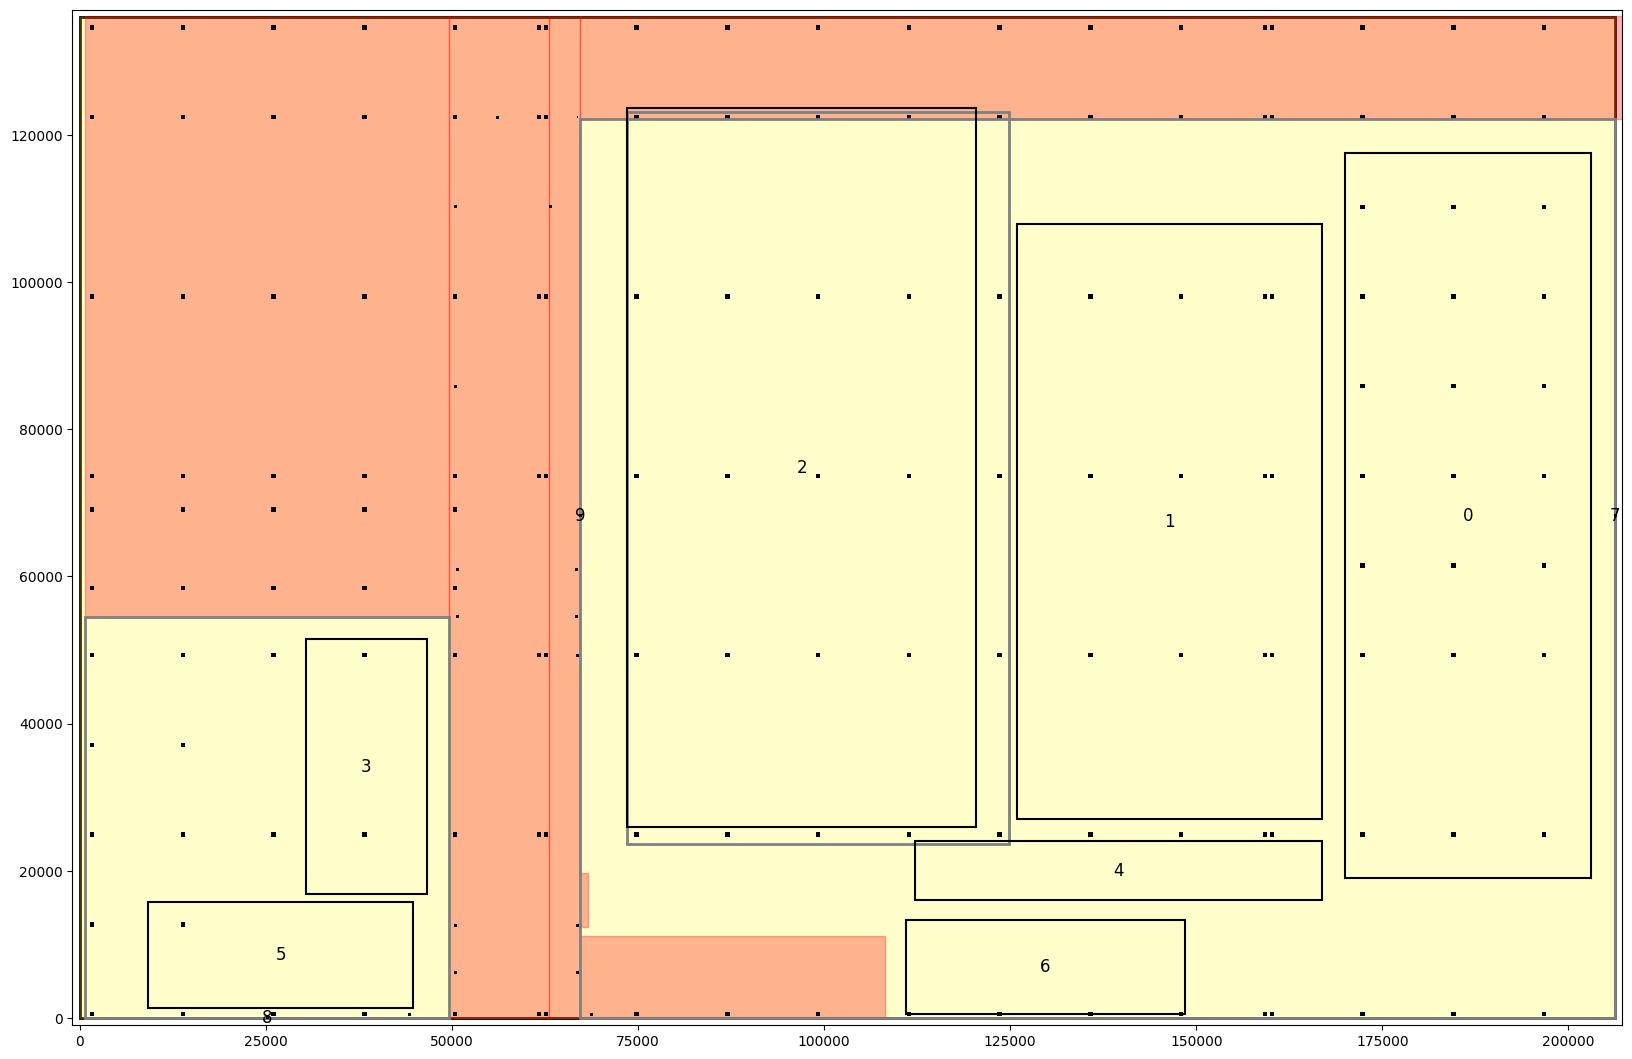

In [ ]:
plt_lay_cluster()

In [ ]:
df_pre = df_selected.loc[df_selected.index.isin(pre_C)].copy()
rows = []

for g in df_pre.index:
    group = df_selected.loc[g,'설비Group']
    for f in range(df_selected.loc[g,'설비수량']):
 
        x_f=df_selected.loc[g,'x'] 
        y_f=df_selected.loc[g,'y']
        row = {
            "설비Group": group,
            "설비번호": f,
            "center_X": 0,
            "center_Y": 0,
            "x": x_f,
            "y": y_f,
            "type": df_selected.loc[g,'type'],
            "회전":0,
            "k":0,
            "대칭":0
        }
        rows.append(row)


df_pre = pd.DataFrame(rows)       
for c in df_pre.index:
    for da in data['fixedFacilityPositions']:
        if f"{df_pre.loc[c,'설비Group']}_{df_pre.loc[c,'설비번호']}" == da['facilityId']:
            if da['rotation']==0:
                df_pre.loc[c,'회전']=0
                df_pre.loc[c,'k']=0
                df_pre.loc[c,'대칭']=0
                df_pre.loc[c,'center_X']=float(da['position']['x'])+df_pre.loc[c,'x']/2
                df_pre.loc[c,'center_Y']=float(da['position']['y'])+df_pre.loc[c,'y']/2
            elif da['rotation']==270:
                df_pre.loc[c,'회전']=1
                df_pre.loc[c,'대칭']=0
                df_pre.loc[c,'center_X']=float(da['position']['x'])+df_pre.loc[c,'y']/2
                df_pre.loc[c,'center_Y']=float(da['position']['y'])-df_pre.loc[c,'x']/2
            elif da['rotation']==180:
                df_pre.loc[c,'회전']=0
                df_pre.loc[c,'k']=1
                df_pre.loc[c,'대칭']=1
                df_pre.loc[c,'center_X']=float(da['position']['x'])-df_pre.loc[c,'x']/2
                df_pre.loc[c,'center_Y']=float(da['position']['y'])-df_pre.loc[c,'y']/2
            else:
                df_pre.loc[c,'회전']=1
                df_pre.loc[c,'k']=1
                df_pre.loc[c,'대칭']=1
                df_pre.loc[c,'center_X']=float(da['position']['x'])-df_pre.loc[c,'y']/2
                df_pre.loc[c,'center_Y']=float(da['position']['y'])+df_pre.loc[c,'x']/2


In [ ]:
# for c in df_pre.index:
#     if df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['processGroup'].iloc[0]=='dock':
#         continue
#     if (total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][0]==1)& (total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][1]==1):
#         if df_pre.loc[c,'회전']==0:
#             df_pre.loc[c,'center_X']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]            
#         else:
#             df_pre.loc[c,'center_Y']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]  
#     if  (total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][2]==1)&(total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][3]==1):
#         if df_pre.loc[c,'회전']==0:
#             df_pre.loc[c,'center_Y']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0] 
#         else:
#             df_pre.loc[c,'center_X']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]  

In [ ]:
for c in df_pre.index:
    if df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['processGroup'].iloc[0]=='dock':
        continue
    
    expandX=total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][0]+total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][1]
    
    expandY=total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][1]+total_expand[df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']].index[0]][2]
    
    if df_pre.loc[c,'회전']==0:
        df_pre.loc[c,'center_X']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]*expandX/2            
        df_pre.loc[c,'center_Y']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]*expandY/2
    else:
        df_pre.loc[c,'center_Y']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]*expandX/2            
        df_pre.loc[c,'center_X']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]*expandY/2


C:\Users\86993\AppData\Local\Temp\ipykernel_4224\1084193497.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '92018.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pre.loc[c,'center_X']-=df_selected[df_selected['설비Group']==df_pre.loc[c,'설비Group']]['pathWidth'].iloc[0]*expandY/2


# 초기해 개선 알고리즘

In [ ]:
def updateStorage(totalSol,c):
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    for mobile in mobile_storage:
        if df_selected[df_selected['설비Group']==mobile['facilityGroup']].index ==c:
            s_he_na[c]=math.floor((df_selected.loc[c,'facilityHeight']-(mobile['legLength']+mobile['topMargin'])/1000)/mobile['facilityHeightDouble'])
    STEPSIZE=2000
    key=df_selected.at[c,'placeable']

    k_cluster[c]['y']=3
    k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
    df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*k_cluster[c]['x']
    df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*k_cluster[c]['y']

    print("우선배치: ",c)
    
    o[c]=0
    di[c]=0 
    fe_2=True
    re=0

    best_best_distance_k=999999999999999999999
    while fe_2:
        if re!=0:
            o[c]=0

            k_cluster[c]['y']+=1
            k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
            if (s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*(k_cluster[c]['y']+1)))<1:
                print("1@#$#$: ",c)
                fe_2=False
            if k_cluster[c]['y']>=7:
                a=[]
                for i in place_mezz[df_selected.loc[c,'placeable']]:
                    a.append(mezz_areas[i]['ceilingHeight'])

                if best_best_distance_k!=999999999999999999999:
                    fe_2=False
                else:
                    if df_selected.at[c,'facilityHeight']==min(a):
                        fe_2=False
                    else:
                        df_selected.at[c,'facilityHeight']=min(a)   
                        for mobile in mobile_storage:
                            if df_selected[df_selected['설비Group']==mobile['facilityGroup']].index ==c:
                                s_he_na[c]=math.floor((df_selected.loc[c,'facilityHeight']-(mobile['legLength']+mobile['topMargin'])/1000)/mobile['facilityHeightDouble'])
                        k_cluster[c]['y']=3
                        k_cluster[c]['x']=math.ceil(s_cell_na[df_selected.loc[c,'설비Group']]/(s_he_na[c]*k_cluster[c]['y']))
            df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*k_cluster[c]['x']
            df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*k_cluster[c]['y']


        W0[c]=df_selected.loc[c,'Cluster_X']
        H0[c]=df_selected.loc[c,'Cluster_Y']
        
        for _ in range(2):
            best_distance_k=999999999999999999999
            best_x=-9999
            best_y=-9999
            ro,cl_ck=direction(o,di,W0,H0,df_selected)
            print(ro)
            if pl_di[key][0]==1:
                x_start=pa_bound[key]['minX']+ro[c][0]/2+cl_ck[c][2]
            else:
                x_start=pa_bound[key]['maxX']-(ro[c][0]/2+cl_ck[c][2])

            if pl_di[key][2]==1:
                y_start=pa_bound[key]['minY']+ro[c][1]/2+cl_ck[c][1]
            else:
                y_start=pa_bound[key]['maxY']-(ro[c][1]/2+cl_ck[c][1]) 
            x=x_start
            y=y_start
            fe_3=False
            for _ in range(100000):

                X[c]=x
                Y[c]=y
                totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                fe,pr_c=is_feasible(totalSolCurrent,c)

                del X[c]
                del Y[c]
                if fe==True:

                    X[c]=x
                    Y[c]=y
                    totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                    distance_k=cal_obj(totalSolCurrent)
                    del X[c]
                    del Y[c]
                    fe_3=True
                    if distance_k<best_distance_k:
                        best_x=x
                        best_y=y
                        best_o=o[c]
                        best_di=di[c] 
                        best_distance_k=distance_k

                if pl_di[key][0]==1:
                    if x+ro[c][0]/2<pa_bound[key]['maxX']:
                        if pr_c==None:
                            x+=STEPSIZE
                        else:
                            x=X[pr_c]+ro[pr_c][0]/2+ro[c][0]/2+max(cl_ck[pr_c][0],cl_ck[c][2])
                    else:
                        x=x_start
                        X[c]=x
                        Y[c]=y
                        totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                        fe,pr_c=is_feasible(totalSolCurrent,c)
                        del X[c]
                        del Y[c]                        

                        if pl_di[key][2]==1:
                            if pr_c==None:
                                y+=STEPSIZE
                            else:
                                jump_y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])

                                if abs(jump_y-y)<STEPSIZE:
                                    y=jump_y

                                else:
                                    y+=STEPSIZE
                            if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                break

                        else:
                            if pr_c==None:
                                y-=STEPSIZE
                            else:
                                jump_y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                if abs(jump_y-y)<STEPSIZE:
                                    y=jump_y
                                else:
                                    y-=STEPSIZE                                
                            if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                break

                else:
                    if x-ro[c][0]/2>pa_bound[key]['minX']:
                        if pr_c==None:
                            x-=STEPSIZE
                        else:
                            x=X[pr_c]-ro[pr_c][0]/2-ro[c][0]/2-max(cl_ck[pr_c][2],cl_ck[c][0])
                    else:
                        x=x_start
                        X[c]=x
                        Y[c]=y
                        totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                        fe,pr_c=is_feasible(totalSolCurrent,c)
                        del X[c]
                        del Y[c]    
                        if pl_di[key][2]==1:

                            if pr_c==None:
                                y+=STEPSIZE
                            else:
                                jump_y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                                if abs(jump_y-y)<STEPSIZE:
                                    y=jump_y
                                    if c==7:
                                        print("x_start: ",x_start)
                                        print("y: ",y)
                                else:
                                    y+=STEPSIZE

                            if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                break
                            x=x_start
                        else:
                            if pr_c==None:
                                y-=STEPSIZE
                            else:
                                jump_y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                                if abs(jump_y-y)<STEPSIZE:
                                    y=jump_y
                                else:
                                    y-=STEPSIZE
                            if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                break


            if fe_3==True:
                if best_distance_k<best_best_distance_k:
                    best_best_x=best_x
                    best_best_y=best_y
                    best_best_o=best_o
                    best_best_di=best_di
                    best_best_k_cluster_x=k_cluster[c]['x']
                    best_best_k_cluster_y=k_cluster[c]['y']
                    best_best_distance_k=best_distance_k

            if o[c]==1:
                print("!!!!!!!!!!!!!!!")
                print(c)
                re+=1
            o[c]=1                                

    if best_best_distance_k!=999999999999999999999:
        df_selected.at[c,'Cluster_X']= a_s_dic[c]+b_s_dic[c]*best_best_k_cluster_x
        df_selected.at[c,'Cluster_Y']= d_s_dic[c]+c_s_dic[c]*best_best_k_cluster_y
        W0[c]=df_selected.loc[c,'Cluster_X']
        H0[c]=df_selected.loc[c,'Cluster_Y']
        k_cluster[c]['x']=best_best_k_cluster_x
        k_cluster[c]['y']=best_best_k_cluster_y
        s_x_t[c]=k_cluster[c]['x']
        s_y_t[c]=k_cluster[c]['y']    
        X[c]=best_best_x
        Y[c]=best_best_y
        o[c]=best_best_o
        di[c]=best_best_di
        best_d=best_best_distance_k   
        sfc_to[c]=[]
        sfc_from[c]=[]
        for idx_2 in range(len(group_matrix)):
            if group_matrix.iloc[idx_2,c]==1:
                sfc_to[c].append(df_selected.loc[idx_2,'설비Group'])
            if group_matrix.iloc[c,idx_2]==1:
                sfc_from[c].append(df_selected.loc[idx_2,'설비Group'])
        lay_clusters.append(c)
        totalBestSol=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
        return totalBestSol
    else:
        return None

 
    

In [ ]:
def updateFacility(totalSol,c):
    STEPSIZE=2000
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    o[c]=0
    di[c]=0 
    fe_2=True
    re=0


    while fe_2:
        if re!=0:
            o[c]=0
            di[c]=0
            if k[c]==0:

                k_cluster[c]['y']+=1
                k_cluster[c]['x']=math.ceil(df_selected.loc[c,'설비수량']/k_cluster[c]['y'])
                if k_cluster[c]['x']<1:
                    raise("!!!!")
                if k_cluster[c]['y']>10:
                    raise("!!!!")
                df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                if (total_expand[c][2]+total_expand[c][3]==0) or (total_expand[c][2]+total_expand[c][3]==2):
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)    
                elif total_expand[c][2]==1:
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UA']*(k_cluster[c]['y']//2)
                    if k_cluster[c]['y']%2==1:
                        df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UA']
                    else:
                        df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UB']
                else:
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UB']*(k_cluster[c]['y']//2)
                    if k_cluster[c]['y']%2==1:
                        df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UB']
                    else:
                        df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UA']                        
            else:
                while True:
                    k_cluster[c]['x']+=1
                    k_cluster[c]['y']=df_selected.loc[c,'설비수량']/k_cluster[c]['x']
                    if k_cluster[c]['y']<1:
                        raise("!!!!")
                    if k_cluster[c]['y']==round(k_cluster[c]['y']):
                        break
                df_selected.at[c,'Cluster_X']= k_cluster[c]['x']*df_selected.loc[c,'x']+ max(df_selected.loc[c,'UR'],df_selected.loc[c,'UL'])*(k_cluster[c]['x']-1)
                if (total_expand[c][2]+total_expand[c][3]==0) or (total_expand[c][2]+total_expand[c][3]==2):
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ max(df_selected.loc[c,'UB'],df_selected.loc[c,'UA'])*(k_cluster[c]['y']-1)
                elif total_expand[c][2]==1:
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UA']*(k_cluster[c]['y']//2)
                    if k_cluster[c]['y']%2==1:
                        df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UA']
                    else:
                        df_selected.at[c,'cluster_UA']=df_selected.loc[c,'UB']
                else:
                    df_selected.at[c,'Cluster_Y']= k_cluster[c]['y']*df_selected.loc[c,'y']+ df_selected.loc[c,'UB']*(k_cluster[c]['y']//2)
                    if k_cluster[c]['y']%2==1:
                        df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UB']
                    else:
                        df_selected.at[c,'cluster_UB']=df_selected.loc[c,'UA']     

        W0[c]=df_selected.loc[c,'Cluster_X']
        H0[c]=df_selected.loc[c,'Cluster_Y']
        key=df_selected.at[c,'placeable']
        best_distance_k=999999999999999999999
        best_x=-9999
        best_y=-999999999999999999999
        for _ in range(4):

            ro,cl_ck=direction(o,di,W0,H0,df_selected)
            print(ro)
            if pl_di[key][0]==1:
                x_start=pa_bound[key]['minX']+ro[c][0]/2
            else:
                x_start=pa_bound[key]['maxX']-(ro[c][0]/2)

            if pl_di[key][2]==1:
                y_start=pa_bound[key]['minY']+ro[c][1]/2
            else:
                y_start=pa_bound[key]['maxY']-(ro[c][1]/2) 
            x=x_start
            y=y_start
            fe_3=False
            for _ in range(100000):

                X[c]=x
                Y[c]=y

                totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                fe,pr_c=is_feasible(totalSolCurrent,c)

                del X[c]
                del Y[c]
                if fe==True:

                    X[c]=x
                    Y[c]=y
                    totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                    distance_k=cal_obj(totalSolCurrent)
                    del X[c]
                    del Y[c]
                    fe_3=True
                    if distance_k<best_distance_k:
                        X[c]=x
                        Y[c]=y
                        best_distance_k=distance_k
                        lay_clusters.append(c)
                        totalBestSol=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
                        lay_clusters.remove(c)
                        del X[c]
                        del Y[c]
                if pl_di[key][0]==1:
                    if x+ro[c][0]/2<pa_bound[key]['maxX']:
                        if pr_c==None:
                            x+=STEPSIZE
                        else:
                            x=X[pr_c]+ro[pr_c][0]/2+ro[c][0]/2+max(cl_ck[pr_c][0],cl_ck[c][2])
                    else:
                        if pl_di[key][2]==1:
                            if pr_c==None:
                                y+=STEPSIZE
                            else:
                                y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                            if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                break
                            x=x_start
                        else:
                            if pr_c==None:
                                y-=STEPSIZE
                            else:
                                y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                            if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                break
                            x=x_start
                else:
                    if x-ro[c][0]/2>pa_bound[key]['minX']:
                        if pr_c==None:
                            x-=STEPSIZE
                        else:
                            x=X[pr_c]-ro[pr_c][0]/2-ro[c][0]/2-max(cl_ck[pr_c][2],cl_ck[c][0])
                    else:
                        if pl_di[key][2]==1:
                            if pr_c==None:
                                y+=STEPSIZE
                            else:
                                y=Y[pr_c]+ro[pr_c][1]/2+ro[c][1]/2+max(cl_ck[pr_c][3],cl_ck[c][1])
                            if y+ro[c][1]/2+cl_ck[c][3]>pa_bound[key]['maxY']:
                                break
                            x=x_start
                        else:
                            if pr_c==None:
                                y-=STEPSIZE
                            else:
                                y=Y[pr_c]-ro[pr_c][1]/2-ro[c][1]/2-max(cl_ck[pr_c][1],cl_ck[c][3])
                            if y-ro[c][1]/2-cl_ck[c][1]<pa_bound[key]['minY']:
                                break
                            x=x_start                            



            if (o[c]==0) and (di[c]==0):
                di[c]=1
            elif (o[c]==0) and (di[c]==1):
                o[c]=1
                di[c]=0
            elif (o[c]==1) and (di[c]==0):
                di[c]=1
            else:
                if fe_3==True:
                    fe_2=False
                    break
                re+=1
        if best_distance_k!=999999999999999999999:
            
            
            fe_4=True
            return totalBestSol
        else:
            return None

In [ ]:
def try_move_one(totalSol, facility_id,
                 dx_candidates, dy_candidates,
                 max_trial=20):
    """
    s: (X, Y, o, di)
    facility_id: 움직일 설비 번호 (예: 0~9)
    dx_candidates, dy_candidates: 이동 후보 리스트 (예: [-5000, 0, 5000])
    max_trial: 이 설비로 feasible move를 찾아보는 최대 시도 횟수

    반환값:
        - feasible한 이웃해 s' (튜플 (X',Y',o',di'))
        - 못 찾으면 None
    """

    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    for _ in range(max_trial):
        if random.randint(0,1)==0:
            dx = random.choice(dx_candidates)
            dy=0  
        else:
            dx=0
            dy = random.choice(dy_candidates)
        # 0,0은 의미 없으니 패스
        if dx == 0 and dy == 0:
            continue

        # dict 복사해서 설비 하나만 이동
        newX = copy.deepcopy(X)
        newY =  copy.deepcopy(Y)
        newX[facility_id] = newX[facility_id] + dx
        newY[facility_id] = newY[facility_id] + dy

        totalSolNew=copy.deepcopy(((newX,newY,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))

        # 기존에 만든 feasibility 함수로 체크
        fe,pr_c=is_feasible(totalSolNew,facility_id)
        if fe:
            return totalSolNew

    # max_trial 번 안에 feasible move를 못 찾으면 실패
    return None

def simulated_annealing(
    totalSol,facility_ids, dx_candidates, dy_candidates,T0,alpha,
    iter_per_temp,max_outer_iter,iter_list,obj_list,objBest_list):
    
    """
    initial_solution: 초기해 s0 = (X, Y, o, di)
    facility_ids: 설비 번호 리스트 (예: list(X.keys()))
    dx_candidates, dy_candidates: try_move_one에 넘길 step 후보

    반환값:
        best_solution, best_value
    """

    # 현재 해 & best 해 초기화
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    curr_val = cal_obj(totalSol)
    totalSolCurrent=copy.deepcopy(totalSol)
    totalBestSol=copy.deepcopy(totalSol)
    best_val = curr_val

    T = T0

    for outer in range(max_outer_iter):
        for inner in range(iter_per_temp):

            # 1. 설비 하나 랜덤 선택
            i = random.choice(facility_ids)

            # 2. 이 설비를 조금 움직여서 이웃 생성
            totalSolNeighbor = try_move_one(totalSolCurrent, i,
                                    dx_candidates, dy_candidates)
            # feasible move를 못 찾았으면 이번 iteration은 건너뜀
            if totalSolNeighbor is None:
                continue

            new_val = cal_obj(totalSolNeighbor)
            delta = new_val - curr_val

            # 3. SA 수용 규칙
            if delta <= 0:
                accept = True
            else:
                p = math.exp(-delta / T)
                accept = (random.random() < p)
    #             accept = False

            if accept:
                totalSolCurrent = copy.deepcopy(totalSolNeighbor)
                curr_val = new_val
                
                # best 갱신
                if new_val < best_val:

                    totalBestSol=copy.deepcopy(totalSolNeighbor)
                    best_val = new_val

                    print("=== ",i,"===")
                    print("!!!",best_val)
                    print("!!!",cal_obj(totalBestSol))
            iter_list.append(iter_list[-1]+1)
            obj_list.append(curr_val)
            objBest_list.append(best_val)

        # 4. 온도 감소
        T *= alpha

        # (선택) 너무 작아지면 종료
        if T < 1e-3:  # 문제 스케일에 맞게 조정
            break
            
    return totalBestSol, best_val,T,iter_list,obj_list,objBest_list

In [ ]:
# X,Y,o,di=copy.deepcopy(candSol[best_key])
# s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0=copy.deepcopy(candStorage[best_key])
# df_selected=copy.deepcopy(cand_df_selected[best_key])
# lay_clusters=copy.deepcopy(cand_lay_clusters[best_key])

In [ ]:
min_ob=999999999999999999999
for key in candSol.keys():
    ob=cal_obj((candSol[key],candStorage[key],cand_df_selected[key],cand_lay_clusters[key]))
    if min_ob>=ob:
        min_ob=ob
        best_key=key
        
s0=copy.deepcopy(candSol[best_key])
Storage0=copy.deepcopy(candStorage[best_key])
df_selected0=copy.deepcopy(cand_df_selected[best_key])
lay_clusters0=copy.deepcopy(cand_lay_clusters[best_key])

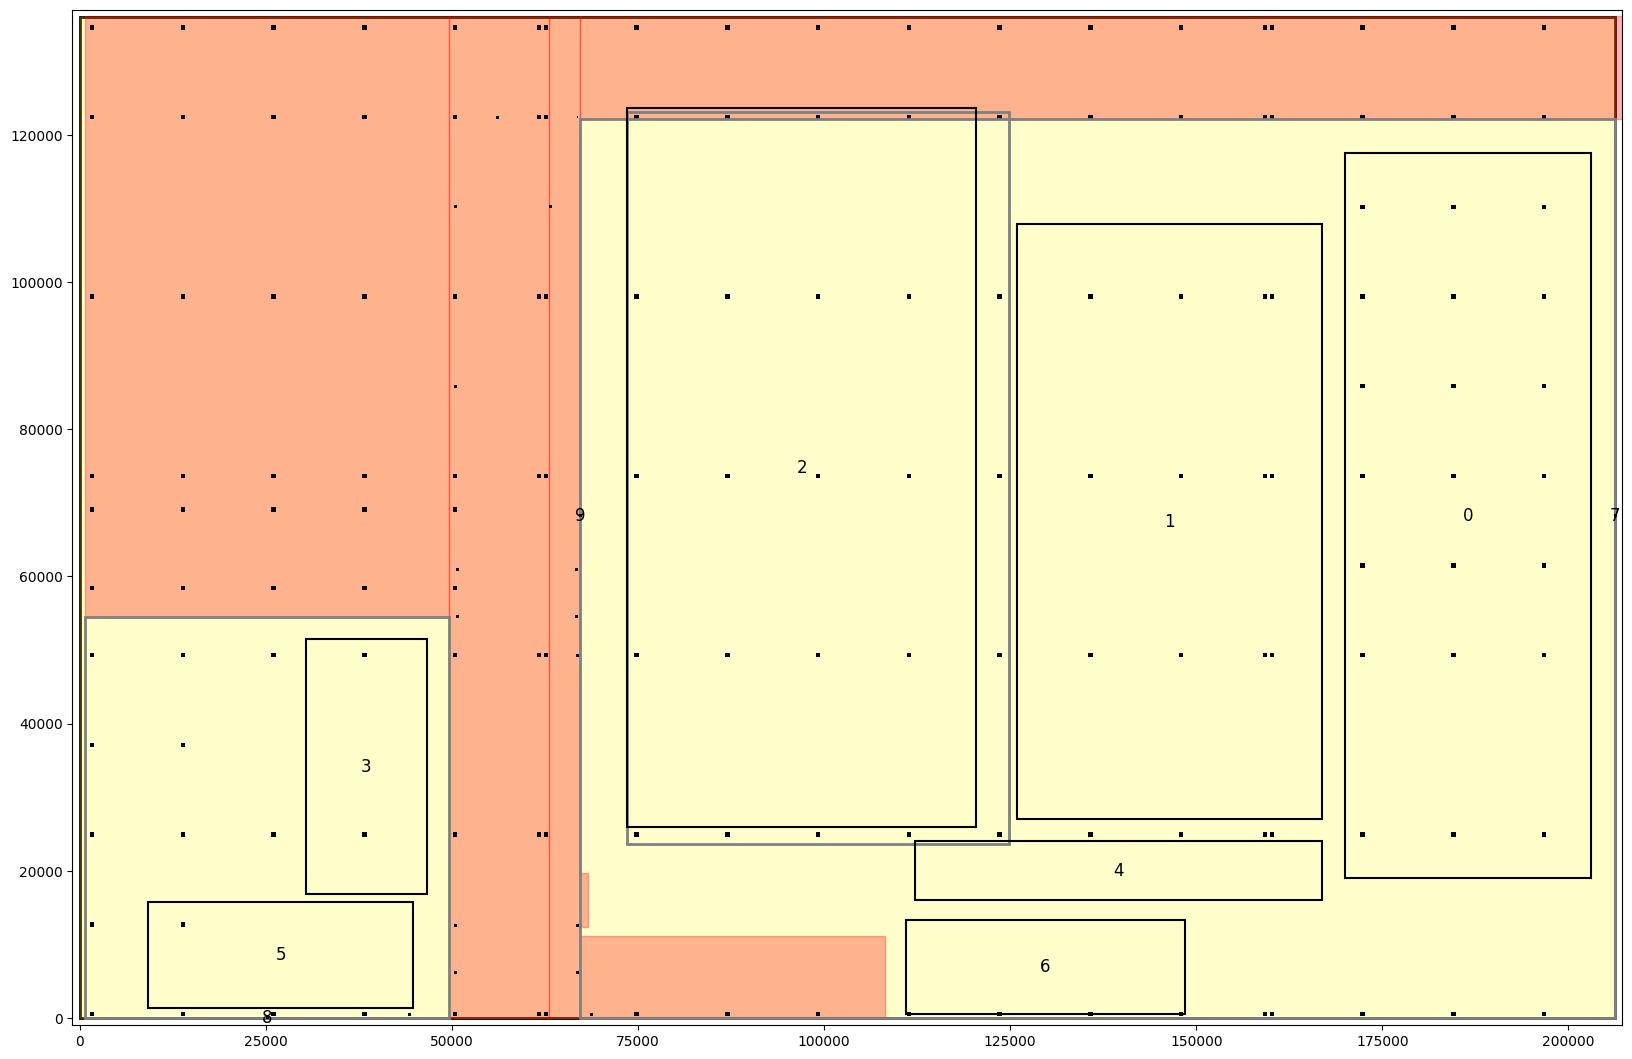

In [ ]:
totalSol_0=copy.deepcopy((s0,Storage0,df_selected0,lay_clusters0))
X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol_0)
plt_lay_cluster()

508800.5
===  6 ===
!!! 507550.5
!!! 507550.5


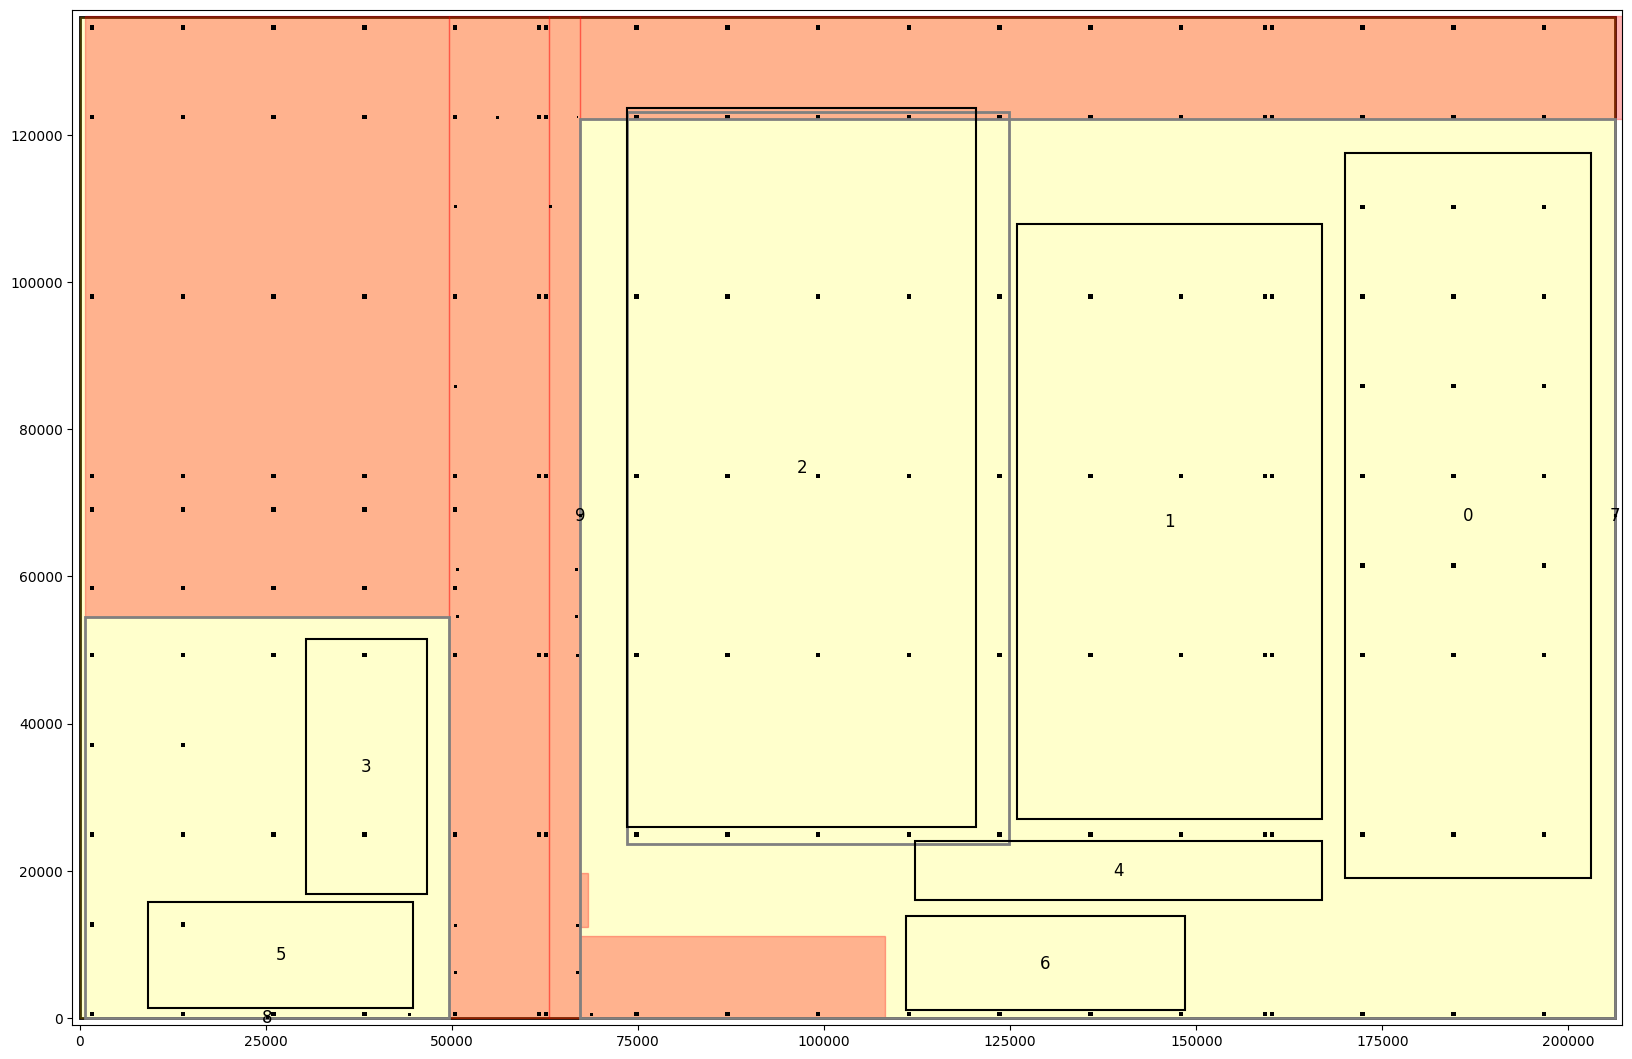

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(0), np.int64(4)]
507550.5
0
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 5: (np.int64(35568), np.int64(14288)), 3: (np.int64(16187), np.int64(34662)), 6: (np.int64(37408), np.int64(12768)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 5: (np.int64(35568), np.int64(14288)), 3: (np.int64(16187), np.int64(34662)), 6: (np.int64(37408), np.int64(12768)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 5: (np.int64(35568), np.int64(14288)), 3: (np.int64(16187), np.int64(34662)), 6: (np.int64(37408), np.int64(12768)), 

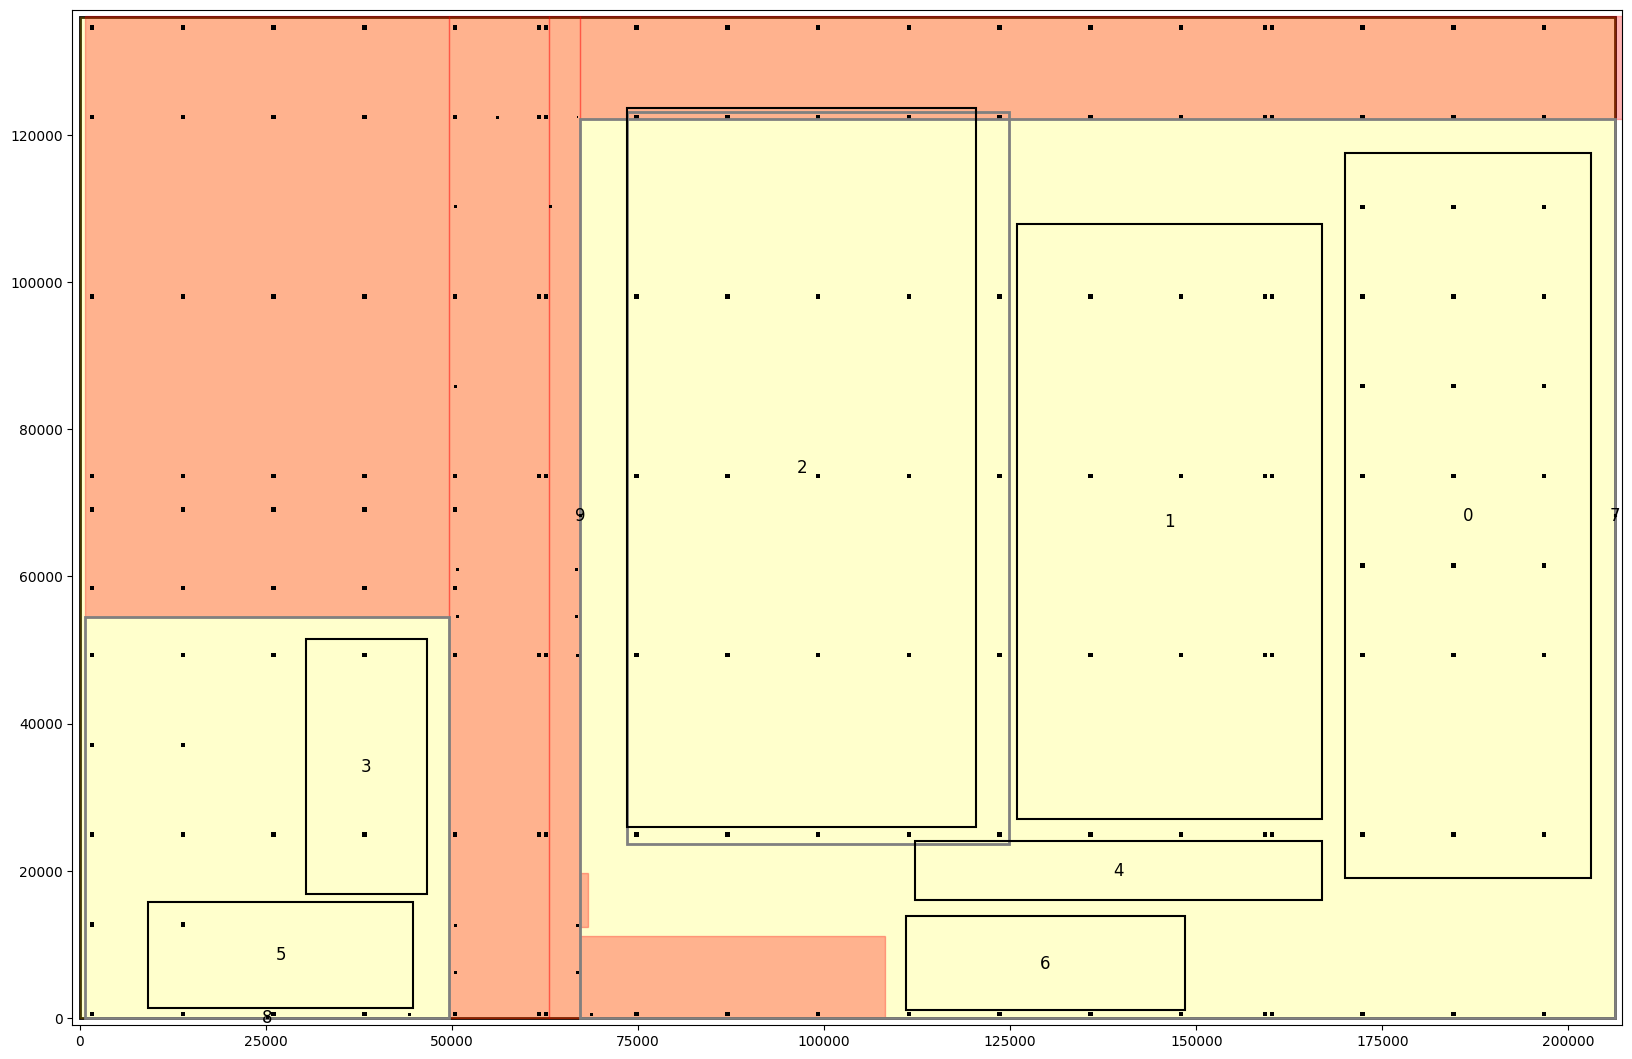

507550.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===  1 ===
!!! 506732.0
!!! 506732.0


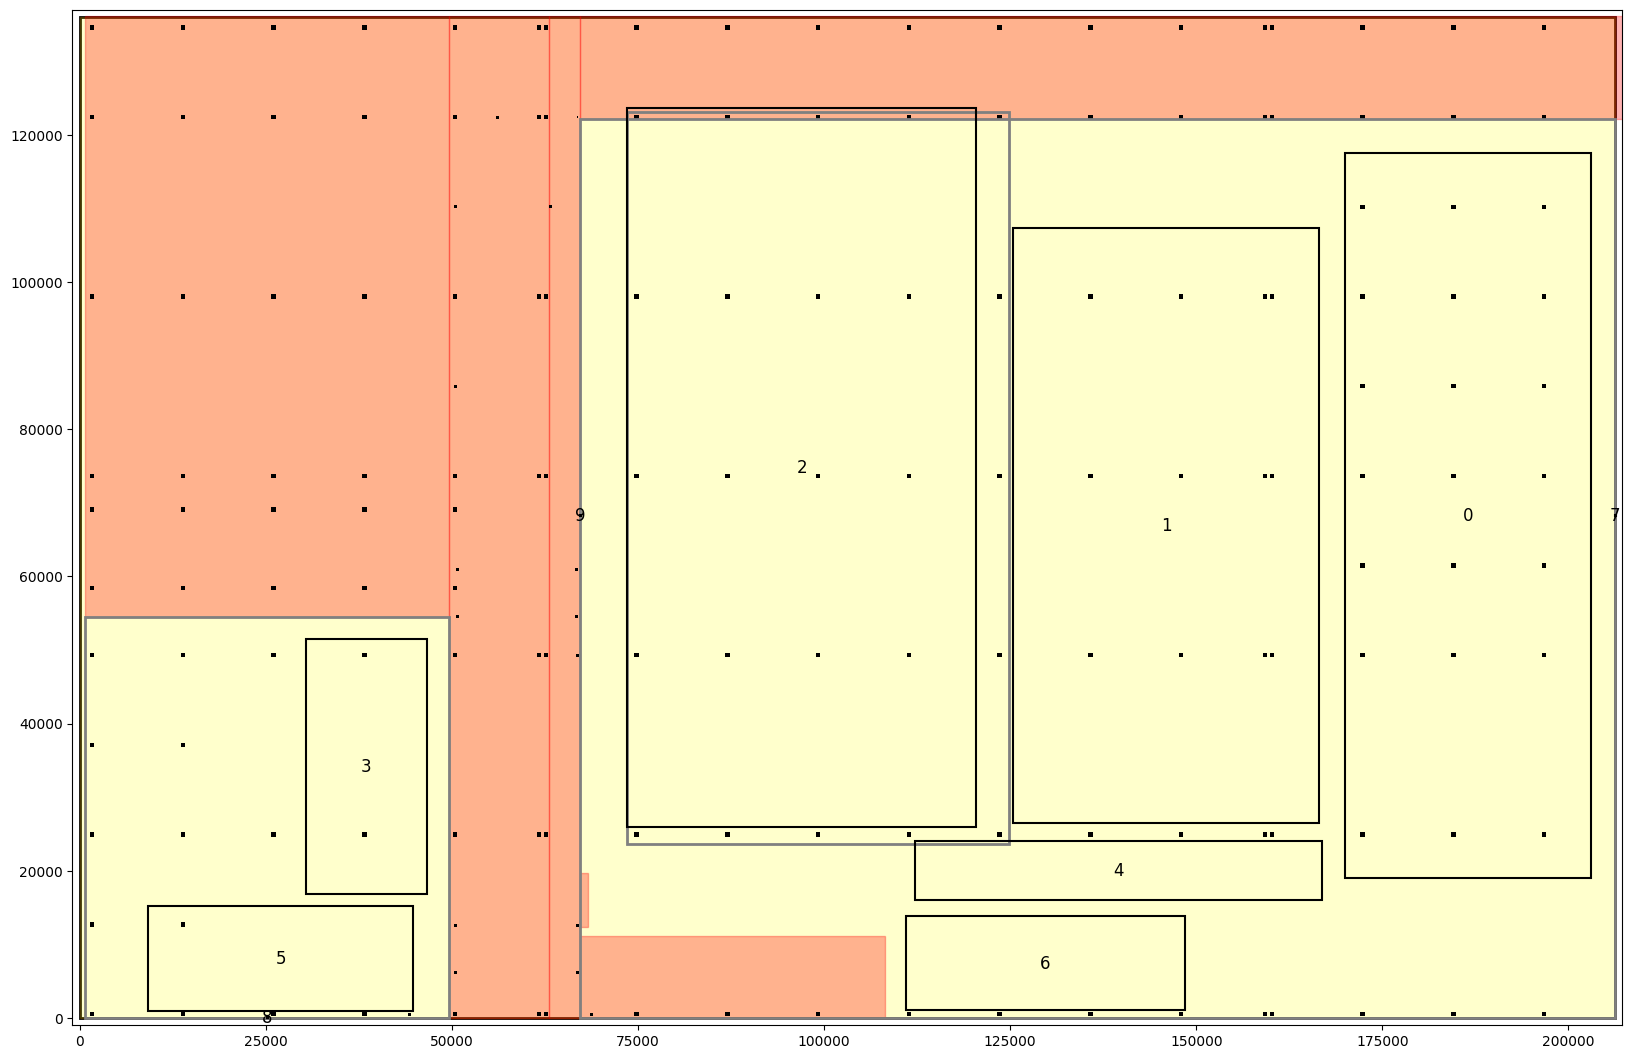

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(6)]
506732.0
6
우선배치:  6
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 5: (np.int64(35568), np.int64(14288)), 3: (np.int64(16187), np.int64(34662)), np.int64(6): (np.int64(19488), np.int64(20608))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 5: (np.int64(35568), np.int64(14288)), 3: (np.int64(16187), np.int64(34662)), np.int64(6): (np.int64(20608), np.int64(19488))}
!!!!!!!!!!!!!!!
6
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int

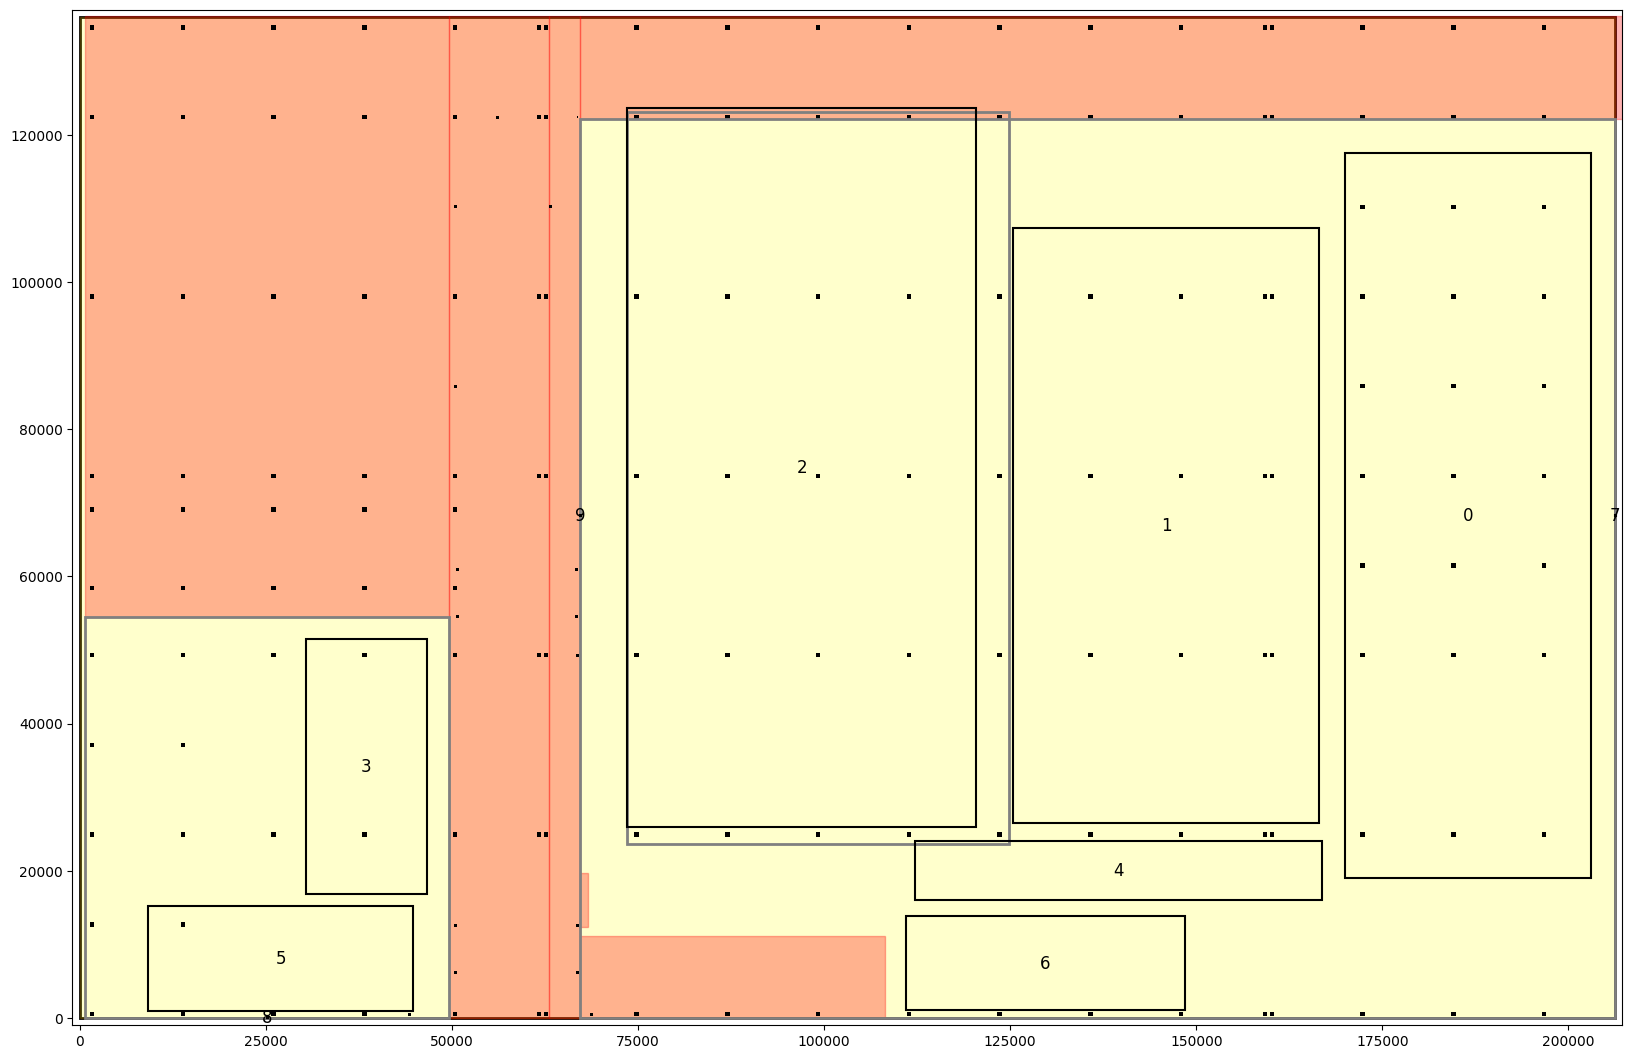

506732.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===  5 ===
!!! 506655.5
!!! 506655.5


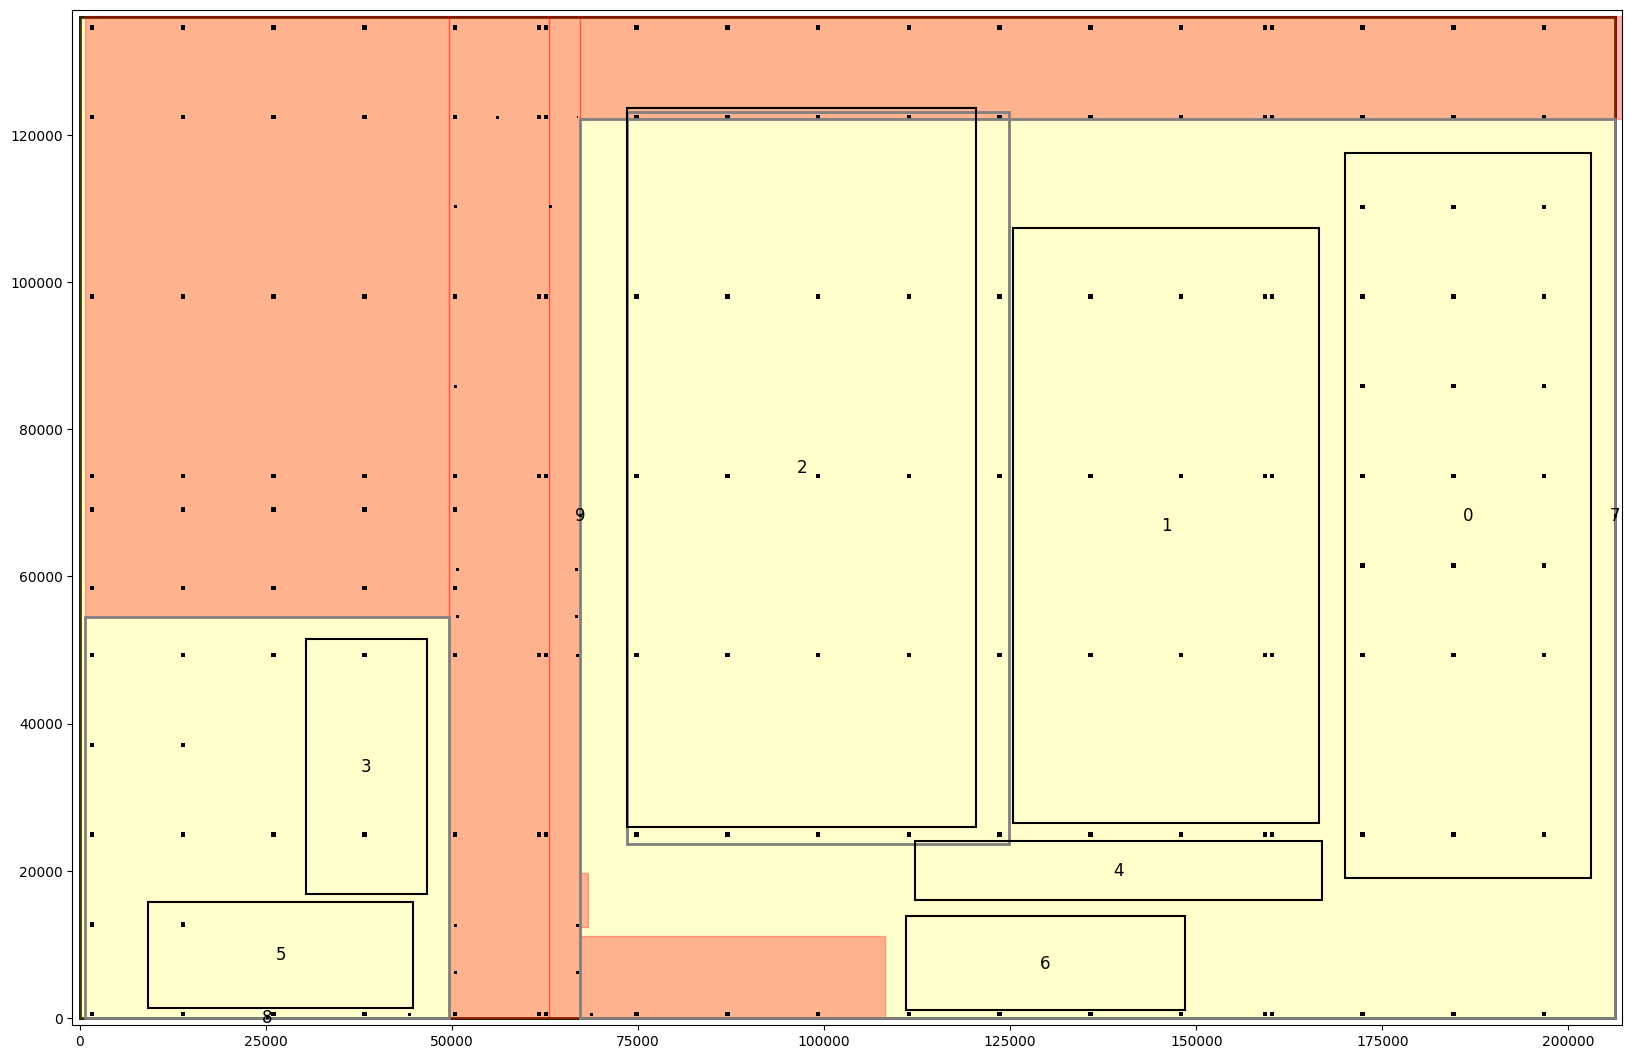

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(2)]
506655.5


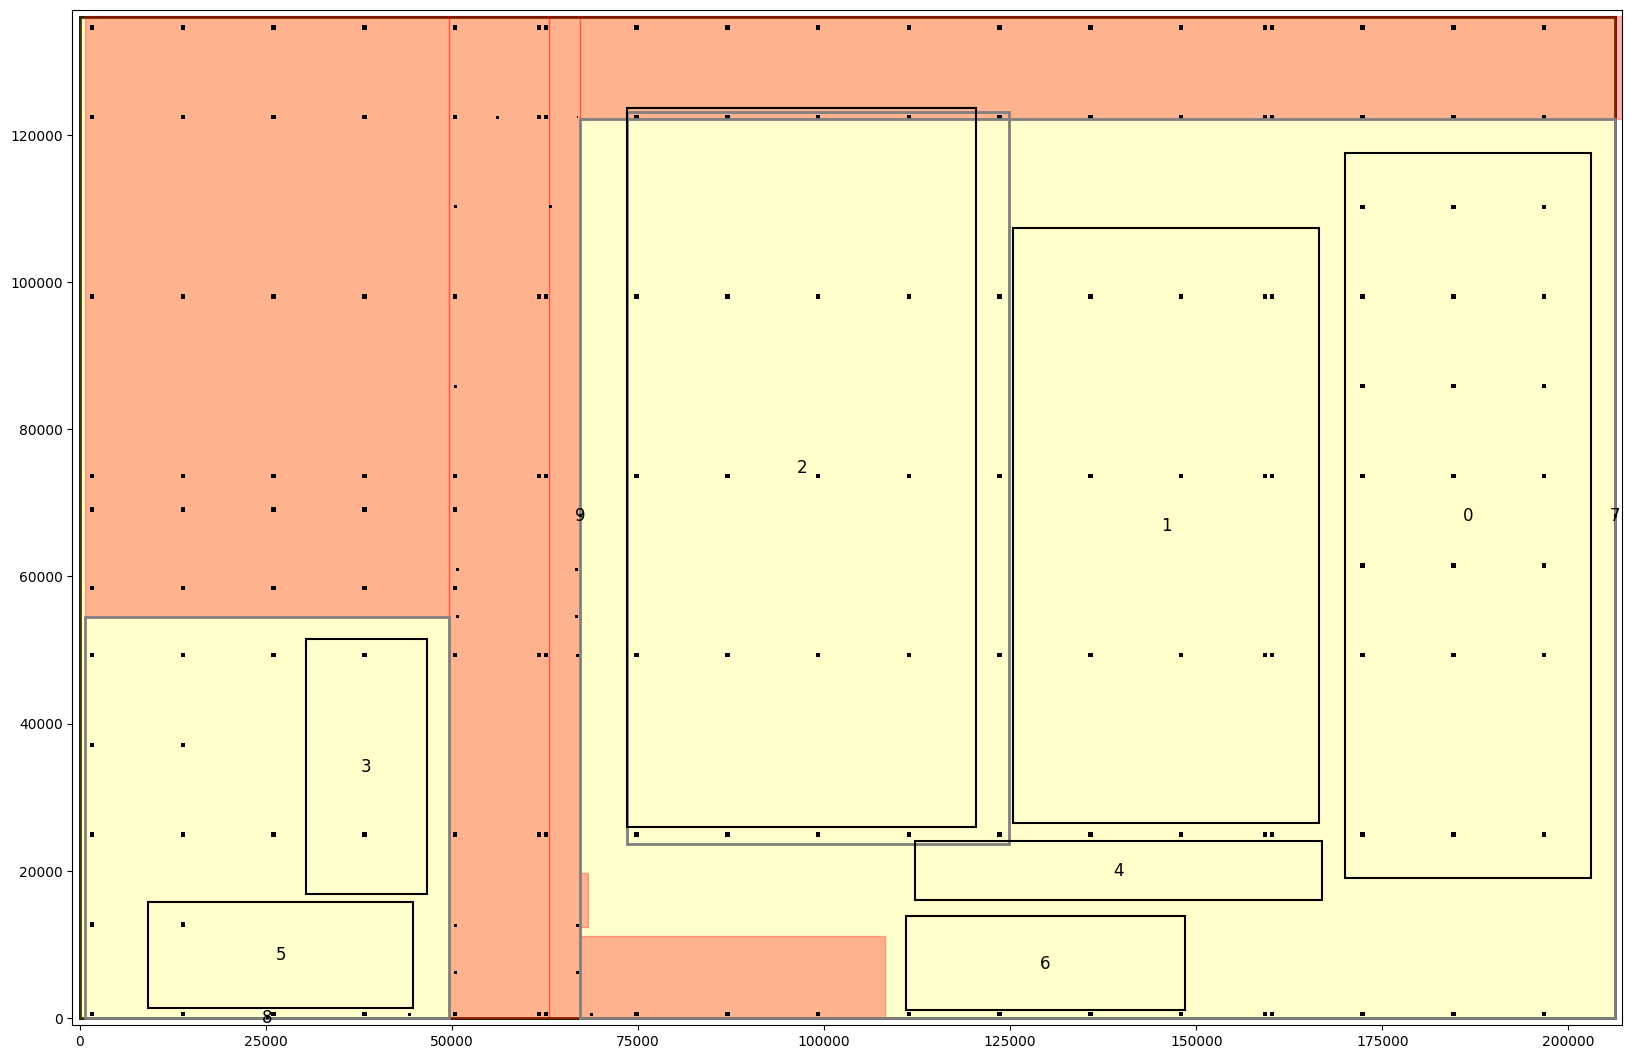

506655.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===  5 ===
!!! 506405.5
!!! 506405.5


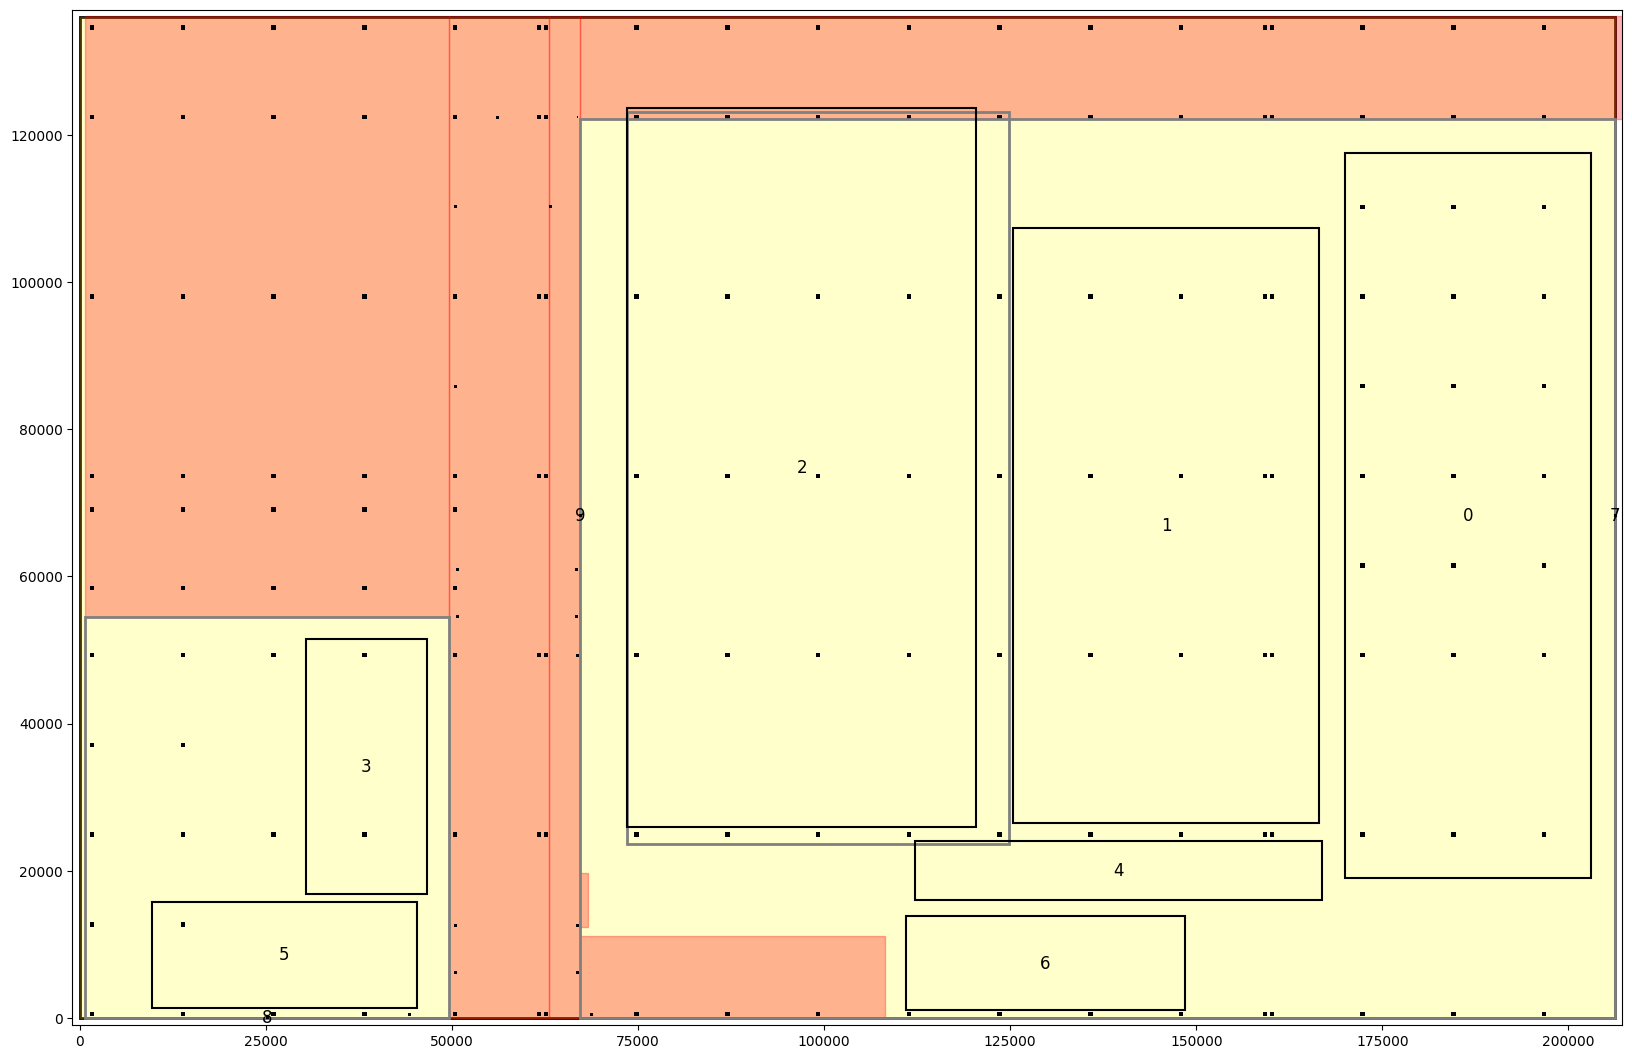

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(2)]
506405.5


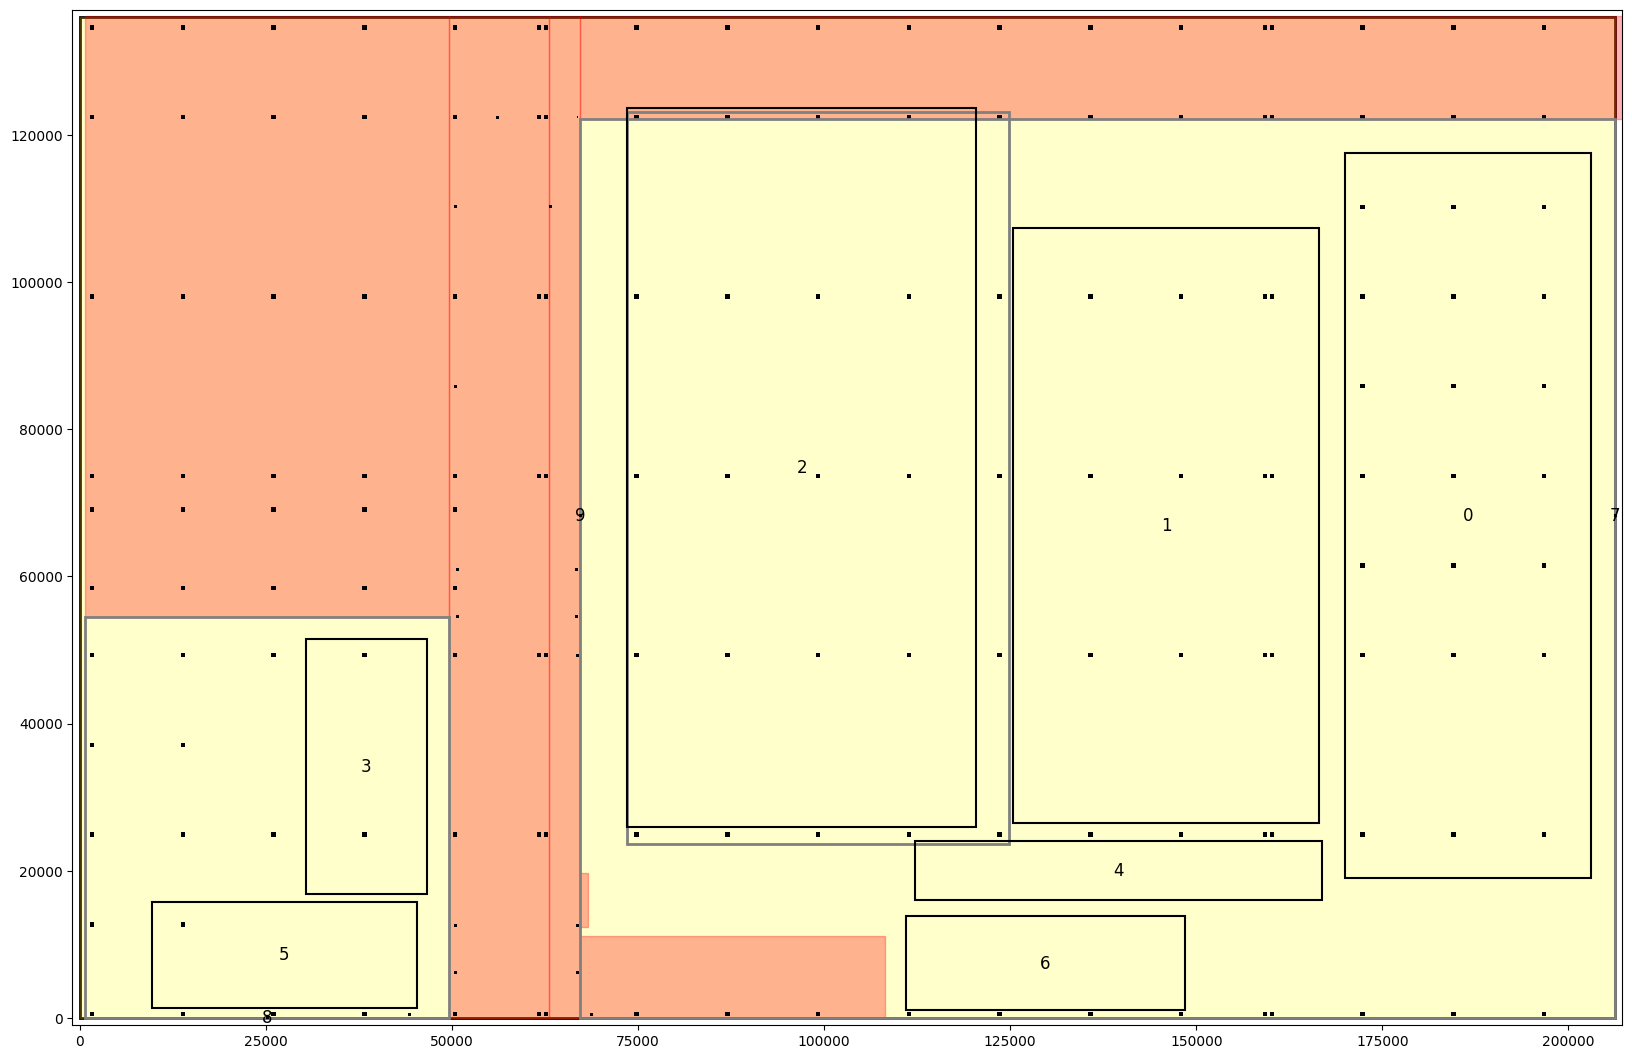

506405.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


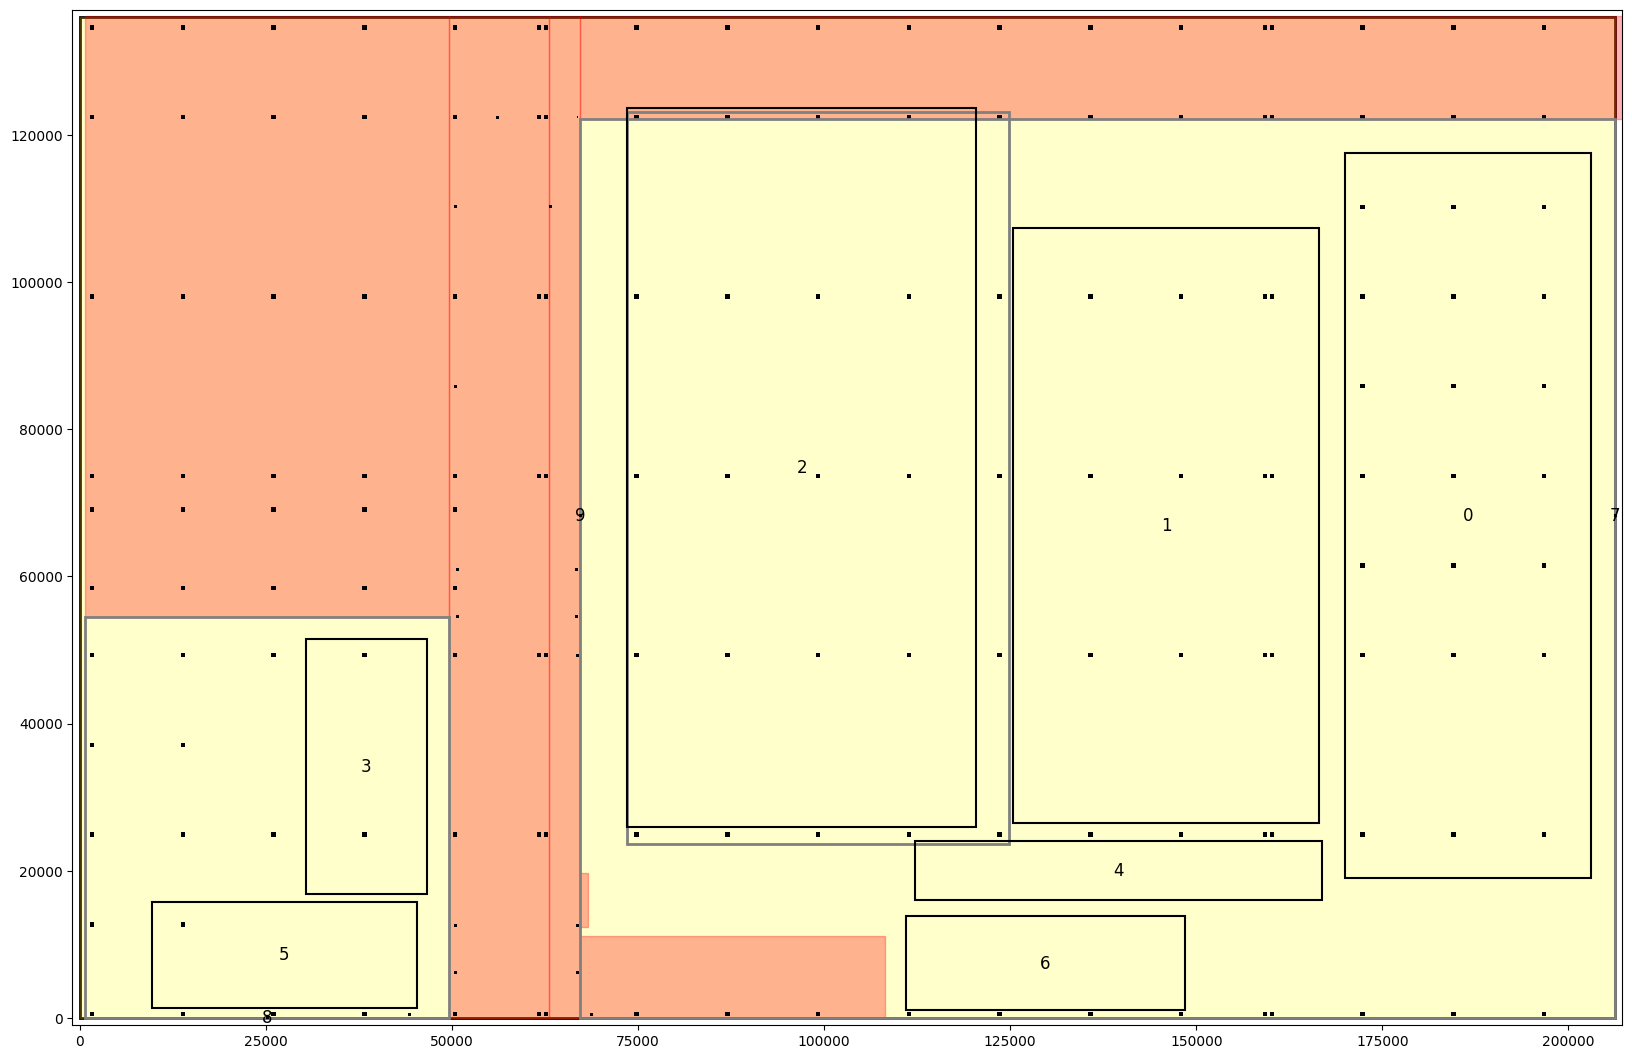

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(3), np.int64(5)]
506405.5
3
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.

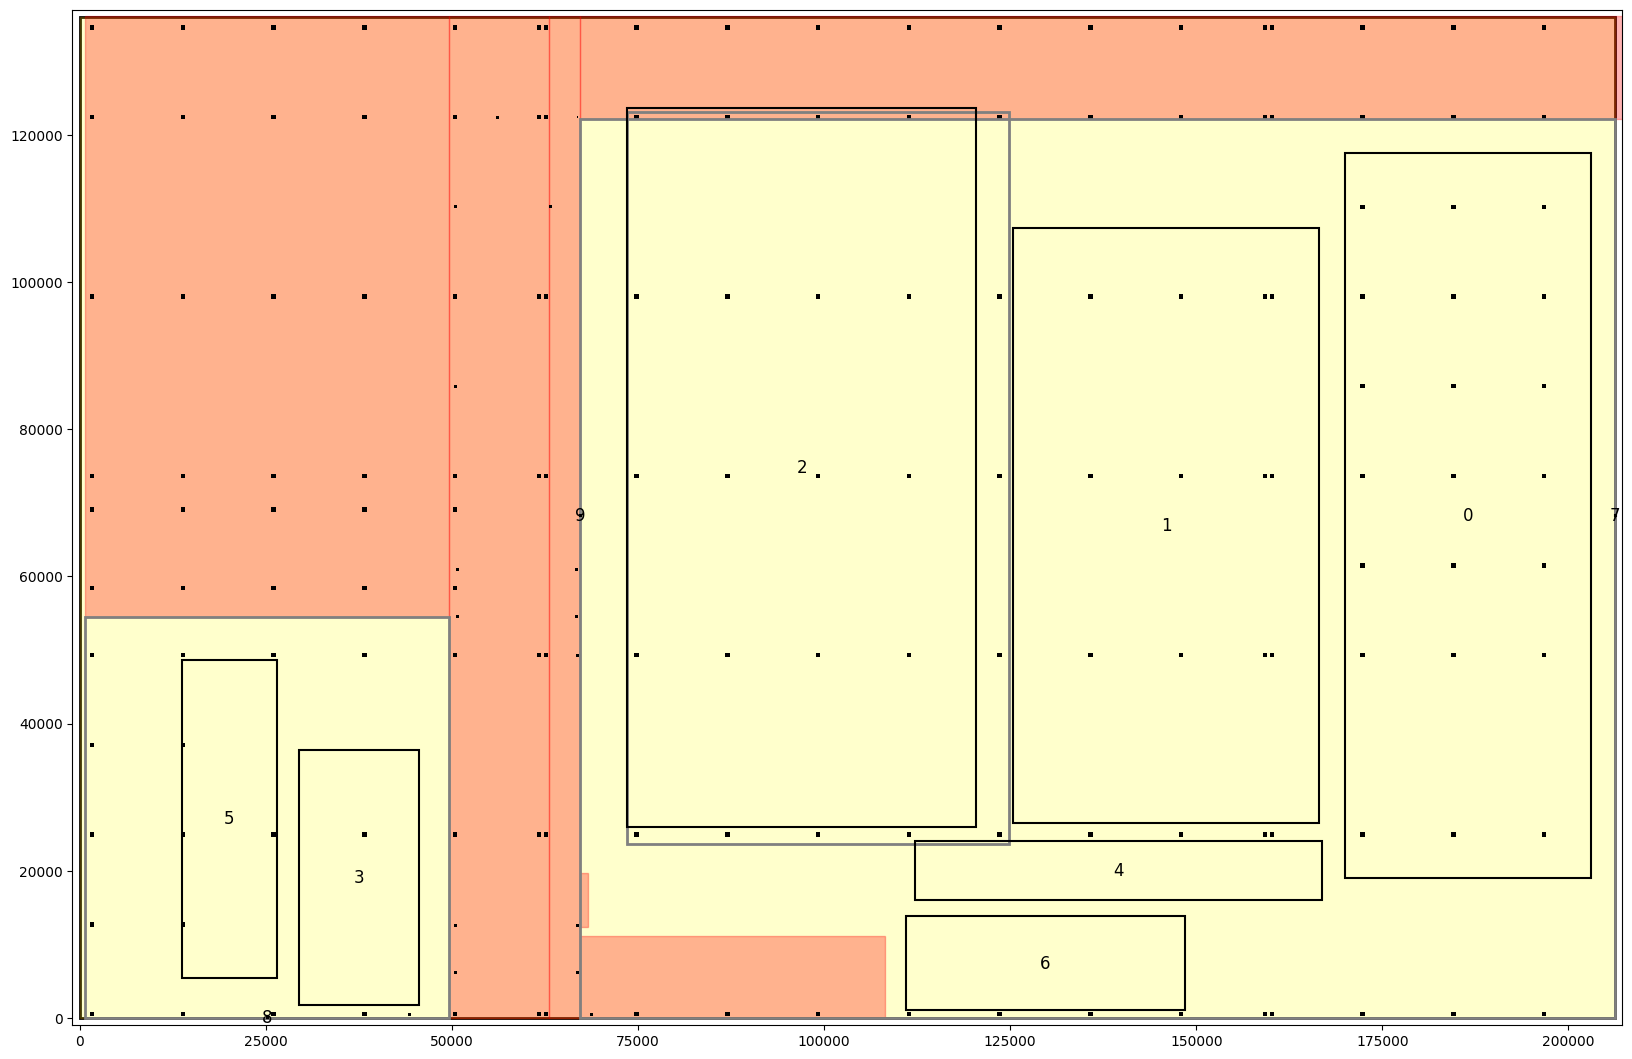

481431.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


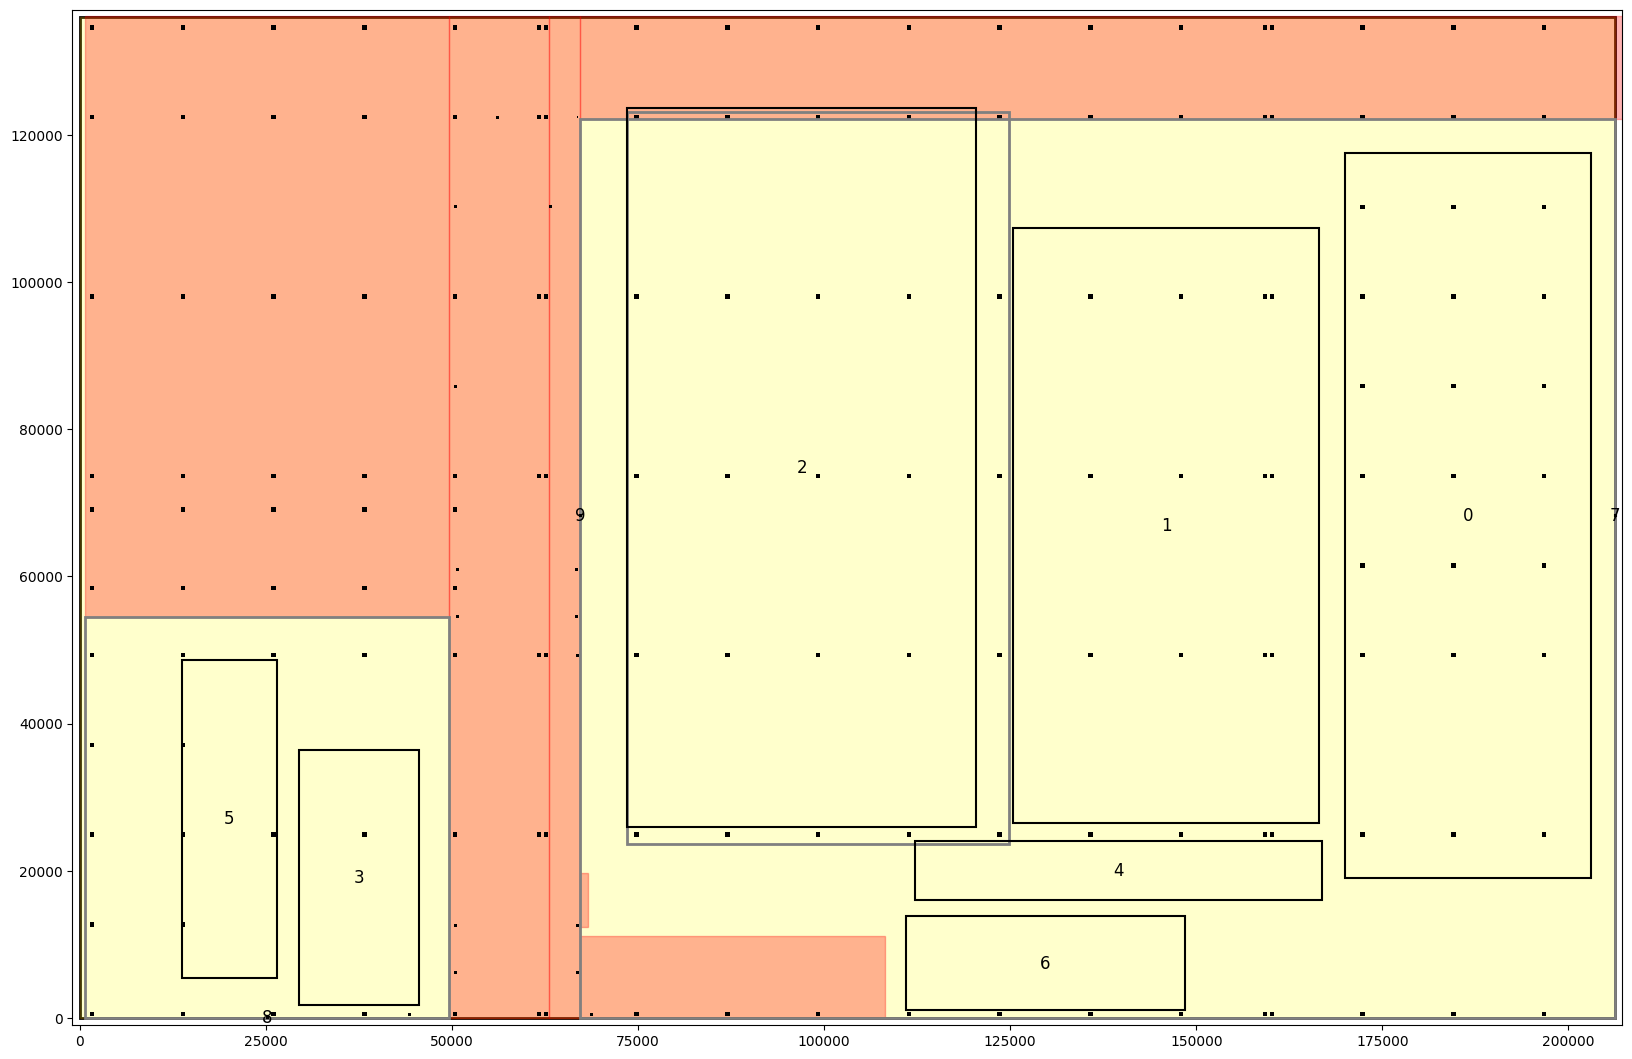

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(0), np.int64(6)]
481431.5
0
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), np.int64(3): (np.int64(16187), np.int64(3

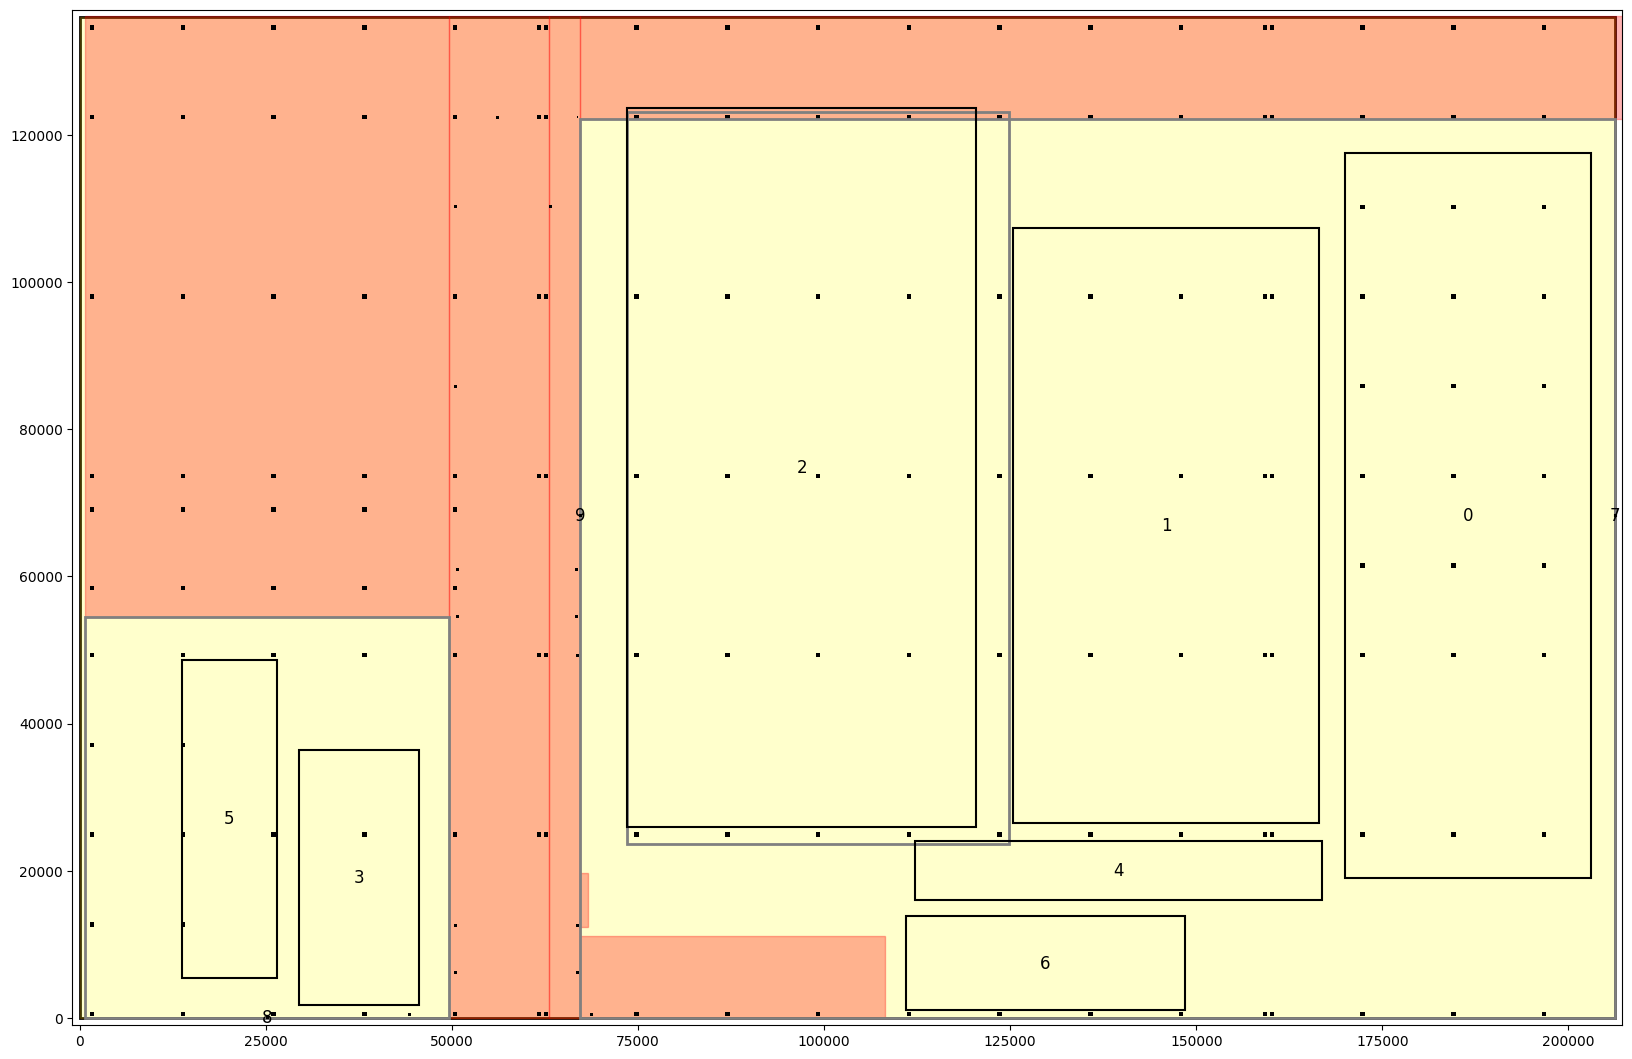

481431.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===  3 ===
!!! 480931.5
!!! 480931.5


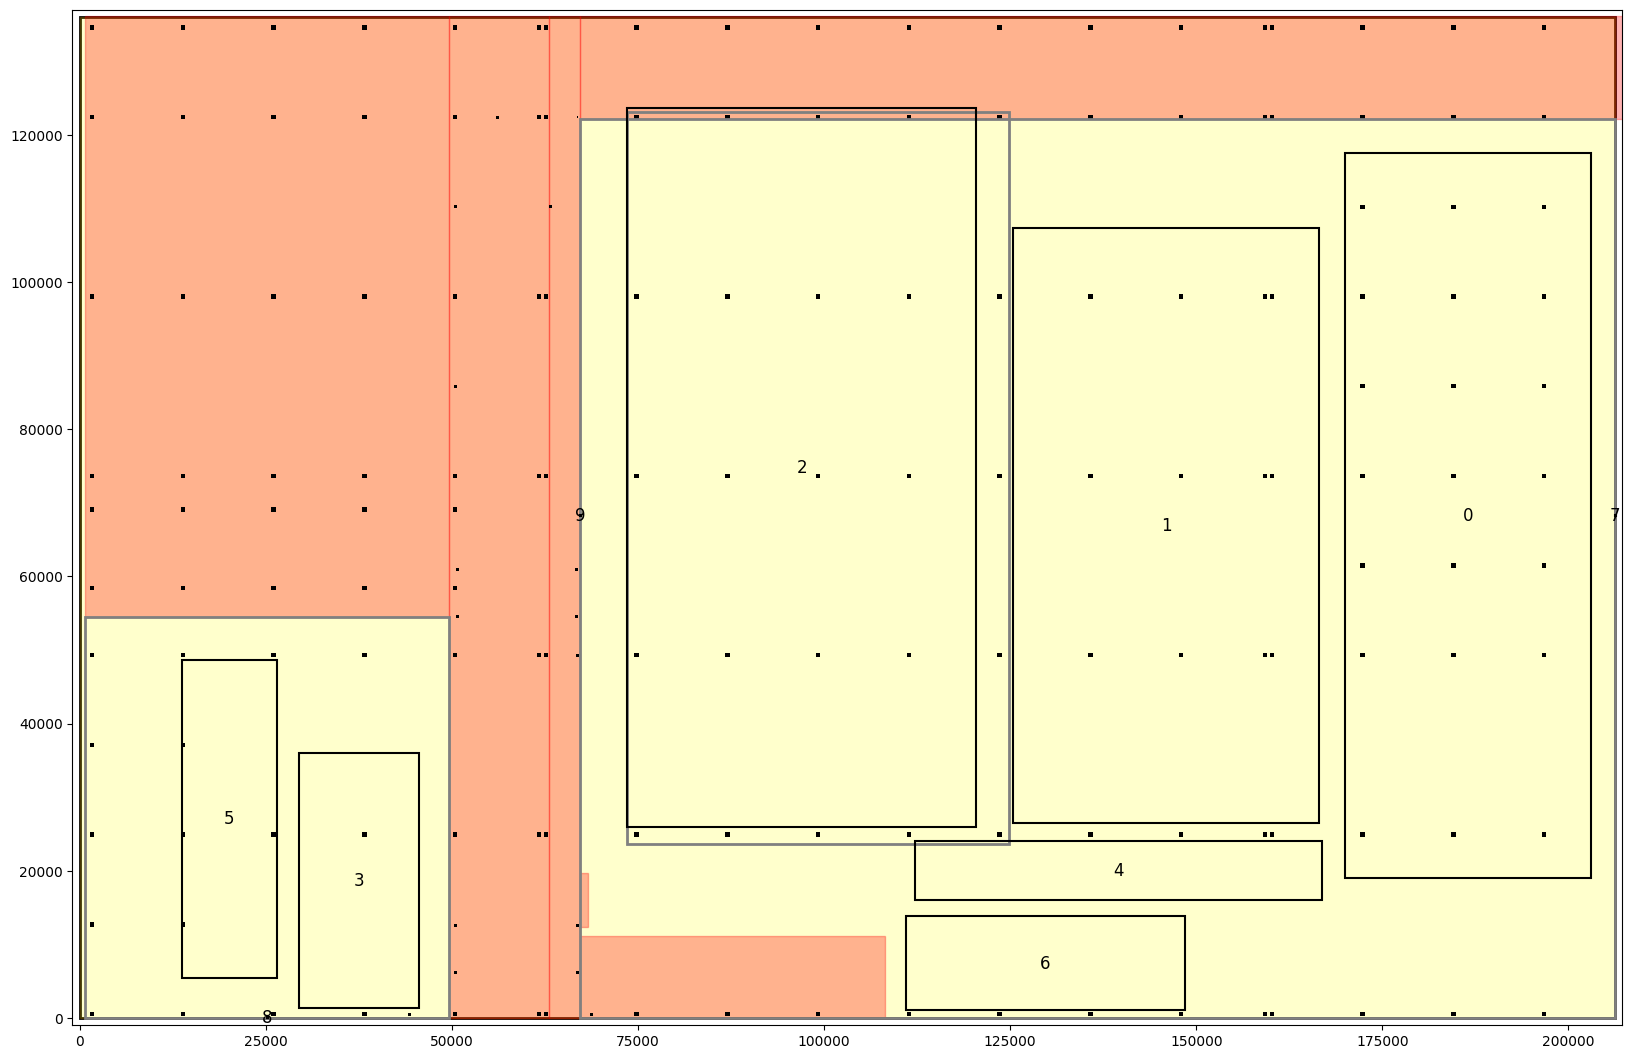

********************************
6
480931.5
우선배치:  6
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(19488), np.int64(20608)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(20608), np.int64(19488)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
!!!!!!!!!!!!!!!
6
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), 

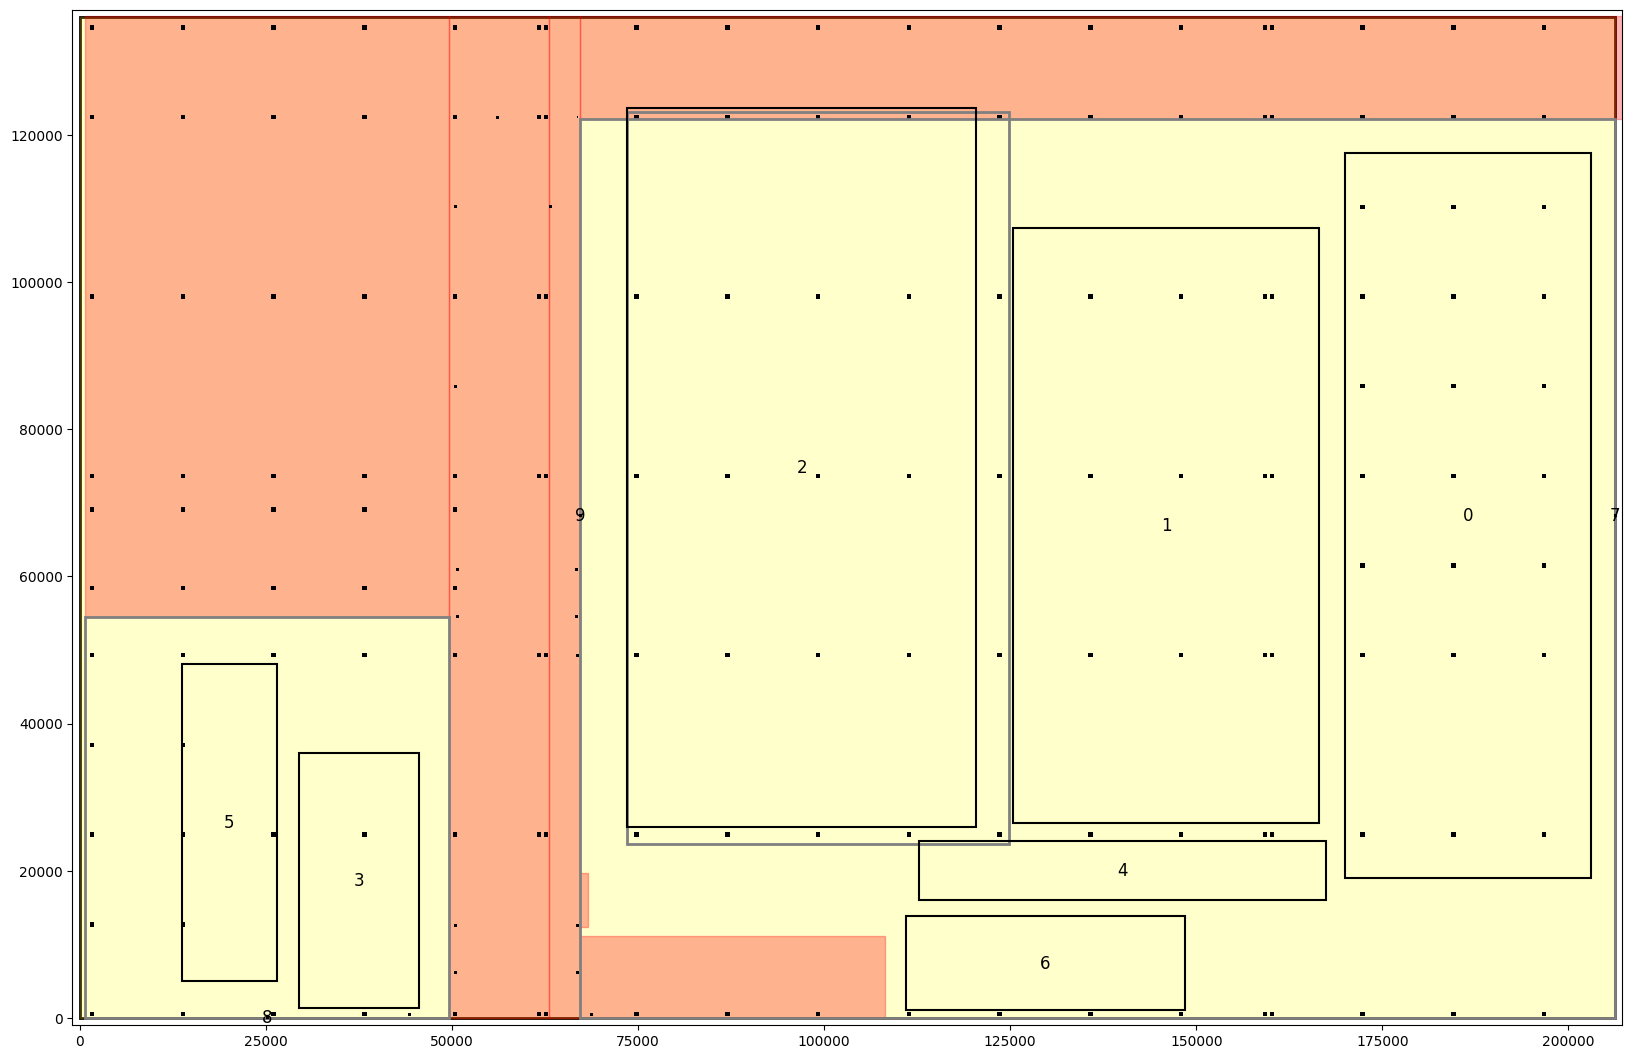

********************************
4
480431.5
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.in

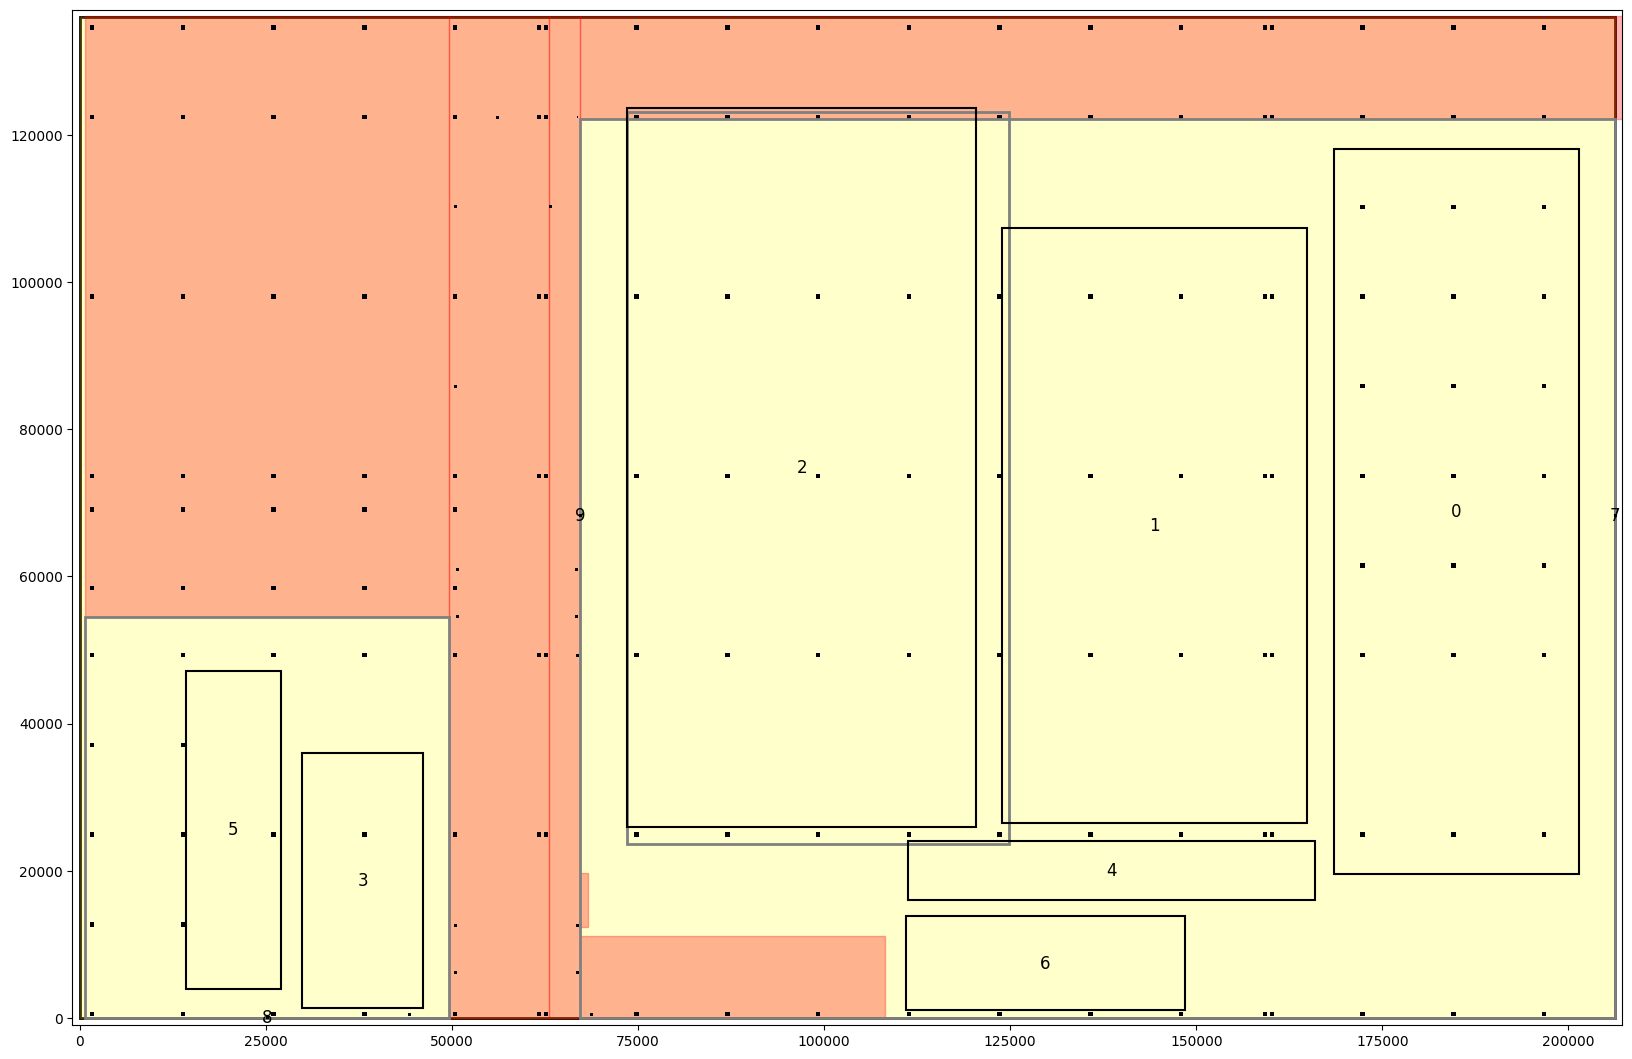

********************************
1
478877.5
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(80908), np.int64(41000)), 4: (np.in

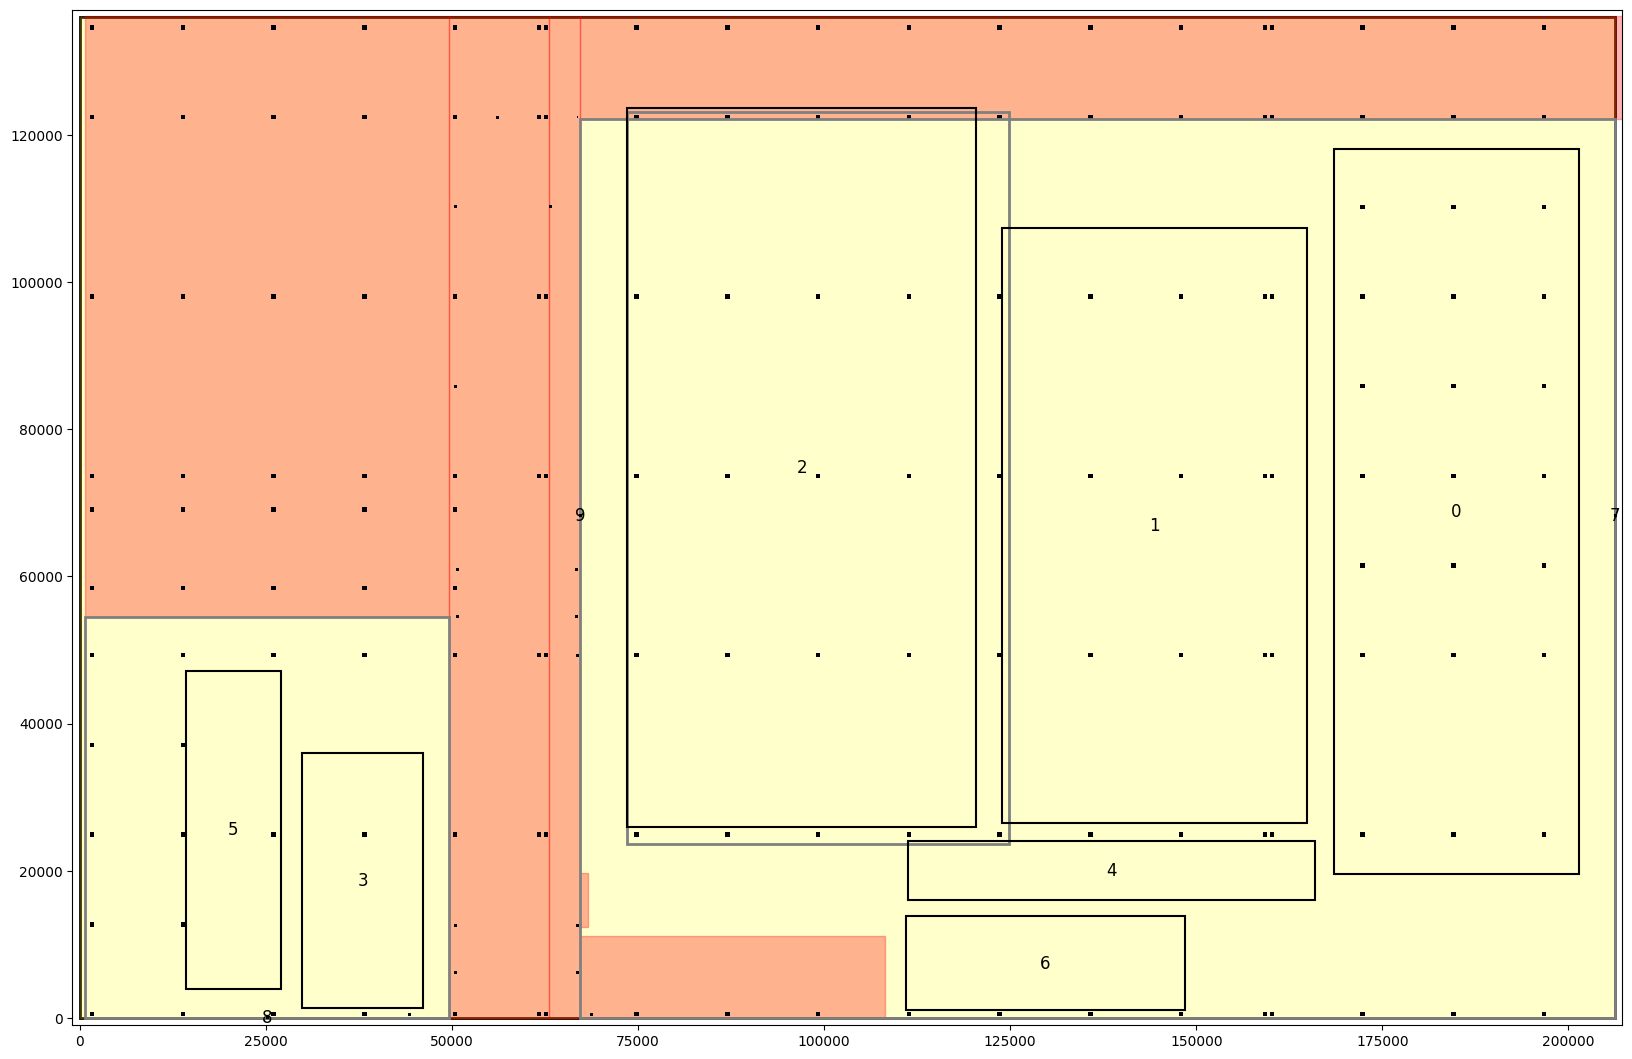

********************************
1
478877.5
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(80908), np.int64(41000)), 4: (np.in

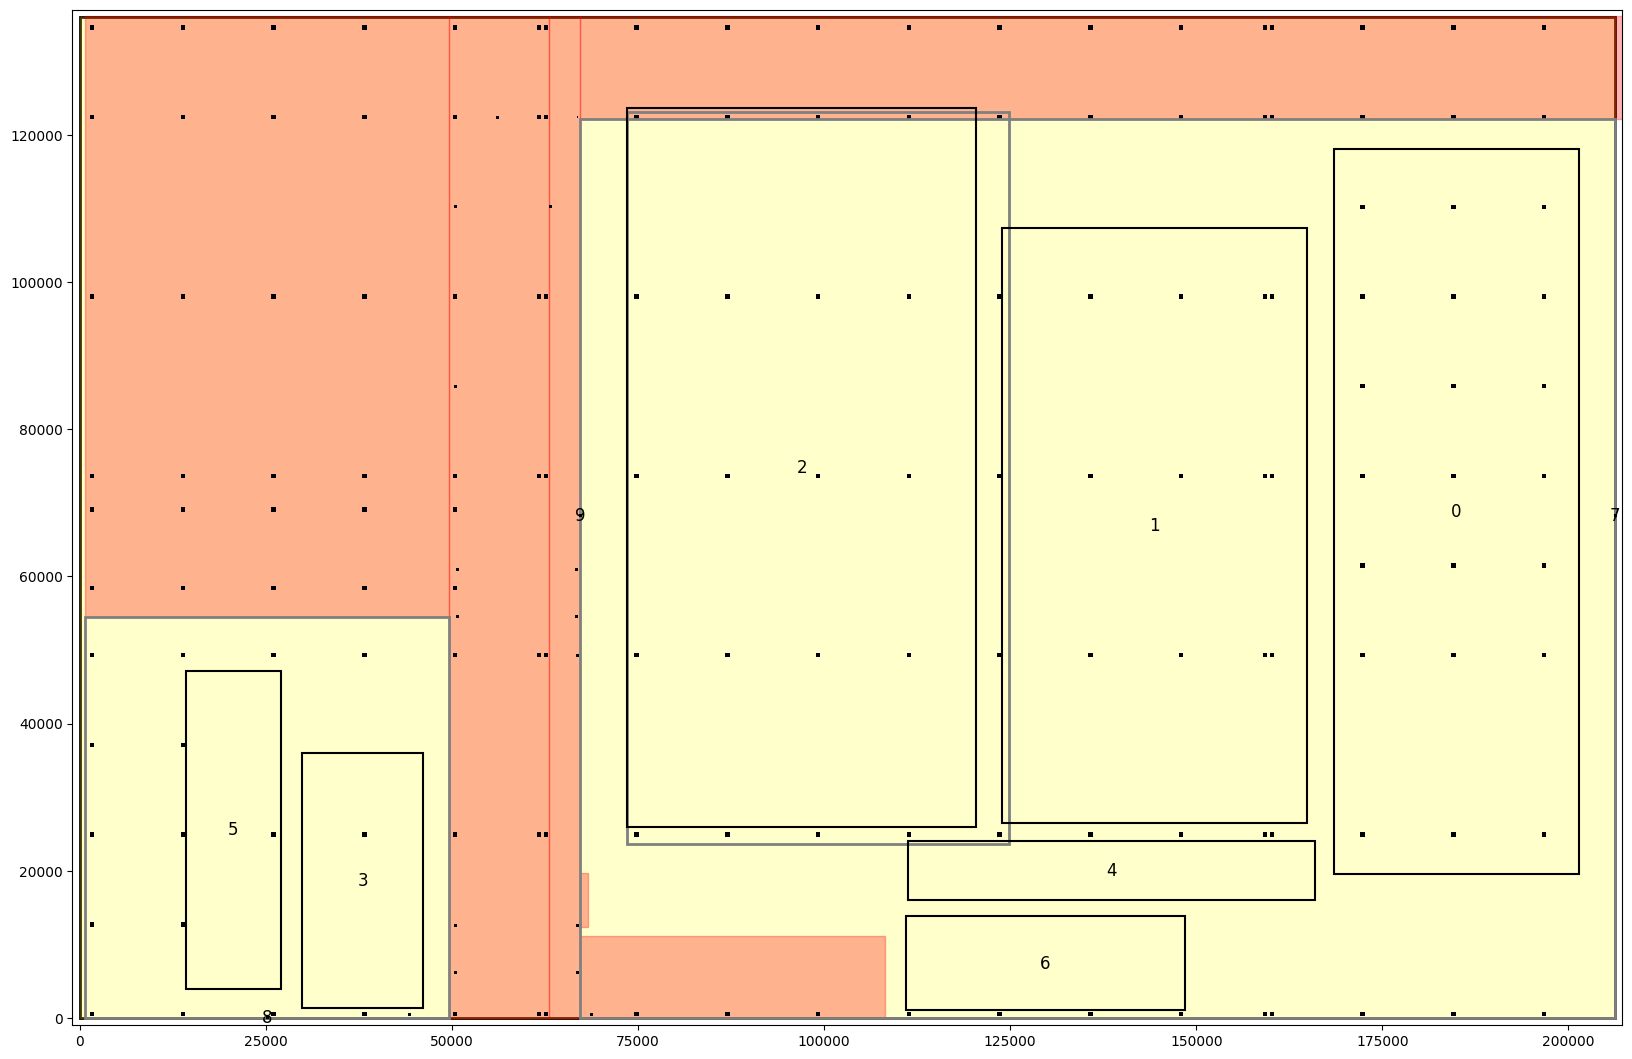

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(2)]
478877.5


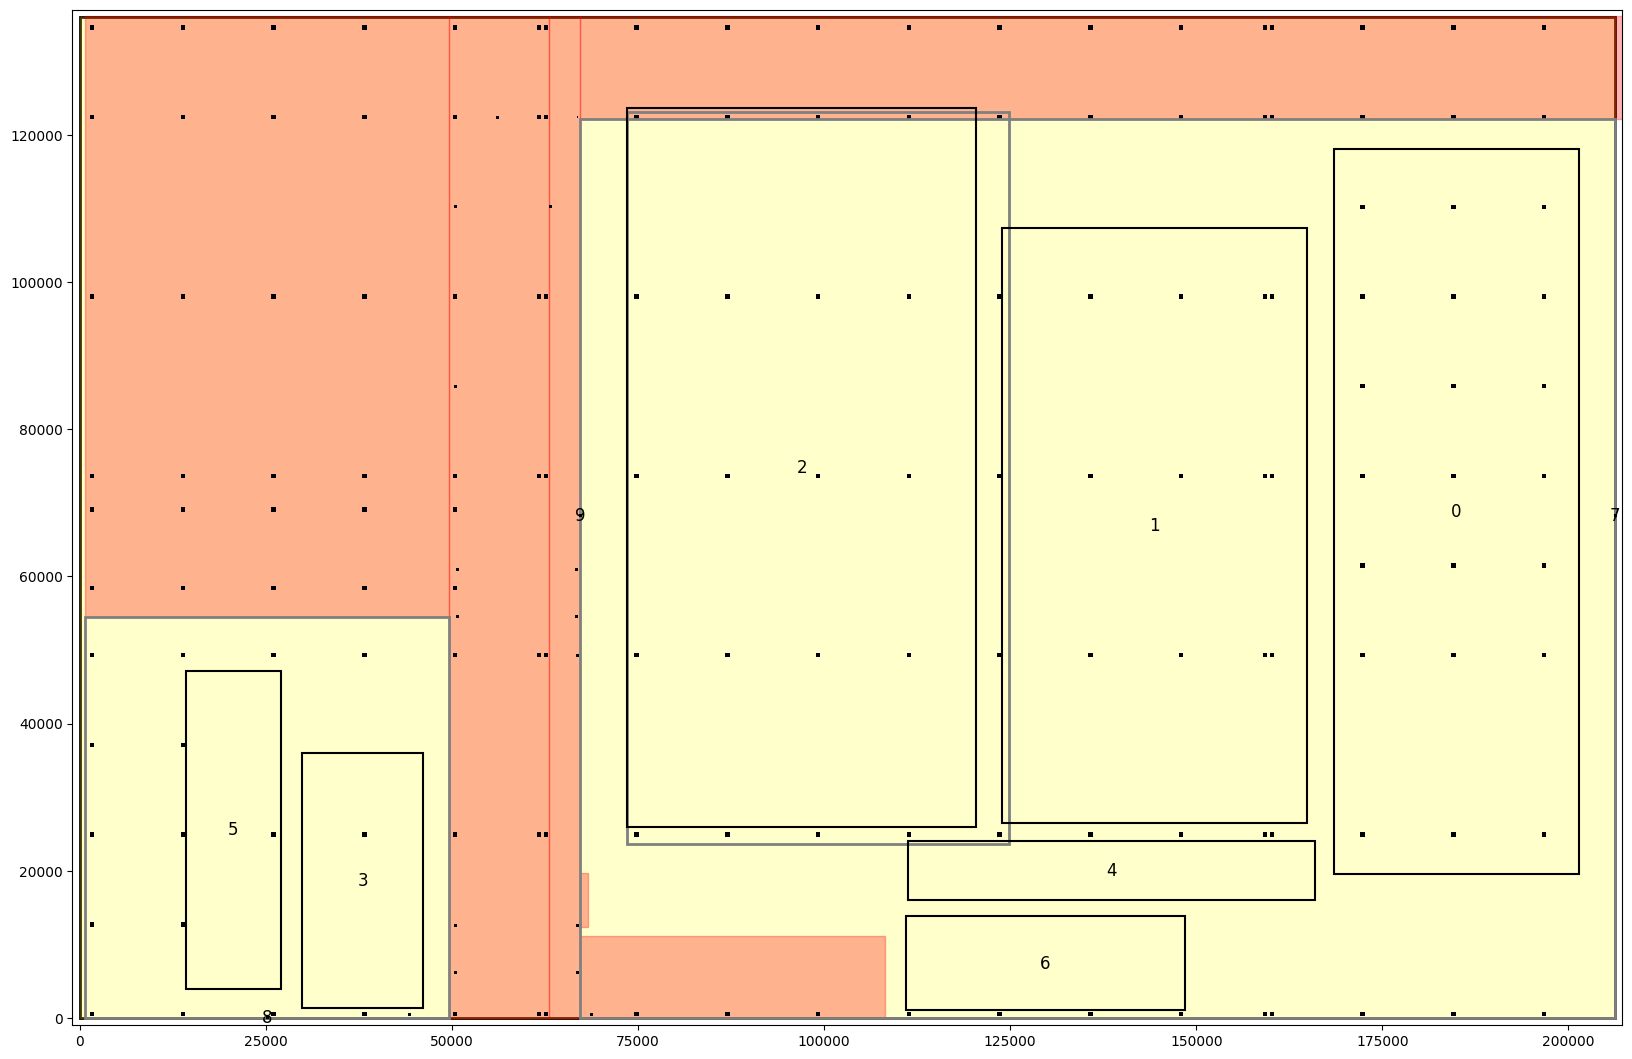

478877.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
===  6 ===
!!! 477931.5
!!! 477931.5


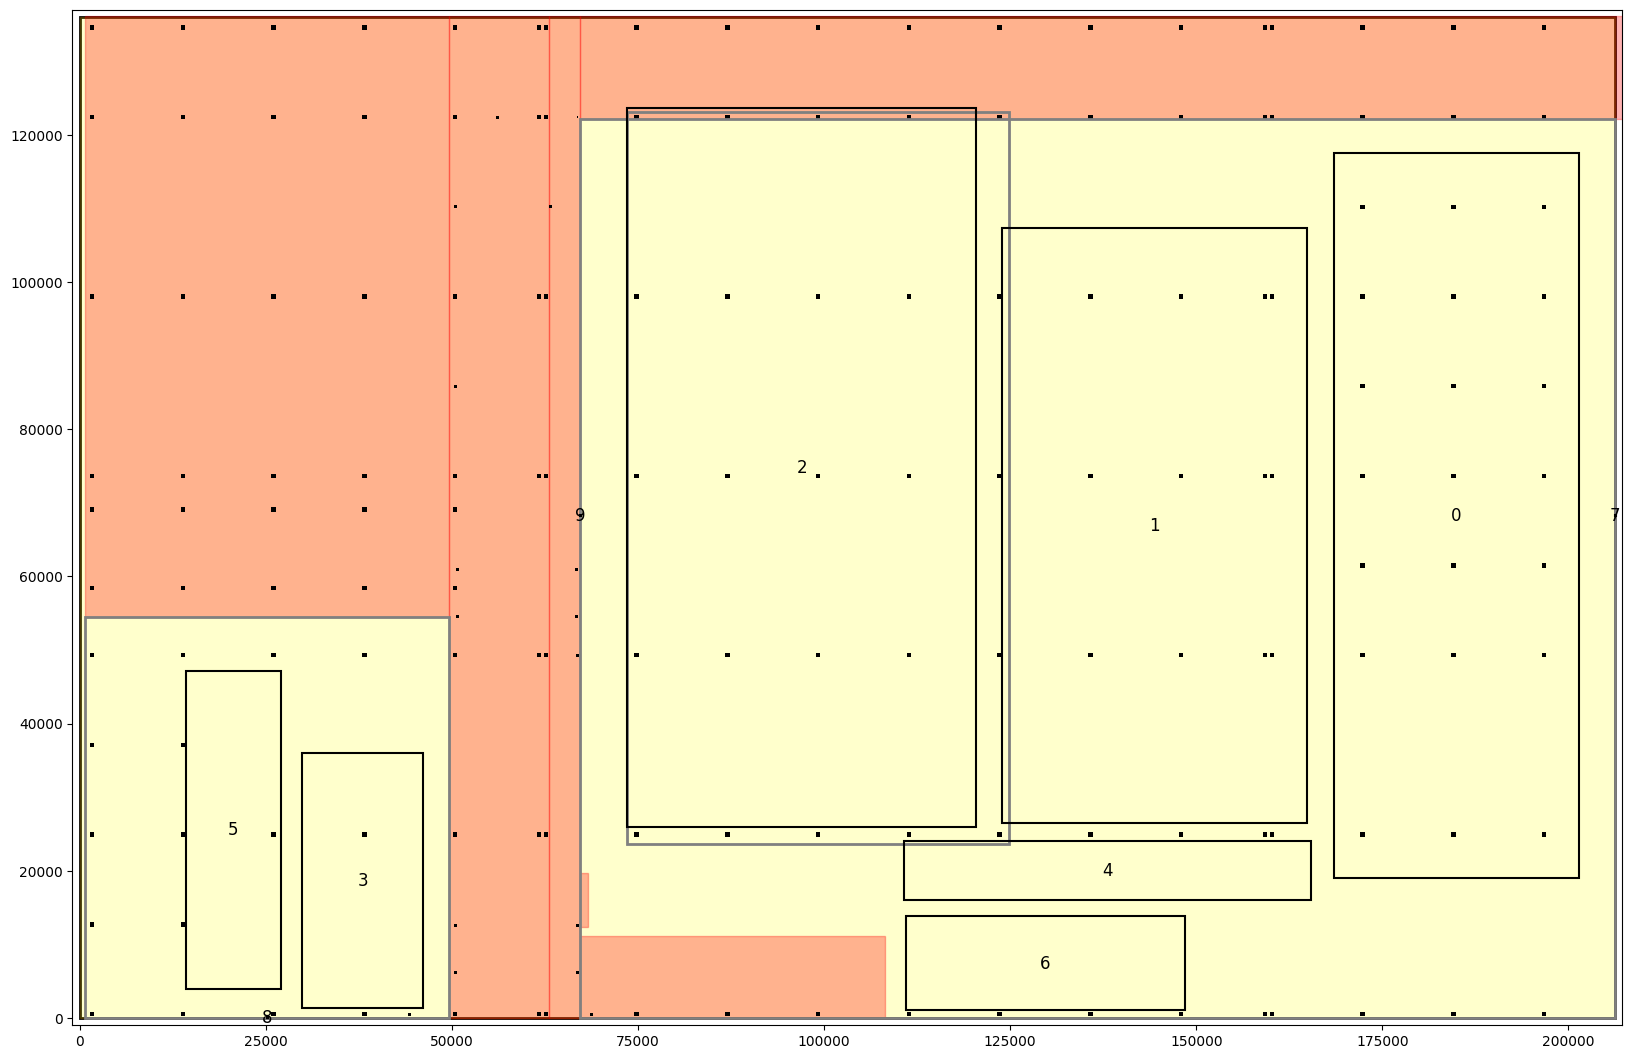

********************************
3
477931.5
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.in

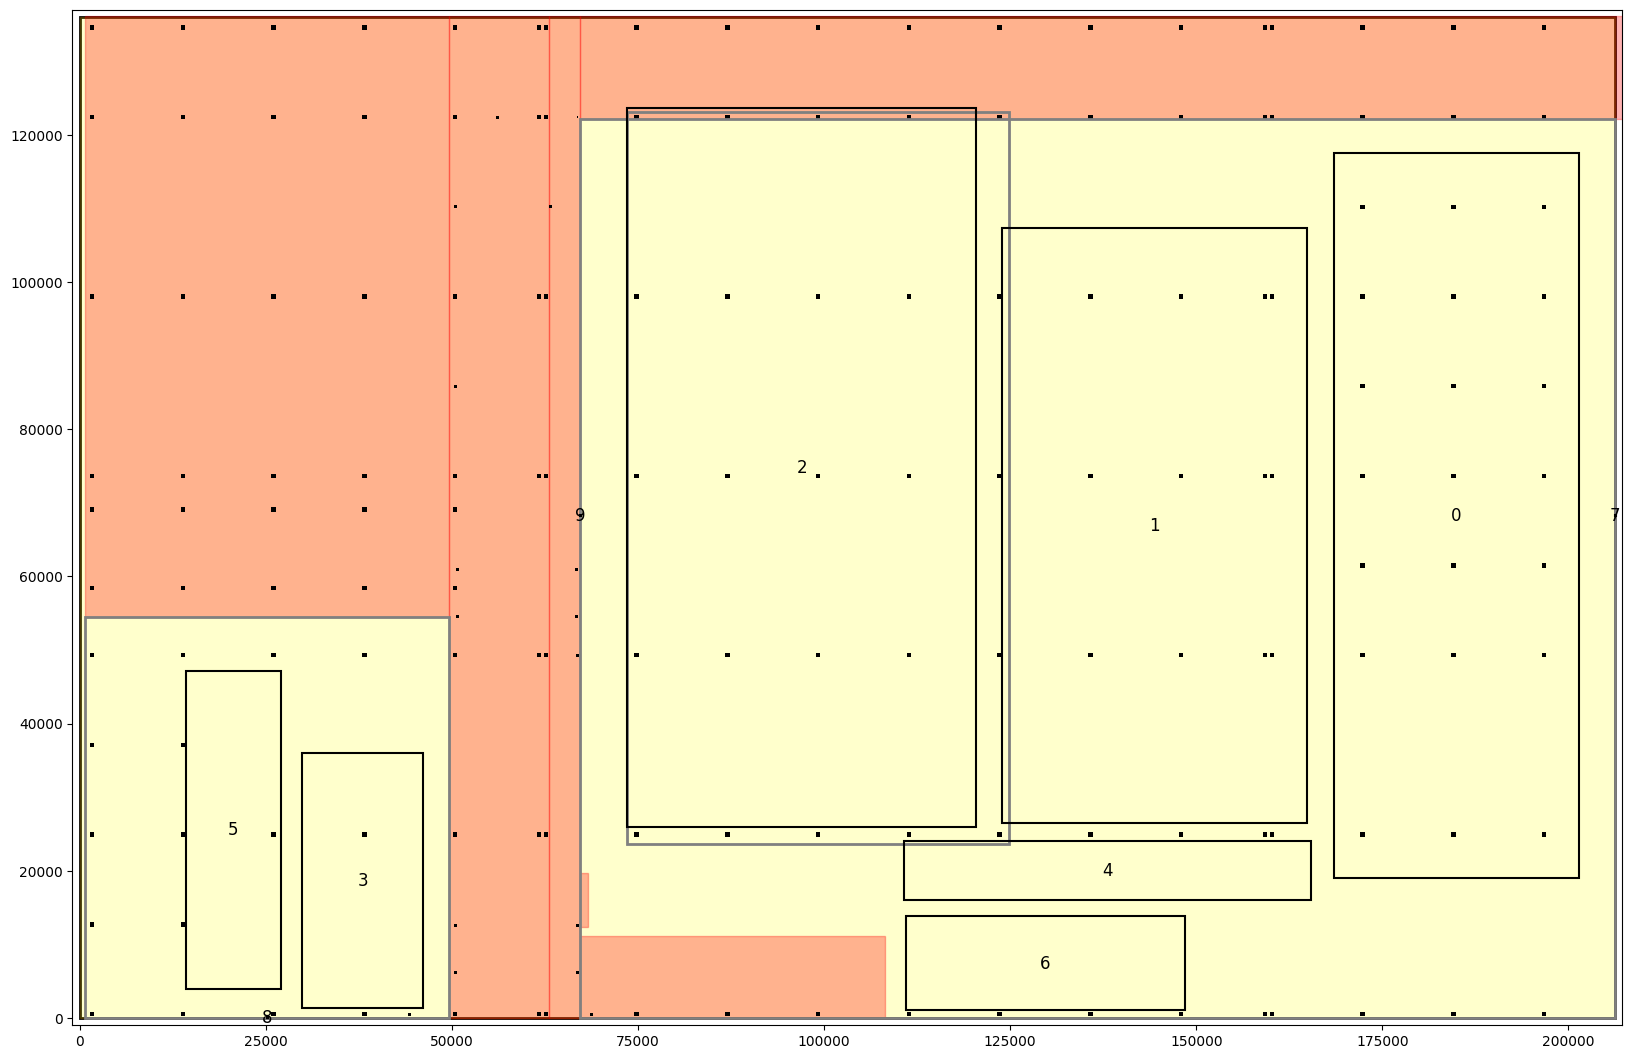

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(0), np.int64(4)]
477931.5
0
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(0): (np.int64(33028), np.int64(98550))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 1: (np.int64(41000), np.int64(80908)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int6

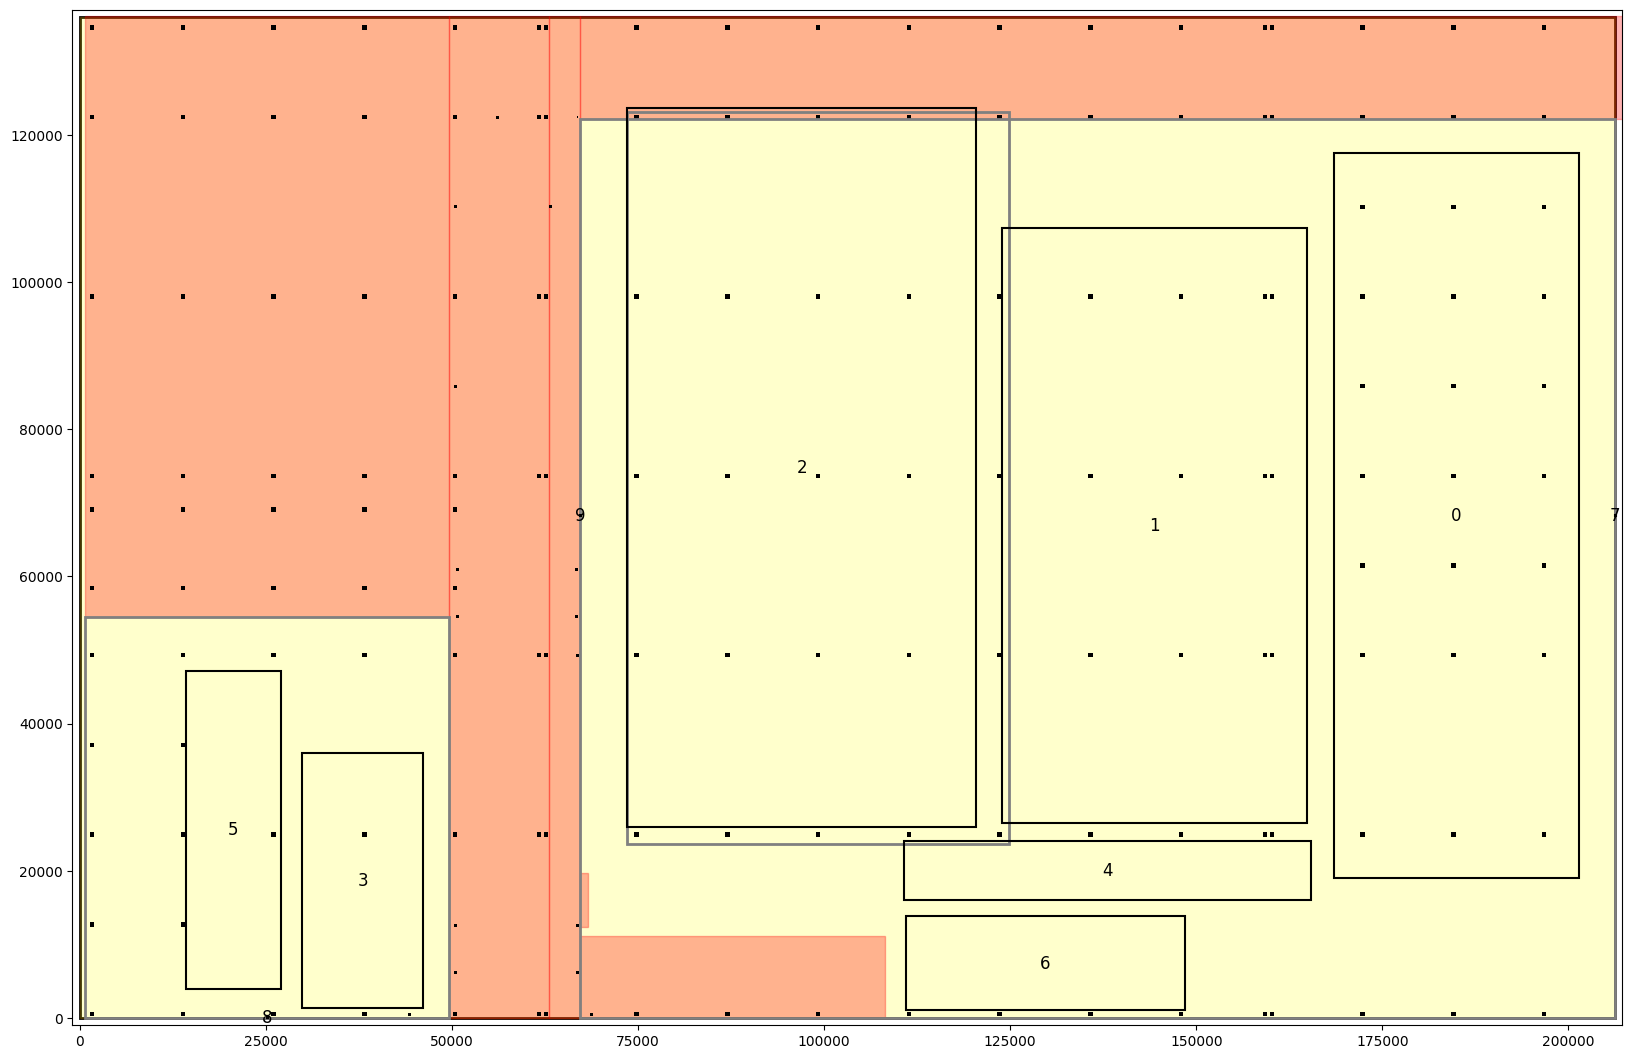

477931.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


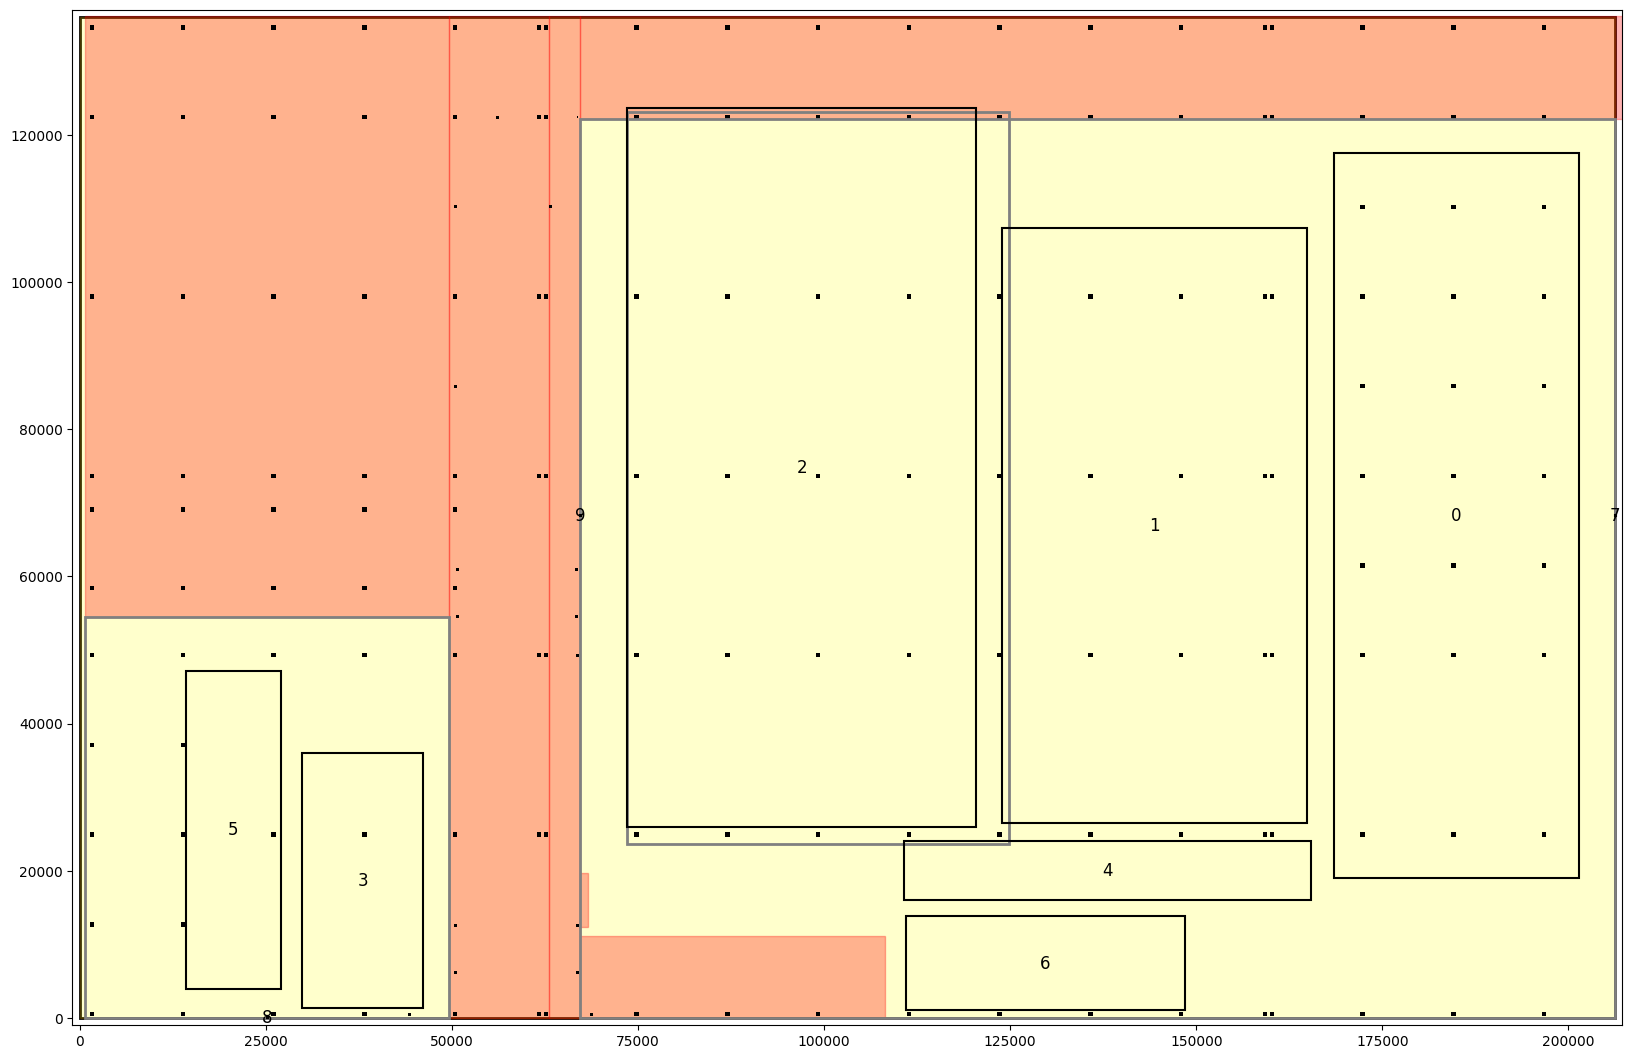

********************************
4
477931.5
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(3): (np.int64(16187), np.int64(34662)), np.int64(5): (np.int64(12768), np.int64(43168))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.in

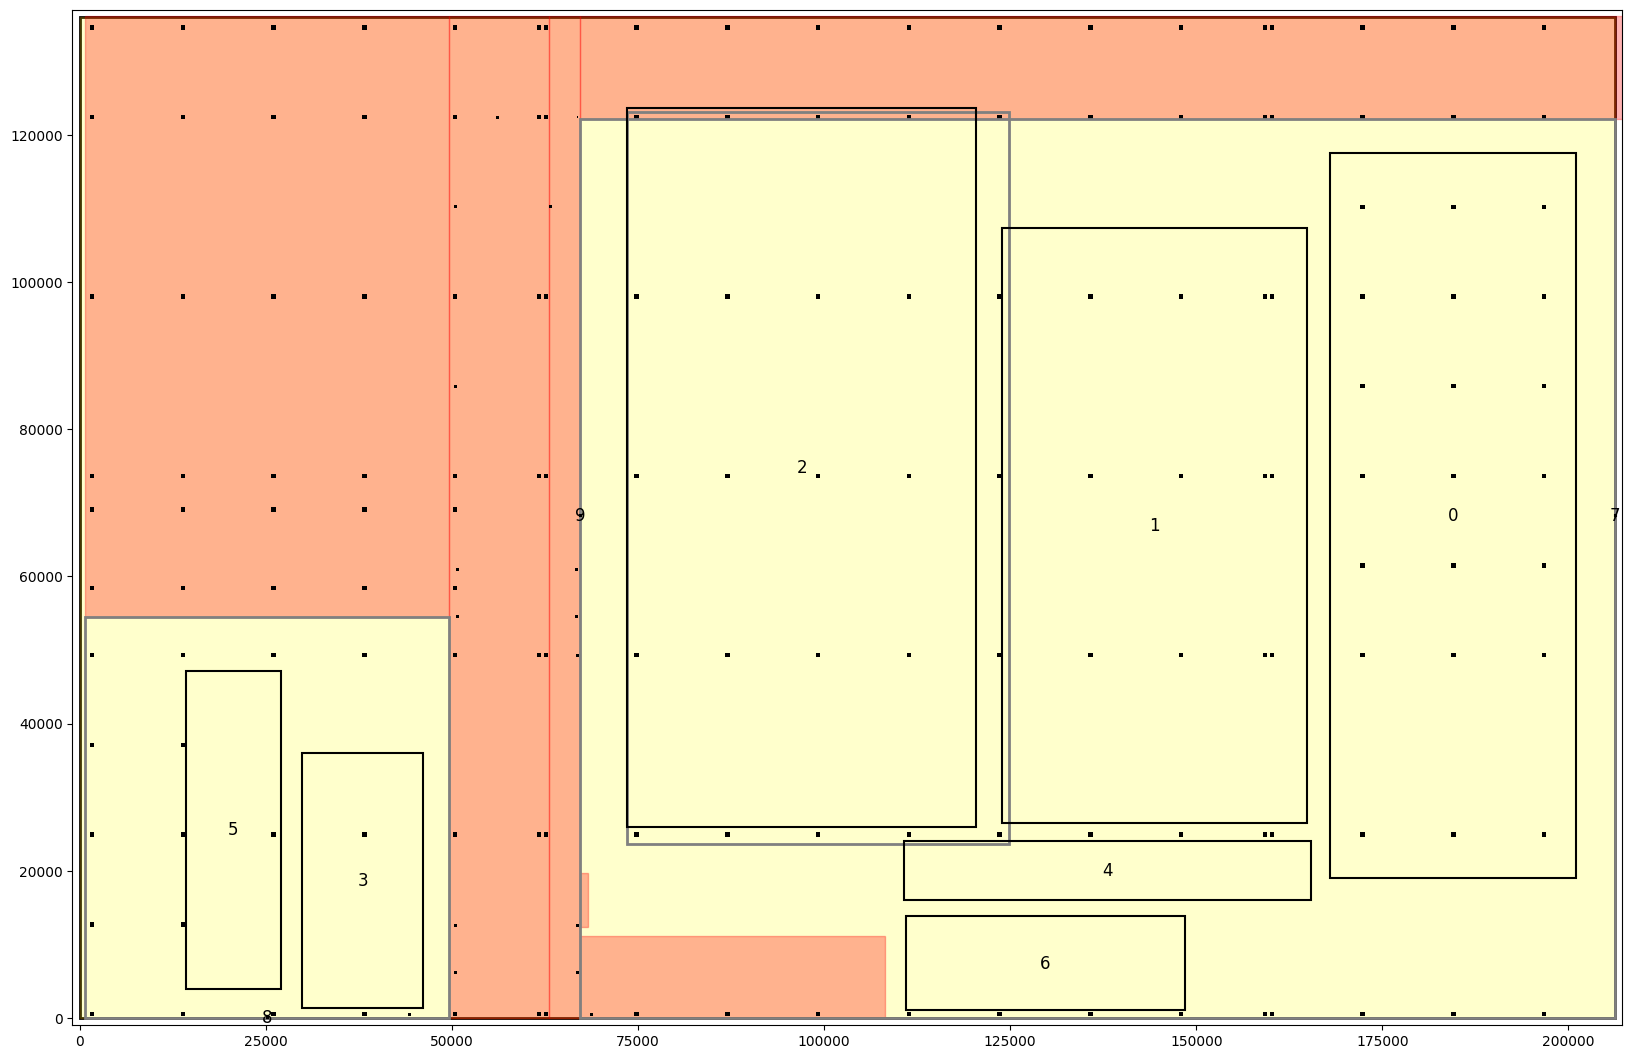

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(2)]
477681.5


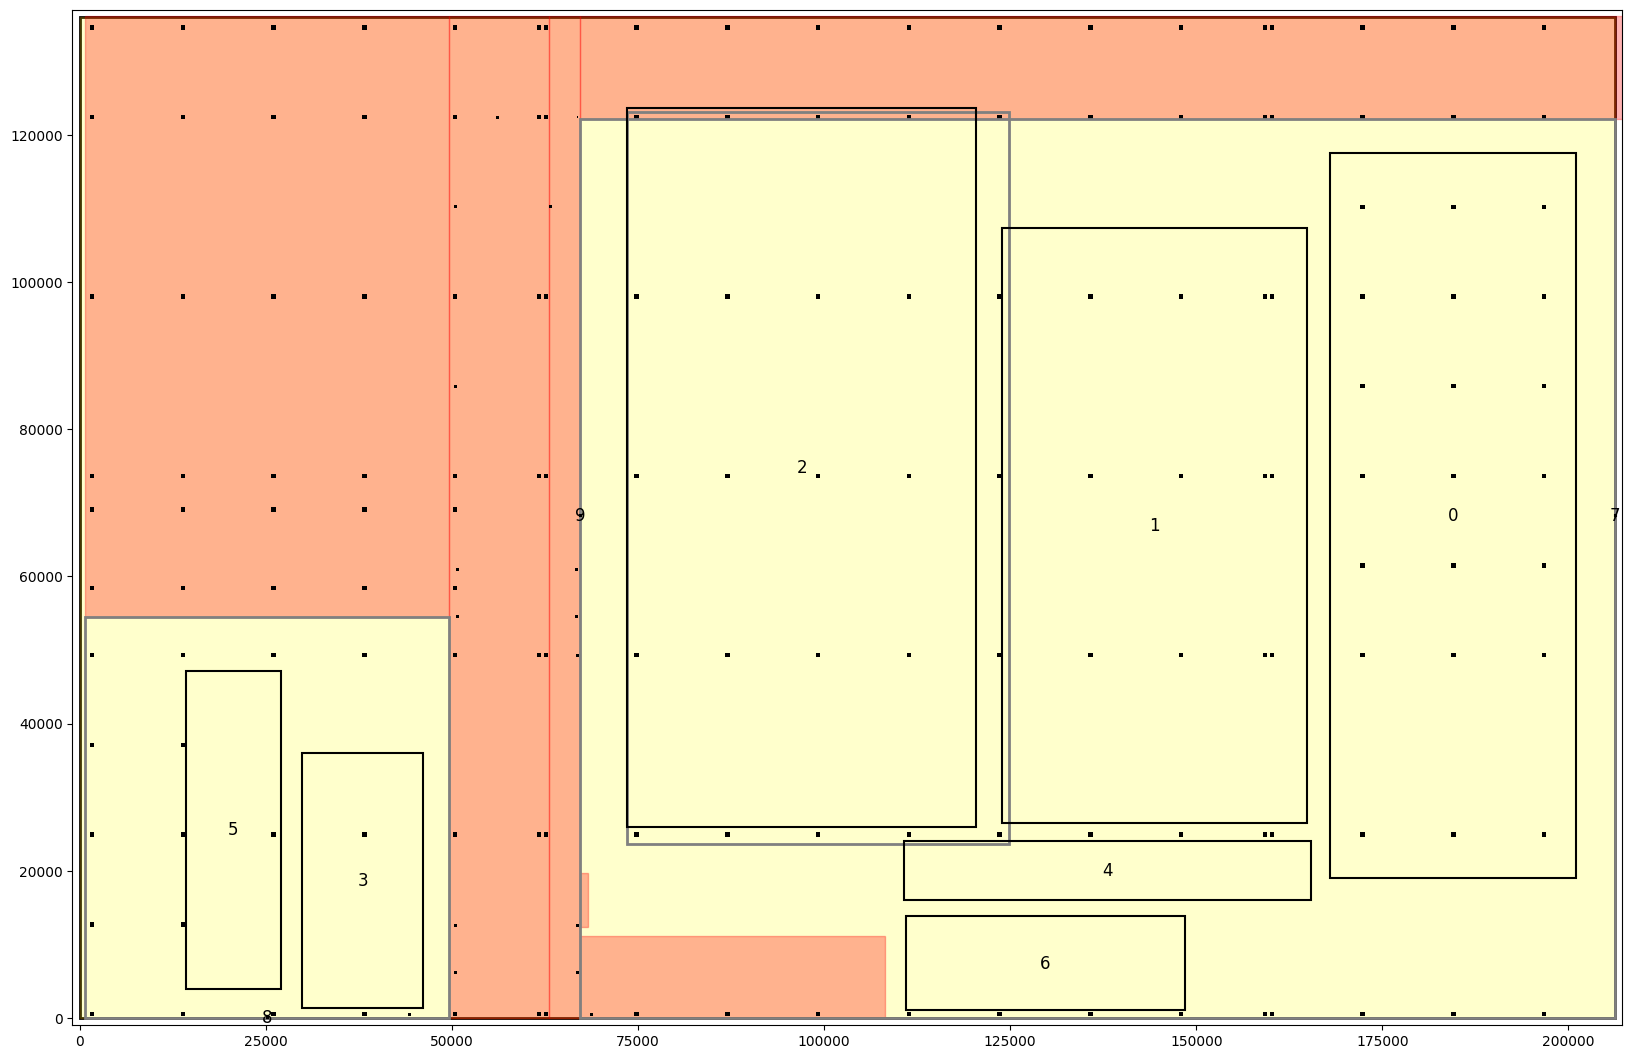

477681.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


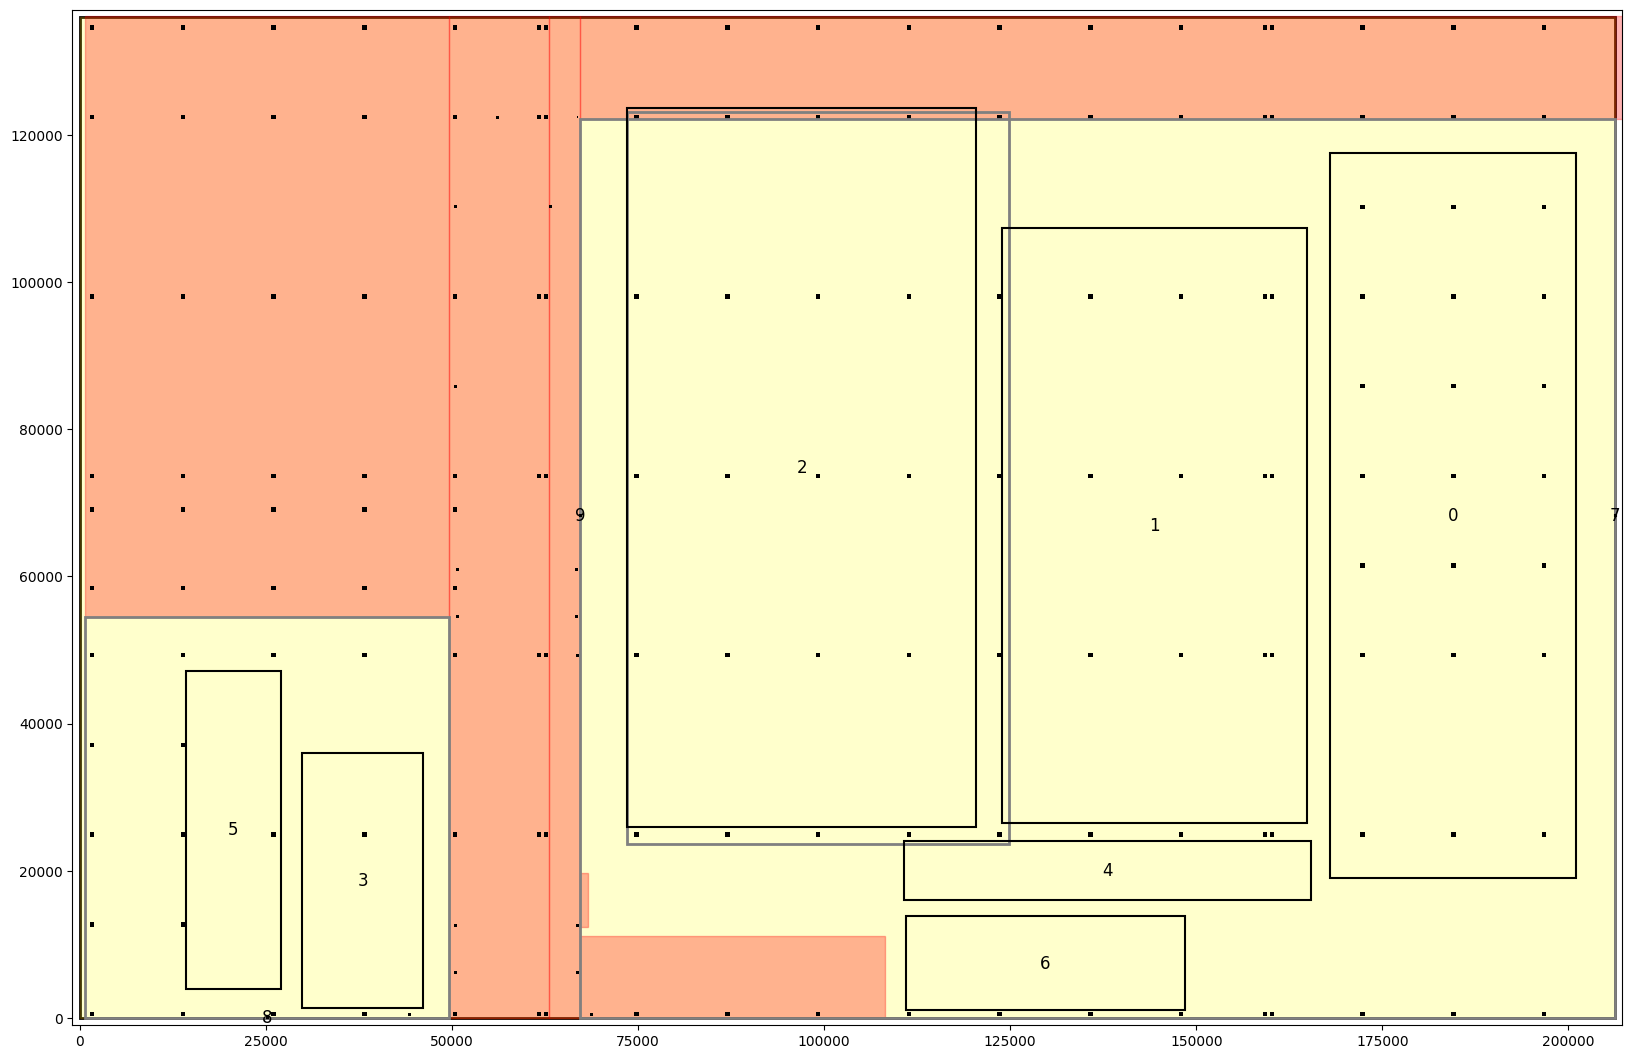

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[np.int64(3)]
477681.5
3
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(3): (np.int64(16187), np.int64(34662))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(80908)), 4: (np.int64(54705), np.int64(8010)), 6: (np.int64(37408), np.int64(12768)), np.int64(5): (np.int64(12768), np.int64(43168)), np.int64(3): (np.int64(16187), np.int64(34662))}
{np.int64(2): (46900.0, 97686.0), np.int64(7): (100.0, 100.0), np.int64(8): (100.0, 100.0), np.int64(9): (100.0, 100.0), 0: (np.int64(33028), np.int64(98550)), 1: (np.int64(41000), np.int64(8090

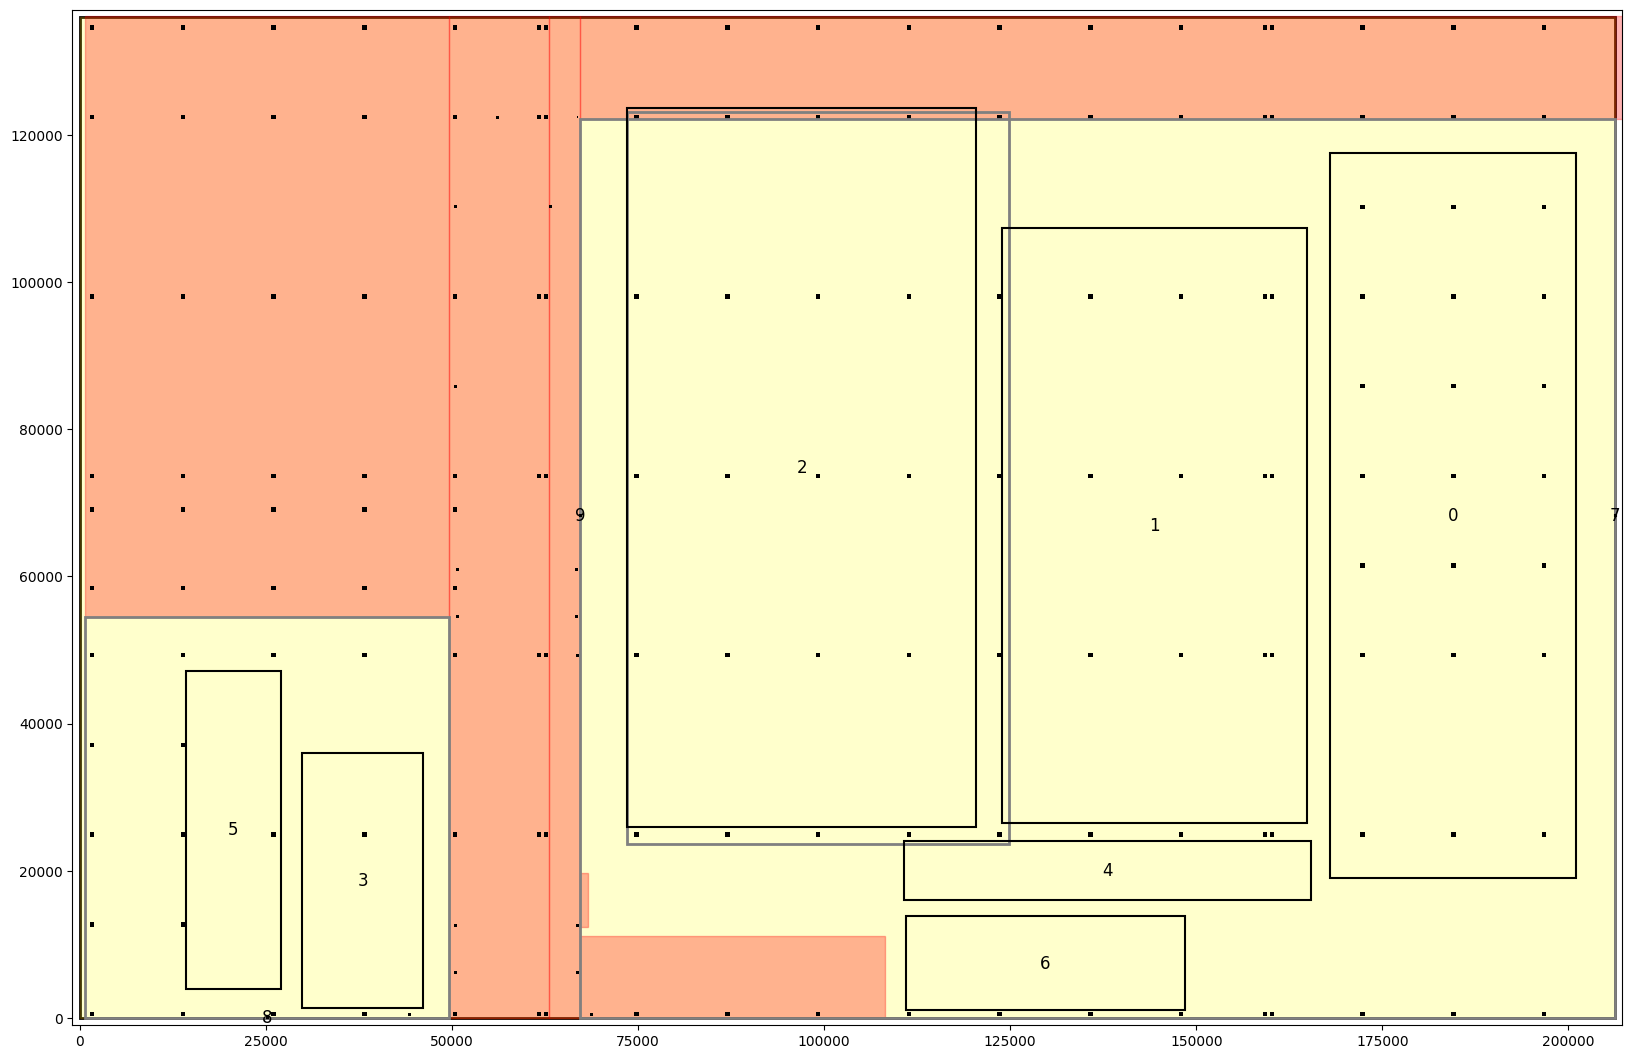

477681.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


KeyboardInterrupt: 

In [ ]:
totalTotalSolBest={}
for iRange in candSol.keys():
    s0=copy.deepcopy(candSol[iRange])
    Storage0=copy.deepcopy(candStorage[iRange])
    df_selected0=copy.deepcopy(cand_df_selected[iRange])
    lay_clusters0=copy.deepcopy(cand_lay_clusters[iRange])
    totalSol_0=copy.deepcopy((s0,Storage0,df_selected0,lay_clusters0))
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol_0)

    random.seed(42)
    total_obj=cal_obj(totalSol_0)
    print(total_obj)
    iter_list=[]
    obj_list=[]
    objBest_list=[]
    iter_list.append(0)
    obj_list.append(total_obj)
    objBest_list.append(total_obj)


    facility_ids = Cluster_
    for i in pre_C.tolist():
        if i in facility_ids:
            facility_ids.remove(i)
    dx_candidates = [-500, 500]
    dy_candidates = [-500, 500]
    T0=1e7
    alpha=0.97
    iter_per_temp=100
    max_outer_iter=10
    best_bset_val=999999999999999
    totalSolBest=copy.deepcopy(totalSol_0)
    for _ in range(20):
        totalSolBest, best_val,T0,iter_list,obj_list,objBest_list= simulated_annealing(
            totalSolBest,facility_ids, dx_candidates, dy_candidates,T0,alpha,
            iter_per_temp,max_outer_iter,iter_list,obj_list,objBest_list
        )
        X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSolBest)
        plt_lay_cluster()
        total_obj=cal_obj(totalSolBest)
        if (random.uniform(0, 1) <0.5):

            c = random.choice(facility_ids)
            print("********************************")
            print(c)

            print(total_obj)
            if df_selected.loc[c,'type']=='production':
                totalSolCurrent=updateFacility(totalSolBest,c)
            else:
                totalSolCurrent=updateStorage(totalSolBest,c)
            if totalSolCurrent !=None:
                total_objCurrent=cal_obj(totalSolCurrent)
                if total_obj>total_objCurrent:
                    totalSolBest=copy.deepcopy(totalSolCurrent)           
            X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSolBest)
            total_obj=cal_obj(totalSolBest)
            print(total_obj)
            print("********************************")
            
                
        else:

        
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            if [p for p in paths if p and p[-1] == '<CYCLE>']==[]:
                DestroyNum=2
                destroyFacility=[]
                destroyPlace=random.choice(list(place_mezz.keys()))
                candDestroyFacility=df_selected[df_selected['placeable']==destroyPlace].index
                if len(candDestroyFacility)!=0:
                    destroyFacility=random.choices(candDestroyFacility, k=DestroyNum)
                else:
                    destroyFacility=[]
                destroyFacility=list(set(destroyFacility))
            else:
                destroyFacility=selectDestroyCycle(paths)
            print(destroyFacility)
            print(total_obj)
            for deFa in destroyFacility:
                if deFa in pre_C:
                    continue
                del X[deFa], Y[deFa], o[deFa], di[deFa]
                lay_clusters.remove(deFa)
            totalSolCurrent=copy.deepcopy(((X,Y,o,di),(s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0),df_selected,lay_clusters))
            
            for deFa in destroyFacility:
                if deFa in pre_C:
                    if deFa==destroyFacility[-1]:
                        totalSolBest=copy.deepcopy(totalSolCurrent)                
                    continue
                if df_selected.loc[deFa,'type']=='production':
                    print(deFa)
                    totalSolCurrent=updateFacility(totalSolCurrent,deFa)
                else:
                    print(deFa)
                    totalSolCurrent=updateStorage(totalSolCurrent,deFa)
                if totalSolCurrent ==None:
                    break
                if deFa==destroyFacility[-1]:
                    total_objCurrent=cal_obj(totalSolCurrent)
                    if total_obj>total_objCurrent:
                        totalSolBest=copy.deepcopy(totalSolCurrent)
            X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSolBest) 
            plt_lay_cluster()
            total_obj=cal_obj(totalSolBest)
            print(total_obj)
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    totalTotalSolBest[iRange]=copy.deepcopy(totalSolBest)

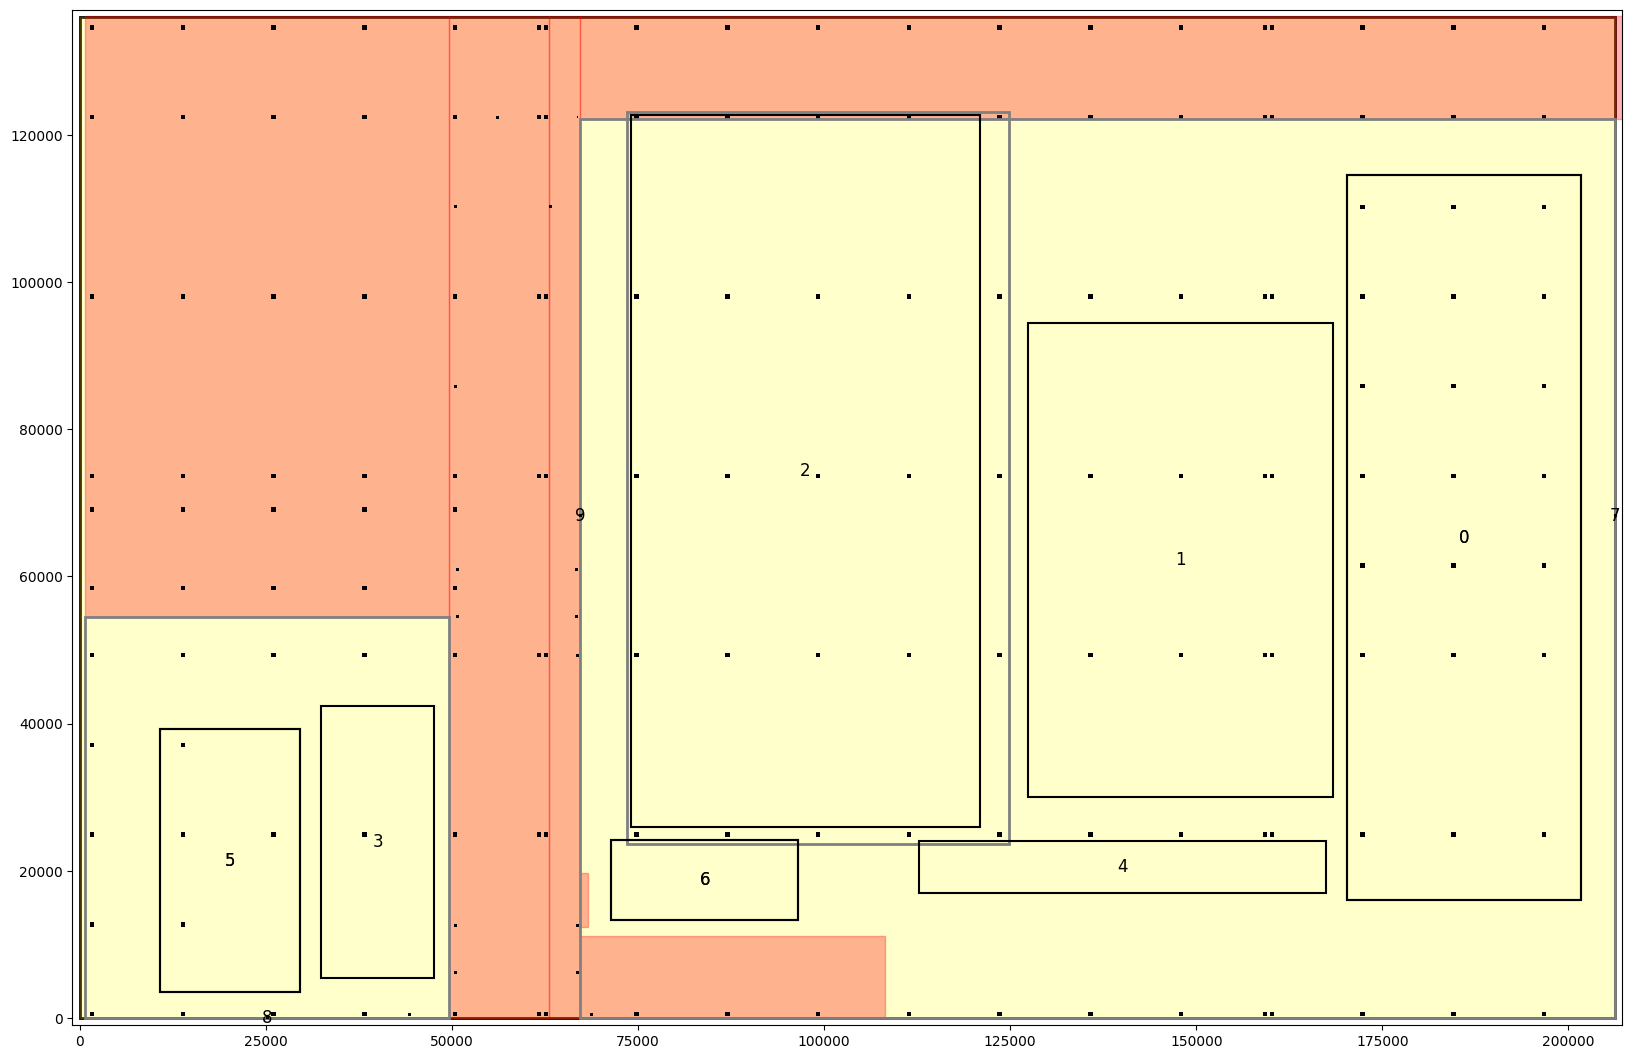

In [ ]:
for k_2 in totalTotalSolBest.keys():
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalTotalSolBest[k_2])
    plt_lay_cluster()

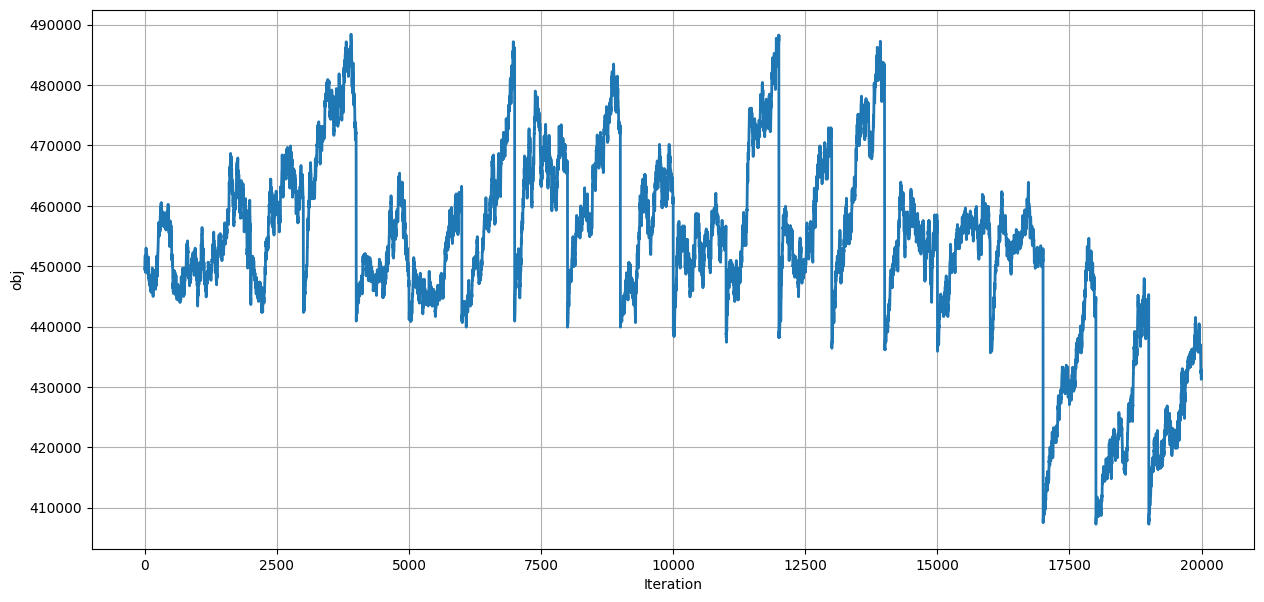

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(iter_list, obj_list, marker=None, linewidth=2)  # 꺾은선 그래프 + 점 표시
# plt.axhline(y=401750, linestyle='--',color='red', linewidth=4)  


plt.xlabel('Iteration')
plt.ylabel('obj')

# plt.ylim(390000,490000)
plt.grid(True)              # 눈금선(Optional)

plt.show()

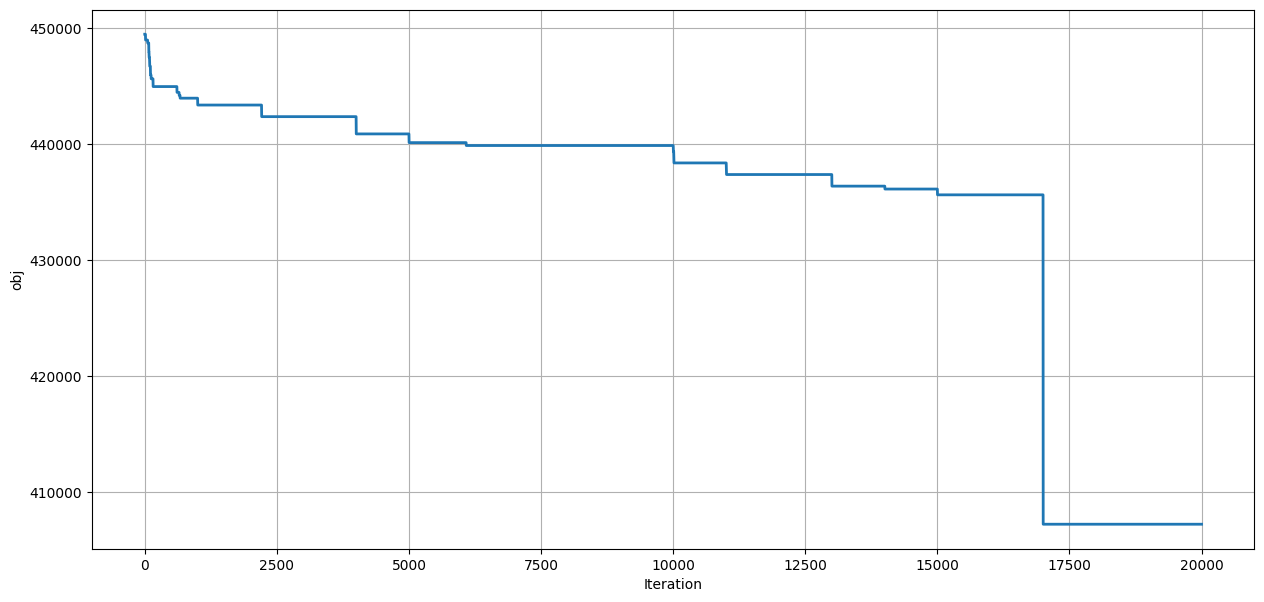

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(iter_list, objBest_list, marker=None, linewidth=2)  # 꺾은선 그래프 + 점 표시
# plt.axhline(y=401750, linestyle='--',color='red', linewidth=4)  


plt.xlabel('Iteration')
plt.ylabel('obj')

# plt.ylim(390000,490000)
plt.grid(True)              # 눈금선(Optional)

plt.show()

In [ ]:
for i in df_selected.index:
    cluster_x_array[i]=df_selected.at[i,'Cluster_X']
    cluster_y_array[i]=df_selected.at[i,'Cluster_Y']
make_txt()

result_output.txt 저장 완료


In [ ]:
enex=cal_enex(X)
enex

{np.int64(2): {'en_x': np.float64(98970.0),
  'en_y': np.float64(27477.0),
  'ex_x': np.float64(95499.0),
  'ex_y': np.float64(121237.0)},
 np.int64(7): {'en_x': np.float64(206242.0),
  'en_y': np.float64(68302.0),
  'ex_x': np.float64(206342.0),
  'ex_y': np.float64(68302.0)},
 np.int64(8): {'en_x': np.float64(25150.0),
  'en_y': np.float64(51.0),
  'ex_x': np.float64(25250.0),
  'ex_y': np.float64(51.0)},
 np.int64(9): {'en_x': np.float64(67228.0),
  'en_y': np.float64(68302.0),
  'ex_x': np.float64(67328.0),
  'ex_y': np.float64(68302.0)},
 4: {'en_x': np.float64(140080.0),
  'en_y': np.float64(18477.0),
  'ex_x': np.float64(140080.0),
  'ex_y': np.float64(22561.0)},
 np.int64(1): {'en_x': np.float64(148711.0),
  'en_y': np.float64(64035.0),
  'ex_x': np.float64(144903.0),
  'ex_y': np.float64(64035.0)},
 6: {'en_x': np.float64(83953.0),
  'en_y': np.float64(18775.0),
  'ex_x': np.float64(83953.0),
  'ex_y': np.float64(18775.0)},
 0: {'en_x': np.float64(199949.0),
  'en_y': np.float

# def

In [ ]:
def plt_cluster_1():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=(14, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        

        
#     for area in weight_areas:
#         weight_rect = plt.Rectangle(
#             (area["x"], area["y"]),
#             area["width"],
#             area["height"],
#             linewidth=1,
#             edgecolor='blue',
#             facecolor='blue',
#             alpha=0.4
#         )
#         ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)


    dims_ = {}
    for c in clusters:
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated
        else:
            dims_[c] = (W0[c], H0[c])  # original 

    for c in clusters:
        w, h = dims_[c]
        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

        if df_selected.loc[c,'type']==1:
            if k[c]+o[c]!=1:
                llx = X[c] - w/2
                lly = Y[c] - (h/2)/3
                rect = patches.Rectangle((llx, lly), w, h/3, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)
            else:
                llx = X[c] - (w/2)/3
                lly = Y[c] - h/2
                rect = patches.Rectangle((llx, lly), w/3, h, fill=False, linewidth=1.5,edgecolor='red')
                ax.add_patch(rect)
                ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)
    # 축 범위
    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)


    plt.show()

In [ ]:
def plt_f_1():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=(14, 8))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1-area["ceilingHeight"]/dims["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)

    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)


#     dims_ = {}
#     for c in clusters:
#         if o[c] == 1:
#             dims_[c] = (H0[c], W0[c])  # rotated
#         else:
#             dims_[c] = (W0[c], H0[c])  # original 

#     # for c in clusters:
#     #     w, h = dims_[c]
#     #     llx = X[c] - w/2
#     #     lly = Y[c] - h/2
#     #     rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
#     #     ax.add_patch(rect)
#     #     ax.text(X[c], Y[c], str(c), ha='center', va='center', fontsize=12)

#     for c in range(len(df_result)):
#         if df_result.iloc[c]['회전'] == 1:
#             dims_[c] = (df_result.iloc[c]['y'],df_result.iloc[c]['x'])  # rotated
#         else:
#             dims_[c] = (df_result.iloc[c]['x'], df_result.iloc[c]['y'])     
#         w, h = dims_[c]
#         llx = df_result.iloc[c]['center_X'] - w/2
#         lly = df_result.iloc[c]['center_Y'] - h/2
#         rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
#         ax.add_patch(rect)
#         ax.text(df_result.iloc[c]['center_X'], df_result.iloc[c]['center_Y'], str(c), ha='center', va='center', fontsize=12)

    # 축 범위
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)



    plt.show()

In [ ]:
def moving_L_multiple(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for _ in range(100000):

        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:
                x_up=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X']))/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_X'].iloc[0]
                x_do=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X']))/2-df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_X'].iloc[0]

                y_up=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y']))/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_Y'].iloc[0]
                y_do=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y']))/2-df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_Y'].iloc[0]

                if df_result.iloc[c]['k']+df_result.iloc[c]['회전']!=1:                    
                    if x_ck>=Xupper/2:
                        x_ck+=50
                        if x_ck-ro_ck[0]/2-clear<Xunder:
                            return False, x_ck, y_ck
                        break                     
                    else:
                        x_ck-=50
                        if x_ck-ro_ck[0]/2-clear<Xunder:
                            return False, x_ck, y_ck
                        break   
                else:

                    y_ck+=50
                    if y_ck+ro_ck[1]/2+clear>Yupper:
                        return False, x_ck, y_ck
                    break                       

        if feasible==True:
            break

    return feasible, x_ck, y_ck

In [ ]:
k_cluster[0]

{'y': np.int64(19), 'x': 1}

In [ ]:
def moving_L_pl_ch(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]
        
    d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
    place_areas_cluster=[item for item in place_areas if item['id'] == df_selected.loc[d,'placeable']]
    if df_selected.loc[d,'processGroup']=='dock':
        return True,None
    
    for r in range(len(place_areas_cluster)):
        if r==0:
            feasible=True
        else:
            if feasible==True:
                break
            else:
                feasible=True
            
        x_uni=(place_areas_cluster[r]["x"],place_areas_cluster[r]["x"]+place_areas_cluster[r]["width"])
        y_uni=(place_areas_cluster[r]["y"],place_areas_cluster[r]["y"]+place_areas_cluster[r]["height"])

        if x_ck+ro_ck[0]/2>max(x_uni):
            feasible=False
            

        if x_ck-ro_ck[0]/2<min(x_uni):
            feasible=False
            


        if y_ck+ro_ck[1]/2>max(y_uni):
            feasible=False
            


        if y_ck-ro_ck[1]/2<min(y_uni):
            feasible=False
            
    if feasible==False:
        return feasible,d
    return feasible,None

In [ ]:
def moving_L_multiple_re(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for _ in range(100000):

        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:
                x_up=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X']))/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_X'].iloc[0]
                x_do=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_X']))/2-df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_X'].iloc[0]

                y_up=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y']))/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_Y'].iloc[0]
                y_do=(min(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])+max(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y']))/2-df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['Cluster_Y'].iloc[0]
                y_mean=sum(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])/len(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y'])
               
                if df_result.iloc[c]['k']+df_result.iloc[c]['회전']!=1:                    
                    if x_ck>=Xupper/2:
                        x_ck+=50
                        if x_ck-ro_ck[0]/2-clear<Xunder:
                            return False, x_ck, y_ck
                        break                     
                    else:
                        x_ck+=50
                        if x_ck-ro_ck[0]/2-clear<Xunder:
                            return False, x_ck, y_ck
                        break   
                else:
                    if y_mean>=Yupper/2:
                        y_ck+=50
                        if y_ck+ro_ck[1]/2+clear>Yupper:
                            return False, x_ck, y_ck
                        break                       
                    else:
                        y_ck+=50
                        if y_ck-ro_ck[1]/2-clear<Yunder:
                            return False, x_ck, y_ck
                        break 
        if feasible==True:
            break

    return feasible, x_ck, y_ck

In [ ]:
def moving_L_single(c):


    best_i=100
    for t in range(8):
        if t<4:
            ro_ch=0
            if df_result.loc[c,'회전']==0:
                ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
            else:
                ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
        
        else:
            if best_i==100:
                ro_ch=1
                if df_result.loc[c,'회전']==0:
                    ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]                
                else:
                    ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]

        x_ck=df_result.loc[c,'center_X']
        y_ck=df_result.loc[c,'center_Y']
        clear=0        
        for i in range(best_i):
            if (x_ck-ro_ck[0]/2-clear<Xunder) or (x_ck-ro_ck[0]/2-clear<Xunder):
                break
            for r in range(len(column_areas)):
                feasible=False
                red_feasible=0
                x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
                y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

                if x_ck+ro_ck[0]/2+clear<min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2-clear>max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2+clear<min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2-clear>max(y_uni):
                    feasible=True

                if feasible==False:                                   
                    if t==0 or t==4:
                        x_ck-=100
     
                    elif t==1 or t==5:
                        x_ck+=100
                    elif t==2 or t==6:
                        if y_ck<Yupper/2:
                            y_ck-=100
                        else:
                            y_ck+=100
                    else:
                        y_ck+=100
                    break
            if feasible==True:
                if i<=best_i:
                    best_i=i
                    best_fe=feasible
                    best_x=x_ck
                    best_y=y_ck
                break
            

    return best_fe, best_x, best_y,ro_ch

In [ ]:
def moving_L_single_last(c):

    if df_result.loc[c,'회전']==0:
        ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
    else:
        ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
    best_i=10000
    for t in range(4):
        x_ck=df_result.loc[c,'center_X']
        y_ck=df_result.loc[c,'center_Y']
        clear=0        
        for i in range(best_i):
                
            for r in range(len(column_areas)):
                feasible=False
                red_feasible=0
                x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
                y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

                if x_ck+ro_ck[0]/2+clear<min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2-clear>max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2+clear<min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2-clear>max(y_uni):
                    feasible=True

                if feasible==False:                                   
                    if t==0:
                        x_ck-=100
     
                    elif t==1:
                        x_ck+=100
                    elif t==2:
                        y_ck-=100
                    else:
                        y_ck+=100
                    break
                    
            if feasible==True:
                for r in df_result.index:
                    if r==c:
                        continue

                    feasible=False
                    clear=499
                    if df_result.loc[r,'회전']==0:
                        x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'x']/2,df_result.loc[r,'center_X']+df_result.loc[r,'x']/2]
                        y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'y']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'y']/2]
                    else:
                        x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'y']/2,df_result.loc[r,'center_X']+df_result.loc[r,'y']/2]
                        y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'x']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'x']/2]

                    if x_ck+ro_ck[0]/2+clear<min(x_uni):
                        feasible=True


                    if x_ck-ro_ck[0]/2-clear>max(x_uni):
                        feasible=True


                    if y_ck+ro_ck[1]/2+clear<min(y_uni):
                        feasible=True

                    if y_ck-ro_ck[1]/2-clear>max(y_uni):
                        feasible=True

                    if feasible==False:                                   
                        if t==0:
                            x_ck-=100

                        elif t==1:
                            x_ck+=100
                        elif t==2:
                            y_ck-=100
                        else:
                            y_ck+=100
                        break
            
                if feasible==True:
                    if (x_ck-ro_ck[0]/2-499<Xunder) or (x_ck+ro_ck[0]/2+499>Xupper) or (y_ck-ro_ck[1]/2-499<Yunder) or (y_ck+ro_ck[1]/2+499>Yupper):
                        continue
                    else:
                        if i<=best_i:
                            best_i=i
                            best_fe=feasible
                            best_x=x_ck
                            best_y=y_ck
                    break
            

    return best_fe, best_x, best_y

In [ ]:
def moving_L_reassign(c,move,di):

    if df_result.loc[c,'회전']==0:
        ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
    else:
        ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
        

    x_ck=df_result.loc[c,'center_X']
    y_ck=df_result.loc[c,'center_Y']
    clear=0 
    
    for i in range(10000):
        if (x_ck-ro_ck[0]/2-clear<Xunder) or (x_ck-ro_ck[0]/2-clear<Xunder):
            break
        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:                                   
                
                x_ck-=10
                break

    return feasible, x_ck, y_ck

In [ ]:
def moving_H(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']/3]
    else:
        ro_ck=[df_result.iloc[c]['y']/3,df_result.iloc[c]['x']]

    for _ in range(10000):

        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:

                if y_ck<min(y_uni):
                    y_ck-=10
                    if y_ck-ro_ck[1]/2-clear<Xunder:
                        print(diqweodjoe)
                    break                     
                else:
                    y_ck+=10
                    if y_ck+ro_ck[1]/2+clear>Xupper:
                        print(diqweodjoe)
                    break            

        if feasible==True:
            break
 
    return feasible, x_ck, y_ck


In [ ]:
def moving_L_2(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for _ in range(10000):

        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:
                if df_result.iloc[c]['k']+df_result.iloc[c]['회전']!=1 or len(df_result[df_result['설비Group'] == df_result.iloc[c]['설비Group']])==1:
                    if y_ck<min(y_uni):
                        y_ck-=10
                        if y_ck-ro_ck[1]/2-clear<Yunder:
                            return False, x_ck, y_ck
                        break                     
                    else:
                        y_ck+=10
                        if y_ck+ro_ck[1]/2+clear>Yupper:
                            return False, x_ck, y_ck
                        break   
                else:
                    if x_ck<min(x_uni):
                        x_ck-=10
                        if x_ck-ro_ck[0]/2-clear<Xunder:
                            return False, x_ck, y_ck
                        break                     
                    else:
                        x_ck+=10
                        if x_ck+ro_ck[0]/2+clear>Xupper:
                            return False, x_ck, y_ck
                        break  
 
        if feasible==True:
            break

    return feasible, x_ck, y_ck

In [ ]:
def Check_cluster_L(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for r in range(len(column_areas)):
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible


    return feasible


In [ ]:
def Check_cluster_L(c):
    x_ck=df_result.loc[c,'center_X']
    y_ck=df_result.loc[c,'center_Y']
    clear=0
    ne=0
    endi=0
    
    if 'L' in df_result.loc[c, '설비Group']:
        if df_result.iloc[c]['회전']==0:
            ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
        else:
            ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
    else:

        if df_result.iloc[c]['k']==0:
            if df_result.iloc[c]['회전']==0:
                ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']/3]
            else:
                ro_ck=[df_result.iloc[c]['y']/3,df_result.iloc[c]['x']]
        if df_result.iloc[c]['k']==1:
            if df_result.iloc[c]['회전']==0:
                ro_ck=[df_result.iloc[c]['x']/3,df_result.iloc[c]['y']]
            else:
                ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']/3]
                
    for r in range(len(column_areas)):
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True

        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True

        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:

            return feasible,r,1,ne,endi
        
    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
    else:
        ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
        
    for r in df_result.index:
        if r==c:
            continue
            
        feasible=False
        clear=499
        if df_result.loc[r,'회전']==0:
            x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'x']/2,df_result.loc[r,'center_X']+df_result.loc[r,'x']/2]
            y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'y']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'y']/2]
        else:
            x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'y']/2,df_result.loc[r,'center_X']+df_result.loc[r,'y']/2]
            y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'x']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'x']/2]
        ne= x_ck+ro_ck[0]/2+clear-min(x_uni)
        endi=1
        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True
            
        if ne>=max(x_uni)-x_ck+ro_ck[0]/2+clear:
            ne=max(x_uni)-x_ck+ro_ck[0]/2+clear
            endi=2
        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True
            
            
        if ne>=y_ck+ro_ck[1]/2+clear-min(y_uni):
            ne=y_ck+ro_ck[1]/2+clear-min(y_uni)
            endi=3

        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True

        if ne>=max(y_uni)- y_ck+ro_ck[1]/2+clear:
            ne=max(y_uni)- y_ck+ro_ck[1]/2+clear
            endi=3
        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible,r,2,ne,endi

    return feasible,None,0,ne,endi

In [ ]:
def Check_cluster_H(c):
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    clear=0
    if df_result.iloc[c]['k']==0:
        if df_result.iloc[c]['회전']==0:
            ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']/4]
        else:
            ro_ck=[df_result.iloc[c]['y']/4,df_result.iloc[c]['x']]
    if df_result.iloc[c]['k']==1:
        if df_result.iloc[c]['회전']==0:
            ro_ck=[df_result.iloc[c]['x']/4,df_result.iloc[c]['y']]
        else:
            ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']/4]
    for r in range(len(column_areas)):
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible


    return feasible


In [ ]:
def Check_only_cluster(c):
    x_ck=df_result.loc[c,'center_X']
    y_ck=df_result.loc[c,'center_Y']

    clear=[0,0,0,0]
    clear_2=[0,0,0,0]
    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
    else:
        ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
    d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
    if o[d]==0 and di[d]==0 :
        clear[0]=df_selected.loc[d,'UR']
        clear[1]=df_selected.loc[d,'UL']
        clear[2]=df_selected.loc[d,'UB']
        clear[3]=df_selected.loc[d,'UA']
    elif o[d]==1 and di[d]==0 :
        clear[0]=df_selected.loc[d,'UA']
        clear[1]=df_selected.loc[d,'UB']
        clear[2]=df_selected.loc[d,'UR']
        clear[3]=df_selected.loc[d,'UL']     
    elif o[d]==0 and di[d]==1 :
        clear[0]=df_selected.loc[d,'UL']
        clear[1]=df_selected.loc[d,'UR']
        clear[2]=df_selected.loc[d,'UA']
        clear[3]=df_selected.loc[d,'UB']    
    else:
        clear[0]=df_selected.loc[d,'UB']
        clear[1]=df_selected.loc[d,'UA']
        clear[2]=df_selected.loc[d,'UL']
        clear[3]=df_selected.loc[d,'UR']       
        
    
    
    for r in df_result.index:
        if r==c:
            continue
            
        feasible=False
        d_2=df_selected[df_selected['설비Group'] == df_result.loc[r, '설비Group']]['ent_X'].index[0]
        if df_result.loc[r,'회전']==0:
            x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'x']/2,df_result.loc[r,'center_X']+df_result.loc[r,'x']/2]
            y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'y']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'y']/2]
        else:
            x_uni=[df_result.loc[r,'center_X']-df_result.loc[r,'y']/2,df_result.loc[r,'center_X']+df_result.loc[r,'y']/2]
            y_uni=[df_result.loc[r,'center_Y']-df_result.loc[r,'x']/2,df_result.loc[r,'center_Y']+df_result.loc[r,'x']/2]

        if o[d_2]==0 and di[d_2]==0 :
            clear_2[0]=df_selected.loc[d_2,'UR']
            clear_2[1]=df_selected.loc[d_2,'UL']
            clear_2[2]=df_selected.loc[d_2,'UB']
            clear_2[3]=df_selected.loc[d_2,'UA']
        elif o[d_2]==1 and di[d_2]==0 :
            clear_2[0]=df_selected.loc[d_2,'UA']
            clear_2[1]=df_selected.loc[d_2,'UB']
            clear_2[2]=df_selected.loc[d_2,'UR']
            clear_2[3]=df_selected.loc[d_2,'UL']     
        elif o[d_2]==0 and di[d_2]==1 :
            clear_2[0]=df_selected.loc[d_2,'UL']
            clear_2[1]=df_selected.loc[d_2,'UR']
            clear_2[2]=df_selected.loc[d_2,'UA']
            clear_2[3]=df_selected.loc[d_2,'UB']    
        else:
            clear_2[0]=df_selected.loc[d_2,'UB']
            clear_2[1]=df_selected.loc[d_2,'UA']
            clear_2[2]=df_selected.loc[d_2,'UL']
            clear_2[3]=df_selected.loc[d_2,'UR']           
        clear_=max(clear[0],clear_2[1])   

        if x_ck+ro_ck[0]/2+clear_<=min(x_uni):
            feasible=True
        clear_=max(clear[1],clear_2[0])   
        if x_ck-ro_ck[0]/2-clear_>=max(x_uni):
            feasible=True

        clear_=max(clear[3],clear_2[2])   
        if y_ck+ro_ck[1]/2+clear_<=min(y_uni):
            feasible=True
        if c==0 and r==1:
            print(clear)
            print(clear_2)
            print(y_ck+ro_ck[1]/2+clear_)
            print(min(y_uni))
            print(feasible)
        clear_=max(clear[2],clear_2[3])   
        if y_ck-ro_ck[1]/2-clear_>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible,r

    return feasible,r

In [ ]:
def plt_f_2():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=((Xupper/Xupper)*20, round((Yupper/Xupper)*20,2)))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)

    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}


    for c in df_result.index:
        

        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            dims_[c] = (df_result.loc[c,'y'],df_result.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_result.loc[c,'center_X'] - w/2
        lly = df_result.loc[c,'center_Y'] - h/2
        if "L" in df_result.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if df_result.loc[c,'type']==1:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,color='blue')
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90,color='blue')
        else:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)

    for c in df_result.index:
        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            w=df_result.loc[c,'y'] # rotated
            h=df_result.loc[c,'x']
        else:
            w=df_result.loc[c,'x'] # rotated
            h=df_result.loc[c,'y'] 
            
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
     
        ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
        ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
        ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
        ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2

        if (df_result.loc[c,'회전']==0) & (df_result.loc[c,'대칭']==0):
            
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif (df_result.loc[c,'회전']==1) & (df_result.loc[c,'대칭']==0):

            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif (df_result.loc[c,'회전']==0 )& (df_result.loc[c,'대칭']==1):

            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_result.loc[c,'center_X'] + en_x, df_result.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_result.loc[c,'center_X'] + ex_x, df_result.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)

    dims_ = {}
    for c in df_selected.index:
        if df_selected.loc[c,'type']!='storage':
            continue
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated
        else:
            dims_[c] = (W0[c], H0[c])  # original 


        w, h = dims_[c]
        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if o[c]==0:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8,rotation=90)
        else:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8)
                
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 1000)



    plt.show()

In [ ]:
def plt_f_3():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]

    fig, ax = plt.subplots(figsize=(14, 8))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)
        
        
    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}
    for c in df_pre.index:


        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            dims_[c] = (df_pre.loc[c,'y'],df_pre.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_pre.loc[c,'x'], df_pre.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_pre.loc[c,'center_X'] - w/2
        lly = df_pre.loc[c,'center_Y'] - h/2
        if "L" in df_pre.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if df_pre.loc[c,'type']==1:
            fs=2
            if w>=h:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,color='blue')
            else:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90,color='blue')
        else:
            fs=2
            if w>=h:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
            else:
                ax.text(df_pre.loc[c,'center_X'], df_pre.loc[c,'center_Y'], f"{df_pre.loc[c, '설비Group']}_{df_pre.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)


    dims_ = {}


    for c in df_result.index:
        

        if df_result.loc[c,'설비Group']=='FAC001175574169193039' or df_result.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_result.loc[c,'회전'] == 1:
            dims_[c] = (df_result.loc[c,'y'],df_result.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_result.loc[c,'center_X'] - w/2
        lly = df_result.loc[c,'center_Y'] - h/2
        if "L" in df_result.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if df_result.loc[c,'type']==1:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,color='blue')
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90,color='blue')
        else:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)
    
    for c in df_result.index:
        if df_result.loc[c,'설비Group']=='FAC001175574169193039' or df_result.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_result.loc[c,'회전'] == 1:
            w=df_result.loc[c,'y'] # rotated
            h=df_result.loc[c,'x']
        else:
            w=df_result.loc[c,'x'] # rotated
            h=df_result.loc[c,'y'] 
            
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
        ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
        ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
        ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2
        
        if o[d]==0 and di[d]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif o[d]==1 and di[d]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif o[d]==0 and di[d]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_result.loc[c,'center_X'] + en_x, df_result.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_result.loc[c,'center_X'] + ex_x, df_result.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)

    for c in df_pre.index:
        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            w=df_pre.loc[c,'y'] # rotated
            h=df_pre.loc[c,'x']
        else:
            w=df_pre.loc[c,'x'] # rotated
            h=df_pre.loc[c,'y'] 
            
        d=df_selected_copy_2[df_selected_copy_2['설비Group'] == df_pre.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected_copy_2.loc[d,'ent_X']-df_pre.loc[c,'x']/2
        ori_en_y=df_selected_copy_2.loc[d,'ent_Y']-df_pre.loc[c,'y']/2
        ori_ex_x=df_selected_copy_2.loc[d,'exi_X']-df_pre.loc[c,'x']/2
        ori_ex_y=df_selected_copy_2.loc[d,'exi_Y']-df_pre.loc[c,'y']/2
        
        if df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif df_pre.loc[c, '회전']==1 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_pre.loc[c,'center_X'] + en_x, df_pre.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_pre.loc[c,'center_X'] + ex_x, df_pre.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)        
    ax.set_xlim(-1000, dims["width"] + 1000)
    ax.set_ylim(-1000, dims["height"] + 10000)



    plt.show()

In [ ]:
def Re_cluster(c,x_ck,y_ck,o_ck):

    clear=500
    if o_ck==0:
        ro_ck=[df_selected.iloc[c]['Cluster_X'],df_selected.iloc[c]['Cluster_Y']]
    else:
        ro_ck=[df_selected.iloc[c]['Cluster_Y'],df_selected.iloc[c]['Cluster_X']]

    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible

    for r in range(len(new_c)):
        feasible=False
        if new_c[r][3]==0:
            x_uni=[new_c[r][1]-df_selected.iloc[new_c[r][0]]["Cluster_X"]/2,new_c[r][1]+df_selected.iloc[new_c[r][0]]["Cluster_X"]/2]
            y_uni=[new_c[r][2]-df_selected.iloc[new_c[r][0]]["Cluster_Y"]/2,new_c[r][2]+df_selected.iloc[new_c[r][0]]["Cluster_Y"]/2]
        else:
            x_uni=[new_c[r][1]-df_selected.iloc[new_c[r][0]]["Cluster_Y"]/2,new_c[r][1]+df_selected.iloc[new_c[r][0]]["Cluster_Y"]/2]
            y_uni=[new_c[r][2]-df_selected.iloc[new_c[r][0]]["Cluster_X"]/2,new_c[r][2]+df_selected.iloc[new_c[r][0]]["Cluster_X"]/2]            
        if x_ck+ro_ck[0]/2+clear*2<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear*2>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear*2<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear*2>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible        
        
        
        
        
        
    return feasible

In [ ]:
def moving_L_re(c):
    x_ck=df_r.iloc[c]['center_X']
    y_ck=df_r.iloc[c]['center_Y']
    clear=0

    if df_r.iloc[c]['회전']==0:
        ro_ck=[df_r.iloc[c]['x'],df_r.iloc[c]['y']]
    else:
        ro_ck=[df_r.iloc[c]['y'],df_r.iloc[c]['x']]

    for _ in range(10000):

        for r in range(len(column_areas)):
            feasible=False
            red_feasible=0
            x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
            y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

            if x_ck+ro_ck[0]/2+clear<min(x_uni):
                feasible=True

            if x_ck-ro_ck[0]/2-clear>max(x_uni):
                feasible=True


            if y_ck+ro_ck[1]/2+clear<min(y_uni):
                feasible=True


            if y_ck-ro_ck[1]/2-clear>max(y_uni):
                feasible=True

            if feasible==False:
                if df_r.iloc[c]['k']+df_r.iloc[c]['회전']!=1:
                    
                    x_ck-=10
                    if x_ck-ro_ck[0]/2-clear<Xunder:
                        return False, x_ck, y_ck
                    break                     
  
                else:

                    y_ck-=10
                    if y_ck-ro_ck[1]/2-clear<Yunder:
                        return False, x_ck, y_ck
                    break                     

        if feasible==True:
            break

    return feasible, x_ck, y_ck


In [ ]:
def Re_cluster_col(c,x_ck,y_ck,o_ck):

    clear=0

    if o_ck==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible

    for r in df_r.index:
        clear=500
        feasible=False
        if df_r.loc[r]['회전']==0:
            x_uni=[df_r.loc[r]['center_X']-df_r.loc[r]['x']/2,df_r.loc[r]['center_X']+df_r.loc[r]['x']/2]
            y_uni=[df_r.loc[r]['center_Y']-df_r.loc[r]['y']/2,df_r.loc[r]['center_Y']+df_r.loc[r]['y']/2]
        else:
            x_uni=[df_r.loc[r]['center_X']-df_r.loc[r]['y']/2,df_r.loc[r]['center_X']+df_r.loc[r]['y']/2]
            y_uni=[df_r.loc[r]['center_Y']-df_r.loc[r]['x']/2,df_r.loc[r]['center_Y']+df_r.loc[r]['x']/2]            
        
        if x_ck+ro_ck[0]/2+clear*2<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear*2>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear*2<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear*2>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible    
        
    for r in range(len(column_areas)):
        clear=0
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible

    return feasible

In [ ]:
def Re_cluster_col_2(c,x_ck,y_ck,o_ck):

    clear=0

    if o_ck==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]

    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible

    for r in df_result.index:
        clear=500
        feasible=False
        if df_result.loc[r]['회전']==0:
            x_uni=[df_result.loc[r]['center_X']-df_result.loc[r]['x']/2,df_result.loc[r]['center_X']+df_result.loc[r]['x']/2]
            y_uni=[df_result.loc[r]['center_Y']-df_result.loc[r]['y']/2,df_result.loc[r]['center_Y']+df_result.loc[r]['y']/2]
        else:
            x_uni=[df_result.loc[r]['center_X']-df_result.loc[r]['y']/2,df_result.loc[r]['center_X']+df_result.loc[r]['y']/2]
            y_uni=[df_result.loc[r]['center_Y']-df_result.loc[r]['x']/2,df_result.loc[r]['center_Y']+df_result.loc[r]['x']/2]            
        
        if x_ck+ro_ck[0]/2+clear*2<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear*2>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear*2<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear*2>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible    

    for r in df_r.index:
        clear=500
        feasible=False
        if df_r.loc[r]['회전']==0:
            x_uni=[df_r.loc[r]['center_X']-df_r.loc[r]['x']/2,df_r.loc[r]['center_X']+df_r.loc[r]['x']/2]
            y_uni=[df_r.loc[r]['center_Y']-df_r.loc[r]['y']/2,df_r.loc[r]['center_Y']+df_r.loc[r]['y']/2]
        else:
            x_uni=[df_r.loc[r]['center_X']-df_r.loc[r]['y']/2,df_r.loc[r]['center_X']+df_r.loc[r]['y']/2]
            y_uni=[df_r.loc[r]['center_Y']-df_r.loc[r]['x']/2,df_r.loc[r]['center_Y']+df_r.loc[r]['x']/2]            
        
        if x_ck+ro_ck[0]/2+clear*2<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear*2>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear*2<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear*2>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible           
    for r in range(len(column_areas)):
        clear=0
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>max(y_uni):
            feasible=True

        if feasible==False:
            return feasible

    return feasible

In [ ]:
def plt_r_1():

    dims = data["factoryDimensions"]
    mezz_areas = data["placeableAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]


    fig, ax = plt.subplots(figsize=(13, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in mezz_areas:
        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=0.4
        )
        ax.add_patch(mezz_rect)

    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)

    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}


    # 축 범위
    ax.set_xlim(0, 300000)
    ax.set_ylim(-10000, 150000)


    plt.show()

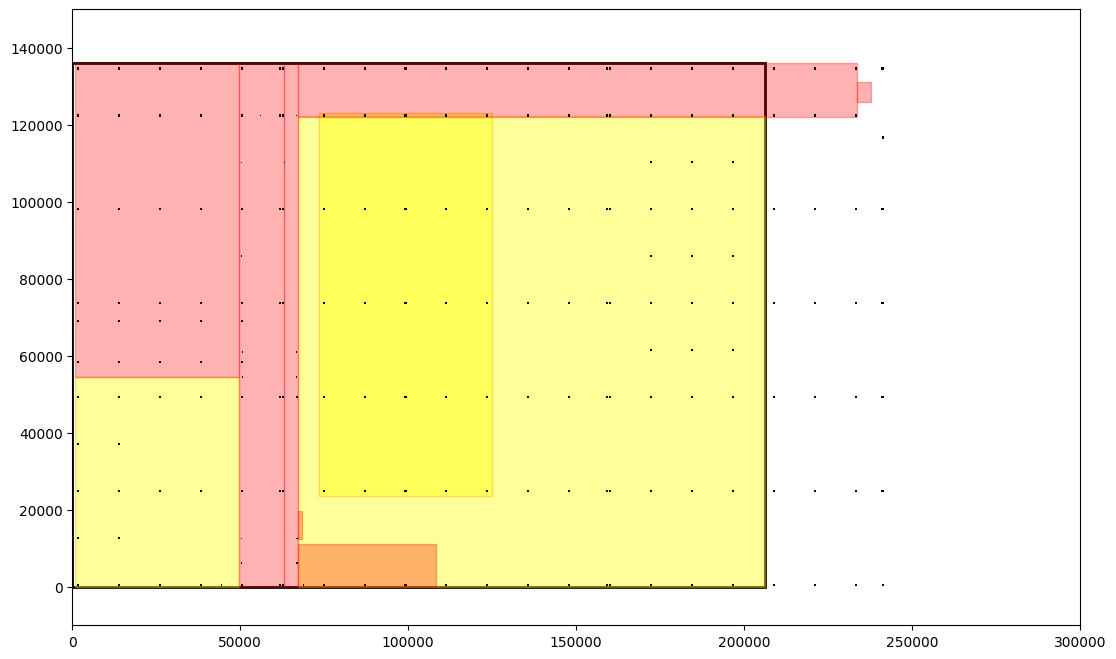

In [ ]:
plt_r_1()


In [ ]:
def plt_r_2():

    dims = data["factoryDimensions"]
    mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]


    fig, ax = plt.subplots(figsize=(13, 8))

    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)

    for area in mezz_areas:
        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=0.4
        )
        ax.add_patch(mezz_rect)

    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)

    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}



    for c in df_r.index:
        if df_r.loc[c,'회전'] == 1:
            dims_[c] = (df_r.loc[c,'y'],df_r.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_r.loc[c,'x'], df_r.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_r.loc[c,'center_X'] - w/2
        lly = df_r.loc[c,'center_Y'] - h/2
        if "L" in df_r.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(df_r.loc[c,'center_X'], df_r.loc[c,'center_Y'], str(c), ha='center', va='center', fontsize=12)

    # 축 범위
    ax.set_xlim(0, 300000)
    ax.set_ylim(-10000, 150000)


    plt.show()

# 초기탐색로직

In [ ]:
cluster_x_array=[]
cluster_y_array=[]
for i in df_selected.index:
    cluster_x_array.append(df_selected.loc[i,'Cluster_X'])
    cluster_y_array.append(df_selected.loc[i,'Cluster_Y'])

# 시각화

In [ ]:
# # 1. TXT에서 데이터 읽기
# with open("Value_output_2.txt", "r", encoding="utf-8") as f:
#     raw_data = f.read()

# di = {}
# o = {}
# X = {}
# Y_original = {}
# e_x_t={}
# e_y_t={}
# e_x_t_list=[]
# e_y_t_list=[]
# s_x_t={}
# s_y_t={}
# s_x_t_list=[]
# s_y_t_list=[]
# sfc_to={}
# sfc_from={}
# for c in C_s:
#     sfc_to[c]=[]
#     sfc_from[c]=[]

# # 2. 데이터 파싱
# for line in raw_data.strip().splitlines():
#     try:
#         key, val = line.strip().split(":")
#         var, idx = key.strip().split("_")
#         idx = int(idx.strip())
#         val = float(val.strip()) if '.' in val or var == 'X' else int(val.strip())
#     except:
#         key, val = line.strip().split(":")
#         var, idx,idx_2 = key.strip().split("_",2)
#         idx = int(idx.strip())
#         idx_2 = int(idx_2.strip())
#         val = float(val.strip()) if '.' in val or var == 'X' else int(val.strip())        
        
#     if var == 'Lo':
#         di[idx] = round(val)    
#     elif var == 'Bo':
#         o[idx] = round(val) 
#     elif var == 'Ao':
#         di[idx] = round(val)
#         o[idx] = round(val)
#     elif var == 'X':
#         X[idx] = val
#     elif var == 'Y':
#         Y_original[idx] = val
#     elif var == 'Bom' or var == 'Lom' or var == 'Rom' or var == 'Aom':

#         cluster_x_array[idx]=cluster_x_array_m[idx]
#         cluster_y_array[idx]=cluster_y_array_m[idx]
#         df_selected.loc[idx,'설비수량']=to_m[idx]
#         df_selected.loc[idx,'Cluster_X']=cluster_x_array_m[idx]
#         df_selected.loc[idx,'Cluster_Y']=cluster_y_array_m[idx]
#     elif var == 'Bos' or var == 'Los' or var == 'Ros' or var == 'Aos':
#         cluster_x_array[idx]=cluster_x_array_s[idx]
#         cluster_y_array[idx]=cluster_y_array_s[idx]
#         df_selected.loc[idx,'설비수량']=to_s[idx]
#         df_selected.loc[idx,'Cluster_X']=cluster_x_array_s[idx]
#         df_selected.loc[idx,'Cluster_Y']=cluster_y_array_s[idx]
#     elif var == 'ext':
#         e_x_t_list.append(val)
#         e_x_t[idx] = val 
#         df_selected.loc[idx,'Cluster_X']=a_e[0]+b_e[0]*val
#         df_selected.loc[idx,'x']=a_e[0]+b_e[0]*val
#         cluster_x_array[idx]=df_selected.loc[idx,'Cluster_X']
#         df_selected.loc[idx,'ent_X']=a_e[0]+b_e[0]*val
#         df_selected.loc[idx,'exi_X']=a_e[0]+b_e[0]*val
#     elif var == 'eyt':
#         e_y_t_list.append(val)
#         e_y_t[idx] = val
#         df_selected.loc[idx,'Cluster_Y']=c_e[0]*val-d_e[0]
#         df_selected.loc[idx,'설비수량']=val
#         cluster_y_array[idx]=df_selected.loc[idx,'Cluster_Y']
#     elif var == 'sxt':
#         s_x_t_list.append(val)
#         s_x_t[idx] = val 
#         print("c: ",idx)
#         print("val: ",val)
#         if val!=0:
#             df_selected.loc[idx,'Cluster_X']=a_s_dic[idx]+b_s_dic[idx]*val
#             df_selected.loc[idx,'x']=a_s_dic[idx]+b_s_dic[idx]*val
#             cluster_x_array[idx]=df_selected.loc[idx,'Cluster_X']
#             df_selected.loc[idx,'ent_X']=a_s_dic[idx]+b_s_dic[idx]*val
#             df_selected.loc[idx,'exi_X']=a_s_dic[idx]+b_s_dic[idx]*val
#         else:
#             df_selected.loc[idx,'Cluster_X']=0
#             df_selected.loc[idx,'x']=0
#             cluster_x_array[idx]=df_selected.loc[idx,'Cluster_X']
#             df_selected.loc[idx,'ent_X']=0
#             df_selected.loc[idx,'exi_X']=0
#     elif var == 'syt':
#         print("c: ",idx)
#         print("val: ",val)
#         s_y_t_list.append(val)
#         s_y_t[idx] = val
#         if val!=0:
#             df_selected.loc[idx,'Cluster_Y']=c_s_dic[idx]*val+d_s_dic[idx]
#             df_selected.loc[idx,'설비수량']=val
#             cluster_y_array[idx]=df_selected.loc[idx,'Cluster_Y']
#         else:
#             df_selected.loc[idx,'Cluster_Y']=0
#             df_selected.loc[idx,'설비수량']=val
#             cluster_y_array[idx]=df_selected.loc[idx,'Cluster_Y'] 
#     elif var=='sfc':
#         if group_matrix.iloc[idx_2,idx]==1:
#             sfc_to[idx_2].append(df_selected.loc[idx,'설비Group'])
#         if group_matrix.iloc[idx,idx_2]==1:
#             sfc_from[idx_2].append(df_selected.loc[idx,'설비Group'])
    
# print(sfc_to)   
# print(sfc_from)  
# # di[5]=0
# # 3. 빠진 값 채우기
# for i in Cluster_:
#     if i not in o:
#         o[i] = 0
#     if i not in di:
#         di[i] = 0

# # 4. Y 계산
# Y = {i: Y_original[i] for i in Cluster_}
# # X[9]+=2000
# di = {10: 0, 11: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
# X = {10: 5050.0, 11: 223250.0, 0: 12091.5, 1: 27246.0, 2: 164256.0, 3: 24425.0, 4: 158470.0, 5: 61389.0, 6: 0, 7: 66060.0, 8: 0, 9: 189930.0}
# Y = {10: 100050.0, 11: 5350.0, 0: 99815.0, 1: 83390.5, 2: 84968.0, 3: 17149.5, 4: 35515.5, 5: 19360.0, 6: 0, 7: 85860.0, 8: 0, 9: 39047.0}
# o = {10: 0, 11: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
# 5. 출력
# X,Y,o,di=s0
print("di =", di)
print("X =", X)
print("Y =", Y)
print("o =", o)
clusters = [i for i in Cluster]

di = {np.int64(2): 1, np.int64(7): 0, np.int64(8): 0, np.int64(9): 0, 4: 0, 6: 0, np.int64(0): 0, np.int64(1): 1, np.int64(3): 0, np.int64(5): 0}
X = {np.int64(2): np.float64(97473.0), np.int64(7): np.float64(206292.0), np.int64(8): np.float64(25200.0), np.int64(9): np.float64(67278.0), 4: np.float64(140080.5), np.int64(1): np.float64(147923.0), 6: np.float64(83953.0), 0: np.float64(185949.0), np.int64(3): np.float64(40005.5), np.int64(5): np.float64(20206.0)}
Y = {np.int64(2): np.float64(74357.0), np.int64(7): np.float64(68302.0), np.int64(8): np.float64(51.0), np.int64(9): np.float64(68302.0), 4: np.float64(20519.0), np.int64(1): np.float64(62254.0), 6: np.float64(18775.0), 0: np.float64(65275.0), np.int64(3): np.float64(23951.0), np.int64(5): np.float64(21400.0)}
o = {np.int64(2): 1, np.int64(7): 0, np.int64(8): 0, np.int64(9): 0, 4: 0, 6: 1, np.int64(0): 0, np.int64(1): 0, np.int64(3): 0, np.int64(5): 0}


In [ ]:
X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSolBest)

In [ ]:
def count_overlapping_columns(column_areas, st_x, st_y, en_x, en_y):
    # 질의 범위 정규화
    q_left, q_right = (st_x, en_x) if st_x <= en_x else (en_x, st_x)
    q_bottom, q_top = (st_y, en_y) if st_y <= en_y else (en_y, st_y)

    hit_idxs = []
    for i, r in enumerate(column_areas):
        left, right = r['x'], r['x'] + r['width']
        bottom, top = r['y'], r['y'] + r['height']

        # 포함 비교(경계 접촉도 겹침)
        overlap_x = not (right < q_left or left > q_right)
        overlap_y = not (top   < q_bottom or bottom > q_top)

        if overlap_x and overlap_y:
            hit_idxs.append(i)

    return len(hit_idxs), hit_idxs

In [ ]:
def StorageOverlappingColumns(totalSol, column_areas):
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    needAdditionStorage={}
    for c in s_he_na.keys():
        if o[c]==0:
            count, indices = count_overlapping_columns(column_areas, X[c]-W0[c]/2, Y[c]-H0[c]/2,X[c]+W0[c]/2,  Y[c]+H0[c]/2)
        else:
            count, indices = count_overlapping_columns(column_areas, X[c]-H0[c]/2, Y[c]-W0[c]/2,X[c]+H0[c]/2,  Y[c]+W0[c]/2)
        if s_he_na[c]*k_cluster[c]['x']*k_cluster[c]['y']-count<=s_cell_real_na[df_selected.loc[c,'설비Group']]:
            needAdditionStorage[c]=s_cell_real_na[df_selected.loc[c,'설비Group']]-(s_he_na[c]*k_cluster[c]['x']*k_cluster[c]['y']-count)
    return needAdditionStorage

In [ ]:
needAdditionStorage=StorageOverlappingColumns(totalSolBest, column_areas)
needAdditionStorage

{}

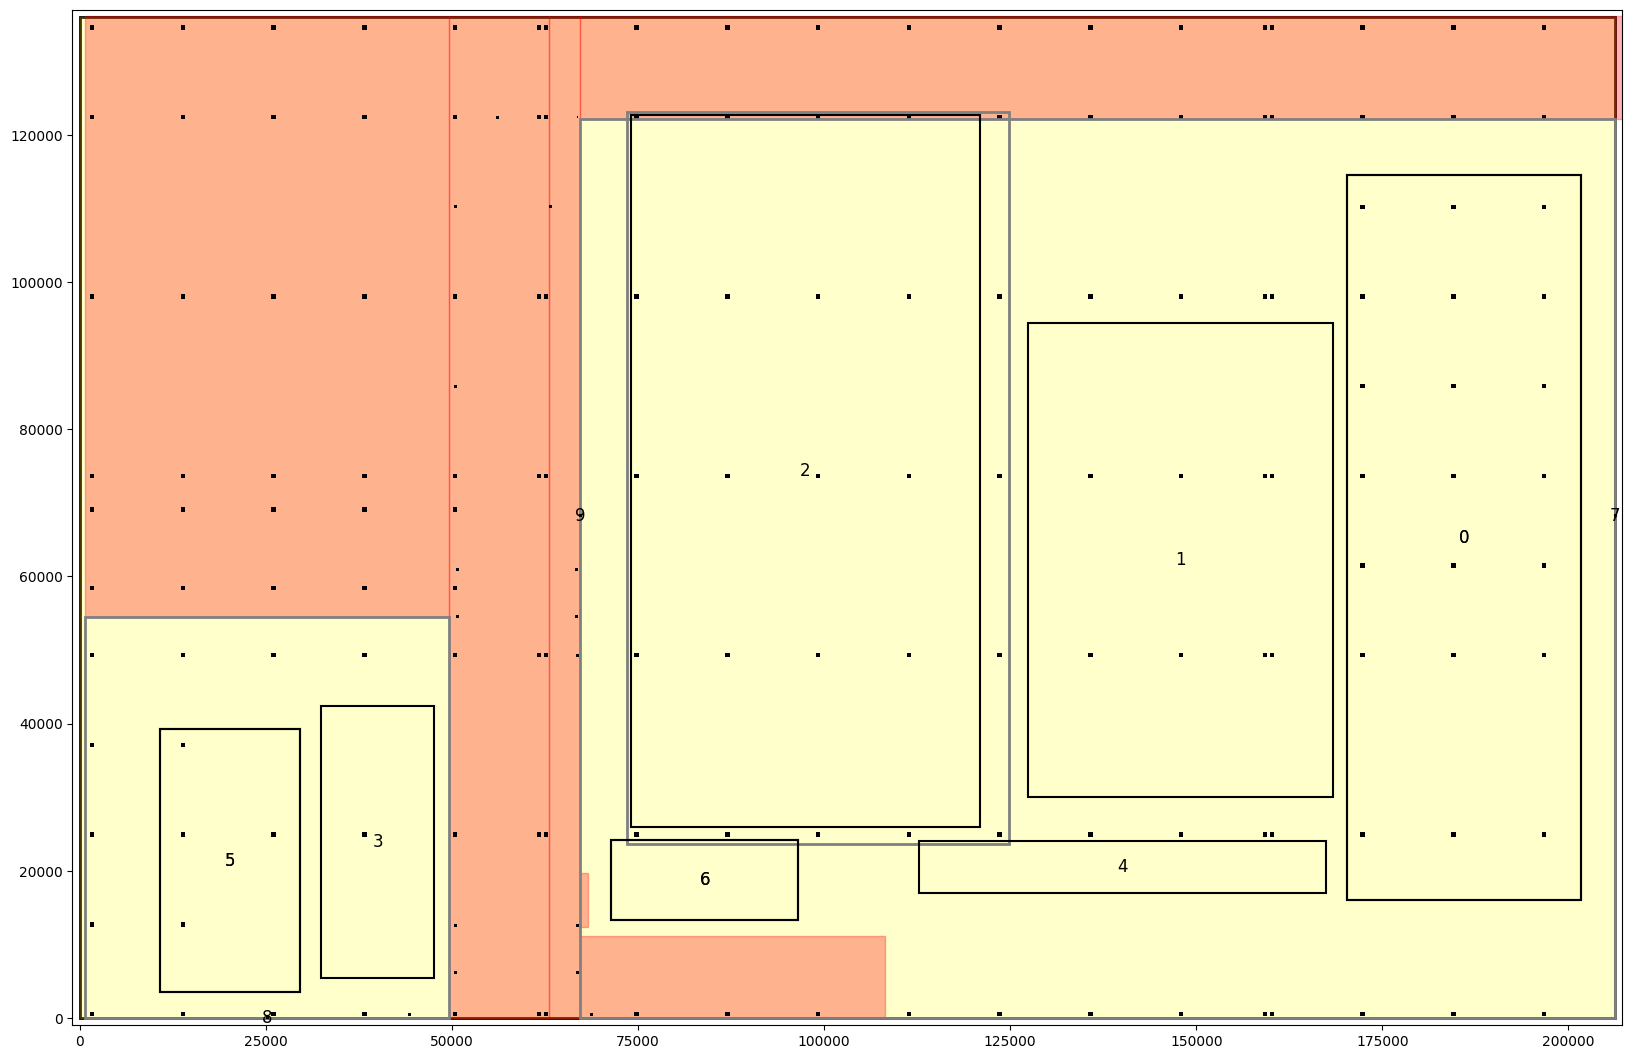

In [ ]:
plt_lay_cluster()

In [ ]:
# k={}
# for c in df_selected.index:
#     if df_selected.iloc[c]["x"]<=df_selected.iloc[c]["y"]:
#         k[c]=0
#     else:
#         k[c]=1

In [ ]:
# df_pre = df_selected.loc[df_selected.index.isin(pre_C)].copy()
# rows = []

# for g in df_pre.index:
#     group = df_selected.loc[g,'설비Group']
#     for f in range(df_selected.loc[g,'설비수량']):
 
#         x_f=df_selected.loc[g,'x'] 
#         y_f=df_selected.loc[g,'y']
#         row = {
#             "설비Group": group,
#             "설비번호": f,
#             "center_X": 0,
#             "center_Y": 0,
#             "x": x_f,
#             "y": y_f,
#             "type": df_selected.loc[g,'type'],
#             "회전":0,
#             "k":0
#         }
#         rows.append(row)


# df_pre = pd.DataFrame(rows)       


In [ ]:
# for c in df_pre.index:
#     for da in data['fixedFacilityPositions']:
#         if f"{df_pre.loc[c,'설비Group']}_{df_pre.loc[c,'설비번호']}" == da['facilityId']:
#             if da['rotation']==0:
#                 df_pre.loc[c,'회전']=0
#                 df_pre.loc[c,'k']=0
#             elif da['rotation']==270:
#                 df_pre.loc[c,'회전']=1
#                 df_pre.loc[c,'k']=0
#             elif da['rotation']==180:
#                 df_pre.loc[c,'회전']=0
#                 df_pre.loc[c,'k']=1
#             else:
#                 df_pre.loc[c,'회전']=1
#                 df_pre.loc[c,'k']=1
                
#             if df_pre.loc[c,'회전']==0:
#                 df_pre.loc[c,'center_X']=float(da['position']['x'])+df_pre.loc[c,'x']/2
#                 df_pre.loc[c,'center_Y']=float(da['position']['y'])+df_pre.loc[c,'y']/2
#             else:
#                 df_pre.loc[c,'center_X']=float(da['position']['x'])+df_pre.loc[c,'y']/2
#                 df_pre.loc[c,'center_Y']=float(da['position']['y'])+df_pre.loc[c,'x']/2

In [ ]:
df_selected_copy_2=df_selected.copy()

In [ ]:
k_cluster

{0: {'y': np.int64(19), 'x': 1},
 1: {'x': 5, 'y': 11},
 2: {'y': np.int64(4), 'x': 1},
 3: {'y': np.int64(3), 'x': 1},
 4: {'x': np.int64(15), 'y': 1},
 5: {'x': 9, 'y': 5},
 6: {'x': 10, 'y': 7},
 7: {'x': np.int64(1), 'y': 1},
 8: {'x': np.int64(1), 'y': 1},
 9: {'x': np.int64(1), 'y': 1}}

In [ ]:
# rows = []

# for g in df_selected.index:
#     group = df_selected.loc[g,'설비Group']
#     for f in range(df_selected.loc[g,'설비수량']):
#         if k[g]==0:
#             if o[g]==0:        
#                 X_fa=X[g]-df_selected.loc[g]['Cluster_X']/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+df_selected.loc[g]['UL'])*f
#                 Y_fa=Y[g]
#             else:
#                 Y_fa=Y[g]-df_selected.loc[g]['Cluster_X']/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+df_selected.loc[g]['UL'])*f
#                 X_fa=X[g]
#         else:
#             if o[g]==0:
#                 X_fa=X[g]
#                 Y_fa=Y[g]-df_selected.loc[g]['Cluster_Y']/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+df_selected.loc[g]['UB'])*f
#             else:
#                 Y_fa=Y[g]
#                 X_fa=X[g]-df_selected.loc[g]['Cluster_Y']/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+df_selected.loc[g]['UB'])*f 
#         x_f=df_selected.loc[g,'x'] 
#         y_f=df_selected.loc[g,'y']
#         row = {
#             "설비Group": group,
#             "설비번호": f,
#             "center_X": X_fa,
#             "center_Y": Y_fa,
#             "x": x_f,
#             "y": y_f,
#             "type": df_selected.loc[g,'type'],
#             "회전":o[g],
#             "k":k[g]
#         }
#         rows.append(row)


# df_result = pd.DataFrame(rows)       


In [ ]:
mirror_Cluster=[]
for c in df_selected.index:
    if (df_selected.loc[c,'type']=='production')and (total_expand[c][2]+total_expand[c][3]==1):
        mirror_Cluster.append(c)

In [ ]:
def make_df_result(totalSol,k,mirror_Cluster,df_pre):
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalSol)
    for i, j in k_cluster.items():
        for ii, jj in j.items():
            j[ii] = int(jj)    
    rows = []
    for g in df_selected.index:
        group = df_selected.loc[g,'설비Group']
        if len(df_pre[(df_pre['설비Group']==group)])!=0:
            continue
        if df_selected.loc[g,'type']=='storage':
            row = {
                "설비Group": group,
                "설비번호": 0,
                "center_X": X[g],
                "center_Y": Y[g],
                "x": W0[g],
                "y": H0[g],
                "UR": df_selected.loc[g,'UR'],
                "UL": df_selected.loc[g,'UL'],
                "UB": df_selected.loc[g,'UB'],
                "UA": df_selected.loc[g,'UA'],
                "type": df_selected.loc[g,'type'],
                "회전":o[g],
                "k":k[g],
                "대칭":di_fa,
                "dry": df_selected.loc[g,'dry'],
                "weight": df_selected.loc[g,'facilityWeight'],
                "facilityHeight": df_selected.loc[g,'facilityHeight'],
                "placeable": df_selected.loc[g,'placeable']
            }
            rows.append(row)
            continue
        for h in range(k_cluster[g]['y']):
            for f in range(k_cluster[g]['x']):
                if o[g]==0:
                    if g in mirror_Cluster:
                        if k[g]==0:
                            if di[g]==0:
                                X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+max(df_selected.loc[g]['UR'],df_selected.loc[g]['UL']))*f
                                if h%2==0:
                                    di_fa=0
                                    Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*h/2+df_selected.loc[g]['UA']*h/2
                                else:
                                    Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*math.floor(h/2)+df_selected.loc[g]['UA']*math.ceil(h/2)

                                    di_fa=1
                            else:
                                X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+max(df_selected.loc[g]['UR'],df_selected.loc[g]['UL']))*f
                                if h%2==0:
                                    di_fa=1
                                    Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*h/2+df_selected.loc[g]['UA']*h/2
                                else:
                                    Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*math.ceil(h/2)+df_selected.loc[g]['UA']*math.floor(h/2)
                                    di_fa=0
                        else:
                            if di[g]==0:
                                Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                                if h%2==0:
                                    di_fa=0
                                    X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*f+df_selected.loc[g]['UR']*f/2+df_selected.loc[g]['UL']*f/2
                                else:
                                    X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*f+df_selected.loc[g]['UL']*math.floor(f/2)+df_selected.loc[g]['UR']*math.ceil(f/2)
                                    di_fa=1
                            else:
                                Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                                if h%2==0:
                                    di_fa=1
                                    X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*f+df_selected.loc[g]['UR']*f/2+df_selected.loc[g]['UL']*f/2
                                else:
                                    X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*f+df_selected.loc[g]['UR']*math.floor(h/2)+df_selected.loc[g]['UL']*math.ceil(f/2)
                                    di_fa=0                          
                    else:
                        X_fa=X[g]-W0[g]/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+max(df_selected.loc[g]['UR'],df_selected.loc[g]['UL']))*f
                        Y_fa=Y[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                        di_fa=di[g]
                else:
                    if g in mirror_Cluster:
                        if k[g]==0:
                            if di[g]==0:
                                Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*f+df_selected.loc[g]['UR']*f/2+df_selected.loc[g]['UL']*f/2
                                if h%2==0:
                                    di_fa=1
                                    X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*h/2+df_selected.loc[g]['UA']*h/2
                                else:
                                    X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*math.floor(h/2)+df_selected.loc[g]['UA']*math.ceil(h/2)
                                    di_fa=0
                            else:
                                Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*h+df_selected.loc[g]['UR']*f/2+df_selected.loc[g]['UL']*f/2
                                if h%2==0:
                                    di_fa=0
                                    X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*h/2+df_selected.loc[g]['UA']*h/2
                                else:
                                    X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+df_selected.loc[g]['y']*h+df_selected.loc[g]['UB']*math.ceil(h/2)+df_selected.loc[g]['UA']*math.floor(h/2)
                                    di_fa=1
                        else:
                             if di[g]==0:
                                X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                                if h%2==0:
                                    di_fa=1
                                    Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*h+df_selected.loc[g]['UR']*h/2+df_selected.loc[g]['UL']*h/2
                                else:
                                    Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*h+df_selected.loc[g]['UL']*math.floor(h/2)+df_selected.loc[g]['UR']*math.ceil(h/2)
                                    di_fa=0
                             else:
                                X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                                if h%2==0:
                                    di_fa=0
                                    Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*h+df_selected.loc[g]['UR']*h/2+df_selected.loc[g]['UL']*h/2
                                else:
                                    Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+df_selected.loc[g]['x']*h+df_selected.loc[g]['UR']*math.floor(h/2)+df_selected.loc[g]['UL']*math.ceil(h/2)

                                    di_fa=1
                    else:
                        X_fa=X[g]-H0[g]/2+df_selected.loc[g]['y']/2+(df_selected.loc[g]['y']+max(df_selected.loc[g]['UB'],df_selected.loc[g]['UA']))*h
                        Y_fa=Y[g]-W0[g]/2+df_selected.loc[g]['x']/2+(df_selected.loc[g]['x']+max(df_selected.loc[g]['UR'],df_selected.loc[g]['UL']))*f
                        di_fa=di[g]
                x_f=df_selected.loc[g,'x'] 
                y_f=df_selected.loc[g,'y']
                if df_selected.loc[g,'x']<=df_selected.loc[g,'y']:
                    facilityNum=int(h*k_cluster[g]['x']+f)
                else:
                    facilityNum=int(f*k_cluster[g]['y']+h)
                row = {
                    "설비Group": group,
                    "설비번호": facilityNum,
                    "center_X": X_fa,
                    "center_Y": Y_fa,
                    "x": x_f,
                    "y": y_f,
                    "UR": df_selected.loc[g,'UR'],
                    "UL": df_selected.loc[g,'UL'],
                    "UB": df_selected.loc[g,'UB'],
                    "UA": df_selected.loc[g,'UA'],
                    "type": df_selected.loc[g,'type'],
                    "회전":o[g],
                    "k":k[g],
                    "대칭":di_fa,
                    "dry": df_selected.loc[g,'dry'],
                    "weight": df_selected.loc[g,'facilityWeight'],
                    "facilityHeight": df_selected.loc[g,'facilityHeight'],
                    "placeable": df_selected.loc[g,'placeable']
                }
                rows.append(row)
    df_result = pd.DataFrame(rows)       
    df_result = pd.concat([df_result, df_pre], axis=0, ignore_index=True)
    return df_result

# 설비단위조정다시

In [ ]:
def adjustFacilityAvoidColumn(df_result,c):
    x_ck=df_result.loc[c,'center_X']
    y_ck=df_result.loc[c,'center_Y']

    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.loc[c,'x'],df_result.loc[c,'y']]
    else:
        ro_ck=[df_result.loc[c,'y'],df_result.loc[c,'x']]
    for r in range(len(column_areas)):
        clear=0
        feasible=False
        red_feasible=0
        x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
        y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

        if x_ck+ro_ck[0]/2<min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2>max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2<min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2>max(y_uni):
            feasible=True
        if feasible==False:
            return feasible
    return feasible

In [ ]:
def directionFacility(df_result):
    dims = {}
    cl_ck={}
    

    for c in df_result.index:
        if df_result.loc[c,'회전'] == 1:
            dims[c] = (df_result.loc[c,'y'], df_result.loc[c,'x'])  # rotated
        else:
            dims[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])   # original

        if df_result.loc[c,'회전'] == 0 and df_result.loc[c,'대칭']==0:
            cl_ck[c] = (df_result.loc[c,'UR'], df_result.loc[c,'UB'],df_result.loc[c,'UL'],df_result.loc[c,'UA'])  # rotated
        elif df_result.loc[c,'회전'] == 1 and df_result.loc[c,'대칭']==1:
            cl_ck[c] = ( df_result.loc[c,'UB'],df_result.loc[c,'UL'],df_result.loc[c,'UA'],df_result.loc[c,'UR'])  # rotated
        elif df_result.loc[c,'회전'] == 0 and df_result.loc[c,'대칭']==1:
            cl_ck[c] = ( df_result.loc[c,'UL'],df_result.loc[c,'UA'],df_result.loc[c,'UR'],df_result.loc[c,'UB'])  # rotated
        else:
            cl_ck[c] = ( df_result.loc[c,'UA'],df_result.loc[c,'UR'],df_result.loc[c,'UB'],df_result.loc[c,'UL'])  # rotated
    return dims,cl_ck


In [ ]:
def is_feasibleFacility(df_result,c):


    x_ck=df_result.loc[c,'center_X']
    y_ck=df_result.loc[c,'center_Y']
    ro_ck,cl_ck=directionFacility(df_result)
    


            
    feasible=True


    if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>Xupper:
        feasible=False
        return feasible,None            

    if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<Xunder:
        feasible=False
        return feasible,None           


    if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>Yupper:
        feasible=False
        return feasible,None            


    if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<Yunder:
        feasible=False

        return feasible,None
    
    #red_zon feasibility 검사
    for r in range(len(restricted_areas)):
        feasible=False
        
        x_uni=(restricted_areas[r]["x"],restricted_areas[r]["x"]+restricted_areas[r]["width"])
        y_uni=(restricted_areas[r]["y"],restricted_areas[r]["y"]+restricted_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
        
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            
            return feasible,None
        
    for r in range(len(column_areas)):
        feasible=False
        
        x_uni=(column_areas[r]["x"],column_areas[r]["x"]+column_areas[r]["width"])
        y_uni=(column_areas[r]["y"],column_areas[r]["y"]+column_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2<min(x_uni):
        
            feasible=True

        if x_ck-ro_ck[c][0]/2>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2>max(y_uni):
            feasible=True


        if feasible==False:
            
            return feasible,None
        
    for r in range(len(mezz_areas)):
        

        if df_result.loc[c,'facilityHeight']<=mezz_areas[r]['ceilingHeight']:
            continue

        feasible=False
        
        x_uni=(mezz_areas[r]["x"],mezz_areas[r]["x"]+mezz_areas[r]["width"])
        y_uni=(mezz_areas[r]["y"],mezz_areas[r]["y"]+mezz_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            return feasible,None
    place_areas_cluster=[item for item in place_areas if item['id'] == df_result.loc[c,'placeable']]
    
    for r in range(len(place_areas_cluster)):
        if r==0:
            feasible=True
        else:
            if feasible==True:
                break
            else:
                feasible=True
            
        x_uni=(place_areas_cluster[r]["x"],place_areas_cluster[r]["x"]+place_areas_cluster[r]["width"])
        y_uni=(place_areas_cluster[r]["y"],place_areas_cluster[r]["y"]+place_areas_cluster[r]["height"])


            
        if x_ck+ro_ck[c][0]/2>max(x_uni):
            feasible=False
            

        if x_ck-ro_ck[c][0]/2<min(x_uni):
            feasible=False
            


        if y_ck+ro_ck[c][1]/2>max(y_uni):
            feasible=False
            


        if y_ck-ro_ck[c][1]/2<min(y_uni):
            feasible=False            


    if feasible==False:
        return feasible,None
     
    for r in range(len(weight_areas)):
        
        if df_result.loc[c,'weight']<=data['factoryDimensions']['weight']:
            continue
            
        feasible=True
        
        x_uni=(weight_areas[r]["x"],weight_areas[r]["x"]+weight_areas[r]["width"])
        y_uni=(weight_areas[r]["y"],weight_areas[r]["y"]+weight_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            return feasible,None            

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            return feasible,None           


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            return feasible,None            


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False

            return feasible,None
            
    
    #dry 설비 dry존 내에 배치
    for r in range(len(dry_areas)):
        
        if df_result.loc[c,'dry']>dry_areas[r]['value']:
            
            continue
            
        feasible=True
        
        x_uni=(dry_areas[r]["x"],dry_areas[r]["x"]+dry_areas[r]["width"])
        y_uni=(dry_areas[r]["y"],dry_areas[r]["y"]+dry_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]>max(x_uni):
            feasible=False
            
            return feasible,None            

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]<min(x_uni):
            feasible=False
            
            return feasible,None          


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]>max(y_uni):
            feasible=False
            
            return feasible,None             


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]<min(y_uni):
            feasible=False
            return feasible,None
        
    #dry 설비가 아닌 경우 dry존 밖에 배치
    for r in range(len(dry_areas)):
        
        if df_result.loc[c,'dry']<=dry_areas[r]['value']:
            
            continue
            
        feasible=False
        
        x_uni=(dry_areas[r]["x"],dry_areas[r]["x"]+dry_areas[r]["width"])
        y_uni=(dry_areas[r]["y"],dry_areas[r]["y"]+dry_areas[r]["height"])

        if x_ck+ro_ck[c][0]/2+cl_ck[c][0]<min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-cl_ck[c][2]>max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+cl_ck[c][3]<min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-cl_ck[c][1]>max(y_uni):
            feasible=True


        if feasible==False:
            
            return feasible,None     
        
    for d in df_result.index:
        if d==c:
            continue
            
        x_uni=[df_result.loc[d,'center_X']-ro_ck[d][0]/2,df_result.loc[d,'center_X']+ro_ck[d][0]/2]
        y_uni=[df_result.loc[d,'center_Y']-ro_ck[d][1]/2,df_result.loc[d,'center_Y']+ro_ck[d][1]/2]
        feasible=False

        if x_ck+ro_ck[c][0]/2+max(cl_ck[c][0],cl_ck[d][2])<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[c][0]/2-max(cl_ck[c][2],cl_ck[d][0])>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[c][1]/2+max(cl_ck[c][3],cl_ck[d][1])<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[c][1]/2-max(cl_ck[c][1],cl_ck[d][3])>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible,d
        
        
        
    return feasible,None

In [ ]:
def adjustFacility(df_result,c,adjustDirection,k_cluster):
    
    group=df_selected.loc[c,'설비Group']
    STEPSIZE=100
    adjustSize=0

    adjustFacilityNum=list(df_result[df_result['설비Group']==group].index)
    if adjustDirection==-1:
        adjustFacilityNum.reverse()

    for d in adjustFacilityNum:
        if df_result.at[d,'x']<df_result.at[d,'y']:
            if df_result.at[d,'회전']==0:
                if adjustDirection==1:
                    if df_result.at[d,'설비번호']%k_cluster[c]['x']==0:
                        adjustSize=0
                else:
                    if df_result.at[d,'설비번호']%k_cluster[c]['x']==k_cluster[c]['x']-1:
                        adjustSize=0                    
                df_result.at[d,'center_X']+=adjustSize
            else:
                if adjustDirection==1:
                    if df_result.at[d,'설비번호']%k_cluster[c]['y']==0:
                        adjustSize=0
                else:
                    if df_result.at[d,'설비번호']%k_cluster[c]['y']==k_cluster[c]['y']-1:
                        adjustSize=0      
                df_result.at[d,'center_Y']+=adjustSize
        else:
            if df_result.at[d,'회전']==0:
                if adjustDirection==1:
                    if df_result.at[d,'설비번호']%k_cluster[c]['y']==0:
                        adjustSize=0
                else:
                    if df_result.at[d,'설비번호']%k_cluster[c]['y']==k_cluster[c]['y']-1:
                        adjustSize=0      
                df_result.at[d,'center_Y']+=adjustSize
            else:
                if adjustDirection==1:
                    if df_result.at[d,'설비번호']%k_cluster[c]['x']==0:
                        adjustSize=0
                else:
                    if df_result.at[d,'설비번호']%k_cluster[c]['x']==k_cluster[c]['x']-1:
                        adjustSize=0            
                df_result.at[d,'center_X']+=adjustSize
                
        for i in range(500):

            fe=adjustFacilityAvoidColumn(df_result,d)
            if fe==True:
                break
            else:
                adjustSize+=STEPSIZE*adjustDirection
                if df_result.at[d,'x']<df_result.at[d,'y']:
                    if df_result.at[d,'회전']==0:
                        df_result.at[d,'center_X']+=STEPSIZE*adjustDirection
                    else:
                        df_result.at[d,'center_Y']+=STEPSIZE*adjustDirection
                else:
                    if df_result.at[d,'회전']==0:
                        df_result.at[d,'center_Y']+=STEPSIZE*adjustDirection
                    else:
                        df_result.at[d,'center_X']+=STEPSIZE*adjustDirection
    return df_result

In [ ]:

def determineDirectionFacility(df_selected,df_result,k_cluster):
    for c in df_selected.index:
        if df_selected.loc[c,'type']=='storage':
            continue
        if c in pre_C:
            continue
        group=df_selected.loc[c,'설비Group']
        for _ in range(2):
            if _ ==0:
                adjustDirection=1
            else:
                adjustDirection=-1

            df_result=adjustFacility(df_result,c,adjustDirection,k_cluster)
            for d in df_result[df_result['설비Group']==group].index:

                fe,pr_c=is_feasibleFacility(df_result,d)
                if fe==False:
                    break
            if fe==True:
                df_result=copy.deepcopy(df_result)
                break
    return df_result

def delOverFacility(df_selected,df_result):
    ADJUSTSIZE=100
    ro_ck,cl_ck=directionFacility(df_result)
    cannotAdjustFacility=[]
    for c in df_selected.index:
        if c in pre_C:
            continue
        if df_selected.loc[c,'type']=='storage':
            continue
        group=df_selected.loc[c,'설비Group']
        overFacilityNum=len(df_result[df_result['설비Group']==group])-df_selected.loc[c,'설비수량']
        repositionFacility=[]
        for d in df_result[df_result['설비Group']==group].index:
            fe,pr_c=is_feasibleFacility(df_result,d)
            if fe==False:
                if overFacilityNum==0:
                    sameGroupFacility=df_result[df_result['설비Group']==group].index
                    for e in sameGroupFacility:
                        df_result.loc[d,'회전']=df_result.loc[e,'회전']
                        df_result.loc[d,'대칭']=df_result.loc[e,'대칭']
                        if df_result.loc[d,'x']<=df_result.loc[d,'y']:
                            df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']
                            df_result.loc[d,'center_X']= df_result.loc[e,'center_X']-ro_ck[e][0]-max(cl_ck[e][0],cl_ck[e][2])
                            for _ in range(50):
                                fe,pr_c=is_feasibleFacility(df_result,d)
                                if fe==True:
                                    break
                                df_result.at[d,'center_X']-=ADJUSTSIZE
                            if fe==True:
                                break
                            
                            df_result.loc[d,'center_X']= df_result.loc[e,'center_X']+ro_ck[e][0]+max(cl_ck[e][0],cl_ck[e][2])
                            for _ in range(50):
                                fe,pr_c=is_feasibleFacility(df_result,d)
                                if fe==True:
                                    break
                                df_result.at[d,'center_X']+=ADJUSTSIZE
                            if fe==True:
                                break
                        else:
                            df_result.loc[d,'center_X']= df_result.loc[e,'center_X']
                            df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']-ro_ck[e][1]-max(cl_ck[e][1],cl_ck[e][2])

                            for _ in range(50):
                                fe,pr_c=is_feasibleFacility(df_result,d)
                                if fe==True:
                                    break
                                df_result.at[d,'center_Y']-=ADJUSTSIZE
                            if fe==True:
                                break
                            df_result.loc[d,'center_X']= df_result.loc[e,'center_X']
                            df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']+ro_ck[e][1]+max(cl_ck[e][1],cl_ck[e][2])
                            for _ in range(50):
                                fe,pr_c=is_feasibleFacility(df_result,d)
                                if fe==True:
                                    break
                                df_result.at[d,'center_Y']+=ADJUSTSIZE
                            if fe==True:
                                break
                    if fe==False:
                        for e in sameGroupFacility:
                            if df_result.loc[d,'x']>=df_result.loc[d,'y']:
                                df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']
                                df_result.loc[d,'center_X']= df_result.loc[e,'center_X']-ro_ck[e][0]-max(cl_ck[e][0],cl_ck[e][2])
                                for _ in range(50):
                                    fe,pr_c=is_feasibleFacility(df_result,d)
                                    if fe==True:
                                        break
                                    df_result.at[d,'center_X']-=ADJUSTSIZE
                                if fe==True:
                                    break
                                df_result.loc[d,'center_X']= df_result.loc[e,'center_X']+ro_ck[e][0]+max(cl_ck[e][0],cl_ck[e][2])
                                for _ in range(50):
                                    fe,pr_c=is_feasibleFacility(df_result,d)
                                    if fe==True:
                                        break
                                    df_result.at[d,'center_X']+=ADJUSTSIZE
                                if fe==True:
                                    break
                            else:
                                df_result.loc[d,'center_X']= df_result.loc[e,'center_X']
                                df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']-ro_ck[e][1]-max(cl_ck[e][1],cl_ck[e][2])
                                for _ in range(50):
                                    fe,pr_c=is_feasibleFacility(df_result,d)
                                    if fe==True:
                                        break
                                    df_result.at[d,'center_Y']-=ADJUSTSIZE
                                if fe==True:
                                    break
                                df_result.loc[d,'center_X']= df_result.loc[e,'center_X']
                                df_result.loc[d,'center_Y']= df_result.loc[e,'center_Y']+ro_ck[e][1]+max(cl_ck[e][1],cl_ck[e][2])
                                for _ in range(50):
                                    fe,pr_c=is_feasibleFacility(df_result,d)
                                    if fe==True:
                                        break
                                    df_result.at[d,'center_Y']+=ADJUSTSIZE
                                if fe==True:
                                    break
                    if fe==False:
                        cannotAdjustFacility.append(d)
                else:
                    df_result = df_result.drop(index=d)
                    overFacilityNum-=1
    return df_result,cannotAdjustFacility

In [ ]:
k

{0: 1, 1: 0, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

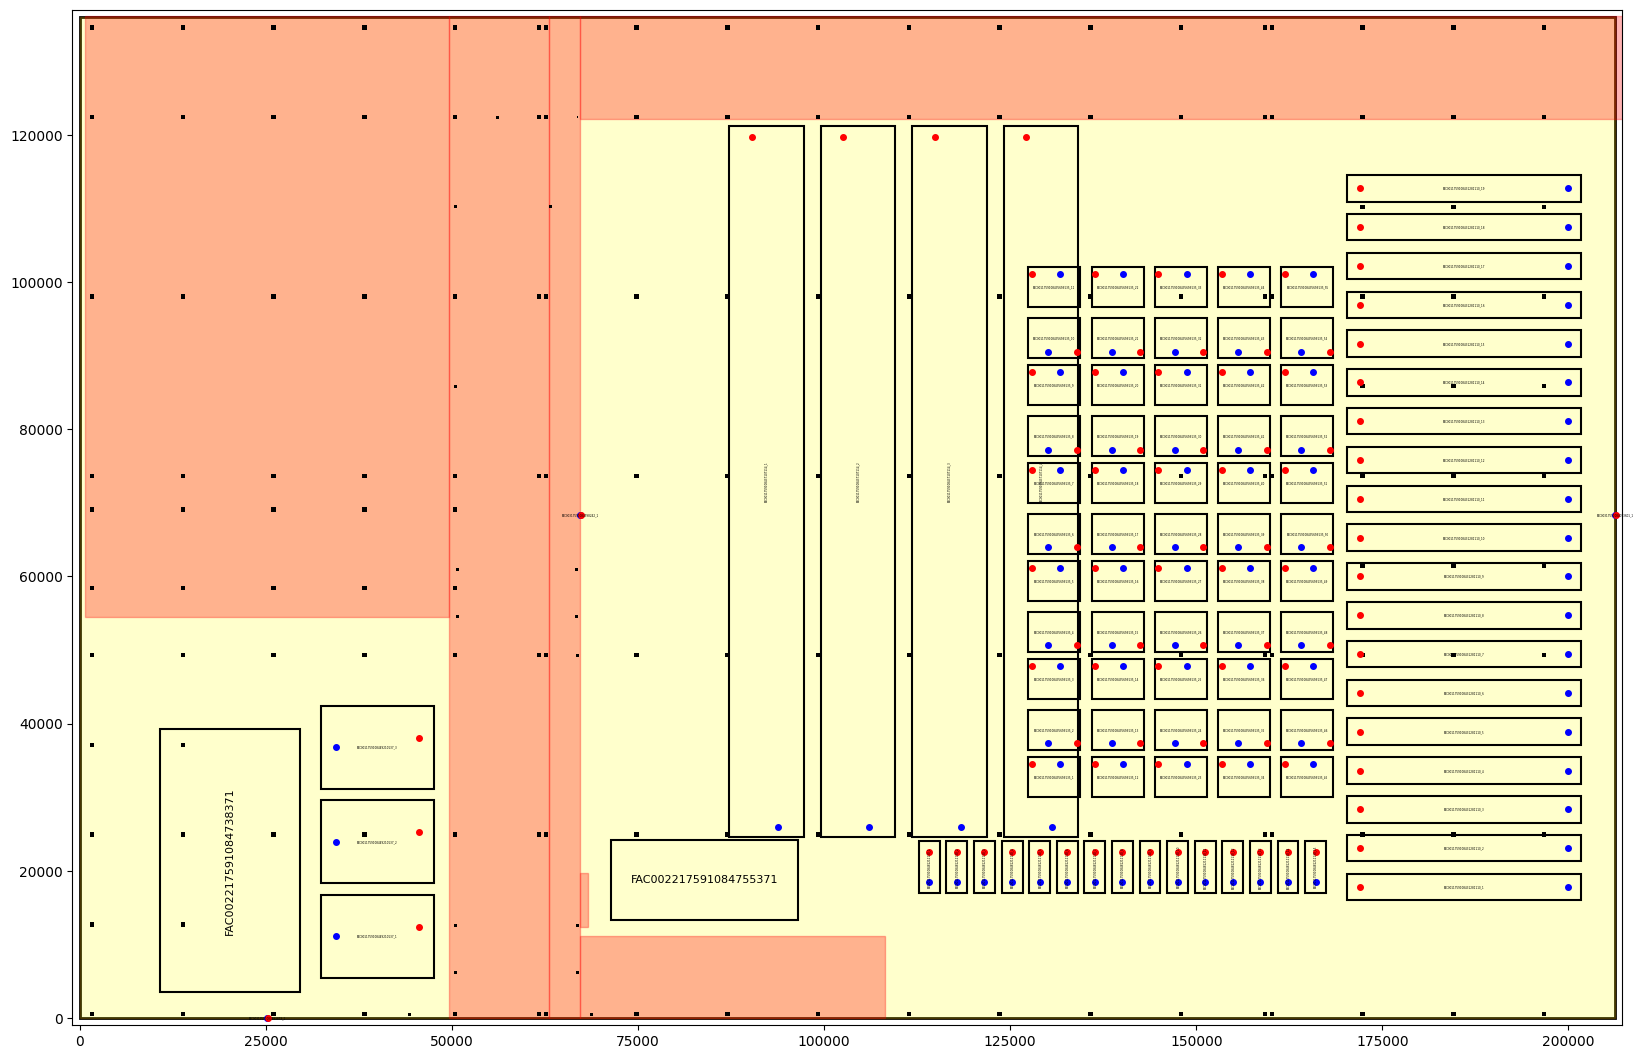

In [ ]:
for k_2 in totalTotalSolBest.keys():
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalTotalSolBest[k_2]) 
    df_result=make_df_result(totalTotalSolBest[k_2],k,mirror_Cluster,df_pre)

    plt_f_2()

[76]


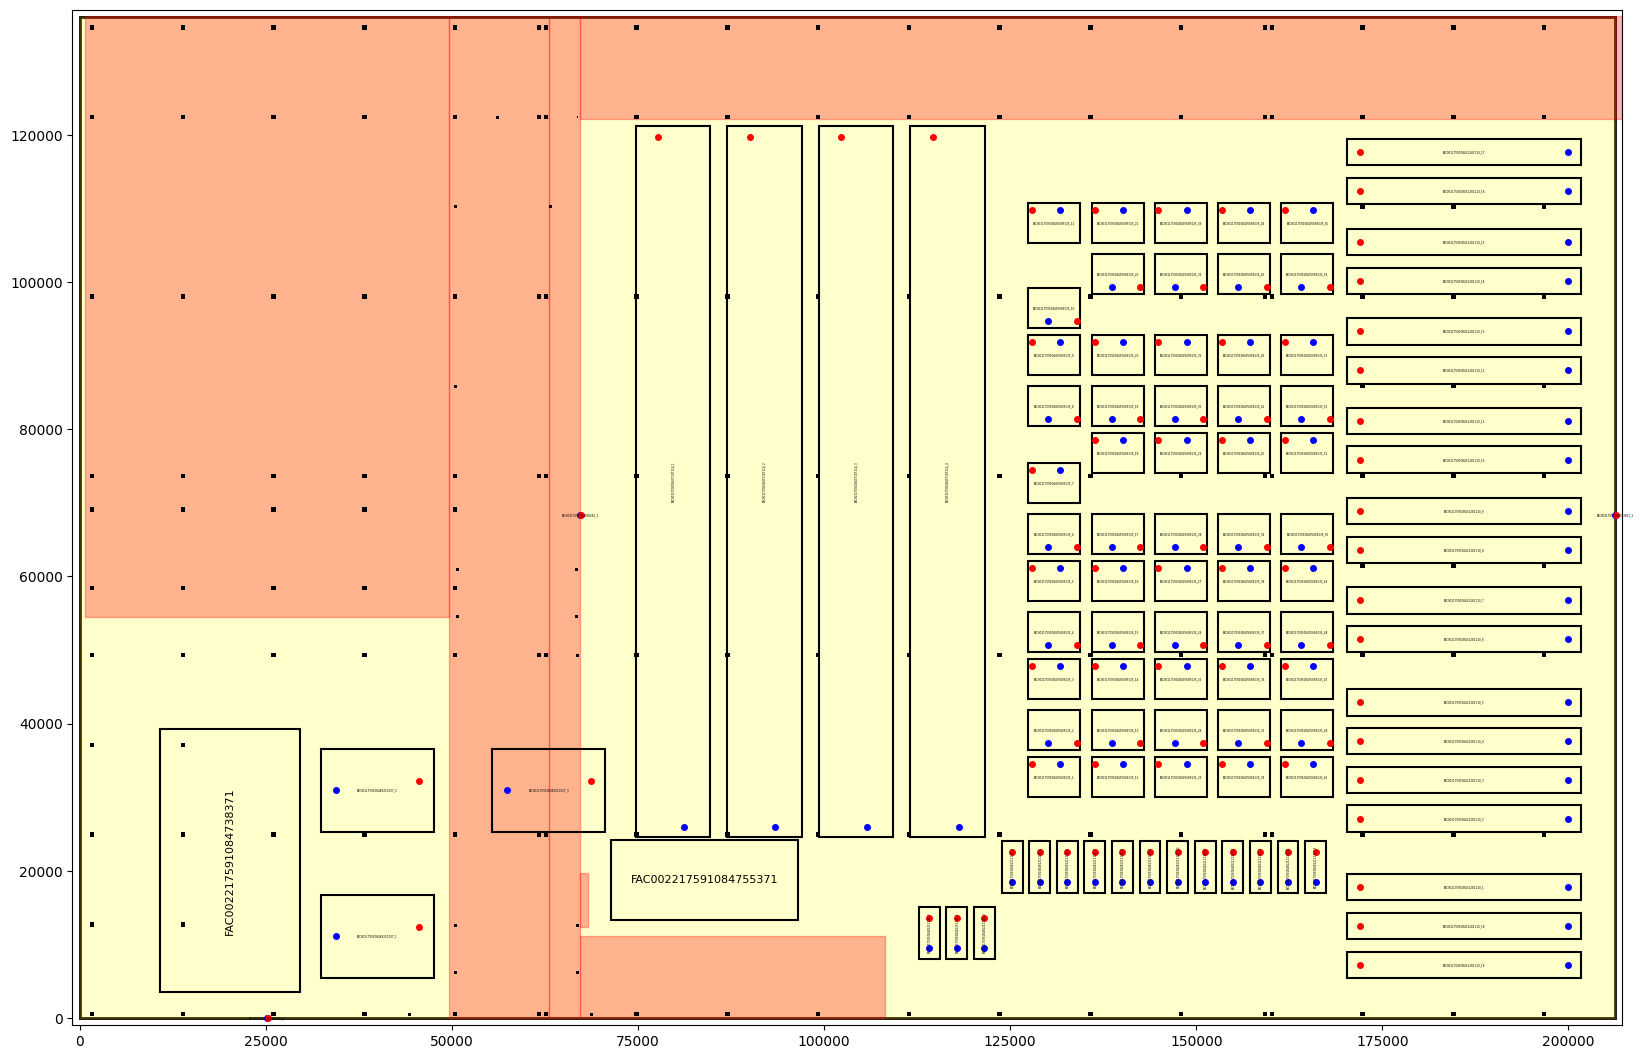

In [ ]:
for k_2 in totalTotalSolBest.keys():
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalTotalSolBest[k_2]) 
    df_result=make_df_result(totalTotalSolBest[k_2],k,mirror_Cluster,df_pre)

    for c in df_result[df_result['설비Group']=='FAC0011759108437107114'].index:
        df_result.at[c,'center_X']-=12600
    df_result=determineDirectionFacility(df_selected,df_result,k_cluster)

    df_result,cannotAdjustFacility=delOverFacility(df_selected,df_result)

    print(cannotAdjustFacility)
    plt_f_2()
    plt.savefig(f"layout_{k_2}.png", dpi=300, bbox_inches='tight')
    plt.close()

[76]


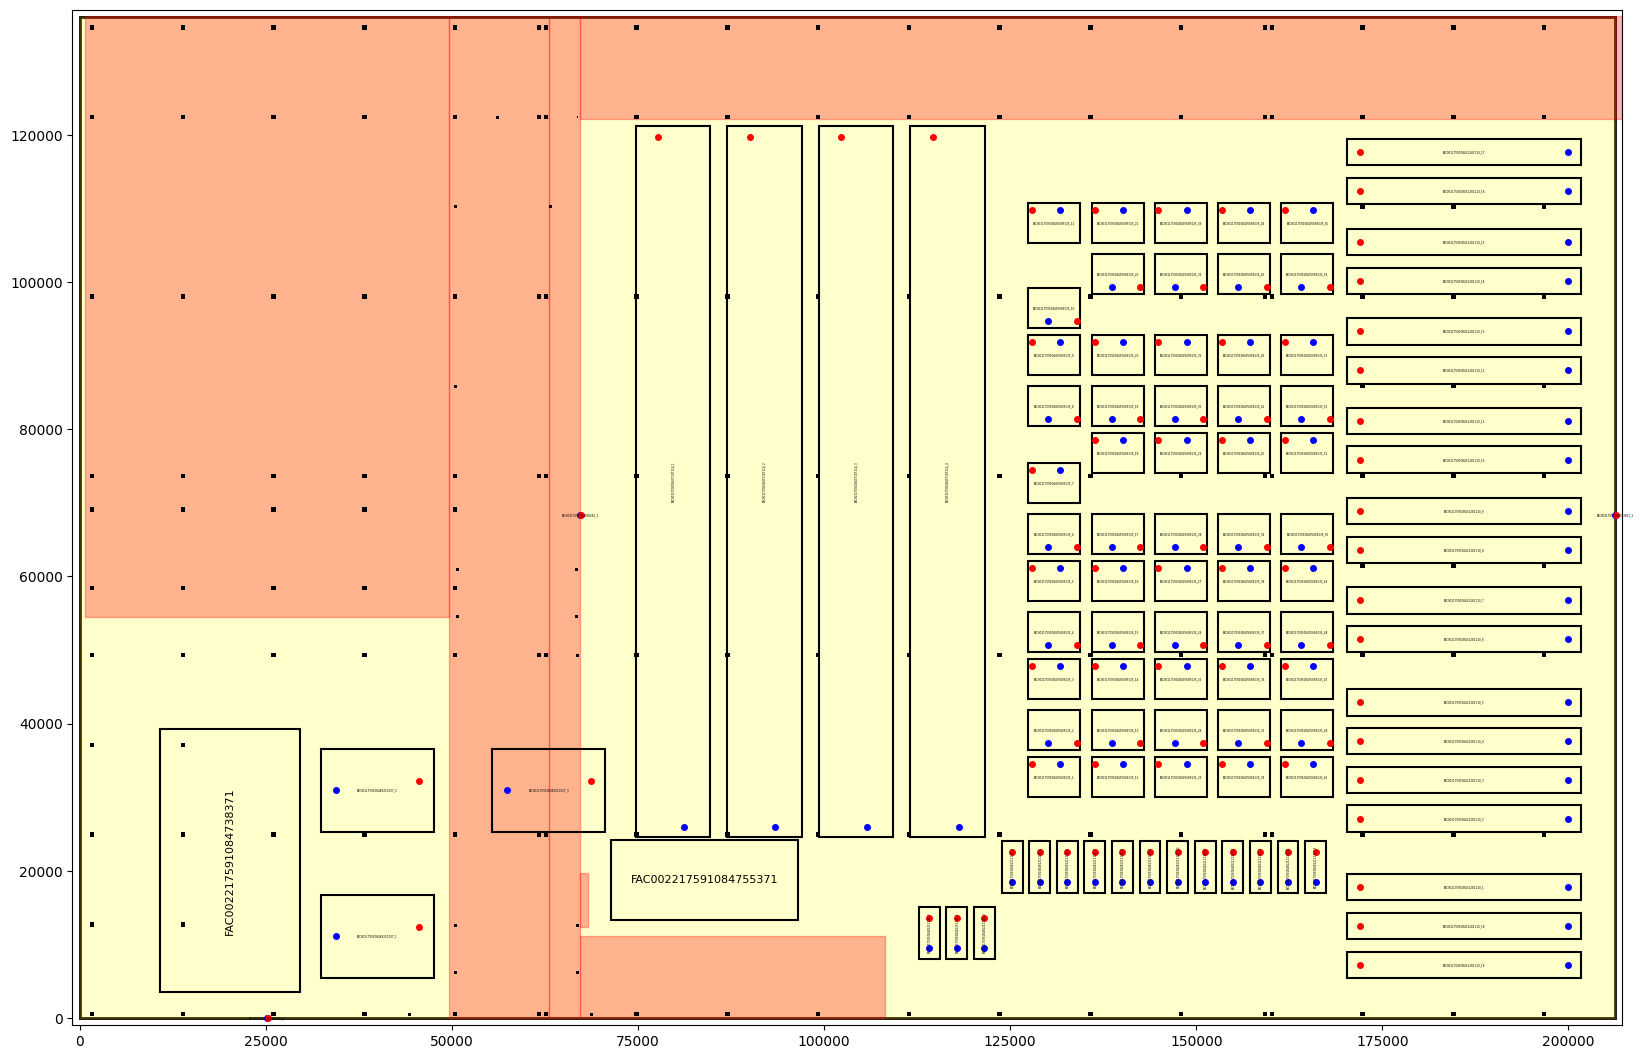

In [ ]:
for k_2 in totalTotalSolBest.keys():
    X,Y,o,di,s_x_t,s_y_t,sfc_to,sfc_from,k_cluster,W0,H0,df_selected,lay_clusters=sol_decomposition(totalTotalSolBest[k_2]) 
    df_result=make_df_result(totalTotalSolBest[k_2],k,mirror_Cluster,df_pre)

    for c in df_result[df_result['설비Group']=='FAC0011759108437107114'].index:
        df_result.at[c,'center_X']-=12600
    df_result=determineDirectionFacility(df_selected,df_result,k_cluster)

    df_result,cannotAdjustFacility=delOverFacility(df_selected,df_result)

    print(cannotAdjustFacility)
    plt_f_2()

In [ ]:
total_expand

{0: [1, 1, 0, 0],
 1: [0, 0, 0, 1],
 2: [1, 1, 0, 0],
 3: [1, 1, 0, 0],
 4: [0, 0, 1, 1]}

In [ ]:
for c in df_result.index:
    fe,pr_c=is_feasibleFacility(df_result,c)
    if fe==False:
        print("c: ",c," ,pr_c: ",pr_c)

c:  76  ,pr_c:  None
c:  92  ,pr_c:  None
c:  94  ,pr_c:  None
c:  95  ,pr_c:  None
c:  96  ,pr_c:  None
c:  97  ,pr_c:  None
c:  98  ,pr_c:  None
c:  99  ,pr_c:  None
c:  100  ,pr_c:  None


# 설비단위 조정

In [ ]:
def L_ad():

    #겹치는 L 설비 조정
    #df_sorted = df_result.sort_values(by='center_X', ascending=False)
    df_sorted = df_result

    x_move={}
    y_move={}
    re_try=[]
    del_cluster=[]
    for c in df_sorted.index:
        #나중에 지워
        if df_sorted.iloc[c]['type']=='storage':
            continue
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        if d in pre_C:
            continue        
        if df_result.iloc[c]['회전']==0:
            ro_x=df_result.iloc[c]['x']
        else:
            ro_x=df_result.iloc[c]['y']

        if len(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']])!=1:
            feasi,x_ck,y_ck=moving_L_multiple(c)
        else:
            feasi,x_ck,y_ck,ro_ch=moving_L_single(c)
            if feasi==True and ro_ch==1:
                if df_result.loc[c,'회전']==0:
                    df_result.loc[c,'회전']=1
                    o[df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']].index[0]]=1
                else:
                    df_result.loc[c,'회전']=0
                    o[df_selected[df_selected['설비Group'] == df_result.loc[c,'설비Group']].index[0]]=0



        if feasi==True:
            y_move[c]=y_ck-df_result.loc[c,'center_Y']
            x_move[c]=x_ck-df_result.loc[c,'center_X']
        else:

            print(c)
            del_cluster.append(c)
    target_groups = df_result.loc[del_cluster, '설비Group'].unique()

    if len(target_groups)==0:
        #같은 클러스터간 간격 유지(ex) 내 오른쪽 설비가 나보다 더 많이 움직였으면 나도 그만큼 더 이동 --> 동종 설비간 간격 유지)
        adjust_c=[]
        
        for key, value in x_move.items():
            group_indices=df_result[df_result['설비Group'] == df_result.iloc[key]['설비Group']].index.tolist()
            group_indices_=[]
            for i in group_indices:
                if df_result.loc[key,'회전']+df_result.loc[key,'k']!=1:
                    if abs(df_result.loc[key,'center_X']+x_move[key]-df_result.loc[i,'center_X']-x_move[i])<df_result.loc[i,'x']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UL']:
                        group_indices_.append(i)
                else:
                    if abs(df_result.loc[key,'center_X']+x_move[key]-df_result.loc[i,'center_X']-x_move[i])<df_result.loc[i,'y']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UB']:
                        group_indices_.append(i)
            group_indices=group_indices_
            #print("-------------------")
            point=-999999
            able=True
            while able:
                point=-999999
                able=False
                for i in group_indices:
                    if x_move[i]<point:
                        if x_move[i]<0:
                            x_move[i-1]=x_move[i]
                            adjust_c.append(i)
                            able=True
                        else:
                            x_move[i]=x_move[i-1]
                            able=True
                            adjust_c.append(i)

                    point=x_move[i]
        print("!!")
        
        for key, value in y_move.items():
            group_indices=df_result[df_result['설비Group'] == df_result.iloc[key]['설비Group']].index.tolist()
#             group_indices_=[]
#             for i in group_indices:
#                 if df_result.loc[key,'회전']+df_result.loc[key,'k']==1:
#                     if abs(df_result.loc[key,'center_Y']+y_move[key]-df_result.loc[i,'center_Y']-y_move[i])<df_result.loc[i,'x']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UL']:
#                         group_indices_.append(i)
#                 else:
#                     if abs(df_result.loc[key,'center_Y']+y_move[key]-df_result.loc[i,'center_Y']-y_move[i])<df_result.loc[i,'y']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UB']:
#                         group_indices_.append(i)
#             group_indices=group_indices_
            #print("-------------------")
            point=-999999
            able=True
            while able:
                point=-999999
                able=False
                #print(group_indices)
                for i in group_indices:
                    if y_move[i]<point:
                        if y_move[i]<0:
                            if y_move[i-1]>0:
                                if df_result.loc[i,'center_Y']>Yupper/2:
                                    y_move[i]=y_move[i-1]
                                else:
                                    y_move[i-1]=y_move[i]
                            else:
                                y_move[i-1]=y_move[i]
                            adjust_c.append(i)
                            able=True
                        else:
                            y_move[i]=y_move[i-1]
                            able=True
                            adjust_c.append(i)

                    point=y_move[i]

        for key,value in x_move.items():
            df_result.at[key, 'center_X'] += value
        for key,value in y_move.items():
            df_result.at[key, 'center_Y'] += value


In [ ]:
def L_ad_re():

    #겹치는 L 설비 조정
    #df_sorted = df_result.sort_values(by='center_X', ascending=False)
    df_sorted = df_result

    x_move={}
    y_move={}
    re_try=[]
    del_cluster=[]
    for c in df_sorted.index:
        #나중에 지워
        if df_sorted.iloc[c]['type']=='storage':
            continue
        
        if df_result.iloc[c]['회전']==0:
            ro_x=df_result.iloc[c]['x']
        else:
            ro_x=df_result.iloc[c]['y']

        if len(df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']])!=1:
            feasi,x_ck,y_ck=moving_L_multiple_re(c)
        else:
            feasi,x_ck,y_ck,ro_ch=moving_L_single(c)
            if feasi==True and ro_ch==1:
                if df_result.loc[c,'회전']==0:
                    df_result.loc[c,'회전']=1
                    o[df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']].index[0]]=1
                else:
                    df_result.loc[c,'회전']=0
                    o[df_selected[df_selected['설비Group'] == df_result.loc[c,'설비Group']].index[0]]=0



        if feasi==True:
            y_move[c]=y_ck-df_result.loc[c,'center_Y']
            x_move[c]=x_ck-df_result.loc[c,'center_X']
        else:

            print(c)
            del_cluster.append(c)
    target_groups = df_result.loc[del_cluster, '설비Group'].unique()

    #같은 클러스터간 간격 유지(ex) 내 오른쪽 설비가 나보다 더 많이 움직였으면 나도 그만큼 더 이동 --> 동종 설비간 간격 유지)
    adjust_c=[]

    for key, value in x_move.items():
        group_indices=df_result[df_result['설비Group'] == df_result.iloc[key]['설비Group']].index.tolist()
        group_indices_=[]
        for i in group_indices:
            if df_result.loc[key,'회전']+df_result.loc[key,'k']!=1:
                if abs(df_result.loc[key,'center_X']+x_move[key]-df_result.loc[i,'center_X']-x_move[i])<df_result.loc[i,'x']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UL']:
                    group_indices_.append(i)
            else:
                if abs(df_result.loc[key,'center_X']+x_move[key]-df_result.loc[i,'center_X']-x_move[i])<df_result.loc[i,'y']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UB']:
                    group_indices_.append(i)
        group_indices=group_indices_
        #print("-------------------")
        point=-999999
        able=True
        while able:
            point=-999999
            able=False
            for i in group_indices:
                if x_move[i]<point:
                    if x_move[i]<0:
                        x_move[i-1]=x_move[i]
                        adjust_c.append(i)
                        able=True
                    else:
                        x_move[i]=x_move[i-1]
                        able=True
                        adjust_c.append(i)

                point=x_move[i]
    print("!!")

    for key, value in y_move.items():
        group_indices=df_result[df_result['설비Group'] == df_result.iloc[key]['설비Group']].index.tolist()
#             group_indices_=[]
#             for i in group_indices:
#                 if df_result.loc[key,'회전']+df_result.loc[key,'k']==1:
#                     if abs(df_result.loc[key,'center_Y']+y_move[key]-df_result.loc[i,'center_Y']-y_move[i])<df_result.loc[i,'x']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UL']:
#                         group_indices_.append(i)
#                 else:
#                     if abs(df_result.loc[key,'center_Y']+y_move[key]-df_result.loc[i,'center_Y']-y_move[i])<df_result.loc[i,'y']+df_selected.loc[df_selected[df_selected['설비Group'] == df_result.iloc[c]['설비Group']].index[0],'UB']:
#                         group_indices_.append(i)
#             group_indices=group_indices_
        #print("-------------------")
        point=-999999
        able=True
        while able:
            point=-999999
            able=False
            #print(group_indices)
            for i in group_indices:
                if y_move[i]<point:
                    if y_move[i]<0:
                        if y_move[i-1]>0:
                            if df_result.loc[i,'center_Y']>Yupper/2:
                                y_move[i]=y_move[i-1]
                            else:
                                y_move[i-1]=y_move[i]
                        else:
                            y_move[i-1]=y_move[i]
                        adjust_c.append(i)
                        able=True
                    else:
                        y_move[i]=y_move[i-1]
                        able=True
                        adjust_c.append(i)

                point=y_move[i]

    for key,value in x_move.items():
        df_result.at[key, 'center_X'] += value
    for key,value in y_move.items():
        df_result.at[key, 'center_Y'] += value


!!
!!
!!
!!
!!


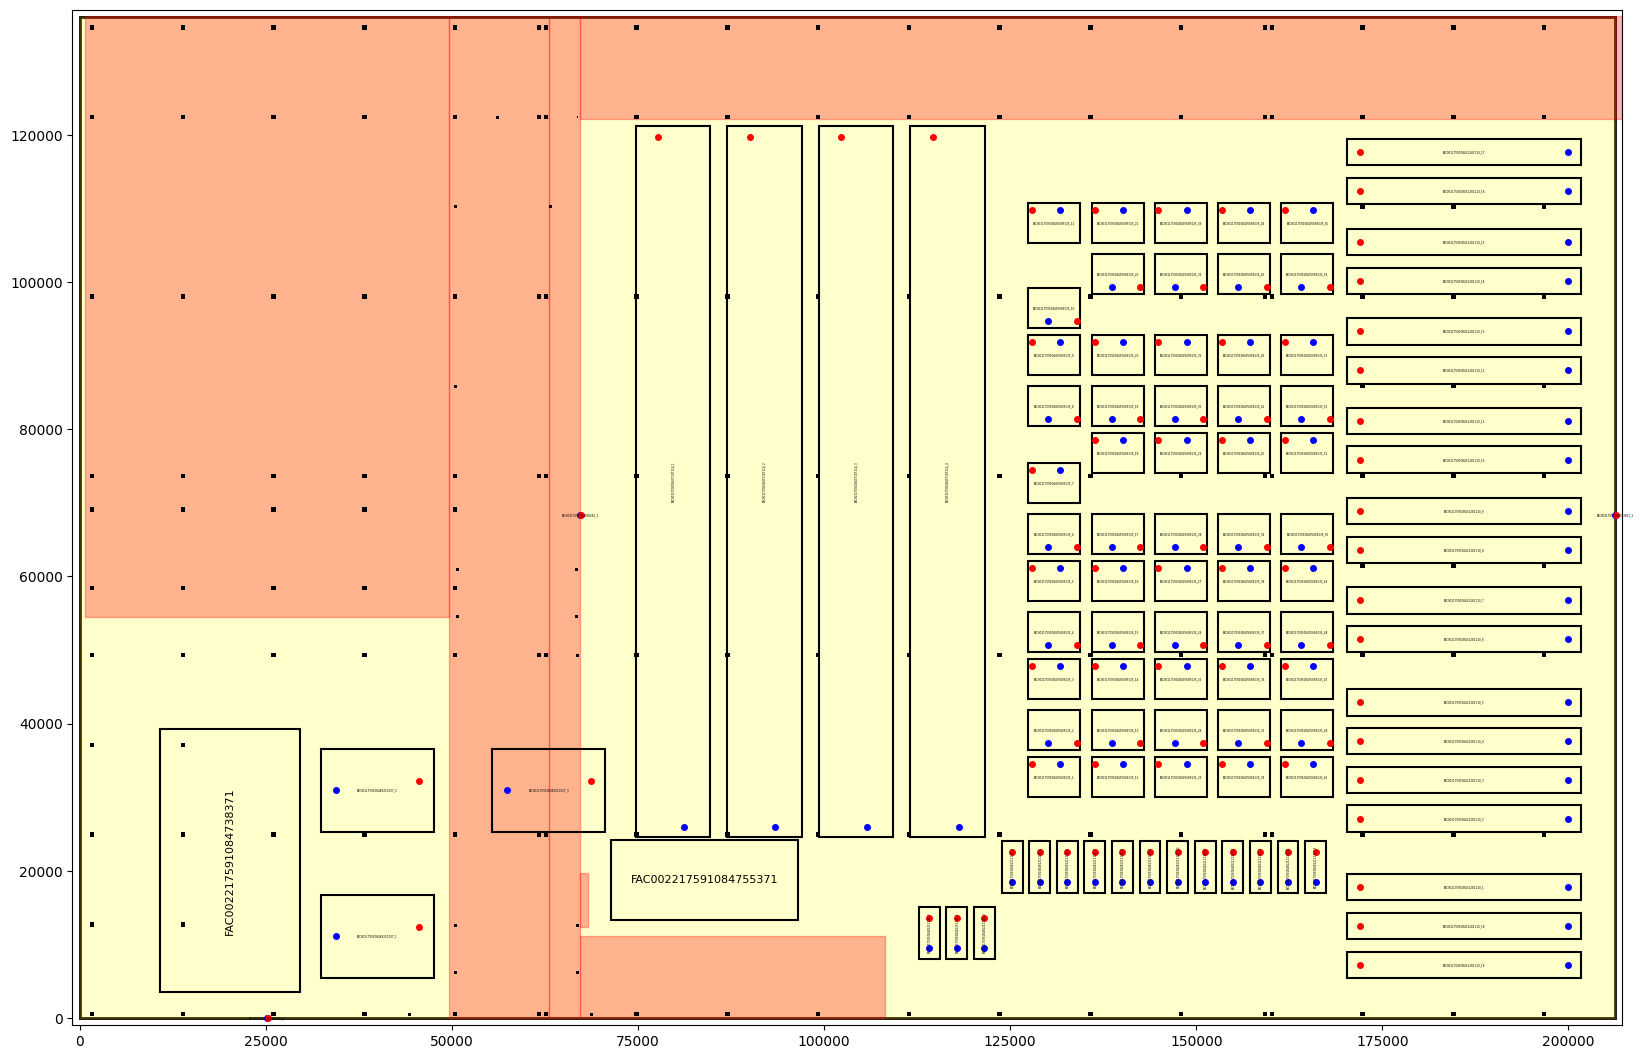

In [ ]:
for _ in range(5):
    L_ad()
plt_f_2()

In [ ]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,...,exi_X,exi_Y,lineCount,pathWidth,Cluster_X,Cluster_Y,cluster_UR,cluster_UL,cluster_UB,cluster_UA
0,FAC0011759108431281110,19,31418,3600,5.0,3,35,1709,1709,1675,...,1709,1800,1,1709,31418,98550,1709.0,1709.0,3600.0,3600.0
1,FAC0011759108435699135,54,7000,5438,4.5,3,35,1500,1500,938,...,6520,938,1,938,41000,64508,1500.0,1500.0,938.0,5438.0
2,FAC0011759108437107114,4,96714,10000,4.5,3,35,1477,1477,1500,...,95237,6974,1,1477,96714,46900,1477.0,1477.0,6000.0,6000.0
3,FAC0011759108449210137,3,15157,11316,5.0,3,35,1956,2841,1077,...,13201,6933,1,1956,15157,37008,1956.0,2841.0,4526.0,4526.0
4,FAC0011759108481211130,15,2807,7038,5.0,3,35,900,900,1900,...,1403,5561,1,1477,54705,7038,2807.0,2807.0,1900.0,1900.0
5,FAC002217591084738371,3,4200,7500,5.0,1,35,0,0,0,...,2100,3750,1,1956,18760,35860,700.0,700.0,3125.0,3125.0
6,FAC002217591084755371,3,2250,3900,5.0,1,35,0,0,0,...,1125,1950,1,1182,10800,25200,375.0,375.0,1625.0,1625.0
7,FAC00317591084013601,1,100,100,1.0,0,0,0,0,0,...,100,50,1,400,100,100,0.0,0.0,0.0,0.0
8,FAC00317591084583873,1,100,100,1.0,0,0,0,0,0,...,100,50,1,400,100,100,0.0,0.0,0.0,0.0
9,FAC00317591084598242,1,100,100,1.0,0,0,0,0,0,...,100,50,1,2522,100,100,0.0,0.0,0.0,0.0


In [ ]:
k_cluster

{0: {'y': np.int64(19), 'x': 1},
 1: {'x': 5, 'y': 11},
 2: {'y': np.int64(4), 'x': 1},
 3: {'y': np.int64(3), 'x': 1},
 4: {'x': np.int64(15), 'y': 1},
 5: {'x': 9, 'y': 5},
 6: {'x': 10, 'y': 7},
 7: {'x': np.int64(1), 'y': 1},
 8: {'x': np.int64(1), 'y': 1},
 9: {'x': np.int64(1), 'y': 1}}

In [ ]:
c=6
df_result[df_result['설비Group'] == df_result.loc[c,'설비Group']]['center_Y']

0      17800.0
1      27075.0
2      32350.0
3      37625.0
4      42900.0
5      51475.0
6      56750.0
7      63625.0
8      68900.0
9      75875.0
10     81150.0
11     88025.0
12     93300.0
13    100175.0
14    105450.0
15    112425.0
16    117700.0
17     12491.0
18      7182.0
Name: center_Y, dtype: float64

# 조정 완료 결과

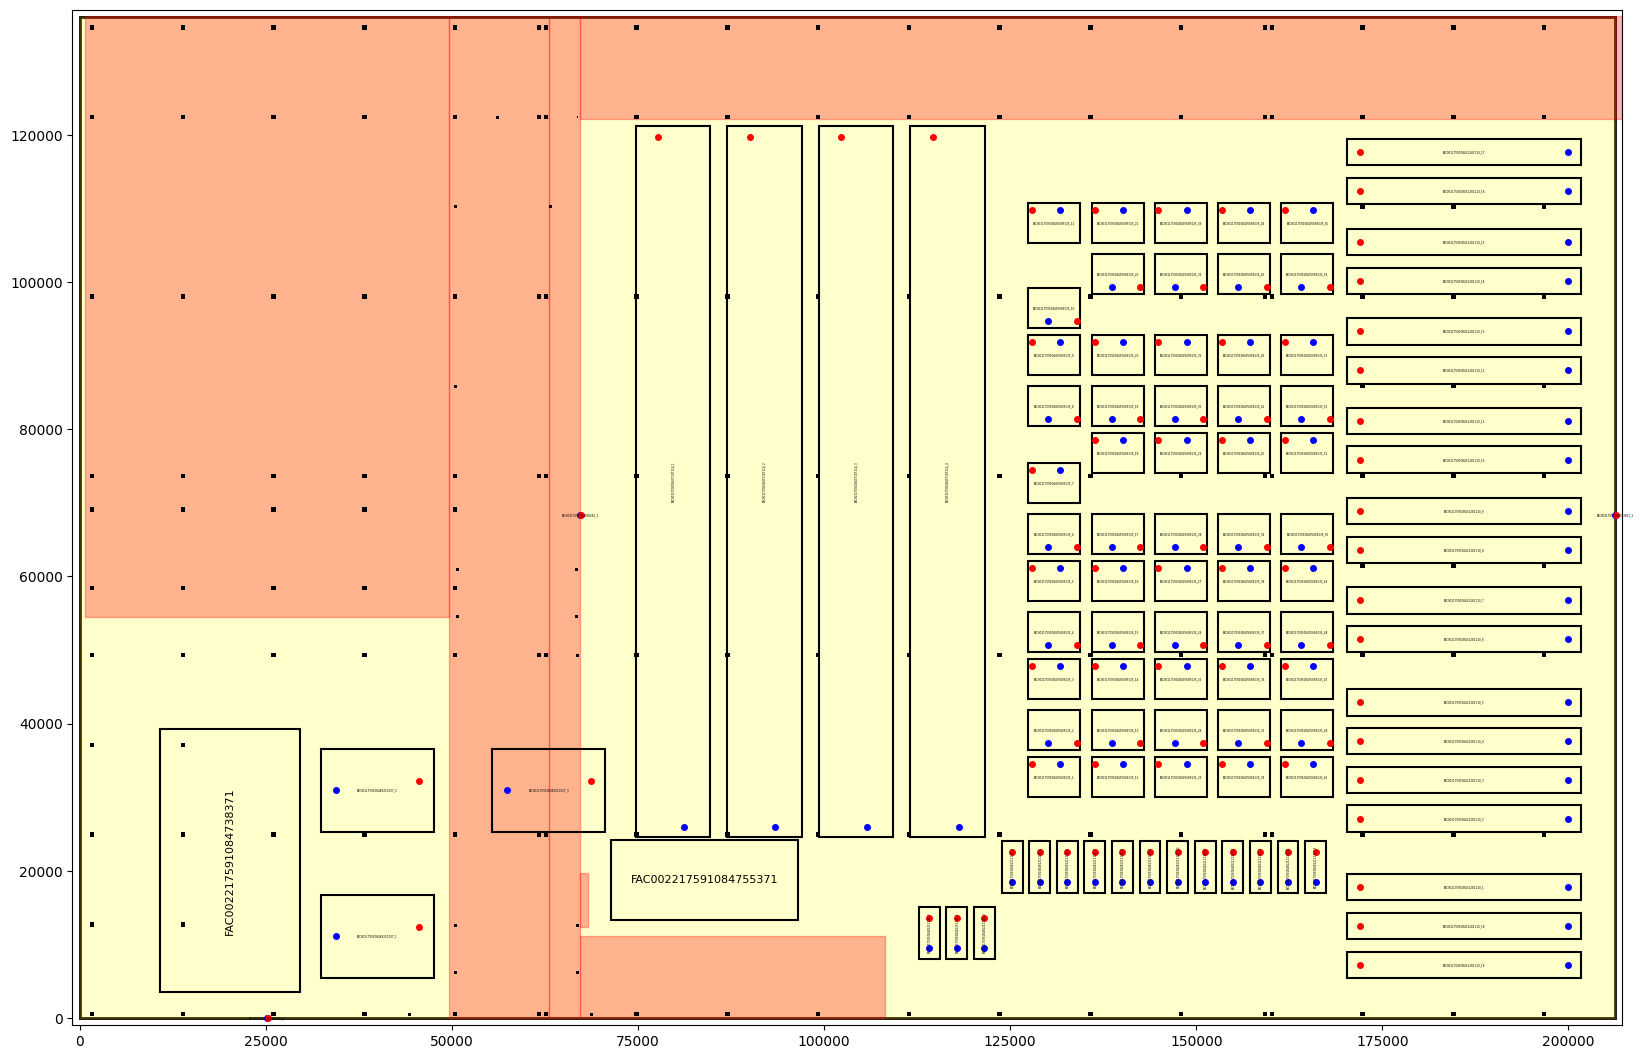

In [ ]:
plt_f_2()

In [ ]:
# del_cle=[]
# del_fa=[]
# for c in df_result.index:
#     fea,r=Check_only_cluster(c)
#     if fea==False:
#         print(c," / ",r)
#         if max(df_result.loc[c,'x'],df_result.loc[c,'y'])<max(df_result.loc[r,'x'],df_result.loc[r,'y']):
#             i= c
#         else:
#             i=r
#         if (c not in del_fa) and (r not in del_fa):
#             del_fa.append(i)

#         if df_result.loc[i,'설비Group'] not in del_cle:
#             del_cle.append(df_result.loc[i,'설비Group'])

In [ ]:
# for c in del_fa:
#     if len(df_result[df_result['설비Group']==df_result.loc[c,'설비Group']])!=1:
        
#         if df_result.loc[c,'회전']+df_result.loc[c,'k']==1:
#             if df_result.loc[c,'설비번호']==0:
#                 d=c+1
#             else:
#                 d=c-df_result.loc[c,'설비번호']
#             alp=0   
#             for _ in range(1000):
#                 df_result.loc[c,'center_Y']=df_result.loc[d,'center_Y']
#                 df_result.loc[c,'center_X']=df_result.loc[d,'center_X']-alp
#                 fea,r=Check_only_cluster(c)
#                 if fea==False:
#                     alp+=4000
#                 else:
#                     break
#         else:
#             if df_result.loc[c,'설비번호']==0:
#                 d=c+1
#             else:
#                 d=c-df_result.loc[c,'설비번호']
#             alp=0   
#             for _ in range(1000):
#                 df_result.loc[c,'center_X']=df_result.loc[d,'center_X']
#                 df_result.loc[c,'center_Y']=df_result.loc[d,'center_Y']+alp
#                 fea,r=Check_only_cluster(c)
#                 if fea==False:
#                     alp+=4000
#                 else:
#                     break            

In [ ]:
del_fa=[]
for c in df_result.index:
    if df_result.iloc[c]['회전']==0:
        ro_ck=[df_result.iloc[c]['x'],df_result.iloc[c]['y']]
    else:
        ro_ck=[df_result.iloc[c]['y'],df_result.iloc[c]['x']]
    x_ck=df_result.iloc[c]['center_X']
    y_ck=df_result.iloc[c]['center_Y']
    
    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

        if x_ck+ro_ck[0]/2<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2>=max(y_uni):
            feasible=True
            
        if x_ck+ro_ck[0]/2>Xupper or x_ck-ro_ck[0]/2<Xunder or y_ck+ro_ck[1]/2>Yupper or y_ck-ro_ck[1]/2<Yunder:
            feasible=False
        if feasible==False:
            del_fa.append(c)
            break

# 설비간 겹침 조정 def

In [ ]:
def move(rows):
    for i in range(len(new_c)):
        c=new_c[i][0]
        x=new_c[i][1]
        y=new_c[i][2]
        o=new_c[i][3]
        group = df_result.iloc[c]['설비Group']
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
      
        X_fa=x
        Y_fa=y

        x_f=df_result.iloc[c]['x'] 
        y_f=df_result.iloc[c]['y']
        row = {
            "설비Group": group,

            "center_X": X_fa,
            "center_Y": Y_fa,
            "x": x_f,
            "y": y_f,
            "회전":o,
            "k":df_result.iloc[c]['k'] 
        }
        rows.append(row)
    df_r = pd.DataFrame(rows)  
    return df_r

In [ ]:
Clear_R={}
Clear_L={}
Clear_A={}
Clear_B={}
for i in df_selected.index:
    Clear_R[i]=df_selected.loc[i,'UL']
    Clear_L[i]=df_selected.loc[i,'UL']
    Clear_B[i]=df_selected.loc[i,'UB']
    Clear_A[i]=df_selected.loc[i,'UB']
df_selected['Clear_R'] = Clear_R
df_selected['Clear_L'] = Clear_L
df_selected['Clear_B'] = Clear_B
df_selected['Clear_A'] = Clear_A

In [ ]:
def make_df_re_cle():
    rows=[]
    idxs = []
    i=0
    for c in df_selected.index:
        
        if c>1:
            if df_selected.loc[c,'설비Group']==df_selected.loc[c-1,'설비Group']:
                i+=1
                min_in=max_in+1
                max_in=min_in+df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']]['설비수량'].iloc[i]-1
            else:
                i=0
                min_in=min(df_result[df_result['설비Group']==df_selected.loc[c,'설비Group']].index)
                max_in=min_in+df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']]['설비수량'].iloc[0]-1                
        else:
            min_in=min(df_result[df_result['설비Group']==df_selected.loc[c,'설비Group']].index)
            max_in=min_in+df_selected[df_selected['설비Group']==df_selected.loc[c,'설비Group']]['설비수량'].iloc[0]-1
        
        
        if o[c]==0:
            if df_selected.loc[c,'type']!='storage':
                c_X=df_result.loc[min_in:max_in, 'center_X'].max()-df_result.loc[min_in:max_in, 'center_X'].min()+df_selected.loc[c,'x']
                c_Y=df_result.loc[min_in:max_in, 'center_Y'].max()-df_result.loc[min_in:max_in, 'center_Y'].min()+df_selected.loc[c,'y']
            else:
                c_X=W0[c]
                c_Y=H0[c]
        else:
            if df_selected.loc[c,'type']!='storage':
                c_X=df_result.loc[min_in:max_in, 'center_X'].max()-df_result.loc[min_in:max_in, 'center_X'].min()+df_selected.loc[c,'y']
                c_Y=df_result.loc[min_in:max_in, 'center_Y'].max()-df_result.loc[min_in:max_in, 'center_Y'].min()+df_selected.loc[c,'x']
            else:
                c_X=H0[c]
                c_Y=W0[c]           
        if o[c]==0 and di[c]==0:
            U_R=Clear_R[c]
            U_L=Clear_L[c]
            U_B=Clear_B[c]
            U_A=Clear_A[c]
        elif o[c]==1 and di[c]==0:
            U_R=Clear_A[c]
            U_L=Clear_B[c]
            U_B=Clear_R[c]
            U_A=Clear_L[c]   
        elif o[c]==0 and di[c]==1:
            U_R=Clear_L[c]
            U_L=Clear_R[c]
            U_B=Clear_A[c]
            U_A=Clear_B[c]
        else:
            U_R=Clear_B[c]
            U_L=Clear_A[c]
            U_B=Clear_L[c]
            U_A=Clear_R[c]
        if df_selected.loc[c,'type']!='storage':
            center_X=(df_result.loc[min_in:max_in, 'center_X'].min()+df_result.loc[min_in:max_in, 'center_X'].max())/2
            center_Y=(df_result.loc[min_in:max_in, 'center_Y'].min()+df_result.loc[min_in:max_in, 'center_Y'].max())/2
        else:
            center_X=X[c]
            center_Y=Y[c]
        row = {
            "설비Group": df_selected.loc[c,'설비Group'],
            "type": df_selected.loc[c,'type'],
            "center_X": center_X,
            "center_Y": center_Y,
            "cluster_X": c_X,
            "cluster_Y": c_Y,
            "U_R": U_R,
            "U_L": U_L,
            "U_B": U_B,
            "U_A": U_A
        }
        rows.append(row)
        idxs.append(c)


    df_re_cle = pd.DataFrame(rows, index=idxs)  
    return df_re_cle

In [ ]:
def Check_cluster_1500(c):
    x_ck=df_re_cle.loc[c,'center_X']
    y_ck=df_re_cle.loc[c,'center_Y']

    ne=0
    endi=0
        
    ro_ck=[df_re_cle.loc[c,'cluster_X'],df_re_cle.loc[c,'cluster_Y']]

    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]
        ne=abs(x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']-min(x_uni))
        endi=1
        if x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']<=min(x_uni):
            feasible=True
        
        
        if ne>abs(x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']-max(x_uni)):
            ne=abs(x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']-max(x_uni))
            endi=2
        if x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']>=max(x_uni):
            feasible=True

        if ne>abs(y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']-min(y_uni)):
            ne=abs(y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']-min(y_uni))
            endi=3
        if y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']<=min(y_uni):
            feasible=True

        if ne>abs(y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']-max(y_uni)):
            ne=abs(y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']-max(y_uni))
            endi=4
        if y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']>=max(y_uni):
            feasible=True

        if feasible==False and abs(ne)>20:
            return feasible ,0,0,ne,endi 
  
    if df_selected.loc[c,'type']==1:
        for r in range(len(mezz_areas)):
            feasible=False
            x_uni=[mezz_areas[r]['x'],mezz_areas[r]['x']+mezz_areas[r]['width']]
            y_uni=[mezz_areas[r]['y'],mezz_areas[r]['y']+mezz_areas[r]['height']]

            ne=abs(x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']-min(x_uni))
            endi=1
            if x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']<=min(x_uni):

                feasible=True


            if ne>abs(x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']-max(x_uni)):
                ne=abs(x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']-max(x_uni))
                endi=2

            if x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']>=max(x_uni):
                feasible=True

            if ne>abs(y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']-min(y_uni)):
                ne=abs(y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']-min(y_uni))
                endi=3
            if y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']<=min(y_uni):
                feasible=True

            if ne>abs(y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']-max(y_uni)):
                ne=abs(y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']-max(y_uni))
                endi=4

            if y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']>=max(y_uni):
                feasible=True

            if feasible==False and abs(ne)>20:
                return feasible ,100,100,ne,endi               
    
    for r in df_re_cle.index:
        
        if r==c:
            continue
            
        feasible=False


        x_uni=[df_re_cle.loc[r,'center_X']-df_re_cle.loc[r,'cluster_X']/2,df_re_cle.loc[r,'center_X']+df_re_cle.loc[r,'cluster_X']/2]
        y_uni=[df_re_cle.loc[r,'center_Y']-df_re_cle.loc[r,'cluster_Y']/2,df_re_cle.loc[r,'center_Y']+df_re_cle.loc[r,'cluster_Y']/2]

        ne= x_ck+ro_ck[0]/2+max(df_re_cle.loc[c,'U_R'],df_re_cle.loc[r,'U_L'])-min(x_uni)
        endi=1

        if x_ck+ro_ck[0]/2+max(df_re_cle.loc[c,'U_R'],df_re_cle.loc[r,'U_L'])-1<min(x_uni):

            feasible=True
      
        if ne>=max(x_uni)-x_ck+ro_ck[0]/2+max(df_re_cle.loc[c,'U_L'],df_re_cle.loc[r,'U_R']):
            ne=max(x_uni)-x_ck+ro_ck[0]/2+max(df_re_cle.loc[c,'U_L'],df_re_cle.loc[r,'U_R'])
            endi=2
            
        if x_ck-ro_ck[0]/2-max(df_re_cle.loc[c,'U_L'],df_re_cle.loc[r,'U_R'])+1>max(x_uni):
            if r==4:
                print(x_ck-ro_ck[0]/2)
                print(x_uni)
            feasible=True
            
            
        if ne>=y_ck+ro_ck[1]/2+max(df_re_cle.loc[c,'U_A'],df_re_cle.loc[r,'U_B'])-min(y_uni):
            ne=y_ck+ro_ck[1]/2+max(df_re_cle.loc[c,'U_A'],df_re_cle.loc[r,'U_B'])-min(y_uni)
            endi=3

        if y_ck+ro_ck[1]/2+max(df_re_cle.loc[c,'U_A'],df_re_cle.loc[r,'U_B'])<min(y_uni):
            feasible=True

        if ne>=max(y_uni)- y_ck+ro_ck[1]/2+max(df_re_cle.loc[c,'U_B'],df_re_cle.loc[r,'U_A']):
            ne=max(y_uni)- y_ck+ro_ck[1]/2+max(df_re_cle.loc[c,'U_B'],df_re_cle.loc[r,'U_A'])
            endi=4
        if y_ck-ro_ck[1]/2-max(df_re_cle.loc[c,'U_B'],df_re_cle.loc[r,'U_A'])>max(y_uni):
            feasible=True

        if feasible==False and abs(ne)>20:
            return feasible,r,2,ne,endi

    return feasible,None,0,ne,endi


def Check_cluster_1500_XY(c):
    x_ck=df_re_cle.loc[c,'center_X']
    y_ck=df_re_cle.loc[c,'center_Y']
    clear=499
    ne=0
    endi=0
        
    ro_ck=[df_re_cle.loc[c,'cluster_X'],df_re_cle.loc[c,'cluster_Y']]
        


    if x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']-1>Xupper:
        return False,x_ck+ro_ck[0]/2+df_re_cle.loc[c,'U_R']-Xupper,1

    if x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']+1<Xunder:
        return False,Xunder-(x_ck-ro_ck[0]/2-df_re_cle.loc[c,'U_L']+1),2

    if y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']>Yupper:
        return False,y_ck+ro_ck[1]/2+df_re_cle.loc[c,'U_A']-Yupper,3

    if y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']+1<Yunder:
        return False,Yunder-(y_ck-ro_ck[1]/2-df_re_cle.loc[c,'U_B']+1),2


    return True,0,0

In [ ]:
def Check_cluster_1500_x_y(c,x_ck,y_ck,w,d,U_R,U_L,U_B,U_A):
    clear=499
    ne=0
    endi=0
        
    ro_ck=[w,d]

    for r in range(len(restricted_areas)):
        feasible=False
        x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
        y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

        if x_ck+ro_ck[0]/2+clear<=min(x_uni):
            feasible=True

        if x_ck-ro_ck[0]/2-clear>=max(x_uni):
            feasible=True


        if y_ck+ro_ck[1]/2+clear<=min(y_uni):
            feasible=True


        if y_ck-ro_ck[1]/2-clear>=max(y_uni):
            feasible=True

        if feasible==False:
            return feasible ,0,0,0,0   
    
    
    for r in df_re_cle.index:
        
        if r==c:
            continue
                
        feasible=False


        x_uni=[df_re_cle.loc[r,'center_X']-df_re_cle.loc[r,'cluster_X']/2,df_re_cle.loc[r,'center_X']+df_re_cle.loc[r,'cluster_X']/2]
        y_uni=[df_re_cle.loc[r,'center_Y']-df_re_cle.loc[r,'cluster_Y']/2,df_re_cle.loc[r,'center_Y']+df_re_cle.loc[r,'cluster_Y']/2]

        ne= x_ck+ro_ck[0]/2+max(U_R,df_re_cle.loc[r,'U_L'])-min(x_uni)
        endi=1

        if x_ck+ro_ck[0]/2+max(U_R,df_re_cle.loc[r,'U_L'])-1<min(x_uni):
            feasible=True
      
        if ne>=max(x_uni)-x_ck+ro_ck[0]/2+max(U_L,df_re_cle.loc[r,'U_R']):
            ne=max(x_uni)-x_ck+ro_ck[0]/2+max(U_L,df_re_cle.loc[r,'U_R'])
            endi=2
            
        if x_ck-ro_ck[0]/2-max(U_L,df_re_cle.loc[r,'U_R'])+1>max(x_uni):
            feasible=True
            
            
        if ne>=y_ck+ro_ck[1]/2+max(U_A,df_re_cle.loc[r,'U_B'])-min(y_uni):
            ne=y_ck+ro_ck[1]/2+max(U_A,df_re_cle.loc[r,'U_B'])-min(y_uni)
            endi=3

        if y_ck+ro_ck[1]/2+max(U_A,df_re_cle.loc[r,'U_B'])<min(y_uni):
            feasible=True

        if ne>=max(y_uni)- y_ck+ro_ck[1]/2+max(U_B,df_re_cle.loc[r,'U_A']):
            ne=max(y_uni)- y_ck+ro_ck[1]/2+max(U_B,df_re_cle.loc[r,'U_A'])
            endi=4
        if y_ck-ro_ck[1]/2-max(U_B,df_re_cle.loc[r,'U_A'])>max(y_uni):
            feasible=True

        if feasible==False and abs(ne)>20:
            return feasible,r,2,ne,endi

    if x_ck+ro_ck[0]/2+U_R-1>Xupper:
        return False,None,0,x_ck+ro_ck[0]/2+U_R-Xupper,5

    if x_ck-ro_ck[0]/2-U_L+1<Xunder:
        return False,None,0,Xunder-(x_ck-ro_ck[0]/2-U_L),6

    if y_ck+ro_ck[1]/2+U_A-1>Yupper:
        return False,None,0,y_ck+ro_ck[1]/2+U_A-Yupper,7

    if y_ck-ro_ck[1]/2-U_B+1<Yunder:
        return False,None,0,Yunder-(y_ck-ro_ck[1]/2-U_B+1),8
    
    return feasible,None,0,ne,endi

In [ ]:
def col_ad():
    des_cluster=[]
    for c in df_re_cle.index:
#         if df_re_cle.loc[c,"type"]=="storage":
#             continue
        for _ in range(3):
            fe,r,ty,ne,endi=Check_cluster_1500(c)
            if fe ==False and ne>20:
                print("c :",c," r: ",r," ne: ",ne," endi: ",endi)
                df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                if endi==1: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_X']-=ne
                    for d in df_c.index:
                        df_result.loc[d,'center_X']-=ne
                elif endi==2: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_X']+=ne
                    fe_2,ne_2,endi_2=Check_cluster_1500_XY(c)
                    for d in df_c.index:
                        df_result.loc[d,'center_X']+=ne
                elif endi==3: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_Y']-=ne
                    fe_2,ne_2,endi_2=Check_cluster_1500_XY(c)
                    for d in df_c.index:
                        df_result.loc[d,'center_Y']-=ne
                elif endi==4: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_Y']+=ne
                    for d in df_c.index:
                        df_result.loc[d,'center_Y']+=ne
            else:
                break

In [ ]:
def col_ad_reverse():
    des_cluster=[]
    for c in reversed(df_re_cle.index):
#         if df_re_cle.loc[c,"type"]=="storage":
#             continue
        for _ in range(3):
            
            fe,r,ty,ne,endi=Check_cluster_1500(c)

            if fe ==False and ne>20:

                df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                if endi==1: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_X']-=ne
                    if df_re_cle.loc[c,'type']=='storage':
                        X[c]-=ne
                    for d in df_c.index:
                        df_result.loc[d,'center_X']-=ne
                        
                elif endi==2: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_X']+=ne
                    if df_re_cle.loc[c,'type']=='storage':
                        X[c]+=ne
                    fe_2,ne_2,endi_2=Check_cluster_1500_XY(c)
                    for d in df_c.index:
                        df_result.loc[d,'center_X']+=ne
                elif endi==3: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_Y']-=ne
                    if df_re_cle.loc[c,'type']=='storage':
                        Y[c]-=ne
                    fe_2,ne_2,endi_2=Check_cluster_1500_XY(c)
                    for d in df_c.index:
                        df_result.loc[d,'center_Y']-=ne
                elif endi==4: 
                    df_c = df_result[df_result['설비Group'] == df_re_cle.loc[c, '설비Group']]  
                    df_re_cle.loc[c,'center_Y']+=ne
                    if df_re_cle.loc[c,'type']=='storage':
                        Y[c]+=ne
                    for d in df_c.index:
                        df_result.loc[d,'center_Y']+=ne
            else:
                break

# 설비간 겹침 조정 코드

In [ ]:
plt_f_2()

KeyboardInterrupt: 

In [ ]:
#아직 완전 자동화가 안되어서 주석된 코드들을 위의 figure를 보고 조합을 바꿔주어야 합니다.
#L_ad()/L_ad_re() 기둥 겹침 조정 코드
#col_ad()/col_ad_reverse() 설비간 겹침 조정 코드

265000.0
[np.float64(70986.0), np.float64(103817.0)]
206979.0
[np.float64(70986.0), np.float64(103817.0)]
206979.0
[np.float64(70986.0), np.float64(103817.0)]
135762.0
[np.float64(70986.0), np.float64(103817.0)]
180654.0
[np.float64(70986.0), np.float64(103817.0)]
182095.0
[np.float64(70986.0), np.float64(103817.0)]
117534.0
[np.float64(70986.0), np.float64(103817.0)]
250986.0
[np.float64(70986.0), np.float64(103817.0)]
250986.0
[np.float64(70986.0), np.float64(103817.0)]


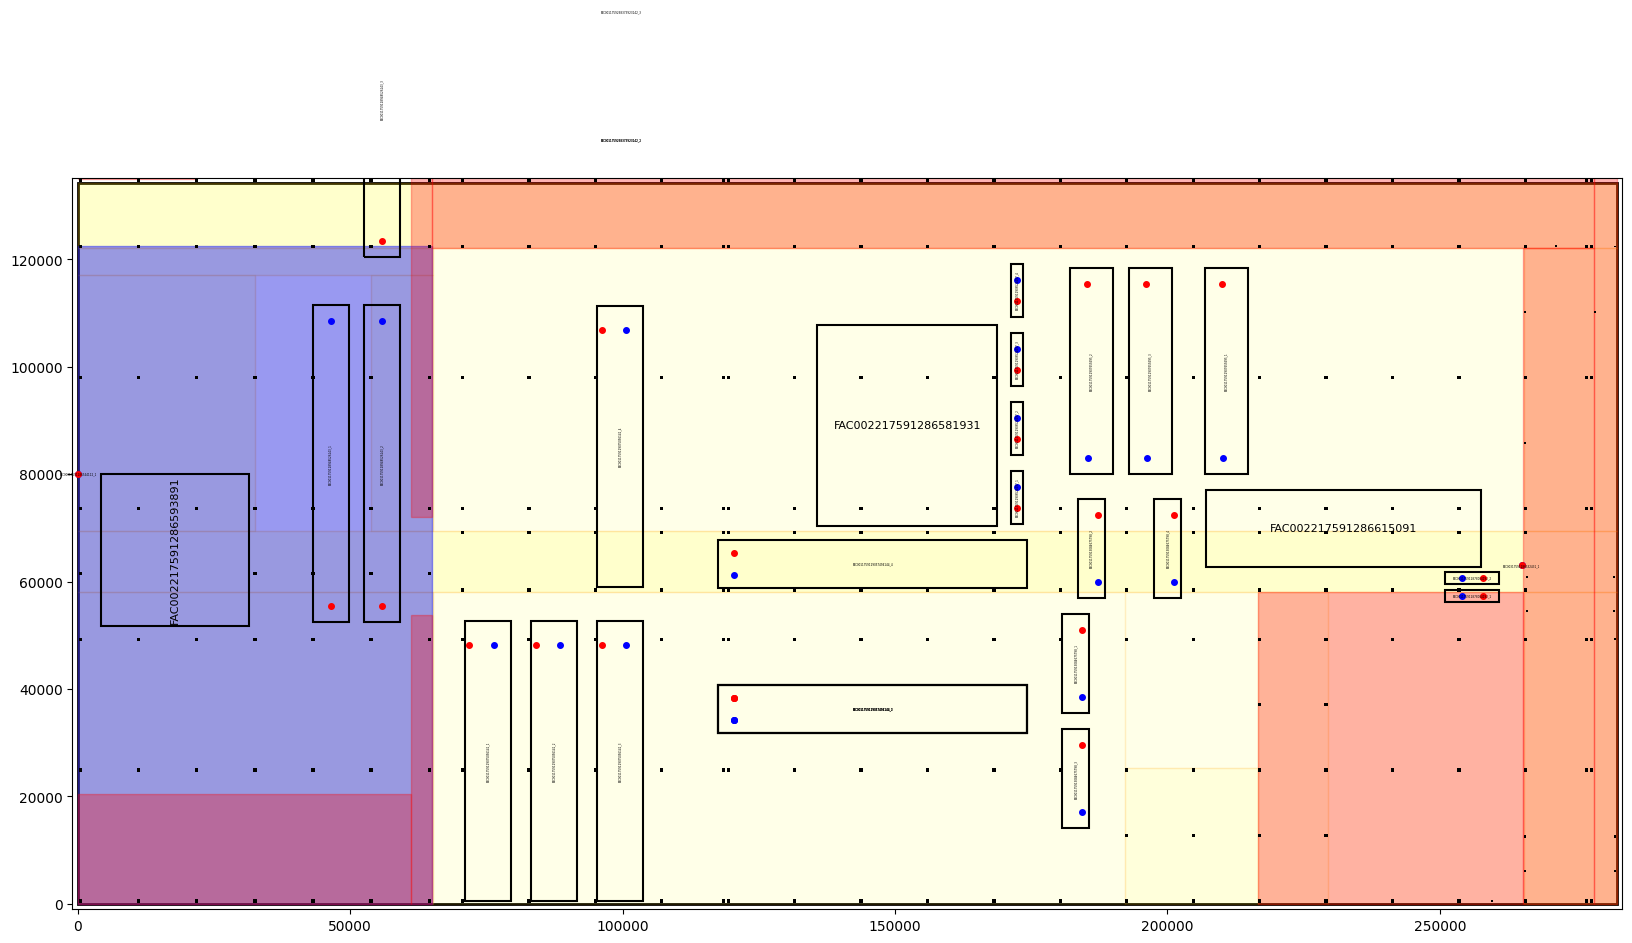

In [ ]:
df_re_cle=make_df_re_cle()
col_ad_reverse()

plt_f_2()

In [ ]:
# L_ad_re()

In [ ]:
L_ad()

24
25


In [ ]:

df_re_cle=make_df_re_cle()
col_ad()
col_ad()

c : 0  r:  0  ne:  2958.0  endi:  4
250986.0
[np.float64(70986.0), np.float64(103817.0)]
c : 0  r:  10  ne:  2958.0  endi:  3
c : 0  r:  0  ne:  2958.0  endi:  4
c : 1  r:  0  ne:  7315.0  endi:  1
c : 1  r:  0  ne:  20107.0  endi:  2
c : 1  r:  0  ne:  8982.0  endi:  1
117534.0
[np.float64(70986.0), np.float64(103817.0)]
c : 3  r:  0  ne:  93.0  endi:  3
c : 3  r:  2  ne:  93.0  endi:  4
c : 3  r:  0  ne:  93.0  endi:  3
182095.0
[np.float64(70986.0), np.float64(103817.0)]
180654.0
[np.float64(70986.0), np.float64(103817.0)]
135762.0
[np.float64(70986.0), np.float64(103817.0)]
c : 10  r:  0  ne:  2958.0  endi:  4
206979.0
[np.float64(70986.0), np.float64(103817.0)]
c : 10  r:  5  ne:  2958.0  endi:  3
c : 10  r:  0  ne:  2958.0  endi:  4
265000.0
[np.float64(70986.0), np.float64(103817.0)]
250986.0
[np.float64(70986.0), np.float64(103817.0)]
c : 1  r:  0  ne:  3810.0  endi:  1
c : 1  r:  0  ne:  7315.0  endi:  1
c : 1  r:  0  ne:  20107.0  endi:  2
c : 2  r:  3  ne:  93.0  endi:  3
11

206979.0
[np.float64(73968.0), np.float64(106799.0)]
265000.0
[np.float64(73968.0), np.float64(106799.0)]


In [ ]:
# for c in df_result.index:
#     if df_result.loc[c,'설비번호']==0:
#         if df_result.loc[c,'center_Y']<Yunder:
#             if df_result.loc[c,'회전']+df_result.loc[c,'k']==1:
#                 if df_result.loc[c,'회전']==0:
#                      df_result.loc[c,'center_Y']=Yunder+df_result.loc[c,'y']/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UB'].iloc[0]
#                 else:
#                      df_result.loc[c,'center_Y']=Yunder+df_result.loc[c,'x']/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UL'].iloc[0]            
#         elif df_result.loc[c,'center_X']<Xunder:
#             if df_result.loc[c,'회전']+df_result.loc[c,'k']!=1:
#                 if df_result.loc[c,'회전']==0:
#                      df_result.loc[c,'center_X']=Xunder+df_result.loc[c,'x']/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UL'].iloc[0]
#                 else:
#                      df_result.loc[c,'center_X']=Xunder+df_result.loc[c,'y']/2+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UB'].iloc[0]                            
            
#         else:
#             continue
#     else:
#         if df_result.loc[c,'회전']+df_result.loc[c,'k']==1:
#             if df_result.loc[c,'회전']==0:
#                 df_result.loc[c,'center_Y']=df_result.loc[c-df_result.loc[c,'설비번호'],'center_Y']+df_result.loc[c,'설비번호']*(df_result.loc[c,'y']+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UB'].iloc[0])
#             else:
#                 df_result.loc[c,'center_Y']=df_result.loc[c-df_result.loc[c,'설비번호'],'center_Y']+df_result.loc[c,'설비번호']*(df_result.loc[c,'x']+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UL'].iloc[0])
#         else:
#             if df_result.loc[c,'회전']==0:
#                 df_result.loc[c,'center_X']=df_result.loc[c-df_result.loc[c,'설비번호'],'center_X']+df_result.loc[c,'설비번호']*(df_result.loc[c,'x']+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UL'].iloc[0])
#             else:
#                 df_result.loc[c,'center_X']=df_result.loc[c-df_result.loc[c,'설비번호'],'center_X']+df_result.loc[c,'설비번호']*(df_result.loc[c,'y']+df_selected[df_selected['설비Group']==df_result.loc[c,'설비Group']]['UB'].iloc[0])

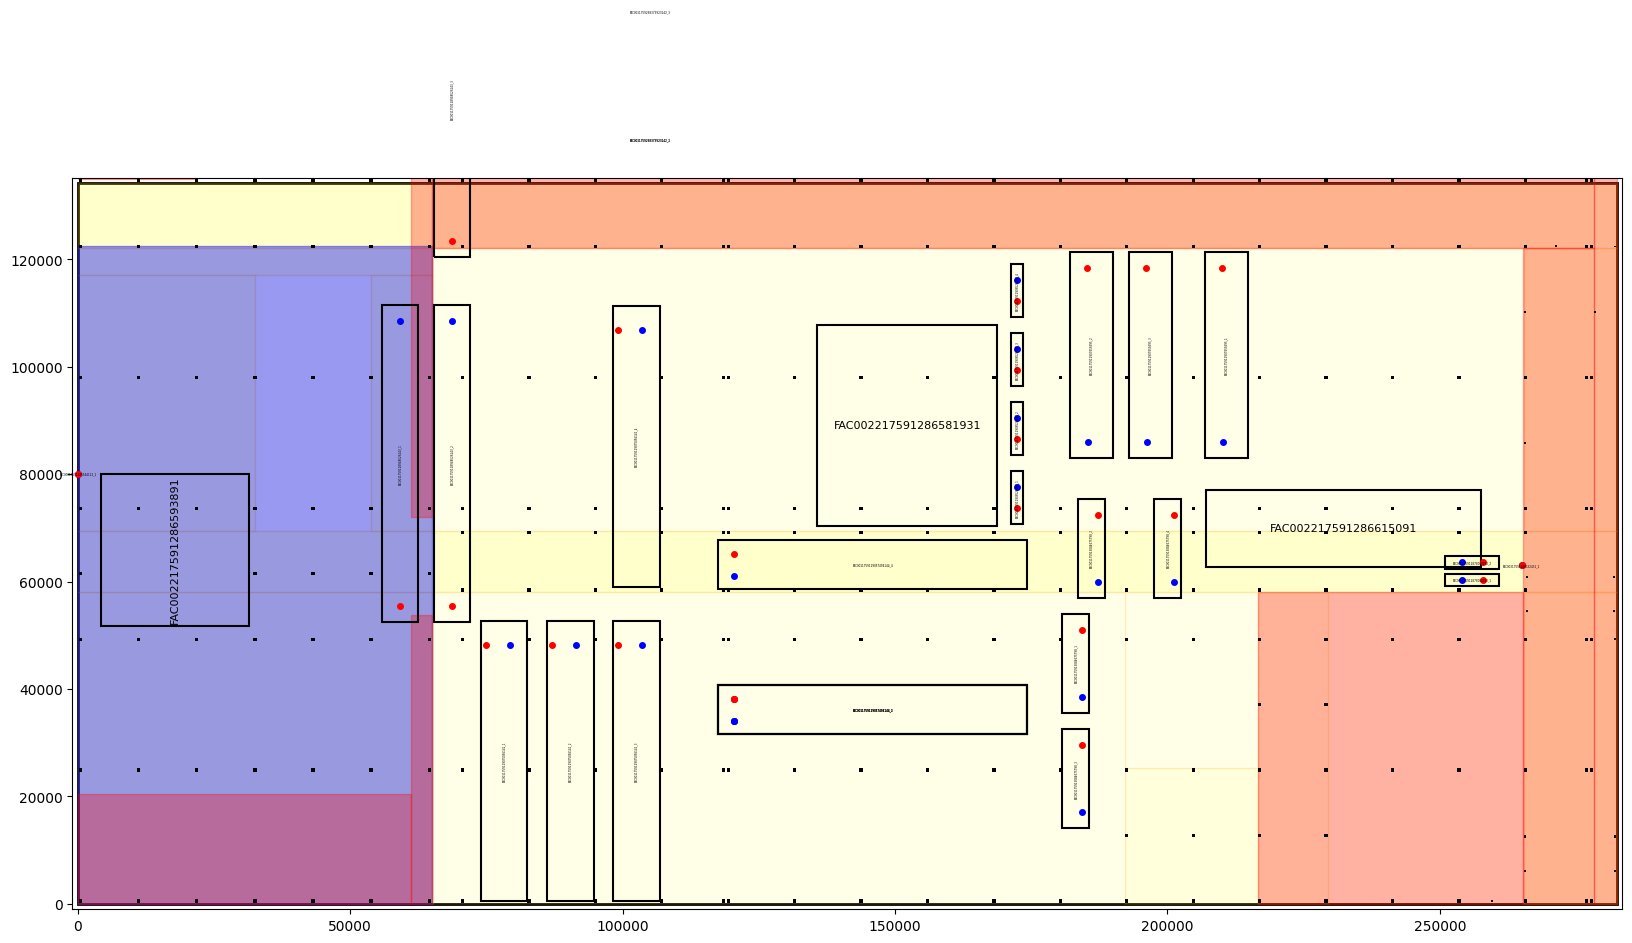

In [ ]:
plt_f_2()

In [ ]:
# L_ad_re()
# L_ad_re()
# plt_f_2()

In [ ]:
# df_re_cle=make_df_re_cle()
# col_ad()
# col_ad()
# plt_f_2()

In [ ]:
def plt_f_4():

    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=(15.9, 8))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)

    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}
    dims_2={}

    for c in df_result.index:
        

        if df_result.loc[c,'type']=='storage':
            continue

            
        if df_result.loc[c,'회전'] == 1:
            dims_[c] = (df_result.loc[c,'y'],df_result.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])     

        w, h = dims_[c]
        
        llx = df_result.loc[c,'center_X'] - w/2
        lly = df_result.loc[c,'center_Y'] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        if df_selected.loc[d,'processGroup']=='dock':
            continue        
        if o[d]==1:
            if di[d]==0:
                dims_2[c]=(total_expand[d][2],total_expand[d][3],total_expand[d][1],total_expand[d][0])
            else:
                dims_2[c]=(total_expand[d][3],total_expand[d][2],total_expand[d][0],total_expand[d][1])
        else:
            if di[d]==0:
                dims_2[c]=(total_expand[d][0],total_expand[d][1],total_expand[d][2],total_expand[d][3])
            else:
                dims_2[c]=(total_expand[d][1],total_expand[d][0],total_expand[d][3],total_expand[d][2])
        x_1,x_2,y_1,y_2= dims_2[c]

        if x_1==1:
            llx_2 = df_result.loc[c,'center_X'] + w/2-df_selected.loc[d,'pathWidth']
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), df_selected.loc[d,'pathWidth'], h, fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)

        if x_2==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), df_selected.loc[d,'pathWidth'], h, fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)       
            ax.add_patch(rect_2)     

        if y_1==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] + h/2-df_selected.loc[d,'pathWidth']
            rect_2 = patches.Rectangle((llx_2, lly_2), w, df_selected.loc[d,'pathWidth'], fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)   

        if y_2==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), w, df_selected.loc[d,'pathWidth'], fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)                

        fs=2
        if w>=h:
            ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
        else:
            ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)

    
    for c in df_result.index:
        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            w=df_result.loc[c,'y'] # rotated
            h=df_result.loc[c,'x']
        else:
            w=df_result.loc[c,'x'] # rotated
            h=df_result.loc[c,'y'] 
            
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        
        
            
        ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
        ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
        ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
        ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2
        
        if o[d]==0 and di[d]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif o[d]==1 and di[d]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif o[d]==0 and di[d]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_result.loc[c,'center_X'] + en_x, df_result.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_result.loc[c,'center_X'] + ex_x, df_result.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)

    dims_ = {}
    
    for c in df_selected.index:
        if df_selected.loc[c,'type']!='storage':
            continue
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated

        else:
            dims_[c] = (W0[c], H0[c])  # original 
            


        w, h = dims_[c]

        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        

        
        if o[c]==0:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8,rotation=90)
        else:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8)
        
#         for i in data['facilityGroups']:
#             if i['groupId']=='FAC00221757674711540124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               

#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='red', markersize=6)                  
#             elif i['groupId']=='FAC00221757674710411124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(4):
#                         if j==3:
#                             col_='blue'
#                         else:
#                             col_='red'
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*(4-1)+4*j*shuttleInport[0]['height'], marker='s', color=col_, markersize=6)               

#                     for j in range(2):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*(2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)                  
#             else:
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               


#                     ax.plot(X[c]+w/2, Y[c]-h/2+4*shuttleInport[0]['height'], marker='s', color='red', markersize=6)  


        


    sotrage_en_x={}
    sotrage_en_y={}
    sotrage_exi_x={}
    sotrage_exi_y={}
    for key,value in boundary_X.items():
        st_exi_x=[]
        st_exi_y=[]
        for j in range(len(to_selected[key])):
             for i in range(len(to_selected[key][j])):  
                
                ax.plot(value[to_selected[key][j][i]],boundary_Y[key][to_selected[key][j][i]], marker='s', color='red', markersize=7)
                st_exi_x.append(value[to_selected[key][j][i]])
                st_exi_y.append(boundary_Y[key][to_selected[key][j][i]])
        sotrage_exi_x[key]=st_exi_x
        sotrage_exi_y[key]=st_exi_y
        
    for key,value in boundary_X.items():
        st_en_x=[]
        st_en_y=[]
        for j in range(len(from_selected[key])):
             for i in range(len(from_selected[key][j])):             
                ax.plot(value[from_selected[key][j][i]],boundary_Y[key][from_selected[key][j][i]], marker='s', color='blue', markersize=7)
                st_en_x.append(value[from_selected[key][j][i]])
                st_en_y.append(boundary_Y[key][from_selected[key][j][i]])
        sotrage_en_x[key]=st_en_x
        sotrage_en_y[key]=st_en_y 
        
    for c in df_pre.index:
        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            w=df_pre.loc[c,'y'] # rotated
            h=df_pre.loc[c,'x']
        else:
            w=df_pre.loc[c,'x'] # rotated
            h=df_pre.loc[c,'y'] 
            
        d=df_selected_copy_2[df_selected_copy_2['설비Group'] == df_pre.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected_copy_2.loc[d,'ent_X']-df_pre.loc[c,'x']/2
        ori_en_y=df_selected_copy_2.loc[d,'ent_Y']-df_pre.loc[c,'y']/2
        ori_ex_x=df_selected_copy_2.loc[d,'exi_X']-df_pre.loc[c,'x']/2
        ori_ex_y=df_selected_copy_2.loc[d,'exi_Y']-df_pre.loc[c,'y']/2
        
        if df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif df_pre.loc[c, '회전']==1 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_pre.loc[c,'center_X'] + en_x, df_pre.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_pre.loc[c,'center_X'] + ex_x, df_pre.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)              
    to_cl_un={}
    to_cl_up={}
    for i in range(len(s_un)):
        cl_un=-999999999
        cl_up=999999999
        for c in range(s_un[i],s_up[i]+1):
            
            if o[c]==0:
                dims_bo=[W0[c],H0[c]]
            else:
                dims_bo=[H0[c],W0[c]]  
                
            if cl_un<=Y[c]-dims_bo[1]/2:
                cl_un=Y[c]-dims_bo[1]/2
                
            if cl_up>=Y[c]+dims_bo[1]/2:
                cl_up=Y[c]+dims_bo[1]/2
            
        for c in range(s_un[i],s_up[i]+1):  
            to_cl_un[c]=cl_un
            to_cl_up[c]=cl_up
            
    for c in df_selected.index:

        if df_selected.loc[c,"type"]!="storage":
            continue
        if o[c]==0:
            dims_bo=[W0[c],H0[c]]
        else:
            dims_bo=[H0[c],W0[c]]
        i=0  
        
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2:
                break
            X_b=X[c]-dims_bo[0]/2
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['height']*i
            i+=1
            if abs(X_b-mezz_areas[1]['x'])<=2000 and Y_b>=to_cl_un[c] and Y_b<=to_cl_up[c]:
                continue
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
        i=0  
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2:
                break

            X_b=X[c]+dims_bo[0]/2-shuttleInport[0]['width']
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['height']*i
            i+=1
            if abs(X_b-mezz_areas[1]['x'])<=5000 and Y_b>=to_cl_un[c] and Y_b<=to_cl_up[c]:
                continue
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
            
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['height']*i
            Y_b=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']
            i+=1
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['height']*i
            Y_b=Y[c]-dims_bo[1]/2
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
            i+=1      
            
    ax.set_xlim(0, dims["width"])
    ax.set_ylim(0, dims["height"])



    plt.show()
    return sotrage_en_x, sotrage_en_y, sotrage_exi_x, sotrage_exi_y

# storage 입/출구 결정 코드

In [ ]:
boundary_X={}
boundary_Y={}

i=0

for c in df_selected.index:
    X_bo=[]
    Y_bo=[]
    if df_selected.loc[c,"type"]!="storage":
        continue
    if o[c]==0:
        dims_bo=[W0[c],H0[c]]
    else:
        dims_bo=[H0[c],W0[c]]
    i=0    
    while True:
        if Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']:
            break
        X_bo.append(X[c]-dims_bo[0]/2+shuttleInport[0]['width']/2)
        Y_bo.append(Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i)
        i+=1
    i=0      
    while True:
        if X[c]-dims_bo[0]/2+shuttleInport[0]['width']/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2-shuttleInport[0]['width']:
            break
        X_bo.append(X[c]-dims_bo[0]/2+shuttleInport[0]['width']/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i)
        Y_bo.append(Y[c]+dims_bo[1]/2-shuttleInport[0]['width']/2)
        i+=1
    i=0  
    while True:
        if Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']:
            break
        X_bo.append(X[c]+dims_bo[0]/2-shuttleInport[0]['width']/2)
        Y_bo.append(Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i)
        i+=1

    i=0      
    while True:
        if X[c]-dims_bo[0]/2+shuttleInport[0]['width']/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2-shuttleInport[0]['width']:
            break
        X_bo.append(X[c]-dims_bo[0]/2+shuttleInport[0]['width']/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i)
        Y_bo.append(Y[c]-dims_bo[1]/2+shuttleInport[0]['width']/2)
        i+=1

    boundary_X[c]=X_bo
    boundary_Y[c]=Y_bo

In [ ]:
group_matrix

,FAC001175912878064192,FAC0011759128948526143,FAC0011759129057494144,FAC001175912906524597,FAC0011759129075056141,FAC001175912907655695,FAC001175913084675798,FAC0011759298373923142,FAC002217591286581931,FAC002217591286593891,FAC002217591286615091,FAC00317591286532431,FAC00317591286544112
FAC001175912878064192,0,0,0,0,0,0,0,0,0,0,1,0,0
FAC0011759128948526143,0,0,0,0,0,0,0,0,0,1,0,0,0
FAC0011759129057494144,0,0,0,0,0,0,0,0,1,0,1,0,0
FAC001175912906524597,0,0,0,0,0,0,1,0,1,0,0,0,0
FAC0011759129075056141,0,0,0,0,0,0,0,0,1,0,0,0,0
FAC001175912907655695,0,0,0,0,0,0,0,0,1,0,0,0,0
FAC001175913084675798,0,0,0,0,0,0,0,0,1,0,0,0,0
FAC0011759298373923142,0,0,0,0,1,0,0,0,0,0,0,0,0
FAC002217591286581931,0,1,1,1,0,1,0,1,0,0,0,0,0
FAC002217591286593891,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
group_matrix.loc[df_selected.loc[c,"설비Group"]]

FAC001175912878064192     0
FAC0011759128948526143    0
FAC0011759129057494144    0
FAC001175912906524597     0
FAC0011759129075056141    0
FAC001175912907655695     0
FAC001175913084675798     0
FAC0011759298373923142    0
FAC002217591286581931     0
FAC002217591286593891     0
FAC002217591286615091     0
FAC00317591286532431      0
FAC00317591286544112      0
Name: FAC00317591286544112, dtype: int64

In [ ]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,...,Cluster_X,Cluster_Y,cluster_UR,cluster_UL,cluster_UB,cluster_UA,Clear_R,Clear_L,Clear_B,Clear_A
0,FAC001175912878064192,2,9869,2300,5.0,3,35,2987,2987,1010,...,9869,5610,2987.0,2987.0,460.0,460.0,2987,2987,1010,1010
1,FAC0011759128948526143,3,6610,58934,5.0,3,35,2029,2029,2987,...,23888,58934,2644.0,2644.0,2987.0,4004.0,2029,2029,2987,2987
2,FAC0011759129057494144,4,9020,56741,10.0,3,35,1735,1437,2987,...,41285,56741,5412.0,5412.0,2987.0,1173.0,1437,1437,2987,2987
3,FAC001175912906524597,4,9869,2300,5.0,3,35,2987,2987,1010,...,9869,12230,2987.0,2987.0,1380.0,1380.0,2987,2987,1010,1010
4,FAC0011759129075056141,4,8519,52210,10.0,3,35,2287,1386,0,...,40937,52210,5111.0,5111.0,0.0,2987.0,1386,1386,0,0
5,FAC001175912907655695,3,38398,7965,5.0,3,35,2987,2987,1002,...,38398,25925,2987.0,2987.0,3186.0,3186.0,2987,2987,1002,1002
6,FAC001175913084675798,4,18461,5000,5.0,3,35,2987,2987,2000,...,18461,26000,2987.0,2987.0,3000.0,3000.0,2987,2987,2000,2000
7,FAC0011759298373923142,3,10577,60351,5.0,3,35,807,808,2987,...,33347,60351,4231.0,4231.0,2987.0,2987.0,808,808,2987,2987
8,FAC002217591286581931,11,5760,10620,11.0,0,35,0,0,0,...,37248,32928,960.0,960.0,4425.0,4425.0,0,0,0,0
9,FAC002217591286593891,3,4965,9120,5.0,0,35,0,0,0,...,27142,28292,827.5,827.5,3800.0,3800.0,0,0,0,0


In [ ]:
sfc_to

{10: ['FAC001175912878064192', 'FAC0011759129057494144'],
 8: ['FAC0011759129057494144',
  'FAC001175912906524597',
  'FAC0011759129075056141',
  'FAC001175912907655695',
  'FAC001175913084675798',
  'FAC002217591286615091'],
 9: ['FAC0011759128948526143']}

In [ ]:
sfc_from

{10: ['FAC002217591286581931'],
 8: ['FAC0011759128948526143',
  'FAC0011759129057494144',
  'FAC001175912906524597',
  'FAC001175912907655695',
  'FAC0011759298373923142'],
 9: ['FAC00317591286544112']}

In [ ]:

boundary_dis_to={}
for c in df_selected.index:
    if df_selected.loc[c,'type']!='storage':
        continue
    #seri=group_matrix.loc[df_selected.loc[c,"설비Group"]]
    
    #storage_to = seri.index[seri.eq(1)].tolist()
    storage_to =sfc_to[c]
    print(storage_to)
    
    dis_list=[[] for _ in range(len(storage_to))]
    for a in range(len(storage_to)):
        for j in range(len(boundary_X[c])):
            to_di=0
            
            if len(df_pre[df_pre['설비Group']==storage_to[a]])!=0:
                to_di=abs(boundary_X[c][j]-df_pre[df_pre['설비Group']==storage_to[a]]['center_X'].iloc[0])+abs(boundary_Y[c][j]-df_pre[df_pre['설비Group']==storage_to[a]]['center_Y'].iloc[0])          
            
            for i in df_result.index:
                if df_result.loc[i,'설비Group']!=storage_to[a]:
                    continue
                s_en_x=df_selected[df_selected['설비Group']==storage_to[a]]['ent_X'].iloc[0]-df_result.loc[i,'x']/2
                s_en_y=df_selected[df_selected['설비Group']==storage_to[a]]['ent_Y'].iloc[0]-df_result.loc[i,'y']/2    
                if o[df_selected[df_selected['설비Group']==storage_to[a]].index[0]]==0:
                    if di[df_selected[df_selected['설비Group']==storage_to[a]].index[0]]==0:
                        dims=[s_en_x,s_en_y]
                    else:
                        dims=[-s_en_x,-s_en_y]
                else:
                    if di[df_selected[df_selected['설비Group']==storage_to[a]].index[0]]==0:
                        dims=[s_en_y,-s_en_x]
                    else:
                        dims=[-s_en_y,s_en_x]
                to_di+=abs(boundary_X[c][j]-(df_result.loc[i,'center_X']+dims[0]))+abs(boundary_Y[c][j]-(df_result.loc[i,'center_Y']+dims[1]))
            dis_list[a].append(to_di)
    boundary_dis_to[c]=dis_list
            

boundary_dis_from={}
for c in df_selected.index:
    if df_selected.loc[c,'type']!='storage':
        continue
    
    storage_from = sfc_from[c]

    dis_list=[[] for _ in range(len(storage_from))]
    for a in range(len(storage_from)):
        for j in range(len(boundary_X[c])):
            to_di=0
            
            if len(df_pre[df_pre['설비Group']==storage_from[a]])!=0:
                to_di=abs(boundary_X[c][j]-df_pre[df_pre['설비Group']==storage_from[a]]['center_X'].iloc[0])+abs(boundary_Y[c][j]-df_pre[df_pre['설비Group']==storage_from[a]]['center_Y'].iloc[0])          
            
            for i in df_result.index:
                if df_result.loc[i,'설비Group']!=storage_from[a]:
                    continue
                s_en_x=df_selected[df_selected['설비Group']==storage_from[a]]['exi_X'].iloc[0]-df_result.loc[i,'x']/2
                s_en_y=df_selected[df_selected['설비Group']==storage_from[a]]['exi_Y'].iloc[0]-df_result.loc[i,'y']/2    
                if o[df_selected[df_selected['설비Group']==storage_from[a]].index[0]]==0:
                    if di[df_selected[df_selected['설비Group']==storage_from[a]].index[0]]==0:
                        dims=[s_en_x,s_en_y]
                    else:
                        dims=[-s_en_x,-s_en_y]
                else:
                    if di[df_selected[df_selected['설비Group']==storage_from[a]].index[0]]==0:
                        dims=[s_en_y,-s_en_x]
                    else:
                        dims=[-s_en_y,s_en_x]
                to_di+=abs(boundary_X[c][j]-(df_result.loc[i,'center_X']+dims[0]))+abs(boundary_Y[c][j]-(df_result.loc[i,'center_Y']+dims[1]))
            dis_list[a].append(to_di)
    boundary_dis_from[c]=dis_list


['FAC0011759129057494144', 'FAC001175912906524597', 'FAC0011759129075056141', 'FAC001175912907655695', 'FAC001175913084675798', 'FAC002217591286615091']
['FAC0011759128948526143']
['FAC001175912878064192', 'FAC0011759129057494144']


In [ ]:
sfc_to

{10: ['FAC001175912878064192', 'FAC0011759129057494144'],
 8: ['FAC0011759129057494144',
  'FAC001175912906524597',
  'FAC0011759129075056141',
  'FAC001175912907655695',
  'FAC001175913084675798',
  'FAC002217591286615091'],
 9: ['FAC0011759128948526143']}

In [ ]:
sfc_from

{10: ['FAC002217591286581931'],
 8: ['FAC0011759128948526143',
  'FAC0011759129057494144',
  'FAC001175912906524597',
  'FAC001175912907655695',
  'FAC0011759298373923142'],
 9: ['FAC00317591286544112']}

In [ ]:
from collections import deque
to_selected={}
for c in df_selected.index:
    if df_selected.loc[c,'type']!='storage':
        continue
    for i in data['facilityGroups']:
        if i['groupId']==df_selected.loc[c,'설비Group']:
            num_po=int((len(i['facilities'])-1)/2)
    
    selected = [[] for _ in range(len(boundary_dis_to[c]))]
    for j in range(len(boundary_dis_to[c])):
        blocked = set()   # 이미 뽑힌 값의 ±1을 기록해서 빠르게 제외
        li=sorted(range(len(boundary_dis_to[c][j])), key=boundary_dis_to[c][j].__getitem__)
        for x in li:
            if x in blocked:
                continue
            x_ck=boundary_X[c][x]
            y_ck=boundary_Y[c][x]
            ro_ck=[shuttleInport[0]['width'],shuttleInport[0]['height']]
            for r in range(len(column_areas)):
                feasible=False
                red_feasible=0
                x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
                y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

                if x_ck+ro_ck[0]/2<min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2>max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2<min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2>max(y_uni):
                    feasible=True    
                if feasible==False:
                    break
            if feasible==False:
                continue

            clear=1500    
            for r in range(len(restricted_areas)):
                feasible=False
                x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
                y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

                if x_ck+ro_ck[0]/2+clear<=min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2-clear>=max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2+clear<=min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2-clear>=max(y_uni):
                    feasible=True

                if feasible==False:
                    break  
            if feasible==False:
                continue    
            
            
            
            selected[j].append(x)
            blocked.add(x)
            blocked.add(x - 1)
            blocked.add(x + 1)
            if len(selected[j]) == num_po:
                break
    to_selected[c]=selected
    
from_selected={}
for c in df_selected.index:
    if df_selected.loc[c,'type']!='storage':
        continue
    for i in data['facilityGroups']:
        if i['groupId']==df_selected.loc[c,'설비Group']:
            num_po=int((len(i['facilities'])-1)/2)
            
    selected = [[] for _ in range(len(boundary_dis_from[c]))]
    for j in range(len(boundary_dis_from[c])):
        blocked = set()   # 이미 뽑힌 값의 ±1을 기록해서 빠르게 제외
        if len(to_selected[c])!=0:
            for i in to_selected[c][0]:
                blocked.add(i)
                blocked.add(i-1)
                blocked.add(i+1)
        li=sorted(range(len(boundary_dis_from[c][j])), key=boundary_dis_from[c][j].__getitem__)
        for x in li:
            if x in blocked:
                continue
            x_ck=boundary_X[c][x]
            y_ck=boundary_Y[c][x]
            ro_ck=[shuttleInport[0]['width'],shuttleInport[0]['height']]

            for r in range(len(column_areas)):
                feasible=False
                red_feasible=0
                x_uni=[column_areas[r]['x'],column_areas[r]['x']+column_areas[r]['width']]
                y_uni=[column_areas[r]['y'],column_areas[r]['y']+column_areas[r]['height']]

                if x_ck+ro_ck[0]/2<min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2>max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2<min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2>max(y_uni):
                    feasible=True    
                if feasible==False:
                    break
            if feasible==False:
                continue

            clear=1500    
            for r in range(len(restricted_areas)):
                feasible=False
                x_uni=[restricted_areas[r]['x'],restricted_areas[r]['x']+restricted_areas[r]['width']]
                y_uni=[restricted_areas[r]['y'],restricted_areas[r]['y']+restricted_areas[r]['height']]

                if x_ck+ro_ck[0]/2+clear<=min(x_uni):
                    feasible=True

                if x_ck-ro_ck[0]/2-clear>=max(x_uni):
                    feasible=True


                if y_ck+ro_ck[1]/2+clear<=min(y_uni):
                    feasible=True


                if y_ck-ro_ck[1]/2-clear>=max(y_uni):
                    feasible=True

                if feasible==False:
                    break  
            if feasible==False:
                continue                
                
                

            selected[j].append(x)
            blocked.add(x)
            blocked.add(x - 1)
            blocked.add(x + 1)
            if len(selected[j]) == num_po:
                break


    if len(selected)>1:
        queues = [deque(x) for x in selected]

        picked = []
        turn = 0  # 0번 리스트부터 시작

        while len(picked) < num_po:
            if queues[turn]:                 # 해당 큐가 비어있지 않으면
                picked.append(queues[turn].popleft())  # 앞에서 하나 뽑기
            turn = (turn + 1) % len(queues)  # 다음 리스트로 순서 넘기기
        selected=[picked]
    from_selected[c]=selected

In [ ]:
from_selected

{8: [[0, 40, 43, 34, 18]], 9: [[13]], 10: [[5, 7]]}

In [ ]:
# from_selected[5][0].remove(2)
# from_selected[5][0].remove(4)
# from_selected[6][0].remove(56)

In [ ]:
# for c in df_result.index:
#     if df_result.loc[c,'설비Group']==df_selected.loc[4,'설비Group']:
#         df_result.loc[c,'center_X']-=5000
#     if df_result.loc[c,'설비Group']==df_selected.loc[2,'설비Group']:
#         df_result.loc[c,'center_Y']+=1500
#     if df_result.loc[c,'설비Group']==df_selected.loc[3,'설비Group']:
#         df_result.loc[c,'center_X']-=1000

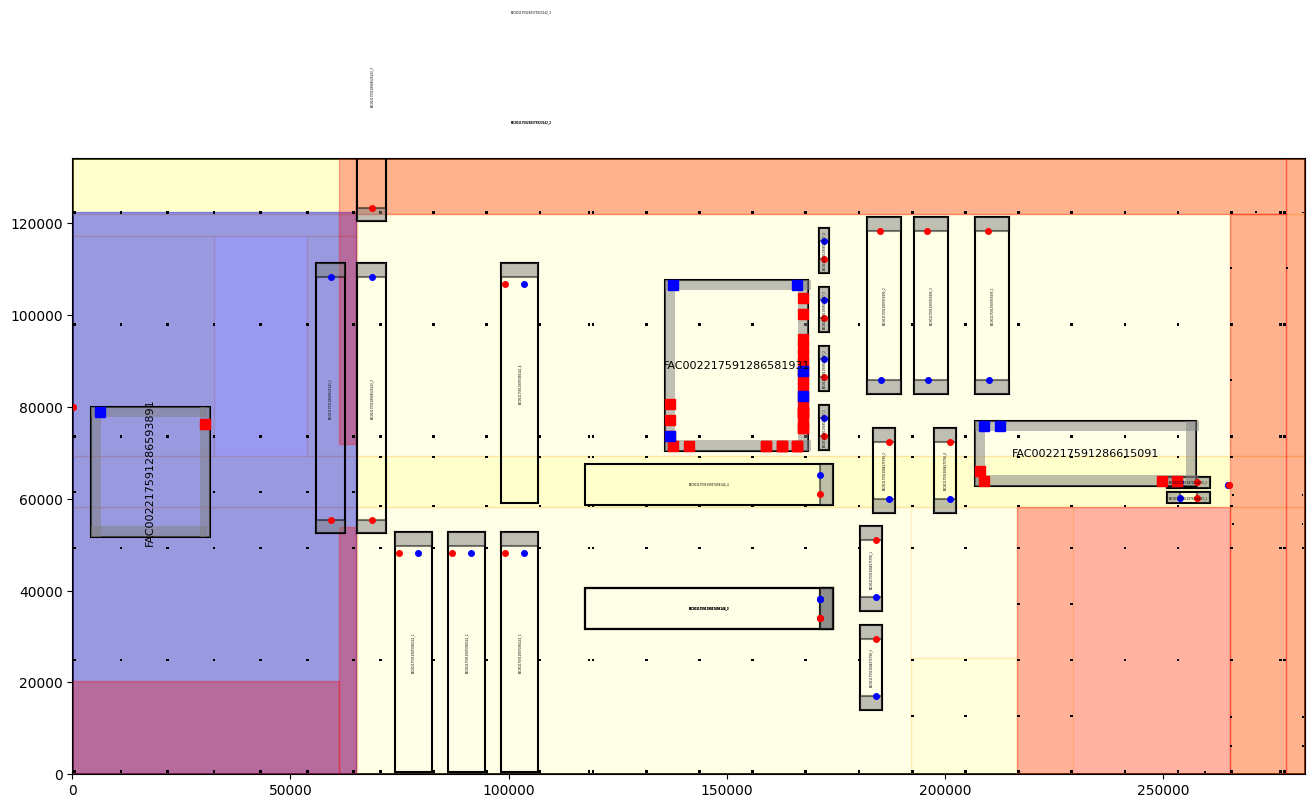

In [ ]:
sotrage_en_x, sotrage_en_y, sotrage_exi_x, sotrage_exi_y=plt_f_4()

# 경로 생성 코드

In [ ]:
def plt_f_5():
    
    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=(15.9, 8))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)

    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}


    for c in df_result.index:
        

        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            dims_[c] = (df_result.loc[c,'y'],df_result.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])     
        w, h = dims_[c]
        llx = df_result.loc[c,'center_X'] - w/2
        lly = df_result.loc[c,'center_Y'] - h/2
        if "L" in df_result.loc[c, '설비Group']:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5,edgecolor='red')
        else:
            rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if df_result.loc[c,'type']==1:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,color='blue')
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90,color='blue')
        else:
            fs=2
            if w>=h:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
            else:
                ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)
    
    for c in df_result.index:
        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            w=df_result.loc[c,'y'] # rotated
            h=df_result.loc[c,'x']
        else:
            w=df_result.loc[c,'x'] # rotated
            h=df_result.loc[c,'y'] 
            
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
        ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
        ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
        ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2
        
        if o[d]==0 and di[d]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif o[d]==1 and di[d]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif o[d]==0 and di[d]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_result.loc[c,'center_X'] + en_x, df_result.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_result.loc[c,'center_X'] + ex_x, df_result.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)

    dims_ = {}
    for c in df_selected.index:
        if df_selected.loc[c,'type']!='storage':
            continue
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated
        else:
            dims_[c] = (W0[c], H0[c])  # original 


        w, h = dims_[c]
        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        if o[c]==0:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8,rotation=90)
        else:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8)
        
#         for i in data['facilityGroups']:
#             if i['groupId']=='FAC00221757674711540124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               

#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='red', markersize=6)                  
#             elif i['groupId']=='FAC00221757674710411124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(4):
#                         if j==3:
#                             col_='blue'
#                         else:
#                             col_='red'
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*(4-1)+4*j*shuttleInport[0]['height'], marker='s', color=col_, markersize=6)               

#                     for j in range(2):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*(2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)                  
#             else:
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               


#                     ax.plot(X[c]+w/2, Y[c]-h/2+4*shuttleInport[0]['height'], marker='s', color='red', markersize=6)  


    for c in df_selected.index:

        if df_selected.loc[c,"type"]!="storage":
            continue
        if o[c]==0:
            dims_bo=[W0[c],H0[c]]
        else:
            dims_bo=[H0[c],W0[c]]
        i=0    
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']:
                break
            X_b=X[c]-dims_bo[0]/2
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']*i
            i+=1
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=False, linewidth=1,edgecolor='gray')
            ax.add_patch(rect)
        i=0  
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']:
                break
            X_b=X[c]+dims_bo[0]/2-shuttleInport[0]['width']
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['width']+shuttleInport[0]['height']*i
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=False, linewidth=1,edgecolor='gray')
            ax.add_patch(rect)
            i+=1
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2-shuttleInport[0]['width']:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['width']+shuttleInport[0]['height']*i
            Y_b=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']
            i+=1
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=False, linewidth=1,edgecolor='gray')
            ax.add_patch(rect)
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['width']+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2-shuttleInport[0]['width']:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['width']+shuttleInport[0]['height']*i
            Y_b=Y[c]-dims_bo[1]/2
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=False, linewidth=1,edgecolor='gray')
            ax.add_patch(rect)
            i+=1        



#     for key,value in boundary_X.items():
#         for j in range(len(to_selected[key])):
#              for i in range(len(to_selected[key][j])):             
#                 ax.plot(value[to_selected[key][j][i]],boundary_Y[key][to_selected[key][j][i]], marker='s', color='red', markersize=7)
        

#     for key,value in boundary_X.items():
#         for j in range(len(from_selected[key])):
#              for i in range(len(from_selected[key][j])):             
#                 ax.plot(value[from_selected[key][j][i]],boundary_Y[key][from_selected[key][j][i]], marker='s', color='blue', markersize=7)
        
    for c in df_pre.index:
        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            w=df_pre.loc[c,'y'] # rotated
            h=df_pre.loc[c,'x']
        else:
            w=df_pre.loc[c,'x'] # rotated
            h=df_pre.loc[c,'y'] 
            
        d=df_selected_copy_2[df_selected_copy_2['설비Group'] == df_pre.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected_copy_2.loc[d,'ent_X']-df_pre.loc[c,'x']/2
        ori_en_y=df_selected_copy_2.loc[d,'ent_Y']-df_pre.loc[c,'y']/2
        ori_ex_x=df_selected_copy_2.loc[d,'exi_X']-df_pre.loc[c,'x']/2
        ori_ex_y=df_selected_copy_2.loc[d,'exi_Y']-df_pre.loc[c,'y']/2
        
        if df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif df_pre.loc[c, '회전']==1 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_pre.loc[c,'center_X'] + en_x, df_pre.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_pre.loc[c,'center_X'] + ex_x, df_pre.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)              
            
    ax.set_xlim(0, dims["width"])
    ax.set_ylim(0, dims["height"])



    plt.show()

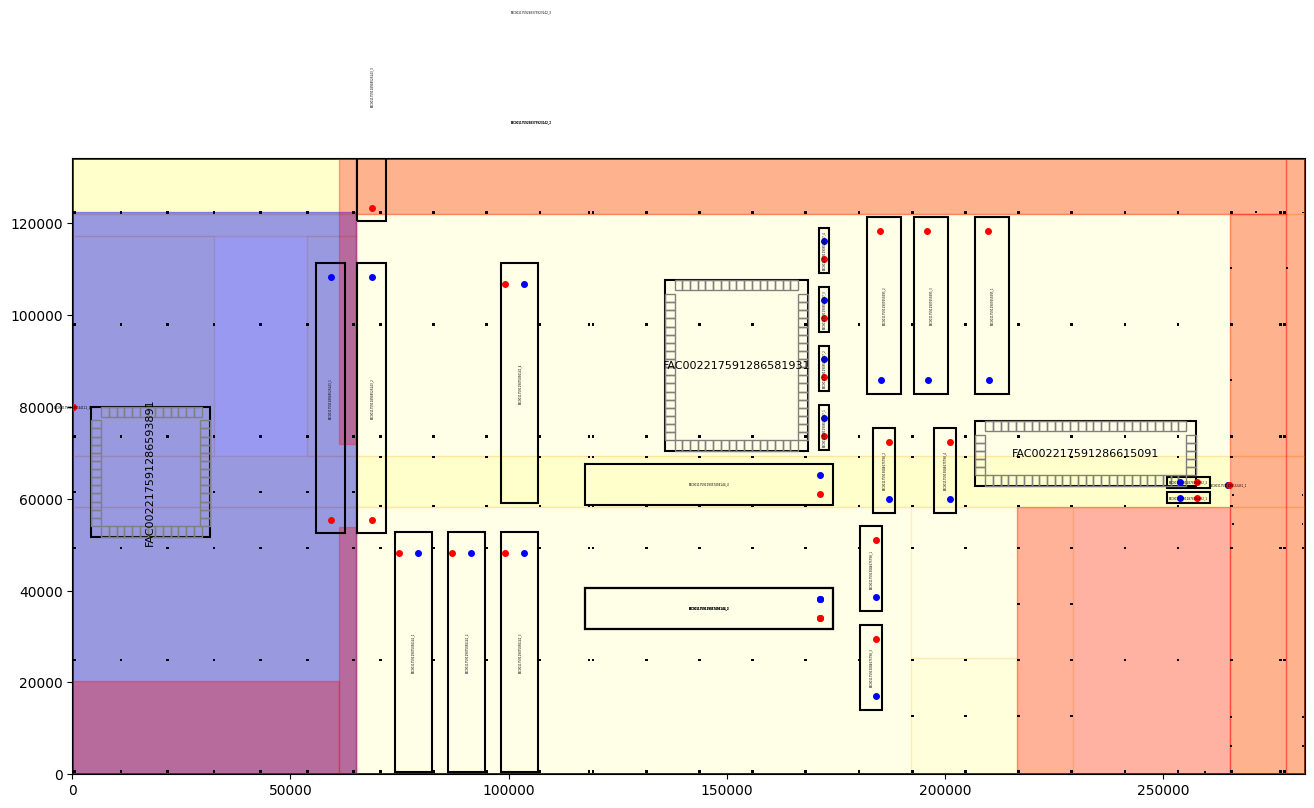

In [ ]:
plt_f_5()

In [ ]:
df_selected

,설비Group,설비수량,x,y,facilityHeight,facilityWeight,dry,UR,UL,UB,...,Cluster_X,Cluster_Y,cluster_UR,cluster_UL,cluster_UB,cluster_UA,Clear_R,Clear_L,Clear_B,Clear_A
0,FAC001175912878064192,2,9869,2300,5.0,3,35,2987,2987,1010,...,9869,5610,2987.0,2987.0,460.0,460.0,2987,2987,1010,1010
1,FAC0011759128948526143,3,6610,58934,5.0,3,35,2029,2029,2987,...,23888,58934,2644.0,2644.0,2987.0,4004.0,2029,2029,2987,2987
2,FAC0011759129057494144,4,9020,56741,10.0,3,35,1735,1437,2987,...,41285,56741,5412.0,5412.0,2987.0,1173.0,1437,1437,2987,2987
3,FAC001175912906524597,4,9869,2300,5.0,3,35,2987,2987,1010,...,9869,12230,2987.0,2987.0,1380.0,1380.0,2987,2987,1010,1010
4,FAC0011759129075056141,4,8519,52210,10.0,3,35,2287,1386,0,...,40937,52210,5111.0,5111.0,0.0,2987.0,1386,1386,0,0
5,FAC001175912907655695,3,38398,7965,5.0,3,35,2987,2987,1002,...,38398,25925,2987.0,2987.0,3186.0,3186.0,2987,2987,1002,1002
6,FAC001175913084675798,4,18461,5000,5.0,3,35,2987,2987,2000,...,18461,26000,2987.0,2987.0,3000.0,3000.0,2987,2987,2000,2000
7,FAC0011759298373923142,3,10577,60351,5.0,3,35,807,808,2987,...,33347,60351,4231.0,4231.0,2987.0,2987.0,808,808,2987,2987
8,FAC002217591286581931,11,5760,10620,11.0,0,35,0,0,0,...,37248,32928,960.0,960.0,4425.0,4425.0,0,0,0,0
9,FAC002217591286593891,3,4965,9120,5.0,0,35,0,0,0,...,27142,28292,827.5,827.5,3800.0,3800.0,0,0,0,0


In [ ]:
print(df_result)

                   설비Group  설비번호  center_X  center_Y      x      y      UR  \
0    FAC001175912878064192     0  255920.5   60293.0   9869   2300  2987.0   
1    FAC001175912878064192     1  255920.5   63603.0   9869   2300  2987.0   
2   FAC0011759128948526143     0   59195.0   81967.0   6610  58934  2029.0   
3   FAC0011759128948526143     1   68634.0   81967.0   6610  58934  2029.0   
4   FAC0011759128948526143     2   68634.0  149905.0   6610  58934  2029.0   
5   FAC0011759129057494144     0  145904.5   36182.0   9020  56741  1735.0   
6   FAC0011759129057494144     1  145904.5   36182.0   9020  56741  1735.0   
7   FAC0011759129057494144     2  145904.5   36182.0   9020  56741  1735.0   
8   FAC0011759129057494144     3  145904.5   63189.0   9020  56741  1735.0   
9    FAC001175912906524597     0  172404.0   75620.5   9869   2300  2987.0   
10   FAC001175912906524597     1  172404.0   88476.5   9869   2300  2987.0   
11   FAC001175912906524597     2  172404.0  101332.5   9869   23

In [ ]:
# --- Matplotlib 한글 폰트 설정 (Windows/맥/리눅스 공통) ---
import matplotlib as mpl
from matplotlib import font_manager
import os

# 1) 사용할 후보 폰트 목록 (환경에 따라 있는 것만 자동 선택)
#  - Windows 기본: 'Malgun Gothic'
#  - macOS 기본: 'AppleGothic'
#  - Linux/일부 환경: 'NanumGothic' (패키지/폰트 설치 필요)
KOREAN_FONT_CANDIDATES = [
    'Malgun Gothic',   # Windows
    'AppleGothic',     # macOS
    'NanumGothic',     # Linux/기타
    'Noto Sans CJK KR',# Google Noto (있다면)
    'NanumGothicCoding'
]

# 2) 시스템에 실제로 존재하는 폰트만 필터링
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
selected = None
for name in KOREAN_FONT_CANDIDATES:
    if name in available_fonts:
        selected = name
        break

if selected is None:
    # 마지막 수단: Windows의 'malgun.ttf'가 표준 경로에 있을 수 있으므로 직접 등록 시도
    # (필요 없으면 그냥 넘어감)
    guess_paths = [
        r"C:\Windows\Fonts\malgun.ttf",
        r"/System/Library/Fonts/AppleGothic.ttf",
        r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        r"/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    ]
    for p in guess_paths:
        if os.path.exists(p):
            try:
                font_manager.fontManager.addfont(p)
                font_manager._load_fontmanager(try_read_cache=False)  # 폰트 캐시 재로딩
                f = font_manager.FontProperties(fname=p)
                selected = f.get_name()
                break
            except Exception:
                pass

if selected is None:
    print("[경고] 한글 지원 폰트를 찾지 못했습니다. OS에 'Malgun Gothic' 또는 'NanumGothic' 등을 설치해 주세요.")
else:
    # 3) 전역 폰트/마이너스 기호 설정
    mpl.rcParams['font.family'] = selected
    mpl.rcParams['axes.unicode_minus'] = False   # 마이너스(-)가 네모로 나오지 않게
    print(f"[정보] Matplotlib 한글 폰트: {selected}")


[정보] Matplotlib 한글 폰트: Malgun Gothic


In [ ]:
total_expand

{0: [1, 1, 0, 0],
 1: [0, 0, 1, 1],
 2: [0, 0, 0, 1],
 3: [1, 1, 0, 0],
 4: [0, 0, 1, 0],
 5: [1, 1, 0, 0],
 6: [1, 1, 0, 0],
 7: [0, 0, 1, 1]}

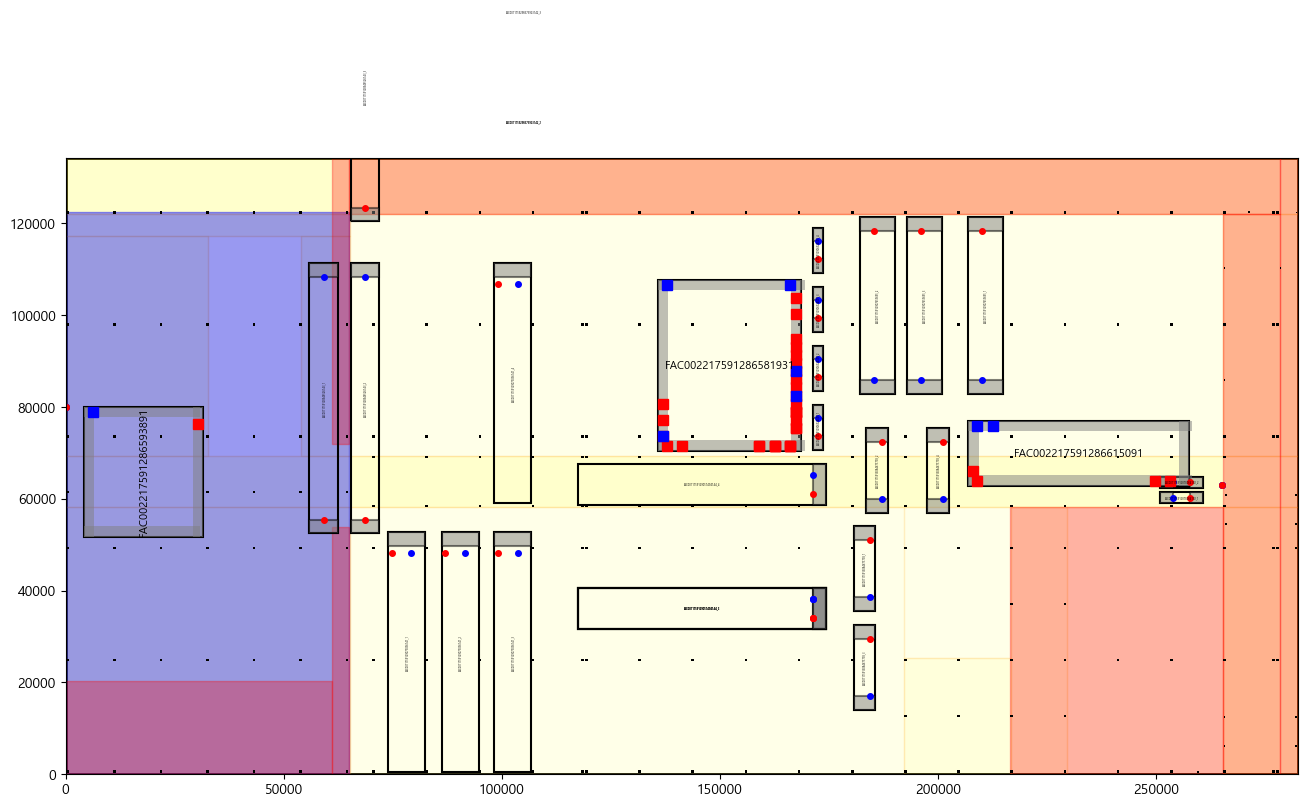

In [ ]:
sotrage_en_x, sotrage_en_y, sotrage_exi_x, sotrage_exi_y=plt_f_4()

In [ ]:
sfc_to

{10: ['FAC001175912878064192', 'FAC0011759129057494144'],
 8: ['FAC0011759129057494144',
  'FAC001175912906524597',
  'FAC0011759129075056141',
  'FAC001175912907655695',
  'FAC001175913084675798',
  'FAC002217591286615091'],
 9: ['FAC0011759128948526143']}

In [ ]:
sotrage_en_x

{8: [np.float64(136914.0),
  np.float64(167538.0),
  np.float64(167538.0),
  np.float64(166119.0),
  np.float64(137799.0)],
 9: [np.float64(6349.0)],
 10: [np.float64(209016.0), np.float64(212556.0)]}

In [ ]:
df_result_2=df_result.copy()
df_result_2 = df_result_2[df_result_2['type'] != 'storage'].copy()
storage_io_map_by_index={}
pairs = []
for i in df_selected.index:
    if df_selected.loc[i,'type']!='storage':
        continue
    
    new_row = {"설비Group": df_selected.loc[i,'설비Group'], "설비번호": 0, "center_X": X[i],"center_Y": Y[i],'x': df_selected.loc[i,'Cluster_X'],'y': df_selected.loc[i,'Cluster_Y'],'type':df_selected.loc[i,'type'],'회전':o[i],'k':1}  # df_result_2의 컬럼에 맞춰 dict 작성
    df_result_2.loc[len(df_result_2)] = new_row
    storage_io_map_by_index[len(df_result_2)-1]={}
    list_en=[]

    for j in range(len(sotrage_en_x[i])):
        list_en.append((sotrage_en_x[i][j],sotrage_en_y[i][j]))
    storage_io_map_by_index[len(df_result_2)-1]["entries"]=list_en
    list_ex=[]
        
   
    for j in range(len(sotrage_exi_x[i])):
        list_ex.append((sotrage_exi_x[i][j],sotrage_exi_y[i][j]))
    storage_io_map_by_index[len(df_result_2)-1]["exits"]=list_ex

    fac_list = sfc_to.get(i, [])
    if fac_list:
        
        idx_list = df_result_2.index[df_result_2['설비Group'].isin(fac_list)].tolist()
        pairs.extend((len(df_result_2)-1, b) for b in idx_list)

    
    fac_list = sfc_from.get(i, [])
    if not fac_list:
        continue
    idx_list = df_result_2.index[df_result_2['설비Group'].isin(fac_list)].tolist()
    print(i)
    print(idx_list)
    pairs.extend((b,len(df_result_2)-1) for b in idx_list)    

df_result_2 = pd.concat([df_result_2, df_pre], ignore_index=True)
for c in df_result_2.index:
    d=df_selected[df_selected['설비Group'] == df_result_2.loc[c, '설비Group']]['ent_X'].index[0]
    if df_selected.loc[d,'processGroup']=='dock':
        df_result_2.loc[c,'type']='dock'

# for i in range(len(df_pre)):
#     storage_io_map_by_index[len(df_result_2)-len(df_pre)+i]={}
#     storage_io_map_by_index[len(df_result_2)-len(df_pre)+i]["entries"]=[(df_pre.loc[i,'center_X'],df_pre.loc[i,'center_Y'])]
#     storage_io_map_by_index[len(df_result_2)-len(df_pre)+i]["exits"]=[(df_pre.loc[i,'center_X'],df_pre.loc[i,'center_Y'])]

8
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 24, 25, 26]
9
[31]
10
[29]


In [ ]:
df_pre

,설비Group,설비번호,center_X,center_Y,x,y,type,회전,k,대칭
0,FAC00317591286532431,0,265050,63050,100,100,dockIn,0,0,0
1,FAC00317591286544112,0,51,80050,100,100,dockOut,0,0,0


In [ ]:
group_to_indices = (
    df_result_2
      .reset_index()
      .groupby('설비Group')['index']
      .apply(list)
      .to_dict()
)

dock_groups = set(df_result_2.loc[df_result_2['type'].eq('dock'), '설비Group'].unique())

pairs_3 = []
seen = set()

# 2) group_matrix 순회
for r_name, row in group_matrix.iterrows():
    for c_name, val in row.items():
        if val != 1:
            continue

        # 해당 그룹이 df_result_2에 없으면 스킵
        r_idxs = group_to_indices.get(r_name, [])
        c_idxs = group_to_indices.get(c_name, [])
        if not r_idxs or not c_idxs:
            continue

        # 3) dock가 행에 있으면 (a,b) = (dock, other)
        if r_name in dock_groups and c_name not in dock_groups:
            for a in r_idxs:          # a: dock 인덱스(행)
                for b in c_idxs:      # b: 상대 설비 인덱스(열)
                    if (a, b) not in seen:
                        seen.add((a, b))
                        pairs_3.append((a, b))

        # 4) dock가 열에 있으면 (b,a) = (dock, other)를 열-우선 기준으로 뒤집기
        if c_name in dock_groups and r_name not in dock_groups:
            for b in c_idxs:          # b: dock 인덱스(열)
                for a in r_idxs:      # a: 상대 설비 인덱스(행)
                    if (b, a) not in seen:
                        seen.add((b, a))
                        pairs_3.append((a, b))

In [ ]:
import pandas as pd
from itertools import product

def build_flows_from_matrix(group_matrix: pd.DataFrame,
                            df_result_2: pd.DataFrame,
                            skip_storage: bool = True) -> list[tuple[int, int]]:
    """
    group_matrix: 행/열 라벨이 설비명(FAC...)이고 값이 0/1인 정방 행렬 DataFrame
    df_result_2: ['설비Group','type', ...] 컬럼을 가지며, 인덱스가 설비 인스턴스(행 번호)
    skip_storage: True이면 type == 'storage' 인 설비 인덱스는 출발/도착 모두 제외

    반환: (source_index, target_index) 쌍의 리스트
    """
    # 1) storage 제외(옵션)
    if skip_storage:
        df_nodes = df_result_2[df_result_2['type'] != 'storage'].copy()
    else:
        df_nodes = df_result_2.copy()

    # 2) 설비명(설비Group) -> df 인덱스 리스트 매핑
    #    reset_index로 원래 인덱스를 보존한 뒤 groupby
    idx_map = (
        df_nodes.reset_index()
                .groupby('설비Group')['index']
                .apply(list)
                .to_dict()
    )

    # 3) group_matrix에서 값이 1인 (src_name, dst_name) 페어 추출
    #    인덱스/컬럼 라벨이 중복일 수 있으므로 stack 사용
    #    (값이 1인 것만 필터)
    edges = (
        group_matrix.stack()
                    .reset_index(name='val')
    )
    edges.columns = ['src_name', 'dst_name', 'val']
    edges = edges[edges['val'] == 1]

    flows = []

    # 4) 각 (설비명, 설비명) 간선을 실제 df 인덱스 쌍으로 확장
    for _, row in edges.iterrows():
        sname = row['src_name']
        dname = row['dst_name']

        s_indices = idx_map.get(sname, [])
        d_indices = idx_map.get(dname, [])

        # 한쪽이라도 해당 설비명이 (storage 제외 등으로) 없으면 스킵
        if not s_indices or not d_indices:
            continue

        # 카르테시안 곱으로 모든 인덱스 쌍 생성
        flows.extend(product(s_indices, d_indices))

    # 5) 중복 제거 및 정렬(원하면)
    flows = sorted(set(flows))

    return flows

# ---------------------------
# 사용 예시
flows= build_flows_from_matrix(group_matrix, df_result_2, skip_storage=True)
pairs = pairs + flows+pairs_3

In [ ]:
# rows = []
# for c in df_result.index:
#     if df_result.loc[c,'type']=='storage':
#         continue
#     if df_result.loc[c,'회전'] == 1:
#         w=df_result.loc[c,'y'] # rotated
#         h=df_result.loc[c,'x']
#     else:
#         w=df_result.loc[c,'x'] # rotated
#         h=df_result.loc[c,'y'] 

#     d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]

#     ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
#     ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
#     ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
#     ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2

#     if o[d]==0 and di[d]==0:
#         en_x=ori_en_x
#         en_y=ori_en_y
#         ex_x=ori_ex_x
#         ex_y=ori_ex_y

#     elif o[d]==1 and di[d]==0:
#         en_x=ori_en_y
#         en_y=-ori_en_x
#         ex_x=ori_ex_y
#         ex_y=-ori_ex_x 

#     elif o[d]==0 and di[d]==1:
#         en_x=-ori_en_x
#         en_y=-ori_en_y
#         ex_x=-ori_ex_x
#         ex_y=-ori_ex_y

#     else:
#         en_x=-ori_en_y
#         en_y=ori_en_x
#         ex_x=-ori_ex_y
#         ex_y=ori_ex_x 

    
    
#     rows.append({
#         '설비Group': df_result.loc[c, '설비Group'],
#         '설비번호':df_result.loc[c, '설비번호'],
#         'x': df_result.loc[c, 'center_X'] + en_x,
#         'y': df_result.loc[c, 'center_Y'] + en_y,
#         'pathwidth': df_selected.loc[d,'pathWidth'],
#         'type': 0
#     })
    
#     rows.append({
#         '설비Group': df_result.loc[c, '설비Group'],
#         '설비번호':df_result.loc[c, '설비번호'],
#         'x': df_result.loc[c, 'center_X'] + en_x,
#         'y': df_result.loc[c, 'center_Y'] + en_y,
#         'pathwidth': df_selected.loc[d,'pathWidth'],
#         'type': 1
#     })
# for c in df_pre.index:
#     d=df_selected_copy[df_selected_copy['설비Group'] == df_pre.loc[c, '설비Group']].index[0]
#     rows.append({
#         '설비Group': df_pre.loc[c, '설비Group'],
#         '설비번호':df_pre.loc[c, '설비번호'],
#         'x': df_pre.loc[c, 'center_X'],
#         'y': df_pre.loc[c, 'center_Y'],
#         'pathwidth': df_selected_copy.loc[d,'pathWidth'],
#         'type': 0
#     })   

#     rows.append({
#         '설비Group': df_pre.loc[c, '설비Group'],
#         '설비번호':df_pre.loc[c, '설비번호'],
#         'x': df_pre.loc[c, 'center_X'],
#         'y': df_pre.loc[c, 'center_Y'],
#         'pathwidth': df_selected_copy.loc[d,'pathWidth'],
#         'type': 1
#     })       

    
# df_en_ex = pd.DataFrame(rows, columns=['설비Group','설비번호' ,'x', 'y', 'pathwidth', 'type'])
# df_en_ex

In [ ]:
def _add_path_segment_patch(ax, a, b, path_width, **kwargs):
    x1, y1 = a; x2, y2 = b
    r = path_width / 2.0
    if y1 == y2:  # 수평
        x_min, x_max = sorted([x1, x2])
        ax.add_patch(
            patches.Rectangle((x_min, y1 - r), x_max - x_min, path_width, **kwargs)
        )
    elif x1 == x2:  # 수직
        y_min, y_max = sorted([y1, y2])
        ax.add_patch(
            patches.Rectangle((x1 - r, y_min), path_width, y_max - y_min, **kwargs)
        )
    else:
        raise ValueError("Only axis-aligned segments are supported (Manhattan).")

# 코너·끝점 빈틈을 메우는 정사각형 캡
def _add_path_vertex_cap(ax, p, path_width, **kwargs):
    x, y = p
    r = path_width / 2.0
    ax.add_patch(patches.Rectangle((x - r, y - r), path_width, path_width, **kwargs))

In [ ]:
def plt_f_6( path_total, path_width,draw_centerline, path_alpha,path_AA,path_BB,a_as_band, aa_width, aa_alpha):     
    dims = data["factoryDimensions"]
#     mezz_areas = data["mezzanineAreas"]
    restricted_areas = data["restrictedAreas"]
    column_areas = data["columnAreas"]
    ceiling_areas= data["areaCeilings"]
    weight_areas=data["areaWeights"]
    dry_areas=data["areaDry"]
    fig, ax = plt.subplots(figsize=(15.9, 8))


    factory_rect = plt.Rectangle(
        (0, 0),
        dims["width"],
        dims["height"],
        linewidth=2,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(factory_rect)


    for area in ceiling_areas:
        alpha = 1/area["ceilingHeight"]


        mezz_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='orange',
            facecolor='yellow',
            alpha=alpha
        )
        ax.add_patch(mezz_rect)

    for area in weight_areas:
        weight_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='blue',
            facecolor='blue',
            alpha=0.4
        )
        ax.add_patch(weight_rect)

        
        
    for area in dry_areas:
        dry_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='purple',
            facecolor='purple',
            alpha=0.4
        )
        ax.add_patch(dry_rect)
        
    for area in restricted_areas:
        restr_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=1,
            edgecolor='red',
            facecolor='red',
            alpha=0.3
        )
        ax.add_patch(restr_rect)


    for area in column_areas:
        col_rect = plt.Rectangle(
            (area["x"], area["y"]),
            area["width"],
            area["height"],
            linewidth=0,
            edgecolor='black',
            facecolor='black',
            alpha=1.0
        )
        ax.add_patch(col_rect)

    dims_ = {}
    dims_2={}

    for c in df_result.index:
        

        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            dims_[c] = (df_result.loc[c,'y'],df_result.loc[c,'x'])  # rotated
        else:
            dims_[c] = (df_result.loc[c,'x'], df_result.loc[c,'y'])     

        w, h = dims_[c]
        
        llx = df_result.loc[c,'center_X'] - w/2
        lly = df_result.loc[c,'center_Y'] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        if df_selected.loc[d,'processGroup']=='dock':
            continue          
        if o[d]==1:
            if di[d]==0:
                dims_2[c]=(total_expand[d][2],total_expand[d][3],total_expand[d][1],total_expand[d][0])
            else:
                dims_2[c]=(total_expand[d][3],total_expand[d][2],total_expand[d][0],total_expand[d][1])
        else:
            if di[d]==0:
                dims_2[c]=(total_expand[d][0],total_expand[d][1],total_expand[d][2],total_expand[d][3])
            else:
                dims_2[c]=(total_expand[d][1],total_expand[d][0],total_expand[d][3],total_expand[d][2])
        x_1,x_2,y_1,y_2= dims_2[c]

        if x_1==1:
            llx_2 = df_result.loc[c,'center_X'] + w/2-df_selected.loc[d,'pathWidth']
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), df_selected.loc[d,'pathWidth'], h, fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)

        if x_2==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), df_selected.loc[d,'pathWidth'], h, fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)       
            ax.add_patch(rect_2)     

        if y_1==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] + h/2-df_selected.loc[d,'pathWidth']
            rect_2 = patches.Rectangle((llx_2, lly_2), w, df_selected.loc[d,'pathWidth'], fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)   

        if y_2==1:
            llx_2 = df_result.loc[c,'center_X'] - w/2
            lly_2 = df_result.loc[c,'center_Y'] - h/2
            rect_2 = patches.Rectangle((llx_2, lly_2), w, df_selected.loc[d,'pathWidth'], fill=True, linewidth=1.5,edgecolor='black',facecolor='gray',alpha=0.5)    
            ax.add_patch(rect_2)                

        fs=2
        if w>=h:
            ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs)
        else:
            ax.text(df_result.loc[c,'center_X'], df_result.loc[c,'center_Y'], f"{df_result.loc[c, '설비Group']}_{df_result.loc[c, '설비번호']+1}", ha='center', va='center', fontsize=fs,rotation=90)

    
    for c in df_result.index:
        if df_result.loc[c,'type']=='storage':
            continue
        if df_result.loc[c,'회전'] == 1:
            w=df_result.loc[c,'y'] # rotated
            h=df_result.loc[c,'x']
        else:
            w=df_result.loc[c,'x'] # rotated
            h=df_result.loc[c,'y'] 
            
        d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
        
        
            
        ori_en_x=df_selected.loc[d,'ent_X']-df_result.loc[c,'x']/2
        ori_en_y=df_selected.loc[d,'ent_Y']-df_result.loc[c,'y']/2
        ori_ex_x=df_selected.loc[d,'exi_X']-df_result.loc[c,'x']/2
        ori_ex_y=df_selected.loc[d,'exi_Y']-df_result.loc[c,'y']/2
        
        if o[d]==0 and di[d]==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif o[d]==1 and di[d]==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif o[d]==0 and di[d]==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_result.loc[c,'center_X'] + en_x, df_result.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_result.loc[c,'center_X'] + ex_x, df_result.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)

    dims_ = {}
    
    for c in df_selected.index:
        if df_selected.loc[c,'type']!='storage':
            continue
        if o[c] == 1:
            dims_[c] = (H0[c], W0[c])  # rotated

        else:
            dims_[c] = (W0[c], H0[c])  # original 
            


        w, h = dims_[c]

        llx = X[c] - w/2
        lly = Y[c] - h/2
        rect = patches.Rectangle((llx, lly), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        

        
        if o[c]==0:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8,rotation=90)
        else:
            ax.text(X[c], Y[c], df_selected.loc[c,'설비Group'], ha='center', va='center', fontsize=8)
        
#         for i in data['facilityGroups']:
#             if i['groupId']=='FAC00221757674711540124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               

#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='red', markersize=6)                  
#             elif i['groupId']=='FAC00221757674710411124':
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(4):
#                         if j==3:
#                             col_='blue'
#                         else:
#                             col_='red'
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*(4-1)+4*j*shuttleInport[0]['height'], marker='s', color=col_, markersize=6)               

#                     for j in range(2):
#                         ax.plot(llx+w, Y[c]-2*shuttleInport[0]['height']*(2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)                  
#             else:
#                 if i['groupId']==df_selected.loc[c,'설비Group']:
#                     for j in range(int((len(i['facilities'])-1)/2)):
#                         ax.plot(llx, Y[c]-2*shuttleInport[0]['height']*((len(i['facilities'])-1)/2-1)+4*j*shuttleInport[0]['height'], marker='s', color='blue', markersize=6)               


#                     ax.plot(X[c]+w/2, Y[c]-h/2+4*shuttleInport[0]['height'], marker='s', color='red', markersize=6)  


        



    for key,value in boundary_X.items():
        for j in range(len(to_selected[key])):
             for i in range(len(to_selected[key][j])):             
                ax.plot(value[to_selected[key][j][i]],boundary_Y[key][to_selected[key][j][i]], marker='s', color='red', markersize=7)
        

    for key,value in boundary_X.items():
        for j in range(len(from_selected[key])):
             for i in range(len(from_selected[key][j])):             
                ax.plot(value[from_selected[key][j][i]],boundary_Y[key][from_selected[key][j][i]], marker='s', color='blue', markersize=7)
        
    for c in df_pre.index:
        if df_pre.loc[c,'설비Group']=='FAC001175574169193039' or df_pre.loc[c,'설비Group']=='FAC001175574169193039_':
            continue
        if df_pre.loc[c,'회전'] == 1:
            w=df_pre.loc[c,'y'] # rotated
            h=df_pre.loc[c,'x']
        else:
            w=df_pre.loc[c,'x'] # rotated
            h=df_pre.loc[c,'y'] 
            
        d=df_selected_copy_2[df_selected_copy_2['설비Group'] == df_pre.loc[c, '설비Group']]['ent_X'].index[0]
        
        ori_en_x=df_selected_copy_2.loc[d,'ent_X']-df_pre.loc[c,'x']/2
        ori_en_y=df_selected_copy_2.loc[d,'ent_Y']-df_pre.loc[c,'y']/2
        ori_ex_x=df_selected_copy_2.loc[d,'exi_X']-df_pre.loc[c,'x']/2
        ori_ex_y=df_selected_copy_2.loc[d,'exi_Y']-df_pre.loc[c,'y']/2
        
        if df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_x
            en_y=ori_en_y
            ex_x=ori_ex_x
            ex_y=ori_ex_y
            
        elif df_pre.loc[c, '회전']==1 and df_pre.loc[c, 'k']==0:
            en_x=ori_en_y
            en_y=-ori_en_x
            ex_x=ori_ex_y
            ex_y=-ori_ex_x 
        
        elif df_pre.loc[c, '회전']==0 and df_pre.loc[c, 'k']==1:
            en_x=-ori_en_x
            en_y=-ori_en_y
            ex_x=-ori_ex_x
            ex_y=-ori_ex_y
        
        else:
            en_x=-ori_en_y
            en_y=ori_en_x
            ex_x=-ori_ex_y
            ex_y=ori_ex_x 

        
         
        # 입구 (entry) 점 그리기: 파란 점
        ax.plot(df_pre.loc[c,'center_X'] + en_x, df_pre.loc[c,'center_Y'] + en_y,
                marker='o', color='blue', markersize=4)

        # 출구 (exit) 점 그리기: 초록 점
        ax.plot(df_pre.loc[c,'center_X'] + ex_x, df_pre.loc[c,'center_Y'] + ex_y,
                marker='o', color='red', markersize=4)              
    to_cl_un={}
    to_cl_up={}
    for i in range(len(s_un)):
        cl_un=-999999999
        cl_up=999999999
        for c in range(s_un[i],s_up[i]+1):
            
            if o[c]==0:
                dims_bo=[W0[c],H0[c]]
            else:
                dims_bo=[H0[c],W0[c]]  
                
            if cl_un<=Y[c]-dims_bo[1]/2:
                cl_un=Y[c]-dims_bo[1]/2
                
            if cl_up>=Y[c]+dims_bo[1]/2:
                cl_up=Y[c]+dims_bo[1]/2
            
        for c in range(s_un[i],s_up[i]+1):  
            to_cl_un[c]=cl_un
            to_cl_up[c]=cl_up
            
    for c in df_selected.index:

        if df_selected.loc[c,"type"]!="storage":
            continue
        if o[c]==0:
            dims_bo=[W0[c],H0[c]]
        else:
            dims_bo=[H0[c],W0[c]]
        i=0  
        
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2:
                break
            X_b=X[c]-dims_bo[0]/2
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['height']*i
            i+=1
            if abs(X_b-mezz_areas[1]['x'])<=2000 and Y_b>=to_cl_un[c] and Y_b<=to_cl_up[c]:
                continue
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
        i=0  
        while True:
            if Y[c]-dims_bo[1]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=Y[c]+dims_bo[1]/2:
                break

            X_b=X[c]+dims_bo[0]/2-shuttleInport[0]['width']
            Y_b=Y[c]-dims_bo[1]/2+shuttleInport[0]['height']*i
            i+=1
            if abs(X_b-mezz_areas[1]['x'])<=5000 and Y_b>=to_cl_un[c] and Y_b<=to_cl_up[c]:
                continue
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['width'], shuttleInport[0]['height'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
            
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['height']*i
            Y_b=Y[c]+dims_bo[1]/2-shuttleInport[0]['width']
            i+=1
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
        i=0      
        while True:
            if X[c]-dims_bo[0]/2+shuttleInport[0]['height']/2+shuttleInport[0]['height']*i>=X[c]+dims_bo[0]/2:
                break
            X_b=X[c]-dims_bo[0]/2+shuttleInport[0]['height']*i
            Y_b=Y[c]-dims_bo[1]/2
            rect = patches.Rectangle((X_b, Y_b), shuttleInport[0]['height'], shuttleInport[0]['width'], fill=True, linewidth=1,facecolor='gray',alpha=0.5)
            ax.add_patch(rect)
            i+=1      
 

    if path_total:

        # 경로별로 색 다르게 주고 싶으면 color 사이클을 쓰거나, 항목마다 'color' 키를 넣어주세요.
        for item in path_total:
            path = item.get('path')
            if not path or len(path) < 2:
                continue

            # ★ 경로별 width: compute_paths_expand_storage에서 넣어둔 'path_width' 사용
            use_width = item.get('path_width', None)
            if use_width is None:
                use_width = float(path_width) if path_width is not None else path_width


            # 1) 두꺼운 경로(좌표계 단위) — 각 경로별 두께 적용
            if use_width and use_width > 0:
                for a, b in zip(path, path[1:]):
                    _add_path_segment_patch(
                        ax, a, b, use_width,   # ← 경로별 두께
                        fill=True, linewidth=0, alpha=path_alpha, zorder=50
                    )
                # 코너·끝점 캡
                _add_path_vertex_cap(ax, path[0], use_width, fill=True, linewidth=0, alpha=path_alpha, zorder=51)
                _add_path_vertex_cap(ax, path[-1], use_width, fill=True, linewidth=0, alpha=path_alpha, zorder=51)
                for i in range(1, len(path)-1):
                    _add_path_vertex_cap(ax, path[i], use_width, fill=True, linewidth=0, alpha=path_alpha, zorder=51)

#             # 2) 중심선(옵션)
#             if draw_centerline:
#                 xs = [p[0] for p in path]; ys = [p[1] for p in path]
#                 ax.plot(xs, ys, linewidth=1.2, zorder=55)
#                 # s = item.get('start'); g = item.get('goal')
#                 # ax.text(xs[0], ys[0], f"{s}->{g}", fontsize=7, zorder=60)
    if path_BB:
        # 기본은 매개변수 aa_width 사용 (필요 시 seg별 'width' 키를 넣어서 덮어쓰기 가능)
        for seg in path_BB:
            a = seg['start']; b = seg['end']
            seg_width = seg.get('width', aa_width if aa_width is not None else path_width)
            if abs(a[0]-b[0]) < 1e-6 or abs(a[1]-b[1]) < 1e-6:
                _add_path_segment_patch(
                    ax, a, b, float(seg_width),
                    fill=True, linewidth=0, alpha=aa_alpha, zorder=200,
                    color='orange'
                )
            else:
                ax.plot([a[0], b[0]], [a[1], b[1]],
                        color='orange', linewidth=2.0, zorder=201, alpha=aa_alpha)
    if path_AA:
        # 기본은 매개변수 aa_width 사용 (필요 시 seg별 'width' 키를 넣어서 덮어쓰기 가능)
        for seg in path_AA:
            a = seg['start']; b = seg['end']
            seg_width = seg.get('width', aa_width if aa_width is not None else path_width)
            if abs(a[0]-b[0]) < 1e-6 or abs(a[1]-b[1]) < 1e-6:
                _add_path_segment_patch(
                    ax, a, b, float(seg_width),
                    fill=True, linewidth=0, alpha=aa_alpha, zorder=200,
                    color='red'
                )
            else:
                ax.plot([a[0], b[0]], [a[1], b[1]],
                        color='red', linewidth=2.0, zorder=201, alpha=aa_alpha)

    ax.set_xlim(0, dims["width"])
    ax.set_ylim(0, dims["height"])



    plt.show()

In [ ]:
df_selected.columns

Index(['설비Group', '설비수량', 'x', 'y', 'facilityHeight', 'facilityWeight', 'dry',
       'UR', 'UL', 'UB', 'UA', 'type', 'placeable', 'processGroup', 'ent_X',
       'ent_Y', 'exi_X', 'exi_Y', 'lineCount', 'pathWidth', 'Cluster_X',
       'Cluster_Y', 'cluster_UR', 'cluster_UL', 'cluster_UB', 'cluster_UA',
       'Clear_R', 'Clear_L', 'Clear_B', 'Clear_A'],
      dtype='object')

In [ ]:
# for c in df_result.index:
#     d=df_selected[df_selected['설비Group'] == df_result.loc[c, '설비Group']]['ent_X'].index[0]
#     if df_selected.loc[d,'processGroup']=='dock':
#         df_result = df_result.drop(index=c)

In [ ]:
# -*- coding: utf-8 -*-
import math
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

column_areas = data["columnAreas"]
restricted_areas = data["restrictedAreas"]
EPS = 1e-6
def _edge_dir(u, v):
    # u=(x1,y1), v=(x2,y2)
    if u[1] == v[1]:  # y 같은면 수평
        return 'H'
    elif u[0] == v[0]:  # x 같은면 수직
        return 'V'
    else:
        return None  # (맨해튼만 다룸)
def _is_dock(df, idx):
    val = df.loc[idx].get('type', '')
    s = str(val).strip().lower()              # 좌우 공백 제거 + 소문자화
    return ('dock' in s)                      # 'dock', 'dock_in', 'Dock ' 등 모두 허용

def _center_pt(df, idx):
    return (float(df.loc[idx,'center_X']), float(df.loc[idx,'center_Y']))

def _manhattan_L(a, b):
    sx, sy = a; gx, gy = b
    path = [(sx, sy)]
    if sx != gx and sy != gy:
        path.append((gx, sy))   # 또는 (sx, gy) — 길이는 동일
    path.append((gx, gy))
    return path
def _path_width_for_start(df_result, start_idx, default_width=2500.0):
    """
    start_idx의 설비Group과 같은 df_selected 행의 'pathWidth'를 찾아 반환.
    매칭이 없거나 값이 비어있으면 default_width 사용.
    """
    try:
        group_id = df_result.loc[start_idx, '설비Group']
    except KeyError:
        return float(default_width)

    sel = df_selected[df_selected['설비Group'] == group_id]
    if sel.empty:
        return float(default_width)

    row = sel.iloc[0]
    pw = row.get('pathWidth', default_width)
    try:
        return float(pw)
    except Exception:
        print("Fallback !!!!")
        return float(default_width)
def _io_single(df, idx):
    # 기존 로직 그대로 (start는 exit, goal은 entry 쓸 것)
    d = df_selected[df_selected['설비Group'] == df_result.loc[idx, '설비Group']]['ent_X'].index[0]
    ori_en_x = df_selected.loc[d,'ent_X'] - df_result.loc[idx,'x']/2
    ori_en_y = df_selected.loc[d,'ent_Y'] - df_result.loc[idx,'y']/2
    ori_ex_x = df_selected.loc[d,'exi_X'] - df_result.loc[idx,'x']/2
    ori_ex_y = df_selected.loc[d,'exi_Y'] - df_result.loc[idx,'y']/2
    if o[d]==0 and di[d]==0:
        en_x,en_y,ex_x,ex_y = ori_en_x,ori_en_y,ori_ex_x,ori_ex_y
    elif o[d]==1 and di[d]==0:
        en_x,en_y,ex_x,ex_y = ori_en_y,-ori_en_x,ori_ex_y,-ori_ex_x
    elif o[d]==0 and di[d]==1:
        en_x,en_y,ex_x,ex_y = -ori_en_x,-ori_en_y,-ori_ex_x,-ori_ex_y
    else:
        en_x,en_y,ex_x,ex_y = -ori_en_y,ori_en_x,-ori_ex_y,ori_ex_x
    cx, cy = df.loc[idx,'center_X'], df.loc[idx,'center_Y']
    entry = (float(cx+en_x), float(cy+en_y))
    exit_  = (float(cx+ex_x), float(cy+ex_y))
    return entry, exit_

# ==== ADD: 다중 IO 수집기 ====
# (선택) 외부 주입 훅: 인덱스/그룹 기준으로 여러 IO를 지정할 수 있음
# 예시 형태:
# storage_io_map_by_index = { 4: {"entries":[(x1,y1),...], "exits":[(x2,y2),...]} }
# storage_io_map_by_group = { "FAC002...": {"entries":[...], "exits":[...]} }
try:
    storage_io_map_by_index
except NameError:
    storage_io_map_by_index = {}
try:
    storage_io_map_by_group
except NameError:
    storage_io_map_by_group = {}

def _collect_io_points(df, idx):
    row = df.loc[idx]
    gid = row['설비Group']
    if row.get('type', None) == 'storage' or str(row.get('type','')) == 'storage':
        # 1) index 기반 오버라이드
        if idx in storage_io_map_by_index:
            m = storage_io_map_by_index[idx]
            return {
                "entries": list(m.get("entries", [])),
                "exits":   list(m.get("exits",   [])),
            }
        # 2) group 기반 오버라이드
        if gid in storage_io_map_by_group:
            m = storage_io_map_by_group[gid]
            return {
                "entries": list(m.get("entries", [])),
                "exits":   list(m.get("exits",   [])),
            }
    # 3) fallback: 기존 1쌍
    en, ex = _io_single(df, idx)
    return {"entries": [en], "exits": [ex]}
def lane_key(a, b, bundle_band=800.0, eps=EPS):
    """
    가로 간선: y를, 세로 간선: x를 bundle_band로 버킷팅해 같은 '차선'으로 묶는다.
    bundle_band가 좌표 스케일에 맞게 200~2000 정도가 실무적으로 적당.
    """
    x1, y1 = a; x2, y2 = b
    if abs(y1 - y2) <= eps:  # horizontal
        y = (y1 + y2) / 2.0
        return ('H', round(y / bundle_band))
    if abs(x1 - x2) <= eps:  # vertical
        x = (x1 + x2) / 2.0
        return ('V', round(x / bundle_band))
    return None  # (맨해튼만 쓰니 거의 없음)
# ============ 사각형 생성 ============
def rect_from_row(row, clearance=0.0):
    cx, cy = float(row['center_X']), float(row['center_Y'])
    rot = int(row['회전'])
    if rot == 0:
        half_w = float(row['x'])/2.0 + clearance
        half_h = float(row['y'])/2.0 + clearance
    else:
        half_w = float(row['y'])/2.0 + clearance
        half_h = float(row['x'])/2.0 + clearance
    return (cx - half_w, cy - half_h, cx + half_w, cy + half_h)

def rect_from_area(area, clearance=0.0):
    xmin = float(area['x']) - clearance
    ymin = float(area['y']) - clearance
    xmax = float(area['x'] + area['width']) + clearance
    ymax = float(area['y'] + area['height']) + clearance
    return (xmin, ymin, xmax, ymax)

# ============ 충돌 판정 ============
def point_in_rect(px, py, rect, allow_touch=True):
    xmin, ymin, xmax, ymax = rect
    if allow_touch:
        return (xmin < px < xmax) and (ymin < py < ymax)
    else:
        return (xmin <= px <= xmax) and (ymin <= py <= ymax)

def segment_intersects_rect(p1, p2, rect, allow_touch=True):
    (x1, y1), (x2, y2) = p1, p2
    xmin, ymin, xmax, ymax = rect
    if x1 == x2:  # vertical
        x = x1
        x_inside = (xmin < x < xmax) if allow_touch else (xmin <= x <= xmax)
        if not x_inside:
            return False
        seg_ymin, seg_ymax = min(y1,y2), max(y1,y2)
        return not ((seg_ymax <= ymin or seg_ymin >= ymax) if allow_touch
                    else (seg_ymax < ymin or seg_ymin > ymax))
    elif y1 == y2:  # horizontal
        y = y1
        y_inside = (ymin < y < ymax) if allow_touch else (ymin <= y <= ymax)
        if not y_inside:
            return False
        seg_xmin, seg_xmax = min(x1,x2), max(x1,x2)
        return not ((seg_xmax <= xmin or seg_xmin >= xmax) if allow_touch
                    else (seg_xmax < xmin or seg_xmin > xmax))
    else:
        raise ValueError("Only axis-aligned segments are supported.")

def segment_clear(p1, p2, obstacles, allow_touch=True):
    return all(not segment_intersects_rect(p1, p2, r, allow_touch=allow_touch) for r in obstacles)

# ============ 규칙(H/V) 기반: IO → 경계 → 포털 ============

def _axis_from_rule(row, io_pt=None):
    """
    일반 설비: (회전 + k == 1) → 'H', 아니면 'V'
    storage: IO 기준으로 설비 밖까지 더 가까운 축(H/V)을 자동 선택
    """
    # storage 우선 규칙
    if 'type' in row and str(row['type']) == 'storage' and io_pt is not None:
        xmin, ymin, xmax, ymax = rect_from_row(row, 0.0)
        x, y = float(io_pt[0]), float(io_pt[1])
        # 사각형 내부로 clamp (수치오차 방지)
        x_c = min(max(x, xmin), xmax)
        y_c = min(max(y, ymin), ymax)
        # 각 축으로 가장 가까운 바깥 변까지 거리
        h_dist = min(abs(x_c - xmin), abs(xmax - x_c))   # 좌/우
        v_dist = min(abs(y_c - ymin), abs(ymax - y_c))   # 하/상
        return 'H' if h_dist <= v_dist else 'V'

    # 일반 규칙 (non-storage)
    return 'H' if int(row['회전']) + int(row['k']) == 1 else 'V'

def _edge_and_portal_from_io(df, idx, io_pt, clearance, allow_touch):
    """
    io_pt에서 규칙 축(H/V) 방향으로만 가장 가까운 변(edge)까지 이동한 후,
    그 바깥으로 (clearance + eps) 만큼 나간 portal 좌표를 반환.
    """
    row = df.loc[idx]
    xmin, ymin, xmax, ymax = rect_from_row(row, 0.0)
    x, y = float(io_pt[0]), float(io_pt[1])

    # 사각형 범위로 clamp (미세 오차 방지)
    x_c = min(max(x, xmin), xmax)
    y_c = min(max(y, ymin), ymax)

    axis = _axis_from_rule(row, io_pt)
    if axis == 'H':
        dl = abs(x_c - xmin); dr = abs(xmax - x_c)
        if dl <= dr:
            edge = (xmin, y_c); normal = (-1.0, 0.0)
        else:
            edge = (xmax, y_c); normal = ( 1.0, 0.0)
    else:  # 'V'
        db = abs(y_c - ymin); dt = abs(ymax - y_c)
        if db <= dt:
            edge = (x_c, ymin); normal = (0.0, -1.0)
        else:
            edge = (x_c, ymax); normal = (0.0,  1.0)

    eps_push = 0.0 if allow_touch else 1.0   # 경계 접촉 금지면 1.0만큼 더 밖으로
    push = float(clearance) + eps_push
    portal = (edge[0] + normal[0]*push, edge[1] + normal[1]*push)
    return edge, portal

# ============ 격자 & 그래프 ============
def build_grid_nodes(df, start_idx, goal_idx, clearance=0.0,
                     allow_touch=True, column_areas=None, restricted_areas=None,
                     io_override_start=None, io_override_goal=None):
    obstacles = []
    # 설비: ★ 시작/끝 설비도 포함시켜서, 포털(외곽) 이후 구간은 겹치지 않도록 강제
    for i, row in df.iterrows():
        obstacles.append(rect_from_row(row, clearance))
    if column_areas:
        for col in column_areas:
            obstacles.append(rect_from_area(col, clearance))
    if restricted_areas:
        for ra in restricted_areas:
            obstacles.append(rect_from_area(ra, clearance))

    # --- IO 좌표 확정 (override 있으면 그걸 사용) ---
    if io_override_start is None:
        # start는 '출구'를 써야 하므로 single fallback에서 exit 사용
        _en_s, _ex_s = _io_single(df, start_idx)
        s_io = _ex_s
    else:
        s_io = (float(io_override_start[0]), float(io_override_start[1]))

    if io_override_goal is None:
        # goal은 '입구'를 써야 하므로 single fallback에서 entry 사용
        _en_g, _ex_g = _io_single(df, goal_idx)
        g_io = _en_g
    else:
        g_io = (float(io_override_goal[0]), float(io_override_goal[1]))

    # 규칙(H/V)에 따라 IO→edge→portal
    s_edge, s_portal = _edge_and_portal_from_io(df, start_idx, s_io, clearance, allow_touch)
    g_edge, g_portal = _edge_and_portal_from_io(df, goal_idx, g_io, clearance, allow_touch)

    # 축 후보 (포털 + 장애물 경계)
    Xs, Ys = {s_portal[0], g_portal[0]}, {s_portal[1], g_portal[1]}
    for i, row in df.iterrows():
        xmin, ymin, xmax, ymax = rect_from_row(row, clearance)
        Xs.update([xmin, xmax]); Ys.update([ymin, ymax])
    if column_areas:
        for col in column_areas:
            xmin, ymin, xmax, ymax = rect_from_area(col, clearance)
            Xs.update([xmin, xmax]); Ys.update([ymin, ymax])
    if restricted_areas:
        for ra in restricted_areas:
            xmin, ymin, xmax, ymax = rect_from_area(ra, clearance)
            Xs.update([xmin, xmax]); Ys.update([ymin, ymax])

    X, Y = sorted(Xs), sorted(Ys)

    nodes, node_set = [], set()
    for x in X:
        for y in Y:
            inside = any(point_in_rect(x, y, r, allow_touch=allow_touch) for r in obstacles)
            if not inside:
                nodes.append((x, y)); node_set.add((x, y))

    if s_portal not in node_set:
        nodes.append(s_portal); node_set.add(s_portal)
    if g_portal not in node_set:
        nodes.append(g_portal); node_set.add(g_portal)

    extra = {
        "s_io": s_io, "s_edge": s_edge, "s_portal": s_portal,
        "g_portal": g_portal, "g_edge": g_edge, "g_io": g_io,
    }
    return nodes, obstacles, s_portal, g_portal, extra

def build_edges(nodes, obstacles, allow_touch=True):
    by_x, by_y = {}, {}
    for x, y in nodes:
        by_x.setdefault(x, []).append((x, y))
        by_y.setdefault(y, []).append((x, y))
    edges = {n: [] for n in nodes}
    for x, pts in by_x.items():
        pts = sorted(pts, key=lambda p: p[1])
        for a, b in zip(pts, pts[1:]):
            if segment_clear(a, b, obstacles, allow_touch=allow_touch):
                w = abs(b[1]-a[1]); edges[a].append((b, w)); edges[b].append((a, w))
    for y, pts in by_y.items():
        pts = sorted(pts, key=lambda p: p[0])
        for a, b in zip(pts, pts[1:]):
            if segment_clear(a, b, obstacles, allow_touch=allow_touch):
                w = abs(b[0]-a[0]); edges[a].append((b, w)); edges[b].append((a, w))
    return edges

# ============ 최단경로 ============
def dijkstra_with_bundling(edges, start, goal,
                           usage_edges=None, usage_lanes=None,
                           share_bonus=0.3, min_weight_factor=0.25,
                           bundle_band=800.0,
                           turn_penalty=0.0,
                           oppose_penalty_lane=0.0,
                           usage_lanes_dir=None

                          ):
    """
    상태 = (node, prev_dir) 로 확장하여 꺾일 때마다 turn_penalty 가산.
    prev_dir ∈ {None, 'H', 'V'}
    """
    if usage_edges is None: usage_edges = {}
    if usage_lanes is None: usage_lanes = {}
    if usage_lanes_dir is None: usage_lanes_dir = {}

    def discounted_len(u, v, base_len):
        # 번들링 할인
        k_edge = usage_edges.get((u, v), 0)
        lk = lane_key(u, v, bundle_band=bundle_band)
        k_lane = usage_lanes.get(lk, 0) if lk is not None else 0
        k = k_edge + k_lane
        if k <= 0 or share_bonus <= 0.0:
            return base_len
        discount = min(share_bonus * k, 1.0 - min_weight_factor)
        return base_len * (1.0 - discount)

    INF = 1e30
    # dist[(node, prev_dir)]
    dist = {}
    prev = {}  # prev[(node, dir)] = (prev_node, prev_dir)
    import heapq
    pq = []

    # 시작: prev_dir=None 상태에서 0
    dist[(start, None)] = 0.0
    heapq.heappush(pq, (0.0, start, None))

    best_goal_key = None

    while pq:
        d, u, pd = heapq.heappop(pq)
        if d != dist.get((u, pd), INF):
            continue
        if u == goal:
            best_goal_key = (u, pd)
            break

        for v, base_len in edges[u]:
            step = discounted_len(u, v, base_len)
            ndir = _edge_dir(u, v)

            # ★ 방향 부호(+1/-1)
            dir_sign = None
            if ndir == 'H':
                dir_sign = +1 if v[0] > u[0] else -1
            elif ndir == 'V':
                dir_sign = +1 if v[1] > u[1] else -1

            # ★ 역방향 차선 패널티
            extra_opp = 0.0
            if ndir is not None:
                lk = lane_key(u, v, bundle_band=bundle_band)
                if lk is not None:
                    # 반대 방향에 누적 사용이 있으면 패널티
                    opp_key = (lk, -dir_sign)
                    if usage_lanes_dir.get(opp_key, 0) > 0:
                        extra_opp += float(oppose_penalty_lane)

            # 기존 꺾임 패널티
            extra_turn = 0.0 if (pd is None or ndir is None or pd == ndir) else float(turn_penalty)

            nd = d + step + extra_turn + extra_opp
            key = (v, ndir)
            if nd < dist.get(key, INF):
                dist[key] = nd
                prev[key] = (u, pd)
                heapq.heappush(pq, (nd, v, ndir))

    if best_goal_key is None:
        # goal로 들어가는 모든 방향 중 최적 선택(우회 종료 케이스)
        cand = [(dist[k], k) for k in dist.keys() if k[0] == goal]
        if not cand:
            return None
        _, best_goal_key = min(cand, key=lambda t: t[0])

    # 경로 복원
    path = []
    cur_key = best_goal_key
    while cur_key in prev or cur_key[0] == start:
        path.append(cur_key[0])
        if cur_key not in prev:
            break
        prev_node, prev_dir = prev[cur_key]
        cur_key = (prev_node, prev_dir)
    path.reverse()
    return path
def simplify_polyline(path):
    if not path or len(path) <= 2: return path
    simp = [path[0]]
    for i in range(1, len(path)-1):
        x0,y0 = simp[-1]; x1,y1 = path[i]; x2,y2 = path[i+1]
        if (x0==x1==x2) or (y0==y1==y2): continue
        simp.append(path[i])
    simp.append(path[-1]); return simp
def _manhattan_L(a, b, prefer_start_axis=None, prefer_goal_axis=None):
    sx, sy = a; gx, gy = b
    if sx == gx or sy == gy:
        return [(sx, sy), (gx, gy)]

    corner_hfirst = (gx, sy)  # start→corner: H, corner→goal: V
    corner_vfirst = (sx, gy)  # start→corner: V, corner→goal: H

    if prefer_goal_axis == 'H':
        corner = corner_vfirst      # goal 인접이 수평
    elif prefer_goal_axis == 'V':
        corner = corner_hfirst      # goal 인접이 수직
    elif prefer_start_axis == 'H':
        corner = corner_hfirst
    elif prefer_start_axis == 'V':
        corner = corner_vfirst
    else:
        corner = corner_hfirst
    return [(sx, sy), corner, (gx, gy)]
# ============ 라우팅 API ============
def route_manhattan(df_result, start_idx=0, goal_idx=1,
                    clearance=0.0, allow_touch=True,
                    column_areas=None, restricted_areas=None,
                    io_override_start=None, io_override_goal=None,
                    usage_edges=None, usage_lanes=None,
                    share_bonus=0.0, min_weight_factor=1.0, bundle_band=800.0,
                    turn_penalty=0.0,oppose_penalty_lane=0.0,usage_lanes_dir=None):   # ← 추가

    # ---- DOCK 특례: dock는 center, 비-dock은 IO; L-경로로 바로 반환 ----
    if _is_dock(df_result, start_idx) or _is_dock(df_result, goal_idx):

        # 시작점
        if _is_dock(df_result, start_idx):
            s_pt = _center_pt(df_result, start_idx)     # dock → center
            start_axis = None
        else:
            # ★ 여기 수정: override가 있으면 반드시 그걸 사용
            if io_override_start is not None:
                s_pt = (float(io_override_start[0]), float(io_override_start[1]))
            else:
                _en_s, _ex_s = _io_single(df_result, start_idx)
                s_pt = _ex_s
            start_axis = _axis_from_rule(df_result.loc[start_idx], s_pt)

        # 목표점
        if _is_dock(df_result, goal_idx):
            g_pt = _center_pt(df_result, goal_idx)      # dock → center
            goal_axis = None
        else:
            if io_override_goal is not None:
                g_pt = (float(io_override_goal[0]), float(io_override_goal[1]))
            else:
                _en_g, _ex_g = _io_single(df_result, goal_idx)
                g_pt = _en_g
            goal_axis = _axis_from_rule(df_result.loc[goal_idx], g_pt)

        path = _manhattan_L(s_pt, g_pt,
                            prefer_start_axis=start_axis,
                            prefer_goal_axis=goal_axis)
        # 안전장치: 첫 점이 s_pt가 아니면 앞에 붙여줌
        if path[0] != s_pt:
            path = [s_pt] + path
        return simplify_polyline(path)
    out = build_grid_nodes(
        df_result, start_idx, goal_idx,
        clearance=clearance, allow_touch=allow_touch,
        column_areas=column_areas, restricted_areas=restricted_areas,
        io_override_start=io_override_start, io_override_goal=io_override_goal
    )
    nodes, obstacles, start, goal, extra = out
    edges = build_edges(nodes, obstacles, allow_touch=allow_touch)

    if (share_bonus and share_bonus > 0.0) or (turn_penalty and turn_penalty > 0.0):
        middle = dijkstra_with_bundling(
            edges, start, goal,
            usage_edges=usage_edges, usage_lanes=usage_lanes,
            share_bonus=share_bonus, min_weight_factor=min_weight_factor,
            bundle_band=bundle_band,
            turn_penalty=turn_penalty,
            # ★ 추가
            oppose_penalty_lane=oppose_penalty_lane,
            usage_lanes_dir=usage_lanes_dir
        )
    else:
        middle = dijkstra(edges, start, goal)
    if middle is None:
        return None
    middle = simplify_polyline(middle)

    s_io, s_edge, s_portal = extra["s_io"], extra["s_edge"], extra["s_portal"]
    g_portal, g_edge, g_io = extra["g_portal"], extra["g_edge"], extra["g_io"]

    full = [s_io, s_edge, s_portal] + middle + [g_portal, g_edge, g_io]
    pruned = [full[0]]
    for p in full[1:]:
        if p != pruned[-1]:
            pruned.append(p)
    return simplify_polyline(pruned)


def route_with_path_width(df_result, start_idx, goal_idx, path_width,
                          allow_touch=True, column_areas=None, restricted_areas=None):
    clearance = float(path_width)/2.0
    return route_manhattan(
        df_result, start_idx=start_idx, goal_idx=goal_idx,
        clearance=clearance, allow_touch=allow_touch,
        column_areas=column_areas, restricted_areas=restricted_areas
    )

def route_or_raise(df_result, start_idx, goal_idx,
                   clearance=None, path_width=None, allow_touch=True,
                   column_areas=None, restricted_areas=None):
    if path_width is not None:
        p = route_with_path_width(df_result, start_idx, goal_idx, path_width,
                                  allow_touch=allow_touch,
                                  column_areas=column_areas, restricted_areas=restricted_areas)
        used_desc = f"path_width={path_width}"
    else:
        if clearance is None: clearance = 0.0
        p = route_manhattan(df_result, start_idx, goal_idx, clearance=clearance,
                            allow_touch=allow_touch,
                            column_areas=column_areas, restricted_areas=restricted_areas)
        used_desc = f"clearance={clearance}"
    if p is None:
        raise ValueError(f"경로 생성 실패: start={start_idx}, goal={goal_idx}, {used_desc}, allow_touch={allow_touch}")
    return p

def compute_paths_expand_storage(df_result, pairs, *,
                                 clearance=None, path_width=None,
                                 allow_touch=True,
                                 column_areas=None, restricted_areas=None,
                                 # (선택) 번들링 옵션
                                 share_bonus=0.0, min_weight_factor=1.0, bundle_band=800.0,turn_penalty=0.0,oppose_penalty_lane=0.0):
    # 번들링/방향 사용량
    usage_edges = {}
    usage_lanes = {}

    # ★ 추가: 방향 포함 차선 사용량
    # key = (('H'|'V', bucket_id), dir_sign)  # dir_sign: +1(→/↑), -1(←/↓)
    usage_lanes_dir = {}

    # 전역 clearance는 쓰지 않음(경로별 상이)
    path_total = []

    # fallback 기본 두께
    global_default_pw = 2500.0
    fallback_pw = float(path_width) if path_width is not None else global_default_pw

    for s, g in pairs:
        # 1) 시작 설비 기준 pathWidth 조회
        start_pw = _path_width_for_start(df_result, s, default_width=fallback_pw)
        local_clearance = float(start_pw) / 2.0

        # 2) IO 후보 수집
        s_ios = _collect_io_points(df_result, s)
        g_ios = _collect_io_points(df_result, g)

        s_exits   = s_ios["exits"]   if s_ios["exits"]   else [_io_single(df_result, s)[1]]
        g_entries = g_ios["entries"] if g_ios["entries"] else [_io_single(df_result, g)[0]]

        # 3) 모든 IO 조합에 대해 경로 생성
        for s_io in s_exits:
            for g_io in g_entries:
                p = route_manhattan(
                    df_result, s, g,
                    clearance=local_clearance,                  # ★ pair별 clearance
                    allow_touch=allow_touch,
                    column_areas=column_areas,
                    restricted_areas=restricted_areas,
                    io_override_start=s_io, io_override_goal=g_io,
                    usage_edges=usage_edges, usage_lanes=usage_lanes,
                    share_bonus=share_bonus, min_weight_factor=min_weight_factor,
                    bundle_band=bundle_band, turn_penalty=turn_penalty,oppose_penalty_lane=oppose_penalty_lane,
                    usage_lanes_dir=usage_lanes_dir
                )
                if p is None:
                    print(f"[WARN] route fail: {s}->{g}  start_io={s_io}  goal_io={g_io}")
                    continue

                path_total.append({
                    "start": s, "goal": g, "path": p,
                    "start_io": s_io, "goal_io": g_io,
                    "path_width": float(start_pw)              # ★ 경로별 두께 저장
                })


                # 4) 사용량 누적
                for a, b in zip(p, p[1:]):
                    usage_edges[(a, b)] = usage_edges.get((a, b), 0) + 1

                    lk = lane_key(a, b, bundle_band=bundle_band)
                    if lk is not None:
                        usage_lanes[lk] = usage_lanes.get(lk, 0) + 1

                        # ★ 방향 포함 차선 카운트도 누적
                        if abs(a[0]-b[0]) > 1e-6:        # H
                            dir_sign = +1 if b[0] > a[0] else -1
                            key_dir = (lk, dir_sign)
                            usage_lanes_dir[key_dir] = usage_lanes_dir.get(key_dir, 0) + 1
                        elif abs(a[1]-b[1]) > 1e-6:      # V
                            dir_sign = +1 if b[1] > a[1] else -1
                            key_dir = (lk, dir_sign)
                            usage_lanes_dir[key_dir] = usage_lanes_dir.get(key_dir, 0) + 1

    return path_total
# ============ 시각화 ============
def draw_rect(ax, rect, **kwargs):
    xmin, ymin, xmax, ymax = rect
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, **kwargs))

def add_path_segment_patch(ax, a, b, path_width, **kwargs):
    x1, y1 = a; x2, y2 = b; r = path_width/2.0
    if y1 == y2:
        x_min, x_max = sorted([x1, x2])
        ax.add_patch(Rectangle((x_min, y1-r), x_max-x_min, path_width, **kwargs))
    elif x1 == x2:
        y_min, y_max = sorted([y1, y2])
        ax.add_patch(Rectangle((x1-r, y_min), path_width, y_max-y_min, **kwargs))
    else:
        raise ValueError("Only axis-aligned segments are supported.")

def add_path_vertex_cap(ax, p, path_width, **kwargs):
    x, y = p; r = path_width/2.0
    ax.add_patch(Rectangle((x-r, y-r), path_width, path_width, **kwargs))

def plot_facilities_columns_and_thick_paths(df_result, path_total, path_width,
                                            column_areas=None, restricted_areas=None,
                                            show_inflated_outline=False, allow_touch=True,
                                            outline_alpha=0.6):
    ax = plt.gca()

    # 설비
    for i, row in df_result.iterrows():
        rect = rect_from_row(row, 0.0)
        draw_rect(ax, rect, fill=False, linewidth=1.0)

    # 기둥(연한 채움)
    if column_areas:
        for col in column_areas:
            rect = rect_from_area(col, 0.0)
            draw_rect(ax, rect, fill=True, alpha=0.2, linewidth=0.8)

    # 제한구역(연한 채움)
    if restricted_areas:
        for ra in restricted_areas:
            rect = rect_from_area(ra, 0.0)
            draw_rect(ax, rect, fill=True, alpha=0.2,color='red', linewidth=0.8)

    # 굵은 경로 + 중심선
    for item in path_total:
        s, g, path = item['start'], item['goal'], item['path']
        if not path or len(path) < 2: continue
        for a, b in zip(path, path[1:]):
            add_path_segment_patch(ax, a, b, path_width, fill=True, alpha=0.35, linewidth=0)
        add_path_vertex_cap(ax, path[0], path_width, fill=True, alpha=0.35, linewidth=0)
        add_path_vertex_cap(ax, path[-1], path_width, fill=True, alpha=0.35, linewidth=0)
        for i in range(1, len(path)-1):
            add_path_vertex_cap(ax, path[i], path_width, fill=True, alpha=0.35, linewidth=0)
        xs = [p[0] for p in path]; ys = [p[1] for p in path]
        ax.plot(xs, ys, linewidth=1.0);

    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':', linewidth=0.5)
    plt.xlabel("X"); plt.ylabel("Y")
    plt.title(f"Thick Manhattan Paths (path_width={path_width}, {'allow_touch' if allow_touch else 'no_touch'})")
    plt.tight_layout(); plt.show()

# ============ 예시 ============
#pairs = [(0,3)]
path_width = 2500.0
allow_touch = True

# (선택) storage IO 오버라이드 샘플
pairs.reverse()  
path_total = compute_paths_expand_storage(
    df_result_2, pairs,
    path_width=10.0,             # ← 매칭 실패 시 fallback
    allow_touch=True,
    column_areas=column_areas, restricted_areas=restricted_areas,
    share_bonus=0.5, min_weight_factor=0.3, bundle_band=1000.0,
    turn_penalty=20000.0,oppose_penalty_lane=3000.0 
)

# # 네 기존 시각화 그대로 사용 가능
# plt_f_6(
#     path_total,
#     2500.0,          # 화면에서도 같은 두께로 그림
#     True,
#     0.35
# )


[WARN] route fail: 29->29  start_io=(np.float64(253266.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(253266.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(249726.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(249726.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(209016.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(209016.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(208131.0), np.float64(65994.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(208131.0), np.float64

In [ ]:
pairs

[(30, 1),
 (30, 0),
 (30, 1),
 (30, 0),
 (26, 16),
 (26, 15),
 (26, 14),
 (26, 13),
 (25, 16),
 (25, 15),
 (25, 14),
 (25, 13),
 (24, 16),
 (24, 15),
 (24, 14),
 (24, 13),
 (12, 23),
 (12, 22),
 (12, 21),
 (12, 20),
 (11, 23),
 (11, 22),
 (11, 21),
 (11, 20),
 (10, 23),
 (10, 22),
 (10, 21),
 (10, 20),
 (9, 23),
 (9, 22),
 (9, 21),
 (9, 20),
 (29, 29),
 (29, 8),
 (29, 7),
 (29, 6),
 (29, 5),
 (29, 1),
 (29, 0),
 (31, 29),
 (29, 4),
 (29, 3),
 (29, 2),
 (26, 29),
 (25, 29),
 (24, 29),
 (19, 29),
 (18, 29),
 (17, 29),
 (12, 29),
 (11, 29),
 (10, 29),
 (9, 29),
 (8, 29),
 (7, 29),
 (6, 29),
 (5, 29),
 (4, 29),
 (3, 29),
 (2, 29),
 (29, 23),
 (29, 22),
 (29, 21),
 (29, 20),
 (29, 19),
 (29, 18),
 (29, 17),
 (29, 16),
 (29, 15),
 (29, 14),
 (29, 13),
 (29, 12),
 (29, 11),
 (29, 10),
 (29, 9),
 (29, 8),
 (29, 7),
 (29, 6),
 (29, 5)]

In [ ]:
df_result_2

,설비Group,설비번호,center_X,center_Y,x,y,UR,UL,UB,UA,type,회전,k,대칭,dry,weight,facilityHeight,placeable
0,FAC001175912878064192,0,255920.5,60293.0,9869,2300,2987.0,2987.0,1010.0,1010.0,production,0,1,0.0,35.0,3.0,5.0,활성화
1,FAC001175912878064192,1,255920.5,63603.0,9869,2300,2987.0,2987.0,1010.0,1010.0,production,0,1,0.0,35.0,3.0,5.0,활성화
2,FAC0011759128948526143,0,59195.0,81967.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1.0,35.0,3.0,5.0,출하
3,FAC0011759128948526143,1,68634.0,81967.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1.0,35.0,3.0,5.0,출하
4,FAC0011759128948526143,2,68634.0,149905.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1.0,35.0,3.0,5.0,출하
5,FAC0011759129057494144,0,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0.0,35.0,3.0,10.0,활성화
6,FAC0011759129057494144,1,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0.0,35.0,3.0,10.0,활성화
7,FAC0011759129057494144,2,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0.0,35.0,3.0,10.0,활성화
8,FAC0011759129057494144,3,145904.5,63189.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0.0,35.0,3.0,10.0,활성화
9,FAC001175912906524597,0,172404.0,75620.5,9869,2300,2987.0,2987.0,1010.0,1010.0,production,1,1,0.0,35.0,3.0,5.0,활성화


In [ ]:
df_result

,설비Group,설비번호,center_X,center_Y,x,y,UR,UL,UB,UA,type,회전,k,대칭,dry,weight,facilityHeight,placeable
0,FAC001175912878064192,0,255920.5,60293.0,9869,2300,2987.0,2987.0,1010.0,1010.0,production,0,1,0,35.0,3.0,5.0,활성화
1,FAC001175912878064192,1,255920.5,63603.0,9869,2300,2987.0,2987.0,1010.0,1010.0,production,0,1,0,35.0,3.0,5.0,활성화
2,FAC0011759128948526143,0,59195.0,81967.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1,35.0,3.0,5.0,출하
3,FAC0011759128948526143,1,68634.0,81967.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1,35.0,3.0,5.0,출하
4,FAC0011759128948526143,2,68634.0,149905.0,6610,58934,2029.0,2029.0,2987.0,4004.0,production,0,0,1,35.0,3.0,5.0,출하
5,FAC0011759129057494144,0,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0,35.0,3.0,10.0,활성화
6,FAC0011759129057494144,1,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0,35.0,3.0,10.0,활성화
7,FAC0011759129057494144,2,145904.5,36182.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0,35.0,3.0,10.0,활성화
8,FAC0011759129057494144,3,145904.5,63189.0,9020,56741,1735.0,1437.0,2987.0,1173.0,production,1,0,0,35.0,3.0,10.0,활성화
9,FAC001175912906524597,0,172404.0,75620.5,9869,2300,2987.0,2987.0,1010.0,1010.0,production,1,1,0,35.0,3.0,5.0,활성화


In [ ]:
# === antiparallel(역방향) 차선 공유 구간 → 구간의 (start, end) 좌표만 뽑기 ===

def _seg_list_with_coord(path, band, eps=1e-6):
    """경로를 세그먼트로 분해: (ori, bucket, interval, dir, const_coord)"""
    segs = []
    for a, b in zip(path, path[1:]):
        x1, y1 = a; x2, y2 = b
        if abs(y1 - y2) <= eps:       # Horizontal
            bucket = ('H', round(((y1 + y2) / 2.0) / band))
            lo, hi = (min(x1, x2), max(x1, x2))
            d = 1 if x2 > x1 else -1
            y_const = y1  # == y2
            segs.append(('H', bucket, (lo, hi), d, y_const))
        elif abs(x1 - x2) <= eps:     # Vertical
            bucket = ('V', round(((x1 + x2) / 2.0) / band))
            lo, hi = (min(y1, y2), max(y1, y2))
            d = 1 if y2 > y1 else -1
            x_const = x1  # == x2
            segs.append(('V', bucket, (lo, hi), d, x_const))
        else:
            # 맨해튼만 취급
            continue
    return segs

def _overlap_len(iv1, iv2):
    lo = max(iv1[0], iv2[0]); hi = min(iv1[1], iv2[1])
    return max(0.0, hi - lo), lo, hi

def _same_lane_bucket(b1, b2, lane_slack=0):
    # 동일 차선(같은 방향군 + 같은 버킷). lane_slack>0이면 인접 버킷도 허용
    if b1[0] != b2[0]: return False
    return abs(b1[1] - b2[1]) <= lane_slack

def build_path_AA(path_total,
                  path_width,
                  band=None,                 # None이면 path_width 사용
                  lane_slack=0,              # 버킷 경계 관대함(0~1 권장)
                  min_segment_len=0.0,       # 너무 짧은 공유 구간은 제외(예: 1000.0)
                  eps=1e-6):
    """
    반환: [{'pair': (i,j), 'start': (x1,y1), 'end': (x2,y2)}, ...]
    - i,j는 path_total 내 인덱스
    - start,end는 '겹치는 구간'의 실제 좌표(세그먼트 직선의 양 끝)
    """
    if band is None:
        band = max(1.0, float(path_width))

    # 미리 세그 분해
    segs_all = [ _seg_list_with_coord(item['path'], band, eps=eps) for item in path_total ]

    results = []
    n = len(path_total)
    for i in range(n):
        for j in range(i+1, n):
            segs_i = segs_all[i]
            segs_j = segs_all[j]

            # 같은 차선 & 반대방향인 세그먼트 쌍들에서 겹치는 부분만 꺼내기
            overlaps = []  # (ori, start_xy, end_xy)
            for (ori1, b1, iv1, d1, c1) in segs_i:
                for (ori2, b2, iv2, d2, c2) in segs_j:
                    if ori1 != ori2: 
                        continue
                    if not _same_lane_bucket(b1, b2, lane_slack=lane_slack):
                        continue
                    if d1 * d2 != -1:  # 진행방향이 반대일 때만
                        continue

                    ol, lo, hi = _overlap_len(iv1, iv2)
                    if ol <= max(min_segment_len, eps):
                        continue

                    if ori1 == 'H':
                        # 수평: y는 동일 차선이므로 평균 또는 한쪽 y를 사용
                        y = (c1 + c2) / 2.0
                        start_xy = (lo, y); end_xy = (hi, y)
                    else:
                        # 수직: x는 동일 차선이므로 평균 또는 한쪽 x를 사용
                        x = (c1 + c2) / 2.0
                        start_xy = (x, lo); end_xy = (x, hi)

                    overlaps.append((ori1, start_xy, end_xy))

            # 같은 (i,j)에서 여러 조각이 나올 수 있으므로 그대로 모두 기록
            for _, st, ed in overlaps:
                results.append({
                    'pair': (i, j),
                    'start': st,
                    'end': ed
                })

    return results

# === 사용 예시 ===
path_AA = build_path_AA(
    path_total,
    path_width=2500.0,
    band=None,            # None → path_width와 동일 폭으로 같은 차선 판단
    lane_slack=0,         # 인접 버킷까지 허용하려면 1
    min_segment_len=0.0   # 너무 짧은 공유구간은 필터링(예: 1000.0)
)
print(len(path_AA), path_AA[:5])


0 []


In [ ]:
import pandas as pd

# --- 주신 유틸 재사용 ---
def _seg_list_with_coord(path, band, eps=1e-6):
    """경로를 세그먼트로 분해: (ori, bucket, interval, dir, const_coord)"""
    segs = []
    for a, b in zip(path, path[1:]):
        x1, y1 = a; x2, y2 = b
        if abs(y1 - y2) <= eps:       # Horizontal
            bucket = ('H', round(((y1 + y2) / 2.0) / band))
            lo, hi = (min(x1, x2), max(x1, x2))
            d = 1 if x2 > x1 else -1
            y_const = y1  # == y2
            segs.append(('H', bucket, (lo, hi), d, y_const))
        elif abs(x1 - x2) <= eps:     # Vertical
            bucket = ('V', round(((x1 + x2) / 2.0) / band))
            lo, hi = (min(y1, y2), max(y1, y2))
            d = 1 if y2 > y1 else -1
            x_const = x1  # == x2
            segs.append(('V', bucket, (lo, hi), d, x_const))
        else:
            # 맨해튼만 취급
            continue
    return segs

def _overlap_len(iv1, iv2):
    lo = max(iv1[0], iv2[0]); hi = min(iv1[1], iv2[1])
    return max(0.0, hi - lo), lo, hi

def _same_lane_bucket(b1, b2, lane_slack=0):
    # 동일 차선(같은 방향군 + 같은 버킷). lane_slack>0이면 인접 버킷도 허용
    if b1[0] != b2[0]: return False
    return abs(b1[1] - b2[1]) <= lane_slack

# --- 여기부터 같은 방향 겹침(BB) ---
def build_path_BB(path_total,
                  df_result2,               # start/goal 인덱스 기반, Group 컬럼 포함
                  group_col='Group',
                  path_width=2500.0,
                  band=None,                 # None이면 path_width 사용
                  lane_slack=0,              # 버킷 경계 관대함(0~1 권장)
                  min_segment_len=0.0,       # 너무 짧은 공유 구간 제외(예: 1000.0)
                  eps=1e-6):
    """
    반환: [{'pair': (i,j), 'start': (x1,y1), 'end': (x2,y2)}, ...]
    - 같은 방향(d1*d2 == 1) & 같은 차선 버킷에서의 겹침만 추출
    - (start_group, goal_group) 쌍이 완전히 동일한 경우는 제외하고 다른 설비 쌍만 포함
    """
    if band is None:
        band = max(1.0, float(path_width))

    # 각 path의 세그먼트 & 설비 그룹 쌍 미리 계산
    segs_all = []
    pair_groups = []  # [(start_group, goal_group), ...]
    for item in path_total:
        segs_all.append(_seg_list_with_coord(item['path'], band, eps=eps))
        s_idx = item['start']; g_idx = item['goal']
        # df_result2의 인덱스가 start/goal과 일치한다고 가정
        s_grp = df_result2.at[s_idx, group_col]
        g_grp = df_result2.at[g_idx, group_col]
        pair_groups.append((s_grp, g_grp))

    results = []
    n = len(path_total)
    for i in range(n):
        for j in range(i+1, n):
            # 설비쌍이 완전히 동일하면 스킵 (동일 설비 쌍 제외)
            if pair_groups[i] == pair_groups[j]:
                continue

            segs_i = segs_all[i]
            segs_j = segs_all[j]

            # 같은 차선 & 같은 진행방향 세그먼트 쌍들에서 겹치는 부분만
            overlaps = []  # (ori, start_xy, end_xy)
            for (ori1, b1, iv1, d1, c1) in segs_i:
                for (ori2, b2, iv2, d2, c2) in segs_j:
                    if ori1 != ori2:
                        continue
                    if not _same_lane_bucket(b1, b2, lane_slack=lane_slack):
                        continue
                    if d1 * d2 != 1:   # 같은 진행방향일 때만
                        continue

                    ol, lo, hi = _overlap_len(iv1, iv2)
                    if ol <= max(min_segment_len, eps):
                        continue

                    if ori1 == 'H':
                        y = (c1 + c2) / 2.0
                        start_xy = (lo, y); end_xy = (hi, y)
                    else:  # 'V'
                        x = (c1 + c2) / 2.0
                        start_xy = (x, lo); end_xy = (x, hi)

                    overlaps.append((ori1, start_xy, end_xy))

            for _, st, ed in overlaps:
                results.append({
                    'pair': (i, j),
                    'start': st,
                    'end': ed
                })

    return results

# === 사용 예시 ===
# df_result2: index가 설비 ID, 'Group' 컬럼 포함
# path_total: 질문에 주신 포맷

path_BB = build_path_BB(
    path_total,
    df_result2=df_result_2,
    group_col='설비Group',
    path_width=2500.0,
    band=None,            # None → path_width와 동일 폭으로 같은 차선 판단
    lane_slack=0,         # 인접 버킷까지 허용하려면 1
    min_segment_len=0.0   # 너무 짧은 공유구간은 필터링(예: 1000.0)
)
# print(len(path_BB), path_BB[:5])


In [ ]:
path_total

[{'start': 30,
  'goal': 1,
  'path': [(265050.0, 63050.0), (265050.0, 63603.0), (253973.0, 63603.0)],
  'start_io': (265100.0, 63050.0),
  'goal_io': (253973.0, 63603.0),
  'path_width': 2987.0},
 {'start': 30,
  'goal': 0,
  'path': [(265050.0, 63050.0), (265050.0, 60293.0), (253973.0, 60293.0)],
  'start_io': (265100.0, 63050.0),
  'goal_io': (253973.0, 60293.0),
  'path_width': 2987.0},
 {'start': 30,
  'goal': 1,
  'path': [(265050.0, 63050.0), (265050.0, 63603.0), (253973.0, 63603.0)],
  'start_io': (265100.0, 63050.0),
  'goal_io': (253973.0, 63603.0),
  'path_width': 2987.0},
 {'start': 30,
  'goal': 0,
  'path': [(265050.0, 63050.0), (265050.0, 60293.0), (253973.0, 60293.0)],
  'start_io': (265100.0, 63050.0),
  'goal_io': (253973.0, 60293.0),
  'path_width': 2987.0},
 {'start': 26,
  'goal': 16,
  'path': [(77913.0, 166184.0),
   (73432.5, 166184.0),
   (73432.5, 180865.5),
   (-1493.5, 180865.5),
   (-1493.5, -1493.5),
   (84680.5, -1493.5),
   (84680.5, 112799.5),
   (10359

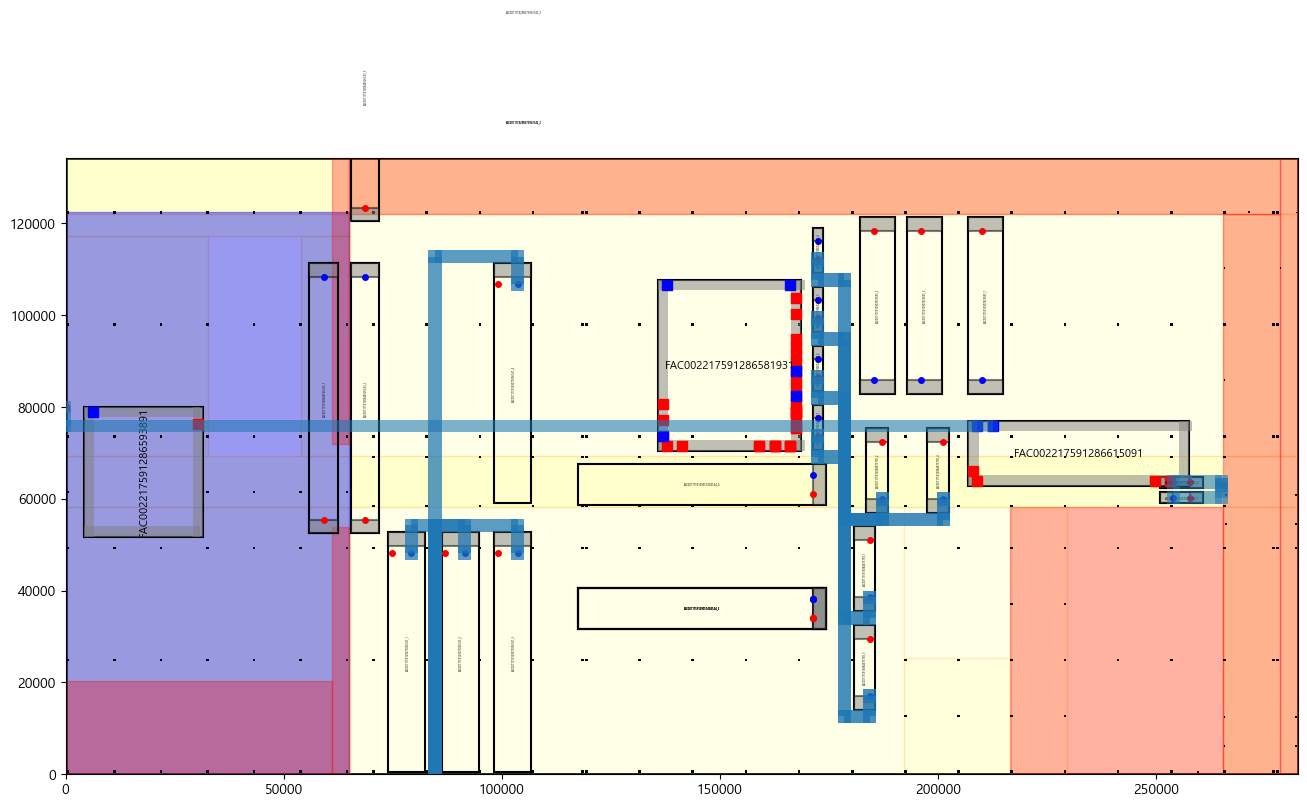

In [ ]:
plt_f_6(
    path_total,
    2500.0,          # 화면에서도 같은 두께로 그림
    True,
    0.35,path_AA,path_BB,True,None,0.8
)

In [ ]:
# # --- 유틸: 축정렬 사각형 교차 판정 ---
# def _rects_intersect(r1, r2, allow_touch=True):
#     x1min, y1min, x1max, y1max = r1
#     x2min, y2min, x2max, y2max = r2
#     if allow_touch:
#         return not (x1max < x2min or x2max < x1min or y1max < y2min or y2max < y1min)
#     else:
#         return not (x1max <= x2min or x2max <= x1min or y1max <= y2min or y2max <= y1min)

# # --- path_AA 선분들을 두께가 있는 ‘밴드 직사각형’들로 변환 ---
# def _corridor_rects_from_pathAA(path_AA, path_width):
#     r = float(path_width) / 2.0
#     rects = []
#     for seg in path_AA:
#         (x1, y1) = seg['start']
#         (x2, y2) = seg['end']
#         if abs(y1 - y2) < 1e-6:
#             # 수평 밴드
#             xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
#             rects.append((xmin - r, y1 - r, xmax + r, y1 + r))
#         elif abs(x1 - x2) < 1e-6:
#             # 수직 밴드
#             ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
#             rects.append((x1 - r, ymin - r, x1 + r, ymax + r))
#         else:
#             # (예외) 비축정렬인 경우는 외접직사각형으로 처리
#             xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
#             ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
#             rects.append((xmin - r, ymin - r, xmax + r, ymax + r))
#     return rects

# # --- 설비 행(row) -> 사각형(BB) ---
# # (이미 같은 이름의 함수가 있으면 이 정의는 생략해도 됩니다)
# def _rect_from_row(row, clearance=0.0):
#     cx, cy = float(row['center_X']), float(row['center_Y'])
#     rot = int(row['회전'])
#     if rot == 0:
#         half_w = float(row['x'])/2.0 + clearance
#         half_h = float(row['y'])/2.0 + clearance
#     else:
#         half_w = float(row['y'])/2.0 + clearance
#         half_h = float(row['x'])/2.0 + clearance
#     return (cx - half_w, cy - half_h, cx + half_w, cy + half_h)

# # --- 메인: path_AA 밴드와 겹치는 설비들 반환 ---
# def facilities_within_pathAA(df_result_2, path_AA, path_width, allow_touch=True, clearance=0.0):
#     """
#     반환: (hit_df, hit_indices, debug_list)
#       - hit_df: 겹치는 설비만 모은 서브 DataFrame
#       - hit_indices: 겹친 설비 인덱스 리스트
#       - debug_list: 각 설비별로 어떤 밴드와 겹쳤는지 부가정보
#     """
#     corridors = _corridor_rects_from_pathAA(path_AA, path_width)
#     hit_indices = []
#     debug_list = []

#     for i, row in df_result_2.iterrows():
#         fac_rect = _rect_from_row(row, clearance=clearance)
#         hit_any = False
#         hit_which = []
#         for k, cor in enumerate(corridors):
#             if _rects_intersect(fac_rect, cor, allow_touch=allow_touch):
#                 hit_any = True
#                 hit_which.append(k)
#         if hit_any:
#             hit_indices.append(i)
#             debug_list.append({"index": i, "hit_corridors": hit_which})

#     hit_df = df_result_2.loc[hit_indices].copy()
#     return hit_df, hit_indices, debug_list

# # === 사용 예시 ===
# # path_AA: [{ "start": (x1,y1), "end": (x2,y2) }, ...]
# hit_df, hit_idx, dbg = facilities_within_pathAA(
#     df_result_2, path_AA, path_width=2550.0, allow_touch=True, clearance=0.0
# )

# print("겹친 설비 인덱스:", hit_idx)
# print(hit_df[['설비Group','설비번호','type','center_X','center_Y','x','y','회전','k']].to_string(index=True))
# # 필요하면 dbg 로 어떤 밴드(#)와 겹쳤는지도 확인 가능
# # print(dbg)


In [ ]:
# # --- 유틸: 축정렬 사각형 교차 판정 ---
# def _rects_intersect(r1, r2, allow_touch=True):
#     x1min, y1min, x1max, y1max = r1
#     x2min, y2min, x2max, y2max = r2
#     if allow_touch:
#         return not (x1max < x2min or x2max < x1min or y1max < y2min or y2max < y1min)
#     else:
#         return not (x1max <= x2min or x2max <= x1min or y1max <= y2min or y2max <= y1min)

# # --- 교차 영역(겹치는 직사각형) 계산 ---
# def _rect_intersection(r1, r2, allow_touch=True):
#     x1min, y1min, x1max, y1max = r1
#     x2min, y2min, x2max, y2max = r2
#     ixmin = max(x1min, x2min)
#     iymin = max(y1min, y2min)
#     ixmax = min(x1max, x2max)
#     iymax = min(y1max, y2max)
#     if allow_touch:
#         if ixmin <= ixmax and iymin <= iymax:
#             return (ixmin, iymin, ixmax, iymax)
#     else:
#         if ixmin < ixmax and iymin < iymax:
#             return (ixmin, iymin, ixmax, iymax)
#     return None

# # --- path_AA 선분들을 두께가 있는 ‘밴드 직사각형’들로 변환 ---
# def _corridor_rects_from_pathAA(path_AA, path_width):
#     r = float(path_width) / 2.0
#     rects = []
#     for seg in path_AA:
#         (x1, y1) = seg['start']
#         (x2, y2) = seg['end']
#         if abs(y1 - y2) < 1e-6:
#             xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
#             rects.append((xmin - r, y1 - r, xmax + r, y1 + r))
#         elif abs(x1 - x2) < 1e-6:
#             ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
#             rects.append((x1 - r, ymin - r, x1 + r, ymax + r))
#         else:
#             xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
#             ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
#             rects.append((xmin - r, ymin - r, xmax + r, ymax + r))
#     return rects

# # --- 설비 행(row) -> 사각형(BB) ---
# def _rect_from_row(row, clearance=0.0):
#     cx, cy = float(row['center_X']), float(row['center_Y'])
#     rot = int(row['회전'])
#     if rot == 0:
#         half_w = float(row['x'])/2.0 + clearance
#         half_h = float(row['y'])/2.0 + clearance
#     else:
#         half_w = float(row['y'])/2.0 + clearance
#         half_h = float(row['x'])/2.0 + clearance
#     return (cx - half_w, cy - half_h, cx + half_w, cy + half_h)

# # --- 교차 방향 판정: 교차영역이 설비의 어느 변과 맞닿았는지 ---
# def _overlap_directions(fac_rect, inter_rect, eps=1e-6):
#     fxmin, fymin, fxmax, fymax = fac_rect
#     ixmin, iymin, ixmax, iymax = inter_rect
#     dirs = []
#     if abs(iymax - fymax) <= eps:  # top aligned
#         dirs.append('상')
#     if abs(iymin - fymin) <= eps:  # bottom aligned
#         dirs.append('하')
#     if abs(ixmin - fxmin) <= eps:  # left aligned
#         dirs.append('좌')
#     if abs(ixmax - fxmax) <= eps:  # right aligned
#         dirs.append('우')
#     return dirs

# # --- 메인: path_AA 밴드와 겹치는 설비들 + 겹친 방향 반환 ---
# def facilities_within_pathAA(df_result_2, path_AA, path_width, allow_touch=True, clearance=0.0):
#     """
#     반환: (hit_df, hit_indices, debug_list)
#       - hit_df: 겹치는 설비만 모은 서브 DataFrame
#       - hit_indices: 겹친 설비 인덱스 리스트
#       - debug_list: 각 설비별 부가정보
#           {
#             "index": i,
#             "hit_corridors": [겹친 밴드 인덱스...],
#             "directions_by_corridor": { 밴드인덱스: ['상','하','좌','우' ...], ... },
#             "directions_union": ['상', '우', ...]  # 설비 기준 전체 합집합
#           }
#     """
#     corridors = _corridor_rects_from_pathAA(path_AA, path_width)
#     hit_indices = []
#     debug_list = []

#     for i, row in df_result_2.iterrows():
#         fac_rect = _rect_from_row(row, clearance=clearance)
#         hit_any = False
#         hit_which = []
#         dir_map = {}
#         dir_union = set()

#         for k, cor in enumerate(corridors):
#             if not _rects_intersect(fac_rect, cor, allow_touch=allow_touch):
#                 continue
#             inter = _rect_intersection(fac_rect, cor, allow_touch=allow_touch)
#             if inter is None:
#                 continue

#             hit_any = True
#             hit_which.append(k)
#             dirs = _overlap_directions(fac_rect, inter, eps=1e-6)
#             dir_map[k] = dirs
#             dir_union.update(dirs)

#         if hit_any:
#             hit_indices.append(i)
#             debug_list.append({
#                 "index": i,
#                 "hit_corridors": hit_which,
#                 "directions_by_corridor": dir_map,
#                 "directions_union": sorted(dir_union, key=lambda x: {'상':0,'하':1,'좌':2,'우':3}.get(x, 99))
#             })

#     hit_df = df_result_2.loc[hit_indices].copy()
#     return hit_df, hit_indices, debug_list
# hit_df, hit_idx, dbg = facilities_within_pathAA(
#     df_result_2, path_AA, path_width=2550.0, allow_touch=True, clearance=0.0
# )

# print("겹친 설비 인덱스:", hit_idx)
# print(hit_df[['설비Group','설비번호','type','center_X','center_Y','x','y','회전','k']].to_string(index=True))

# for info in dbg:
#     i = info['index']
#     print(f"[{i}] directions_union={info['directions_union']}  by_corridor={info['directions_by_corridor']}")


In [ ]:
# --- 교차 영역(겹치는 직사각형) 계산 ---
def _rect_intersection(r1, r2, allow_touch=True):
    x1min, y1min, x1max, y1max = r1
    x2min, y2min, x2max, y2max = r2
    ixmin = max(x1min, x2min)
    iymin = max(y1min, y2min)
    ixmax = min(x1max, x2max)
    iymax = min(y1max, y2max)
    if allow_touch:
        if ixmin <= ixmax and iymin <= iymax:
            return (ixmin, iymin, ixmax, iymax)
    else:
        if ixmin < ixmax and iymin < iymax:
            return (ixmin, iymin, ixmax, iymax)
    return None

# --- path_AA 선분들을 두께 밴드 + 방향(H/V)로 변환 ---
def _corridors_from_pathAA(path_AA, path_width):
    r = float(path_width) / 2.0
    items = []
    for seg in path_AA:
        (x1, y1) = seg['start']
        (x2, y2) = seg['end']
        if abs(y1 - y2) < 1e-6:
            # 수평 밴드 (H)
            xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
            rect = (xmin - r, y1 - r, xmax + r, y1 + r)
            items.append((rect, 'H'))
        elif abs(x1 - x2) < 1e-6:
            # 수직 밴드 (V)
            ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
            rect = (x1 - r, ymin - r, x1 + r, ymax + r)
            items.append((rect, 'V'))
        else:
            # 비축정렬(예외) — 외접직사각형, 방향은 더 긴 쪽으로 추정
            xmin, xmax = (x1, x2) if x1 <= x2 else (x2, x1)
            ymin, ymax = (y1, y2) if y1 <= y2 else (y2, y1)
            rect = (xmin - r, ymin - r, xmax + r, ymax + r)
            orient = 'H' if (xmax - xmin) >= (ymax - ymin) else 'V'
            items.append((rect, orient))
    return items  # [(rect, 'H'|'V'), ...]

# --- 설비 행(row) -> 사각형(BB) ---
def _rect_from_row(row, clearance=0.0):
    cx, cy = float(row['center_X']), float(row['center_Y'])
    rot = int(row['회전'])
    if rot == 0:
        half_w = float(row['x'])/2.0 + clearance
        half_h = float(row['y'])/2.0 + clearance
    else:
        half_w = float(row['y'])/2.0 + clearance
        half_h = float(row['x'])/2.0 + clearance
    return (cx - half_w, cy - half_h, cx + half_w, cy + half_h)

# --- 메인: path_AA 밴드와 겹치는 설비 + 인접 방향 코드(1/2/3/4) ---
# 코드 규칙: 오른쪽=1, 왼쪽=2, 아래=3, 위=4
def facilities_within_pathAA_with_side(df_result_2, path_AA, path_width, allow_touch=True, clearance=0.0, eps=1e-6):
    corridors = _corridors_from_pathAA(path_AA, path_width)
    hit_indices = []
    side_code_map = {}  # index -> code
    debug_list = []     # 옵션: 원하면 유지

    for i, row in df_result_2.iterrows():
        fac_rect = _rect_from_row(row, clearance=clearance)
        fxmin, fymin, fxmax, fymax = fac_rect

        best_code = 0
        best_area = -1.0
        hit_any = False
        dir_by_corr = {}

        for k, (cor, orient) in enumerate(corridors):
            inter = _rect_intersection(fac_rect, cor, allow_touch=allow_touch)
            if inter is None:
                continue

            hit_any = True
            ixmin, iymin, ixmax, iymax = inter
            area = max(0.0, ixmax - ixmin) * max(0.0, iymax - iymin)

            # 경로가 V(수직)이면 설비 좌/우 중 하나와 인접 → 코드 1(우), 2(좌)
            cand_codes = []
            if orient == 'V':
                if abs(ixmax - fxmax) <= eps:
                    cand_codes.append(1)  # 오른쪽
                if abs(ixmin - fxmin) <= eps:
                    cand_codes.append(2)  # 왼쪽
            # 경로가 H(수평)이면 설비 상/하 중 하나와 인접 → 코드 3(아래), 4(위)
            elif orient == 'H':
                if abs(iymin - fymin) <= eps:
                    cand_codes.append(3)  # 아래
                if abs(iymax - fymax) <= eps:
                    cand_codes.append(4)  # 위

            # 후보가 없는데 내부 관통같은 케이스면, 가까운 변으로 heuristic
            if not cand_codes:
                # V이면 좌/우 중 가까운 변
                if orient == 'V':
                    d_left = abs(ixmin - fxmin)
                    d_right = abs(ixmax - fxmax)
                    cand_codes.append(1 if d_right <= d_left else 2)
                # H이면 상/하 중 가까운 변
                elif orient == 'H':
                    d_bottom = abs(iymin - fymin)
                    d_top    = abs(iymax - fymax)
                    cand_codes.append(4 if d_top <= d_bottom else 3)

            # 여러 후보면(모서리 같은 경우) area가 큰 쪽을 위해 동일 area면 큰 코드 우선X → 첫 후보 사용
            use_code = cand_codes[0]
            dir_by_corr[k] = use_code

            # 가장 큰 겹침 면적을 가진 인접 코드 선택
            if area > best_area:
                best_area = area
                best_code = use_code

        if hit_any:
            hit_indices.append(i)
            side_code_map[i] = best_code
            debug_list.append({
                "index": i,
                "picked_code": best_code,
                "best_area": best_area,
                "by_corridor": dir_by_corr
            })

    hit_df = df_result_2.loc[hit_indices].copy()
    # 없는 경우(미겹침)는 포함되지 않음. 필요시 전체 df에 채우려면 reindex 후 fillna(0).
    hit_df['인접'] = [side_code_map[idx] for idx in hit_indices]
    return hit_df, hit_indices, debug_list
hit_df, hit_idx, dbg = facilities_within_pathAA_with_side(
    df_result_2, path_AA, path_width=2550.0, allow_touch=True, clearance=0.0
)

print("겹친 설비 인덱스:", hit_idx)
print(hit_df[['설비Group','설비번호','type','center_X','center_Y','x','y','회전','k','인접']].to_string(index=True))

# 디버그(선택)
# for d in dbg:
#     print(d)


겹친 설비 인덱스: []
Empty DataFrame
Columns: [설비Group, 설비번호, type, center_X, center_Y, x, y, 회전, k, 인접]
Index: []


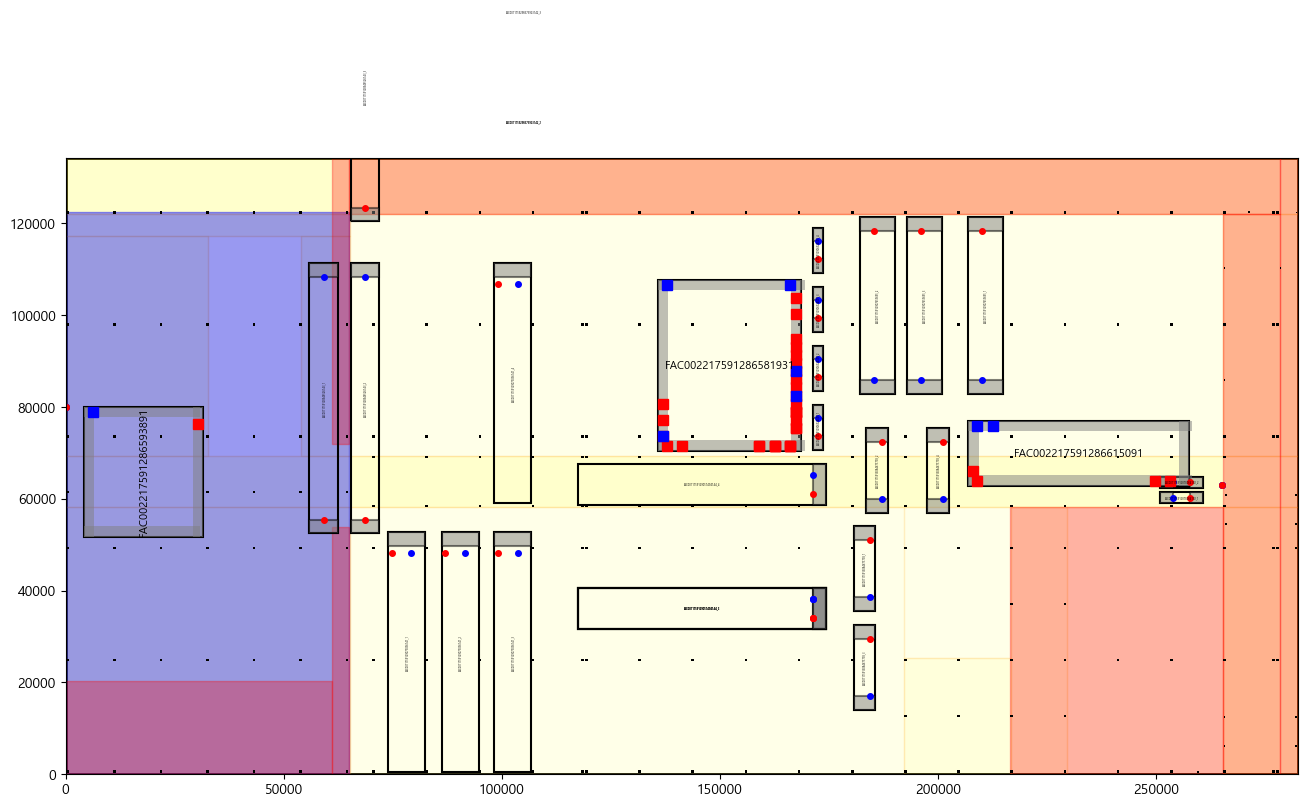

In [ ]:
sotrage_en_x, sotrage_en_y, sotrage_exi_x, sotrage_exi_y=plt_f_4()  

250986.0
[np.float64(73968.0), np.float64(106799.0)]
c : 0  r:  10  ne:  2958.0  endi:  3
c : 0  r:  0  ne:  2958.0  endi:  4
250986.0
[np.float64(73968.0), np.float64(106799.0)]
c : 0  r:  10  ne:  2958.0  endi:  3
c : 1  r:  0  ne:  8982.0  endi:  1
c : 1  r:  0  ne:  3810.0  endi:  1
c : 1  r:  0  ne:  7315.0  endi:  1
117534.0
[np.float64(73968.0), np.float64(106799.0)]
171254.0
[np.float64(73968.0), np.float64(106799.0)]
c : 5  r:  0  ne:  2233.0  endi:  3
182095.0
[np.float64(73968.0), np.float64(106799.0)]
180654.0
[np.float64(73968.0), np.float64(106799.0)]
135762.0
[np.float64(73968.0), np.float64(106799.0)]
206979.0
[np.float64(73968.0), np.float64(106799.0)]
265000.0
[np.float64(73968.0), np.float64(106799.0)]
c : 0  r:  0  ne:  2958.0  endi:  4
250986.0
[np.float64(73968.0), np.float64(106799.0)]
c : 0  r:  10  ne:  2958.0  endi:  3
c : 0  r:  0  ne:  2958.0  endi:  4
c : 1  r:  0  ne:  20107.0  endi:  2
c : 1  r:  0  ne:  8982.0  endi:  1
c : 1  r:  0  ne:  3810.0  endi:  

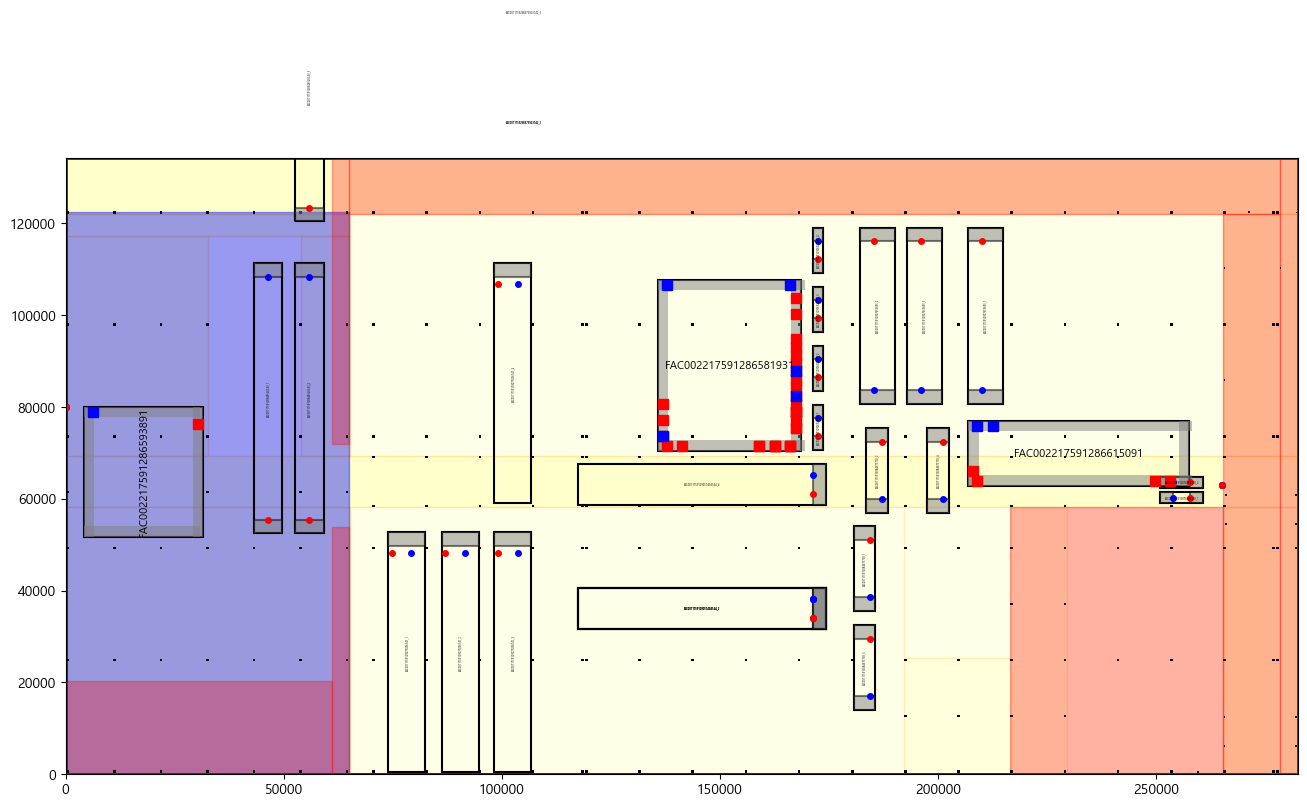

In [ ]:
for i in range(len(hit_df['설비Group'].unique())):
    if df_selected[df_selected['설비Group']==hit_df['설비Group'].unique()[i]]['type'].iloc[0]!='storage':
        dire=hit_df[hit_df['설비Group']==hit_df['설비Group'].unique()[i]]['회전'].iloc[0]
        updo=hit_df[hit_df['설비Group']==hit_df['설비Group'].unique()[i]]['k'].iloc[0]
        inj=hit_df[hit_df['설비Group']==hit_df['설비Group'].unique()[i]]['인접'].iloc[0]
        print(dire)
        print(updo)
        print(inj)
        if dire==0 and updo==0:
            if inj==1:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UR']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
            if inj==2:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UL']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
            if inj==3:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UB']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
            if inj==4:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UA']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
        if dire==0 and updo==1:   
            if inj==2:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UR']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
            if inj==1:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UL']=3*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
                print(df_selected[df_selected['설비Group']==hit_df['설비Group'].unique()[i]]['UL'])
            if inj==4:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UB']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']
            if inj==3:
                df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'UA']=2*df_selected.loc[df_selected['설비Group']==hit_df['설비Group'].unique()[i],'pathWidth']   

Clear_R={}
Clear_L={}
Clear_A={}
Clear_B={}
for i in df_selected.index:
    Clear_R[i]=df_selected.loc[i,'UL']
    Clear_L[i]=df_selected.loc[i,'UL']
    Clear_B[i]=df_selected.loc[i,'UB']
    Clear_A[i]=df_selected.loc[i,'UB']
df_selected['Clear_R'] = Clear_R
df_selected['Clear_L'] = Clear_L
df_selected['Clear_B'] = Clear_B
df_selected['Clear_A'] = Clear_A


df_re_cle=make_df_re_cle()
col_ad()
col_ad()
sotrage_en_x, sotrage_en_y, sotrage_exi_x, sotrage_exi_y=plt_f_4()        

In [ ]:
df_result_2=df_result.copy()
df_result_2 = df_result_2[df_result_2['type'] != 'storage'].copy()
storage_io_map_by_index={}

for i in df_selected.index:
    if df_selected.loc[i,'type']!='storage':
        continue
    
    new_row = {"설비Group": df_selected.loc[i,'설비Group'], "설비번호": 0, "center_X": X[i],"center_Y": Y[i],'x': df_selected.loc[i,'Cluster_X'],'y': df_selected.loc[i,'Cluster_Y'],'type':df_selected.loc[i,'type'],'회전':o[i],'k':1}  # df_result_2의 컬럼에 맞춰 dict 작성
    df_result_2.loc[len(df_result_2)] = new_row
    storage_io_map_by_index[len(df_result_2)-1]={}
    list_en=[]

    for j in range(len(sotrage_en_x[i])):
        list_en.append((sotrage_en_x[i][j],sotrage_en_y[i][j]))
    storage_io_map_by_index[len(df_result_2)-1]["entries"]=list_en
    list_ex=[]
        
   
    for j in range(len(sotrage_exi_x[i])):
        list_ex.append((sotrage_exi_x[i][j],sotrage_exi_y[i][j]))
    storage_io_map_by_index[len(df_result_2)-1]["exits"]=list_ex

    fac_list = sfc_to.get(i, [])
    if fac_list:
        
        idx_list = df_result_2.index[df_result_2['설비Group'].isin(fac_list)].tolist()
        

    
    fac_list = sfc_from.get(i, [])
    if not fac_list:
        continue
    idx_list = df_result_2.index[df_result_2['설비Group'].isin(fac_list)].tolist()


df_result_2 = pd.concat([df_result_2, df_pre], ignore_index=True)
for c in df_result_2.index:
    d=df_selected[df_selected['설비Group'] == df_result_2.loc[c, '설비Group']]['ent_X'].index[0]
    if df_selected.loc[d,'processGroup']=='dock':
        df_result_2.loc[c,'type']='dock'

In [ ]:
pairs

[(30, 1),
 (30, 0),
 (30, 1),
 (30, 0),
 (26, 16),
 (26, 15),
 (26, 14),
 (26, 13),
 (25, 16),
 (25, 15),
 (25, 14),
 (25, 13),
 (24, 16),
 (24, 15),
 (24, 14),
 (24, 13),
 (12, 23),
 (12, 22),
 (12, 21),
 (12, 20),
 (11, 23),
 (11, 22),
 (11, 21),
 (11, 20),
 (10, 23),
 (10, 22),
 (10, 21),
 (10, 20),
 (9, 23),
 (9, 22),
 (9, 21),
 (9, 20),
 (29, 29),
 (29, 8),
 (29, 7),
 (29, 6),
 (29, 5),
 (29, 1),
 (29, 0),
 (31, 29),
 (29, 4),
 (29, 3),
 (29, 2),
 (26, 29),
 (25, 29),
 (24, 29),
 (19, 29),
 (18, 29),
 (17, 29),
 (12, 29),
 (11, 29),
 (10, 29),
 (9, 29),
 (8, 29),
 (7, 29),
 (6, 29),
 (5, 29),
 (4, 29),
 (3, 29),
 (2, 29),
 (29, 23),
 (29, 22),
 (29, 21),
 (29, 20),
 (29, 19),
 (29, 18),
 (29, 17),
 (29, 16),
 (29, 15),
 (29, 14),
 (29, 13),
 (29, 12),
 (29, 11),
 (29, 10),
 (29, 9),
 (29, 8),
 (29, 7),
 (29, 6),
 (29, 5)]

In [ ]:
path_total = compute_paths_expand_storage(
    df_result_2, pairs,
    path_width=2500.0,             # ← 매칭 실패 시 fallback
    allow_touch=True,
    column_areas=column_areas, restricted_areas=restricted_areas,
    share_bonus=0.5, min_weight_factor=0.3, bundle_band=1000.0,
    turn_penalty=20000.0,oppose_penalty_lane=3000.0 
)

path_AA = build_path_AA(
    path_total,
    path_width=2500.0,
    band=None,            # None → path_width와 동일 폭으로 같은 차선 판단
    lane_slack=0,         # 인접 버킷까지 허용하려면 1
    min_segment_len=0.0   # 너무 짧은 공유구간은 필터링(예: 1000.0)
)
path_BB = build_path_BB(
    path_total,
    df_result2=df_result_2,
    group_col='설비Group',
    path_width=2500.0,
    band=None,            # None → path_width와 동일 폭으로 같은 차선 판단
    lane_slack=0,         # 인접 버킷까지 허용하려면 1
    min_segment_len=0.0   # 너무 짧은 공유구간은 필터링(예: 1000.0)
)
path_AA=[]
path_BB=[]
plt_f_6(
    path_total,
    2500.0,          # 화면에서도 같은 두께로 그림
    True,
    0.35,path_AA,path_BB,True,None,0.8
)

[WARN] route fail: 29->29  start_io=(np.float64(253266.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(253266.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(249726.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(249726.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(209016.0), np.float64(63957.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(209016.0), np.float64(63957.0))  goal_io=(np.float64(212556.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(208131.0), np.float64(65994.0))  goal_io=(np.float64(209016.0), np.float64(75861.0))
[WARN] route fail: 29->29  start_io=(np.float64(208131.0), np.float64

KeyboardInterrupt: 

In [ ]:
df_selected

In [ ]:
for i in range(len(hit_df['설비Group'].unique())):
    print()

In [ ]:
data

# output json 생성 코드

In [ ]:
data_out = {
    "layoutId": "xxxxxxxxxxxx",
    "factoryId": data['factoryName'],
    "factoryWidth": data['factoryDimensions']['width'],
    "factoryHeight": data['factoryDimensions']['height'],
    "facilities":[]
}

In [ ]:
for j in df_result_2.index:
    left=df_result_2.loc[j,'설비Group']
    try:
        d=df_selected[df_selected['설비Group']==left].index[0]
    except:
        d=df_selected_copy[df_selected_copy['설비Group']==left].index[0]
    dt=df_result_2.copy()

    a={}
    if (dt.loc[j,'type']=='storage') and (dt.loc[j-1,'설비Group']==dt.loc[j,'설비Group']):
        f_num+=1
        a['id']=f"{left}_{f_num}"
    else:
        f_num=dt.loc[j,'설비번호']
        a['id']=f"{left}_{f_num}"
    a['width']=dt.loc[j,'x']
    a['height']=dt.loc[j,'y']

    if o[d]==0 and di[d]==0:
        a['rotation']=0
        corner_bi_x=-dt.loc[j,'x']/2
        corner_bi_y=-dt.loc[j,'y']/2
    elif o[d]==1 and di[d]==0:
        a['rotation']=90
        corner_bi_x=dt.loc[j,'y']/2
        corner_bi_y=-dt.loc[j,'x']/2   
    elif o[d]==0 and di[d]==1:
        a['rotation']=180
        corner_bi_x=dt.loc[j,'x']/2
        corner_bi_y=dt.loc[j,'y']/2
    else:
        a['rotation']=270
        corner_bi_x=-dt.loc[j,'y']/2
        corner_bi_y=dt.loc[j,'x']/2       
    a['rotatedCorner']={}
    a['rotatedCorner']['x']=dt.loc[j,'center_X']+corner_bi_x
    a['rotatedCorner']['y']=dt.loc[j,'center_Y']+corner_bi_y

    ori_en_x=df_selected.loc[d,'ent_X']-dt.loc[j,'x']/2
    ori_en_y=df_selected.loc[d,'ent_Y']-dt.loc[j,'y']/2
    ori_ex_x=df_selected.loc[d,'exi_X']-dt.loc[j,'x']/2
    ori_ex_y=df_selected.loc[d,'exi_Y']-dt.loc[j,'y']/2

    if o[d]==0 and di[d]==0:
        en_x=ori_en_x
        en_y=ori_en_y
        ex_x=ori_ex_x
        ex_y=ori_ex_y
    elif o[d]==1 and di[d]==0:
        en_x=ori_en_y
        en_y=-ori_en_x
        ex_x=ori_ex_y
        ex_y=-ori_ex_x 

    elif o[d]==0 and di[d]==1:
        en_x=-ori_en_x
        en_y=-ori_en_y
        ex_x=-ori_ex_x
        ex_y=-ori_ex_y

    else:
        en_x=-ori_en_y
        en_y=ori_en_x
        ex_x=-ori_ex_y
        ex_y=ori_ex_x 
    a['transformedEntrance']={}
    a['transformedEntrance']['x']=dt.loc[j,'center_X']+en_x
    a['transformedEntrance']['y']=dt.loc[j,'center_Y']+en_y

    a['transformedExit']={}
    a['transformedExit']['x']=dt.loc[j,'center_X']+ex_x
    a['transformedExit']['y']=dt.loc[j,'center_Y']+ex_y
    a['facilityType']=dt.loc[j,'type']
    a["areaMap"]='null'
    data_out['facilities'].append(a)   

In [ ]:
for dt in shuttleInport:
    a={}
    a['id']=dt['id']
    a['width']=dt['width']
    a['height']=dt['height']
    a['rotation']=0
    
    fg=dt['facilityGroup']
    for i in df_selected[df_selected['설비Group']==fg].index:
        if len(sotrage_en_x[i])==0:
            continue
        a['rotatedCorner']={}
        a['rotatedCorner']['x']=sotrage_en_x[i][0]-dt['width']/2
        a['rotatedCorner']['y']=sotrage_en_y[i][0]-dt['height']/2
        a['transformedEntrance']={}
        a['transformedEntrance']['x']=a['rotatedCorner']['x']+dt['entranceRelativeX']
        a['transformedEntrance']['y']=a['rotatedCorner']['y']+dt['entranceRelativeY']
        a['transformedExit']={}
        a['transformedExit']['x']=a['rotatedCorner']['x']+dt['exitRelativeX']
        a['transformedExit']['y']=a['rotatedCorner']['y']+dt['exitRelativeY']
        a['facilityType']=dt['type']
        a['areaMap']='null'
        data_out['facilities'].append(a) 
        del sotrage_en_x[i][0]
        del sotrage_en_y[i][0]
        break
for dt in shuttleOutport:
    a={}
    a['id']=dt['id']
    a['width']=dt['width']
    a['height']=dt['height']
    a['rotation']=0
    
    fg=dt['facilityGroup']
    for i in df_selected[df_selected['설비Group']==fg].index:
        if len(sotrage_en_x[i])==0:
            continue
        a['rotatedCorner']={}
        a['rotatedCorner']['x']=sotrage_exi_x[i][0]-dt['width']/2
        a['rotatedCorner']['y']=sotrage_exi_y[i][0]-dt['height']/2
        a['transformedEntrance']={}
        a['transformedEntrance']['x']=a['rotatedCorner']['x']+dt['entranceRelativeX']
        a['transformedEntrance']['y']=a['rotatedCorner']['y']+dt['entranceRelativeY']
        a['transformedExit']={}
        a['transformedExit']['x']=a['rotatedCorner']['x']+dt['exitRelativeX']
        a['transformedExit']['y']=a['rotatedCorner']['y']+dt['exitRelativeY']
        a['facilityType']=dt['type']
        a['areaMap']='null'
        data_out['facilities'].append(a) 
        del sotrage_exi_x[i][0]
        del sotrage_exi_y[i][0]
        break        

In [ ]:
data_out['conveyorPathList']=[]
for pt in path_total:
    a={}
    a['fromFacilityId']=f"{df_result_2.loc[pt['start'],'설비Group']}_{df_result_2.loc[pt['start'],'설비번호']}"
    a['toFacilityId']=f"{df_result_2.loc[pt['goal'],'설비Group']}_{df_result_2.loc[pt['goal'],'설비번호']}"
    a['pathWidth']=pt['path_width']
    a['lineCount']=1
    a['fromFacilityExitPoint']={}
    a['fromFacilityExitPoint']['x']=pt['start_io'][0]
    a['fromFacilityExitPoint']['y']=pt['start_io'][1]
    a['toFacilityEntrancePoint']={}
    a['toFacilityEntrancePoint']['x']=pt['goal_io'][0]
    a['toFacilityEntrancePoint']['y']=pt['goal_io'][1]    
    a['pathList']=[]
    for i in pt['path']:
        b={}
        b['x']=i[0]
        b['y']=i[1]
        a['pathList'].append(b)
    data_out['conveyorPathList'].append(a) 

In [ ]:
def to_python_type(o):
    # 넘파이 정수형 -> 파이썬 int
    if isinstance(o, (np.integer,)):
        return int(o)
    # 넘파이 실수형 -> 파이썬 float
    if isinstance(o, (np.floating,)):
        return float(o)
    # 넘파이 배열 -> 파이썬 list
    if isinstance(o, (np.ndarray,)):
        return o.tolist()
    # 그 외 타입은 기본 에러 내게 두기
    raise TypeError(f"Type {type(o)} not serializable")

outdata=f'output_{indata}'
with open(outdata, 'w', encoding='utf-8') as f:
    json.dump(data_out, f,
              ensure_ascii=False,
              indent=4,
              default=to_python_type)